In [76]:
import sys
sys.path.append('../python')
import plot_info
import glob
import os
import copy
import json
import csv
import matplotlib.pyplot as plt
import numpy as np


In [102]:
base_folder='/run/media/klye/elements/kjetil/learning/learning_airfoils3/learning_airfoils3'
base_notebook = 'SodShockTube_2_2'
functional_names = ['Q1', 'Q2', 'Q3']
base_folder='/run/media/klye/TOSHIBA EXT/learning/learning_airfoils2'
base_folder='/run/media/klye/elements/kjetil/learning/learning_airfoils2/learning_airfoils2'
base_notebook='MachineLearningSixParametersAirfoil_2_2'
functional_names = ['Lift', 'Drag']

In [97]:
class Measurement(object):
    def __init__(self, properties, wasserstein_error, prediction_error_l1, prediction_error_l2,
                wasserstein_speedup):
        self.properties = copy.deepcopy(properties)
        self.prediction_error_l1 = copy.deepcopy(prediction_error_l1)
        self.prediction_error_l2 = copy.deepcopy(prediction_error_l2)
        self.wasserstein_error = copy.deepcopy(wasserstein_error)
        self.wasserstein_speedup  = copy.deepcopy(wasserstein_speedup)
        
    def keys(self):
        return ['prediction_error_l1', 'prediction_error_l2', 'wasserstein_speedup', 'wasserstein_error']
    
    def __getitem__(self, key):
        return self.__dict__[key]


In [114]:
def to_str(x):
    if type(x) == dict:
        if 'l1' in x.keys():
            return "l1" if x['l1'] > 0 else "l2"
        s = ', '.join(["{}: {}".format(k, x[k]) for k in x.keys()])
        return s
    return x
        
folders = glob.glob(os.path.join(base_folder, "{}*".format(base_notebook)))

measurements = {}
for func in functional_names:
    measurements[func] = []

all_prediction_l1_errors_training_size = {}
all_prediction_l2_errors_training_size = {}
all_wasserstein_errors_training_size = {}
all_wasserstein_speedups_training_size = {}
lsq_prediction_errors_l1 = {}
lsq_prediction_errors_l2 = {}

lsq_wasserstein_speedups_training_size = {}

all_configs = {}
for f in folders:
    if not os.path.exists(os.path.join(f, 'config_run.json')):
        continue
    with open(os.path.join(f, 'config_run.json')) as conf:
        config_json = json.load(conf)
        
    for k in config_json.keys():
        if k not in all_configs.keys():
            all_configs[k] = []
        all_configs[k].append(to_str(config_json[k]))
    
    training_size = int(config_json['train_size'])
    if training_size not in all_prediction_l1_errors_training_size.keys():
        all_prediction_l1_errors_training_size[training_size] = {}
        all_prediction_l2_errors_training_size[training_size] = {}
        all_wasserstein_errors_training_size[training_size] = {}
        all_wasserstein_speedups_training_size[training_size] = {}
        lsq_prediction_errors_l1[training_size] = {}
        lsq_prediction_errors_l2[training_size] = {}
        
        lsq_wasserstein_speedups_training_size[training_size] = {}
        
    for func in functional_names:
        if func not in all_prediction_l1_errors_training_size[training_size].keys():
            all_prediction_l1_errors_training_size[training_size][func] = []
            all_prediction_l2_errors_training_size[training_size][func] = []
            all_wasserstein_errors_training_size[training_size][func] = []
            all_wasserstein_speedups_training_size[training_size][func] = []
            lsq_prediction_errors_l1[training_size][func] = []
            lsq_prediction_errors_l2[training_size][func] = []
            
            lsq_wasserstein_speedups_training_size[training_size][func] = []
        
        error_files = glob.glob(os.path.join(f, 'results/*errors.json'))
        if len(error_files) == 0:
            #print("No error files found")
            continue
        for e in error_files:
            
            if func in e:
                with open(e, 'r') as error_file:
                    errors= json.load(error_file)
                    wasserstein = float(errors['wasserstein_error'])
        prediction_files = glob.glob(os.path.join(f, 'tables/*prediction_error_table.csv'))
        prediction_error_l1 = None
        prediction_error_l2 = None
        
        if len(prediction_files) == 0:
            print("No prediction files found")
            continue
        for p in prediction_files:
            if func in p:
                with open(p) as pred_file:
                    errors = csv.reader(pred_file)
                    rows = []
                    for row in errors:
                        rows.append(row)
                    prediction_error_l1 = float(rows[1][1])
                    prediction_error_l2 = float(rows[2][1])
                    lsq_l1 = float(rows[1][2])
                    lsq_l2 = float(rows[2][2])
                    
                    
        wasserstein_speedup_files = glob.glob(os.path.join(f, 'tables/*wasserstein_table_builder.csv'))
        
           
        if len(wasserstein_speedup_files) == 0:
            print("No prediction files found")
            continue
        for w in wasserstein_speedup_files:
            if func in w:
                with open(w) as wasser_file:
                    speedups = csv.reader(wasser_file)
                    rows = []
                    for row in speedups:
                        rows.append(row)
                    wasserstein_ml = float(rows[1][1])
                    wasserstein_lsq = float(rows[1][2])
      
        #if 'l1' in to_str(config_json['regularizer']) or 'l2' in to_str(config_json['regularizer']):
        #    if 'squared' in config_json['loss']:
        #        continue
        #if 'Adam' not in config_json['optimizer']:
        #    continue
        measurements[func].append(Measurement(config_json, wasserstein, prediction_error_l1, prediction_error_l2,
                                             wasserstein_ml))
        
        all_prediction_l1_errors_training_size[training_size][func].append(prediction_error_l1)
        all_prediction_l2_errors_training_size[training_size][func].append(prediction_error_l2)
        all_wasserstein_errors_training_size[training_size][func].append(wasserstein)
        all_wasserstein_speedups_training_size[training_size][func].append(wasserstein_ml)
        lsq_prediction_errors_l1[training_size][func].append(lsq_l1)
        lsq_prediction_errors_l2[training_size][func].append(lsq_l2)
        lsq_wasserstein_speedups_training_size[training_size][func].append(wasserstein_lsq)


new_all_configs = {}
for k in all_configs.keys():

    try:
        new_all_configs[k] = set(all_configs[k])
    except:
        print(all_configs[k])
all_configs = new_all_configs
print(all_configs)


{'number_of_depths': {2}, 'number_of_widths': {2}, 'optimizer': {'SGD', 'Adam'}, 'loss': {'mean_squared_error', 'mean_absolute_error'}, 'train_size': {512, 256, 128}, 'selection_type': {'Emperically optimal', 'Best performing'}, 'selction': {'train', 'mean_train', 'mean', 'ray_prediction', 'prediction', 'mean_tail', 'wasserstein_train', 'wasserstein'}, 'regularizer': {'l2', 'None', 'l1'}}


In [112]:
def find_minimum(measurements):
    best_values = {}
    best_configurations = {}
    for m in measurements:
        for k in m.keys():
            if 'speedup' in k:
                continue
            if k not in best_values or best_values[k] > m[k]:
                best_values[k] = m[k]
                best_configurations[k] = copy.deepcopy(m.properties)
    return best_values, best_configurations


def find_maximum(measurements):
    best_values = {}
    best_configurations = {}
    for m in measurements:
        for k in m.keys():
            if 'speedup' in k:
                continue
            if k not in best_values or best_values[k] < m[k]:
                best_values[k] = m[k]
                best_configurations[k] = copy.deepcopy(m.properties)
    return best_values, best_configurations


def find_close_configurations(measurements, key_to_compare, value_of_key, distance):
    compatible_measurements = []
    for m in measurements:
        value = m[key_to_compare]
        if abs(value-value_of_key) <= distance:
            compatible_measurements.append(m)
    return compatible_measurements

In [115]:
def str_config(config):
    values = [str(config[k]) for k in ['optimizer', 'loss', 'selction']]
    if config['regularizer'] is None or config['regularizer'] == "None":
        values.append("No reg")
    else:
        for k in config['regularizer']:
            if config['regularizer'][k] > 0:
                values.append("{} reg".format(k))
                
    return ", ".join(values)

bins = 10

deviations_allowed = {
    'prediction_error_l1' : 0.025,
    'prediction_error_l2' : 0.025,
    'wasserstein_error' : 0.0005
}
for selection_type in all_configs['selection_type']:
    plot_info.display(plot_info.HTML("<h1>{}</h1>".format(selection_type)))
    for func in functional_names:
        plot_info.display(plot_info.HTML("<h2>{}</h2>".format(func)))
        for training_size in all_prediction_l1_errors_training_size.keys():
            plot_info.display(plot_info.HTML("<h3>Train size: {}</h3>".format(training_size)))
            localized_measurements = []
            for m in measurements[func]:
                if int(m.properties['train_size']) == int(training_size):
                    if m.properties['selection_type'] == selection_type:
                        localized_measurements.append(m)
            
            min_values, min_config = find_minimum(localized_measurements)
            for k in min_values.keys():
                print("Min {}: {} ({})".format(k, min_values[k], str_config(min_config[k])))
                print()
                
            print()
            print()
            max_values, max_config = find_maximum(localized_measurements)
            for k in max_config.keys():
                print("Max {}: {} ({})".format(k, max_values[k], str_config(max_config[k])))
                print()
            
            possible_configurations = {}
            values_at_configuration = {}
            for k in max_config.keys():
                plot_info.display(plot_info.HTML("<h4>{}</h4>".format(k)))
                max_distance = max_values[k] - min_values[k]
                close_values_minimum = find_close_configurations(localized_measurements, k, min_values[k],
                                                                deviations_allowed[k])
                print("Number of configurations closer than {:.4f} to minimum of {}: {}".format(deviations_allowed[k],
                                                                                                  k,
                                                                                              len(close_values_minimum)))
                possible_configurations[k] = []
                for c in close_values_minimum:
                    possible_configurations[k].append(str_config(c.properties))
                    values_at_configuration[str_config(c.properties)] = [copy.deepcopy(c[valkey])  for valkey in c.keys()]
                    print("\t{}".format(str_config(c.properties)))
                print()
                close_values_maximum = find_close_configurations(localized_measurements, k, max_values[k],
                                                                max_distance/bins)
                
                print("Number of configurations closer than {:.4f} to maximum of {}: {}".format(deviations_allowed[k],
                                                                                                  k,
                                                                                              len(close_values_maximum)))
                
                for c in close_values_maximum:
                    print("\t{}".format(str_config(c.properties)))
                
                print()
            
            intersection = None
            for k in possible_configurations.keys():
                s = set(possible_configurations[k])
                
                if intersection is None:
                    intersection =s
                else:
                    intersection.intersection(s)
            print("Possible configs close to all mins: {} ({})".format(len(intersection), ", ".join(localized_measurements[0].keys())))
            for s in intersection:
                print("\t{} ({})".format(s, ", ".join(["{:.4f}".format(q) for q in values_at_configuration[s]])))
    

Min prediction_error_l1: 0.003442551565024349 (Adam, mean_squared_error, wasserstein, No reg)

Min prediction_error_l2: 0.006688498787533375 (Adam, mean_absolute_error, wasserstein, No reg)

Min wasserstein_error: 0.002764546668838906 (Adam, mean_squared_error, wasserstein, No reg)



Max prediction_error_l1: 0.012333329838376157 (SGD, mean_absolute_error, mean_tail, l1 reg)

Max prediction_error_l2: 0.0201814675607102 (SGD, mean_absolute_error, mean_tail, l1 reg)

Max wasserstein_error: 0.00852583871741877 (SGD, mean_absolute_error, prediction, l1 reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 48
	SGD, mean_squared_error, prediction, No reg
	SGD, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, mean, l1 reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, prediction, No reg
	SGD, mean_absolute_error, wasserstein, l2 reg
	SGD, mean_squared_error, prediction, l2 reg
	Adam, mean_absolute_error, mean, l2 reg
	Adam, mean_squared_error, mean_tail, l1 reg
	Adam, mean_absolute_error, mean, No reg
	SGD, mean_squared_error, mean_tail, l1 reg
	SGD, mean_absolute_error, prediction, No reg
	SGD, mean_squared_error, wasserstein, l1 reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_squared_error, mean, l2 reg
	SGD, mean_absolute_error, mean_tail, l1 reg
	SGD, mean_absolute_error, wasserstein, No reg
	SGD, mean_squared_error, prediction, l1 reg
	SGD, mean_absolute_error, mean_tail, l2 reg
	SGD, mean_absolute_error, mean_tail, No reg
	Adam, mean_absolute_error, predicti

Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 48
	SGD, mean_squared_error, prediction, No reg
	SGD, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, mean, l1 reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, prediction, No reg
	SGD, mean_absolute_error, wasserstein, l2 reg
	SGD, mean_squared_error, prediction, l2 reg
	Adam, mean_absolute_error, mean, l2 reg
	Adam, mean_squared_error, mean_tail, l1 reg
	Adam, mean_absolute_error, mean, No reg
	SGD, mean_squared_error, mean_tail, l1 reg
	SGD, mean_absolute_error, prediction, No reg
	SGD, mean_squared_error, wasserstein, l1 reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_squared_error, mean, l2 reg
	SGD, mean_absolute_error, mean_tail, l1 reg
	SGD, mean_absolute_error, wasserstein, No reg
	SGD, mean_squared_error, prediction, l1 reg
	SGD, mean_absolute_error, mean_tail, l2 reg
	SGD, mean_absolute_error, mean_tail, No reg
	Adam, mean_absolute_error, predicti

Number of configurations closer than 0.0005 to minimum of wasserstein_error: 22
	SGD, mean_squared_error, prediction, No reg
	SGD, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, prediction, No reg
	SGD, mean_squared_error, prediction, l2 reg
	Adam, mean_absolute_error, mean, No reg
	SGD, mean_squared_error, wasserstein, l1 reg
	Adam, mean_squared_error, mean, No reg
	SGD, mean_squared_error, prediction, l1 reg
	Adam, mean_squared_error, wasserstein, No reg
	SGD, mean_squared_error, mean, l1 reg
	SGD, mean_squared_error, mean, l2 reg
	Adam, mean_squared_error, mean_tail, No reg
	SGD, mean_squared_error, wasserstein, No reg
	SGD, mean_squared_error, mean_tail, No reg
	Adam, mean_squared_error, prediction, l1 reg
	SGD, mean_squared_error, mean_tail, l2 reg
	Adam, mean_squared_error, mean, l1 reg
	Adam, mean_squared_error, wasserstein, l1 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, mean_tail, No

Min prediction_error_l1: 0.0045419377315556566 (Adam, mean_absolute_error, prediction, l1 reg)

Min prediction_error_l2: 0.006793719774641077 (Adam, mean_absolute_error, wasserstein, l2 reg)

Min wasserstein_error: 0.0030523021874596925 (SGD, mean_squared_error, wasserstein, l1 reg)



Max prediction_error_l1: 0.012128349421812496 (SGD, mean_squared_error, mean, No reg)

Max prediction_error_l2: 0.01861128758361299 (SGD, mean_squared_error, mean, No reg)

Max wasserstein_error: 0.0085933336018115 (SGD, mean_absolute_error, prediction, No reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 48
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_absolute_error, mean_tail, l2 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	SGD, mean_absolute_error, mean_tail, l1 reg
	Adam, mean_absolute_error, prediction, No reg
	SGD, mean_squared_error, wasserstein, l1 reg
	SGD, mean_absolute_error, prediction, l1 reg
	Adam, mean_squared_error, mean, l1 reg
	SGD, mean_squared_error, mean, No reg
	Adam, mean_squared_error, prediction, l2 reg
	SGD, mean_absolute_error, wasserstein, No reg
	SGD, mean_squared_error, prediction, l2 reg
	SGD, mean_squared_error, mean, l1 reg
	SGD, mean_squared_error, mean_tail, l1 reg
	Adam, mean_absolute_error, prediction, l1 reg
	SGD, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_squared_error, mean_tail, l2 reg
	SGD, mean_squared_error, wasserstein, No reg
	SGD, mean_squared_error, wasserste

Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 48
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_absolute_error, mean_tail, l2 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	SGD, mean_absolute_error, mean_tail, l1 reg
	Adam, mean_absolute_error, prediction, No reg
	SGD, mean_squared_error, wasserstein, l1 reg
	SGD, mean_absolute_error, prediction, l1 reg
	Adam, mean_squared_error, mean, l1 reg
	SGD, mean_squared_error, mean, No reg
	Adam, mean_squared_error, prediction, l2 reg
	SGD, mean_absolute_error, wasserstein, No reg
	SGD, mean_squared_error, prediction, l2 reg
	SGD, mean_squared_error, mean, l1 reg
	SGD, mean_squared_error, mean_tail, l1 reg
	Adam, mean_absolute_error, prediction, l1 reg
	SGD, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_squared_error, mean_tail, l2 reg
	SGD, mean_squared_error, wasserstein, No reg
	SGD, mean_squared_error, wasserste

Number of configurations closer than 0.0005 to minimum of wasserstein_error: 29
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	Adam, mean_absolute_error, prediction, No reg
	SGD, mean_squared_error, wasserstein, l1 reg
	Adam, mean_squared_error, prediction, l2 reg
	SGD, mean_squared_error, prediction, l2 reg
	SGD, mean_squared_error, mean, l1 reg
	SGD, mean_squared_error, mean_tail, l1 reg
	Adam, mean_absolute_error, prediction, l1 reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_squared_error, mean_tail, l2 reg
	SGD, mean_squared_error, wasserstein, No reg
	SGD, mean_squared_error, wasserstein, l2 reg
	Adam, mean_absolute_error, prediction, l2 reg
	SGD, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_squared_error, wasserstein, l2 reg
	SGD, mean_squared_error, mean_tail, l2 reg
	Adam, mean_absolute_error, mean_tail, l1 reg
	Adam, mean_squar

Min prediction_error_l1: 0.006162230033937419 (Adam, mean_absolute_error, mean, l2 reg)

Min prediction_error_l2: 0.008688304044804635 (Adam, mean_absolute_error, mean, l2 reg)

Min wasserstein_error: 0.0030543670822665544 (SGD, mean_squared_error, wasserstein, l1 reg)



Max prediction_error_l1: 0.02587407480491083 (SGD, mean_absolute_error, mean_tail, No reg)

Max prediction_error_l2: 0.034951142433598155 (SGD, mean_absolute_error, mean_tail, No reg)

Max wasserstein_error: 0.01214990480673133 (SGD, mean_absolute_error, mean_tail, No reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 48
	Adam, mean_absolute_error, wasserstein, l1 reg
	SGD, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, mean, l2 reg
	SGD, mean_absolute_error, prediction, l1 reg
	Adam, mean_absolute_error, mean_tail, l2 reg
	SGD, mean_absolute_error, mean_tail, No reg
	Adam, mean_squared_error, prediction, No reg
	SGD, mean_squared_error, wasserstein, l1 reg
	SGD, mean_absolute_error, wasserstein, l1 reg
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, mean_tail, No reg
	SGD, mean_squared_error, prediction, No reg
	Adam, mean_squared_error, prediction, l1 reg
	SGD, mean_absolute_error, mean, l1 reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	Adam, mean_squared_error, mean_tail, l1 reg
	Adam, mean_squared_error, prediction, l2 reg
	SGD, mean_squared_error, mean, l1 reg
	SGD, mean_absolute_error, mean, l2 reg
	SGD, mean_squared_error, mean_tail, l1 reg
	SGD, mean_absolute_error, 

Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 46
	Adam, mean_absolute_error, wasserstein, l1 reg
	SGD, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, mean, l2 reg
	SGD, mean_absolute_error, prediction, l1 reg
	Adam, mean_absolute_error, mean_tail, l2 reg
	Adam, mean_squared_error, prediction, No reg
	SGD, mean_squared_error, wasserstein, l1 reg
	SGD, mean_absolute_error, wasserstein, l1 reg
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, mean_tail, No reg
	SGD, mean_squared_error, prediction, No reg
	Adam, mean_squared_error, prediction, l1 reg
	SGD, mean_absolute_error, mean, l1 reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	Adam, mean_squared_error, mean_tail, l1 reg
	Adam, mean_squared_error, prediction, l2 reg
	SGD, mean_squared_error, mean, l1 reg
	SGD, mean_absolute_error, mean, l2 reg
	SGD, mean_squared_error, mean_tail, l1 reg
	SGD, mean_absolute_error, wasserstein, l2 reg
	SGD, mean_squared_error,

Number of configurations closer than 0.0005 to minimum of wasserstein_error: 13
	Adam, mean_absolute_error, wasserstein, l1 reg
	Adam, mean_absolute_error, mean, l2 reg
	SGD, mean_squared_error, wasserstein, l1 reg
	SGD, mean_squared_error, prediction, No reg
	SGD, mean_squared_error, prediction, l1 reg
	Adam, mean_absolute_error, prediction, l2 reg
	SGD, mean_squared_error, wasserstein, l2 reg
	SGD, mean_squared_error, mean_tail, l2 reg
	Adam, mean_absolute_error, mean_tail, l1 reg
	Adam, mean_absolute_error, mean, l1 reg
	SGD, mean_squared_error, wasserstein, No reg
	SGD, mean_squared_error, mean, No reg
	SGD, mean_squared_error, mean, l2 reg

Number of configurations closer than 0.0005 to maximum of wasserstein_error: 4
	SGD, mean_absolute_error, wasserstein, No reg
	SGD, mean_absolute_error, mean_tail, No reg
	SGD, mean_absolute_error, mean, No reg
	SGD, mean_absolute_error, prediction, No reg

Possible configs close to all mins: 48 (prediction_error_l1, prediction_error_l2, wasser

Min prediction_error_l1: 0.011784568160170048 (Adam, mean_squared_error, mean, No reg)

Min prediction_error_l2: 0.017775585351476855 (Adam, mean_absolute_error, wasserstein, No reg)

Min wasserstein_error: 0.0003012968102971555 (Adam, mean_squared_error, mean, No reg)



Max prediction_error_l1: 0.9231956467109328 (Adam, mean_squared_error, mean_tail, l1 reg)

Max prediction_error_l2: 1.0696425967552703 (Adam, mean_squared_error, mean, l1 reg)

Max wasserstein_error: 0.021907958563708925 (Adam, mean_squared_error, mean_tail, l1 reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 13
	Adam, mean_absolute_error, mean, l1 reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, prediction, No reg
	Adam, mean_absolute_error, mean, l2 reg
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, prediction, l1 reg
	Adam, mean_squared_error, wasserstein, No reg
	Adam, mean_squared_error, mean_tail, No reg
	Adam, mean_absolute_error, mean_tail, l1 reg
	Adam, mean_absolute_error, wasserstein, l1 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, mean_tail, No reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l1: 2
	Adam, mean_squared_error, mean_tail, l1 reg
	Adam, mean_squared_error, mean, l1 reg



Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 14
	Adam, mean_absolute_error, mean, l1 reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, prediction, No reg
	Adam, mean_absolute_error, mean, l2 reg
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, prediction, l1 reg
	Adam, mean_squared_error, wasserstein, No reg
	Adam, mean_squared_error, mean_tail, No reg
	Adam, mean_absolute_error, mean_tail, l1 reg
	Adam, mean_absolute_error, wasserstein, l1 reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, mean_tail, No reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l2: 2
	Adam, mean_squared_error, mean_tail, l1 reg
	Adam, mean_squared_error, mean, l1 reg



Number of configurations closer than 0.0005 to minimum of wasserstein_error: 19
	SGD, mean_squared_error, prediction, No reg
	SGD, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, mean, l1 reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, prediction, No reg
	SGD, mean_squared_error, prediction, l2 reg
	Adam, mean_absolute_error, mean, l2 reg
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, prediction, l1 reg
	Adam, mean_squared_error, wasserstein, No reg
	Adam, mean_squared_error, mean_tail, No reg
	SGD, mean_squared_error, wasserstein, No reg
	SGD, mean_squared_error, mean_tail, No reg
	Adam, mean_absolute_error, mean_tail, l1 reg
	Adam, mean_absolute_error, wasserstein, l1 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, mean_tail, No reg
	SGD, mean_squared_error, wasserstein, l2 reg

Number of configurations closer than 0.0005 to maximum of wasserstein_e

Min prediction_error_l1: 0.02139881729442844 (Adam, mean_squared_error, prediction, No reg)

Min prediction_error_l2: 0.023977627004417336 (Adam, mean_absolute_error, prediction, l1 reg)

Min wasserstein_error: 0.0003198903104222277 (Adam, mean_squared_error, prediction, No reg)



Max prediction_error_l1: 0.9242955938553573 (Adam, mean_squared_error, mean, l1 reg)

Max prediction_error_l2: 0.8686870098410362 (Adam, mean_squared_error, mean, l1 reg)

Max wasserstein_error: 0.0218838607230223 (Adam, mean_squared_error, mean, l1 reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 16
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_absolute_error, mean_tail, l2 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	Adam, mean_absolute_error, prediction, No reg
	Adam, mean_absolute_error, prediction, l1 reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, prediction, l2 reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, mean_tail, l1 reg
	Adam, mean_absolute_error, mean_tail, No reg
	Adam, mean_absolute_error, wasserstein, l1 reg
	Adam, mean_absolute_error, mean, l1 reg
	Adam, mean_squared_error, wasserstein, No reg
	Adam, mean_squared_error, mean_tail, No reg
	Adam, mean_absolute_error, mean, l2 reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l1: 2
	Adam, mean_squared_error, mean, l1 reg
	Adam, mean_squared_error, mean_tail, l1 reg



Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 16
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_absolute_error, mean_tail, l2 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	Adam, mean_absolute_error, prediction, No reg
	Adam, mean_absolute_error, prediction, l1 reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, prediction, l2 reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, mean_tail, l1 reg
	Adam, mean_absolute_error, mean_tail, No reg
	Adam, mean_absolute_error, wasserstein, l1 reg
	Adam, mean_absolute_error, mean, l1 reg
	Adam, mean_squared_error, wasserstein, No reg
	Adam, mean_squared_error, mean_tail, No reg
	Adam, mean_absolute_error, mean, l2 reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l2: 2
	Adam, mean_squared_error, mean, l1 reg
	Adam, mean_squared_error, mean_tail, l1 reg



Number of configurations closer than 0.0005 to minimum of wasserstein_error: 20
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_absolute_error, mean_tail, l2 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	Adam, mean_absolute_error, prediction, No reg
	SGD, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, prediction, l1 reg
	Adam, mean_squared_error, mean, No reg
	SGD, mean_squared_error, wasserstein, No reg
	Adam, mean_absolute_error, prediction, l2 reg
	SGD, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_absolute_error, mean_tail, l1 reg
	Adam, mean_absolute_error, mean_tail, No reg
	Adam, mean_absolute_error, wasserstein, l1 reg
	Adam, mean_absolute_error, mean, l1 reg
	Adam, mean_squared_error, wasserstein, No reg
	Adam, mean_squared_error, mean_tail, No reg
	Adam, mean_absolute_error, mean, l2 reg
	SGD, mean_squared_error, mean_tail, No reg

Number of configurati

Min prediction_error_l1: 0.027871168856208595 (Adam, mean_absolute_error, mean, l2 reg)

Min prediction_error_l2: 0.02662736870478957 (Adam, mean_absolute_error, mean, l2 reg)

Min wasserstein_error: 0.00044209193902266305 (Adam, mean_squared_error, prediction, No reg)



Max prediction_error_l1: 0.9243127202525436 (Adam, mean_squared_error, prediction, l1 reg)

Max prediction_error_l2: 0.802233820699346 (Adam, mean_squared_error, wasserstein, l1 reg)

Max wasserstein_error: 0.021875250201986565 (Adam, mean_squared_error, prediction, l1 reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 12
	Adam, mean_absolute_error, mean, l2 reg
	Adam, mean_absolute_error, mean_tail, l2 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, mean_tail, No reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	Adam, mean_absolute_error, prediction, l2 reg
	Adam, mean_squared_error, wasserstein, No reg
	Adam, mean_absolute_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, mean_tail, No reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l1: 8
	Adam, mean_squared_error, prediction, l1 reg
	Adam, mean_squared_error, mean_tail, l1 reg
	Adam, mean_squared_error, prediction, l2 reg
	Adam, mean_squared_error, wasserstein, l1 reg
	Adam, mean_squared_error, mean, l2 reg
	Adam, mean_squared_error, wasserstein, l2 reg
	Adam, mean_squared_err

Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 12
	Adam, mean_absolute_error, mean, l2 reg
	Adam, mean_absolute_error, mean_tail, l2 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, mean_tail, No reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	Adam, mean_absolute_error, prediction, l2 reg
	Adam, mean_squared_error, wasserstein, No reg
	Adam, mean_absolute_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, mean_tail, No reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l2: 8
	Adam, mean_squared_error, prediction, l1 reg
	Adam, mean_squared_error, mean_tail, l1 reg
	Adam, mean_squared_error, prediction, l2 reg
	Adam, mean_squared_error, wasserstein, l1 reg
	Adam, mean_squared_error, mean, l2 reg
	Adam, mean_squared_error, wasserstein, l2 reg
	Adam, mean_squared_err

Number of configurations closer than 0.0005 to minimum of wasserstein_error: 15
	Adam, mean_absolute_error, mean, l2 reg
	Adam, mean_absolute_error, mean_tail, l2 reg
	Adam, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, mean, No reg
	Adam, mean_squared_error, mean_tail, No reg
	SGD, mean_squared_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, l2 reg
	Adam, mean_absolute_error, prediction, l2 reg
	Adam, mean_squared_error, wasserstein, No reg
	Adam, mean_absolute_error, prediction, No reg
	Adam, mean_absolute_error, wasserstein, No reg
	Adam, mean_squared_error, mean, No reg
	SGD, mean_squared_error, wasserstein, No reg
	SGD, mean_squared_error, mean, No reg
	Adam, mean_absolute_error, mean_tail, No reg

Number of configurations closer than 0.0005 to maximum of wasserstein_error: 8
	Adam, mean_squared_error, prediction, l1 reg
	Adam, mean_squared_error, mean_tail, l1 reg
	Adam, mean_squared_error, prediction, l2 reg
	Adam, mean_squared_error, wass

Min prediction_error_l1: 0.003442551565024349 (Adam, mean_squared_error, train, No reg)

Min prediction_error_l2: 0.006688498787533375 (Adam, mean_absolute_error, mean_train, No reg)

Min wasserstein_error: 0.002764546668838906 (Adam, mean_squared_error, train, No reg)



Max prediction_error_l1: 0.012333329838376157 (SGD, mean_absolute_error, mean_train, l1 reg)

Max prediction_error_l2: 0.021523437408693755 (SGD, mean_absolute_error, ray_prediction, l1 reg)

Max wasserstein_error: 0.009405746750930817 (Adam, mean_squared_error, train, l2 reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 47
	Adam, mean_absolute_error, mean_train, l1 reg
	SGD, mean_squared_error, wasserstein_train, l1 reg
	Adam, mean_absolute_error, mean_train, No reg
	SGD, mean_absolute_error, ray_prediction, l1 reg
	SGD, mean_squared_error, train, No reg
	SGD, mean_absolute_error, ray_prediction, No reg
	SGD, mean_squared_error, ray_prediction, l1 reg
	Adam, mean_absolute_error, mean_train, l2 reg
	SGD, mean_squared_error, train, l2 reg
	SGD, mean_absolute_error, mean_train, l2 reg
	SGD, mean_absolute_error, train, l1 reg
	Adam, mean_absolute_error, train, No reg
	SGD, mean_absolute_error, ray_prediction, l2 reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_squared_error, train, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l1 reg
	Adam, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_squared_error, mean_train, l1 reg
	Adam, mean_squared_error, train, No reg
	SGD, mean_absolute_error, wa

Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 47
	Adam, mean_absolute_error, mean_train, l1 reg
	SGD, mean_squared_error, wasserstein_train, l1 reg
	Adam, mean_absolute_error, mean_train, No reg
	SGD, mean_absolute_error, ray_prediction, l1 reg
	SGD, mean_squared_error, train, No reg
	SGD, mean_absolute_error, ray_prediction, No reg
	SGD, mean_squared_error, ray_prediction, l1 reg
	Adam, mean_absolute_error, mean_train, l2 reg
	SGD, mean_squared_error, train, l2 reg
	SGD, mean_absolute_error, mean_train, l2 reg
	SGD, mean_absolute_error, train, l1 reg
	Adam, mean_absolute_error, train, No reg
	SGD, mean_absolute_error, ray_prediction, l2 reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_squared_error, train, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l1 reg
	Adam, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_squared_error, mean_train, l1 reg
	Adam, mean_squared_error, train, No reg
	SGD, mean_absolute_error, wa

Number of configurations closer than 0.0005 to minimum of wasserstein_error: 24
	SGD, mean_squared_error, wasserstein_train, l1 reg
	Adam, mean_absolute_error, mean_train, No reg
	SGD, mean_squared_error, train, No reg
	SGD, mean_squared_error, ray_prediction, l1 reg
	SGD, mean_squared_error, train, l2 reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_squared_error, train, l1 reg
	Adam, mean_squared_error, mean_train, l1 reg
	Adam, mean_squared_error, train, No reg
	SGD, mean_squared_error, mean_train, l1 reg
	SGD, mean_squared_error, mean_train, l2 reg
	SGD, mean_squared_error, mean_train, No reg
	Adam, mean_squared_error, wasserstein_train, l1 reg
	Adam, mean_squared_error, ray_prediction, l1 reg
	Adam, mean_squared_error, mean_train, No reg
	SGD, mean_squared_error, ray_prediction, No reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	SGD, mean_squared_error, wasserstein_train, l2 reg
	SGD, mean_squared_error, wassers

Min prediction_error_l1: 0.0045419377315556566 (Adam, mean_absolute_error, wasserstein_train, l1 reg)

Min prediction_error_l2: 0.00681213263130925 (Adam, mean_absolute_error, wasserstein_train, l1 reg)

Min wasserstein_error: 0.002878931533689215 (SGD, mean_squared_error, wasserstein_train, l1 reg)



Max prediction_error_l1: 0.018770800040311498 (SGD, mean_absolute_error, ray_prediction, No reg)

Max prediction_error_l2: 0.03085204490404584 (SGD, mean_absolute_error, ray_prediction, No reg)

Max wasserstein_error: 0.010066277315676227 (SGD, mean_absolute_error, ray_prediction, No reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 47
	SGD, mean_squared_error, train, No reg
	Adam, mean_absolute_error, train, l1 reg
	SGD, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_absolute_error, mean_train, l2 reg
	Adam, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, ray_prediction, l1 reg
	SGD, mean_absolute_error, wasserstein_train, l1 reg
	SGD, mean_absolute_error, mean_train, l2 reg
	Adam, mean_squared_error, train, l2 reg
	SGD, mean_squared_error, ray_prediction, No reg
	SGD, mean_absolute_error, ray_prediction, l2 reg
	SGD, mean_squared_error, wasserstein_train, l1 reg
	Adam, mean_squared_error, train, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	SGD, mean_squared_error, train, l2 reg
	SGD, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, mean_train, l1 reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	SGD, mean_squared_error, ray_prediction, l2 reg
	Adam, 

Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 47
	SGD, mean_squared_error, train, No reg
	Adam, mean_absolute_error, train, l1 reg
	SGD, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_absolute_error, mean_train, l2 reg
	Adam, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, ray_prediction, l1 reg
	SGD, mean_absolute_error, wasserstein_train, l1 reg
	SGD, mean_absolute_error, mean_train, l2 reg
	Adam, mean_squared_error, train, l2 reg
	SGD, mean_squared_error, ray_prediction, No reg
	SGD, mean_absolute_error, ray_prediction, l2 reg
	SGD, mean_squared_error, wasserstein_train, l1 reg
	Adam, mean_squared_error, train, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	SGD, mean_squared_error, train, l2 reg
	SGD, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, mean_train, l1 reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	SGD, mean_squared_error, ray_prediction, l2 reg
	Adam, 

Number of configurations closer than 0.0005 to minimum of wasserstein_error: 22
	Adam, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, ray_prediction, l1 reg
	Adam, mean_squared_error, train, l2 reg
	SGD, mean_squared_error, ray_prediction, No reg
	SGD, mean_squared_error, wasserstein_train, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	SGD, mean_squared_error, train, l2 reg
	SGD, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, mean_train, No reg
	SGD, mean_squared_error, mean_train, l2 reg
	SGD, mean_squared_error, mean_train, l1 reg
	Adam, mean_squared_error, ray_prediction, l2 reg
	SGD, mean_squared_error, train, l1 reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_squared_error, ray_prediction, No reg
	Adam, mean_absolute_error, wasserstein_train, l1 reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_squared_error, mean_train, No reg
	S

Min prediction_error_l1: 0.007471076480856727 (Adam, mean_absolute_error, ray_prediction, l1 reg)

Min prediction_error_l2: 0.010456349563321646 (Adam, mean_absolute_error, ray_prediction, l1 reg)

Min wasserstein_error: 0.0030543670822665544 (SGD, mean_squared_error, wasserstein_train, l1 reg)



Max prediction_error_l1: 0.02587407480491083 (SGD, mean_absolute_error, wasserstein_train, No reg)

Max prediction_error_l2: 0.034951142433598155 (SGD, mean_absolute_error, wasserstein_train, No reg)

Max wasserstein_error: 0.01214990480673133 (SGD, mean_absolute_error, wasserstein_train, No reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 48
	SGD, mean_absolute_error, ray_prediction, l1 reg
	Adam, mean_squared_error, train, l2 reg
	Adam, mean_squared_error, ray_prediction, No reg
	Adam, mean_squared_error, mean_train, No reg
	SGD, mean_squared_error, wasserstein_train, l1 reg
	SGD, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_squared_error, mean_train, l2 reg
	SGD, mean_squared_error, ray_prediction, No reg
	Adam, mean_squared_error, train, l1 reg
	SGD, mean_squared_error, mean_train, No reg
	SGD, mean_absolute_error, ray_prediction, No reg
	SGD, mean_squared_error, wasserstein_train, No reg
	SGD, mean_absolute_error, train, No reg
	SGD, mean_squared_error, train, No reg
	Adam, mean_absolute_error, train, l1 reg
	SGD, mean_squared_error, mean_train, l2 reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	SGD, mean_squared_error, train, l1 reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_squared_error, mean

Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 48
	SGD, mean_absolute_error, ray_prediction, l1 reg
	Adam, mean_squared_error, train, l2 reg
	Adam, mean_squared_error, ray_prediction, No reg
	Adam, mean_squared_error, mean_train, No reg
	SGD, mean_squared_error, wasserstein_train, l1 reg
	SGD, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_squared_error, mean_train, l2 reg
	SGD, mean_squared_error, ray_prediction, No reg
	Adam, mean_squared_error, train, l1 reg
	SGD, mean_squared_error, mean_train, No reg
	SGD, mean_absolute_error, ray_prediction, No reg
	SGD, mean_squared_error, wasserstein_train, No reg
	SGD, mean_absolute_error, train, No reg
	SGD, mean_squared_error, train, No reg
	Adam, mean_absolute_error, train, l1 reg
	SGD, mean_squared_error, mean_train, l2 reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	SGD, mean_squared_error, train, l1 reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_squared_error, mean

Number of configurations closer than 0.0005 to minimum of wasserstein_error: 12
	SGD, mean_squared_error, wasserstein_train, l1 reg
	SGD, mean_squared_error, wasserstein_train, No reg
	SGD, mean_squared_error, train, No reg
	Adam, mean_absolute_error, train, l1 reg
	SGD, mean_squared_error, mean_train, l2 reg
	SGD, mean_squared_error, train, l1 reg
	SGD, mean_squared_error, mean_train, l1 reg
	Adam, mean_absolute_error, mean_train, l1 reg
	Adam, mean_squared_error, ray_prediction, l1 reg
	Adam, mean_squared_error, ray_prediction, l2 reg
	SGD, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, wasserstein_train, l1 reg

Number of configurations closer than 0.0005 to maximum of wasserstein_error: 5
	SGD, mean_absolute_error, ray_prediction, l1 reg
	SGD, mean_absolute_error, wasserstein_train, No reg
	SGD, mean_absolute_error, train, No reg
	SGD, mean_absolute_error, mean_train, No reg
	SGD, mean_absolute_error, train, l2 reg

Possible configs close to all mins: 48 

Min prediction_error_l1: 0.011784568160170048 (Adam, mean_squared_error, wasserstein_train, No reg)

Min prediction_error_l2: 0.017775585351476855 (Adam, mean_absolute_error, mean_train, No reg)

Min wasserstein_error: 0.00029202206570928254 (Adam, mean_squared_error, ray_prediction, No reg)



Max prediction_error_l1: 0.28980436889641764 (SGD, mean_absolute_error, train, l1 reg)

Max prediction_error_l2: 0.2938150518810066 (SGD, mean_absolute_error, train, l1 reg)

Max wasserstein_error: 0.006856520674142849 (SGD, mean_absolute_error, train, l1 reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 13
	Adam, mean_absolute_error, mean_train, l1 reg
	Adam, mean_absolute_error, mean_train, No reg
	Adam, mean_absolute_error, mean_train, l2 reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_absolute_error, wasserstein_train, l1 reg
	Adam, mean_squared_error, train, No reg
	Adam, mean_absolute_error, train, l1 reg
	Adam, mean_squared_error, mean_train, No reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	Adam, mean_squared_error, ray_prediction, No reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, wasserstein_train, No reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l1: 1
	SGD, mean_absolute_error, train, l1 reg



Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 14
	Adam, mean_absolute_error, mean_train, l1 reg
	Adam, mean_absolute_error, mean_train, No reg
	Adam, mean_absolute_error, mean_train, l2 reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_absolute_error, wasserstein_train, l1 reg
	Adam, mean_squared_error, train, No reg
	Adam, mean_absolute_error, train, l1 reg
	Adam, mean_squared_error, mean_train, No reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	Adam, mean_absolute_error, train, l2 reg
	Adam, mean_squared_error, ray_prediction, No reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, wasserstein_train, No reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l2: 3
	SGD, mean_absolute_error, train, l1 reg
	SGD, mean_absolute_error, mean_train, l1 reg
	SGD, mean_absolute_error, wasserstein_train, l1 reg



Number of configurations closer than 0.0005 to minimum of wasserstein_error: 20
	Adam, mean_absolute_error, mean_train, l1 reg
	Adam, mean_absolute_error, mean_train, No reg
	SGD, mean_squared_error, train, No reg
	Adam, mean_absolute_error, mean_train, l2 reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_absolute_error, wasserstein_train, l1 reg
	Adam, mean_squared_error, train, No reg
	Adam, mean_absolute_error, train, l1 reg
	SGD, mean_squared_error, mean_train, No reg
	Adam, mean_squared_error, mean_train, No reg
	SGD, mean_squared_error, ray_prediction, No reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	SGD, mean_squared_error, wasserstein_train, l2 reg
	SGD, mean_squared_error, wasserstein_train, No reg
	SGD, mean_squared_error, ray_prediction, l2 reg
	Adam, mean_squared_error, ray_prediction, l2 reg
	Adam, mean_squared_error, ray_prediction, No reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	Adam, me

Min prediction_error_l1: 0.02139881729442844 (Adam, mean_squared_error, wasserstein_train, No reg)

Min prediction_error_l2: 0.023977627004417336 (Adam, mean_absolute_error, train, l1 reg)

Min wasserstein_error: 0.0003198903104222277 (Adam, mean_squared_error, wasserstein_train, No reg)



Max prediction_error_l1: 0.2927606603487038 (SGD, mean_absolute_error, train, No reg)

Max prediction_error_l2: 0.2487363924377309 (SGD, mean_absolute_error, train, No reg)

Max wasserstein_error: 0.006623214156737733 (SGD, mean_absolute_error, train, No reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 15
	Adam, mean_absolute_error, train, l1 reg
	Adam, mean_absolute_error, mean_train, l2 reg
	Adam, mean_absolute_error, ray_prediction, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, mean_train, l1 reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	Adam, mean_absolute_error, mean_train, No reg
	Adam, mean_absolute_error, train, l2 reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_squared_error, ray_prediction, No reg
	Adam, mean_absolute_error, wasserstein_train, l1 reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_squared_error, mean_train, No reg
	Adam, mean_squared_error, train, No reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l1: 1
	SGD, mean_absolute_error, train, No reg



Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 15
	Adam, mean_absolute_error, train, l1 reg
	Adam, mean_absolute_error, mean_train, l2 reg
	Adam, mean_absolute_error, ray_prediction, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, mean_train, l1 reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	Adam, mean_absolute_error, mean_train, No reg
	Adam, mean_absolute_error, train, l2 reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_squared_error, ray_prediction, No reg
	Adam, mean_absolute_error, wasserstein_train, l1 reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_squared_error, mean_train, No reg
	Adam, mean_squared_error, train, No reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l2: 1
	SGD, mean_absolute_error, train, No reg



Number of configurations closer than 0.0005 to minimum of wasserstein_error: 18
	SGD, mean_squared_error, train, No reg
	Adam, mean_absolute_error, train, l1 reg
	Adam, mean_absolute_error, mean_train, l2 reg
	Adam, mean_absolute_error, ray_prediction, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, mean_train, l1 reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	Adam, mean_absolute_error, mean_train, No reg
	SGD, mean_squared_error, mean_train, No reg
	Adam, mean_absolute_error, train, l2 reg
	Adam, mean_squared_error, wasserstein_train, No reg
	SGD, mean_squared_error, wasserstein_train, No reg
	Adam, mean_squared_error, ray_prediction, No reg
	Adam, mean_absolute_error, wasserstein_train, l1 reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_squared_error, mean_train, No reg
	Adam, mean_squared_error, train, No reg

Number of configurations closer than 0.0005 to maximum of was

Min prediction_error_l1: 0.027871168856208595 (Adam, mean_absolute_error, wasserstein_train, l2 reg)

Min prediction_error_l2: 0.02662736870478957 (Adam, mean_absolute_error, wasserstein_train, l2 reg)

Min wasserstein_error: 0.00044209193902266305 (Adam, mean_squared_error, train, No reg)



Max prediction_error_l1: 0.9235615136460469 (Adam, mean_squared_error, train, l2 reg)

Max prediction_error_l2: 0.802233820699346 (Adam, mean_squared_error, train, l1 reg)

Max wasserstein_error: 0.02185609821535174 (Adam, mean_squared_error, train, l2 reg)



Number of configurations closer than 0.0250 to minimum of prediction_error_l1: 9
	Adam, mean_absolute_error, ray_prediction, l2 reg
	Adam, mean_absolute_error, ray_prediction, No reg
	Adam, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_squared_error, train, No reg
	Adam, mean_absolute_error, ray_prediction, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, mean_train, No reg
	Adam, mean_absolute_error, mean_train, l2 reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l1: 8
	Adam, mean_squared_error, train, l2 reg
	Adam, mean_squared_error, mean_train, l2 reg
	Adam, mean_squared_error, train, l1 reg
	Adam, mean_squared_error, mean_train, l1 reg
	Adam, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_squared_error, wasserstein_train, l1 reg
	Adam, mean_squared_error, ray_prediction, l1 reg
	Adam, mean_squared_error, ray_prediction, l2 reg



Number of configurations closer than 0.0250 to minimum of prediction_error_l2: 8
	Adam, mean_absolute_error, ray_prediction, l2 reg
	Adam, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_squared_error, train, No reg
	Adam, mean_absolute_error, ray_prediction, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, mean_train, No reg
	Adam, mean_absolute_error, mean_train, l2 reg

Number of configurations closer than 0.0250 to maximum of prediction_error_l2: 8
	Adam, mean_squared_error, train, l2 reg
	Adam, mean_squared_error, mean_train, l2 reg
	Adam, mean_squared_error, train, l1 reg
	Adam, mean_squared_error, mean_train, l1 reg
	Adam, mean_squared_error, wasserstein_train, l2 reg
	Adam, mean_squared_error, wasserstein_train, l1 reg
	Adam, mean_squared_error, ray_prediction, l1 reg
	Adam, mean_squared_error, ray_prediction, l2 reg



Number of configurations closer than 0.0005 to minimum of wasserstein_error: 15
	Adam, mean_squared_error, ray_prediction, No reg
	Adam, mean_squared_error, mean_train, No reg
	SGD, mean_squared_error, mean_train, No reg
	SGD, mean_squared_error, wasserstein_train, No reg
	SGD, mean_squared_error, train, No reg
	Adam, mean_absolute_error, ray_prediction, l2 reg
	Adam, mean_squared_error, wasserstein_train, No reg
	Adam, mean_absolute_error, ray_prediction, No reg
	Adam, mean_absolute_error, wasserstein_train, No reg
	Adam, mean_absolute_error, train, No reg
	Adam, mean_squared_error, train, No reg
	Adam, mean_absolute_error, ray_prediction, l1 reg
	Adam, mean_absolute_error, wasserstein_train, l2 reg
	Adam, mean_absolute_error, mean_train, No reg
	Adam, mean_absolute_error, mean_train, l2 reg

Number of configurations closer than 0.0005 to maximum of wasserstein_error: 8
	Adam, mean_squared_error, train, l2 reg
	Adam, mean_squared_error, mean_train, l2 reg
	Adam, mean_squared_error, tr

ML: Mean predictions l^1: 0.00449441616763859, var: 1.4446271980311103e-06
LSQ: Mean predictions l^1: 0.025715192974614588, var: 1.925929944387236e-34


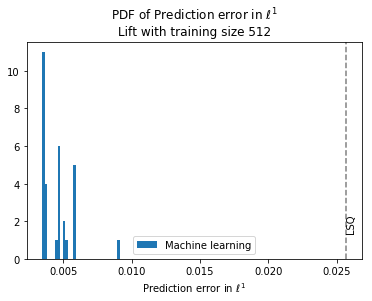

ML: Mean predictions l^2: 0.009107472615872967, var: 4.097247098072695e-06
LSQ: Mean predictions l^2: 0.04749571883375686, var: 4.333342374871281e-34


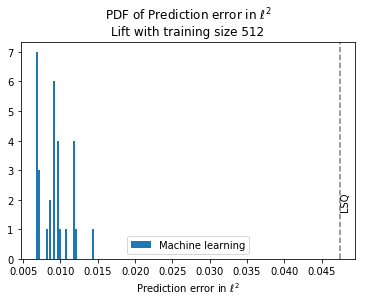

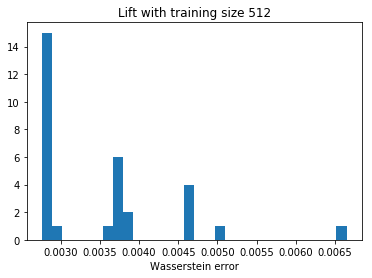

ML: Mean wasserstein_speedup: 0.0, var: 0.0
LSQ: Mean wasserstein_speedup: 0.0, var: 0.0


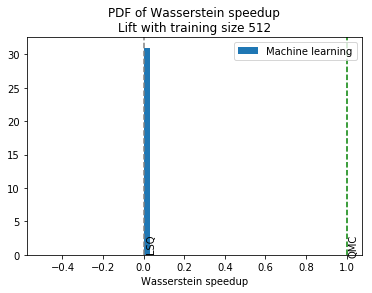

ML: Mean predictions l^1: 0.005901425379953808, var: 2.117409129066233e-06
LSQ: Mean predictions l^1: 0.025678798320487986, var: 1.925929944387236e-34


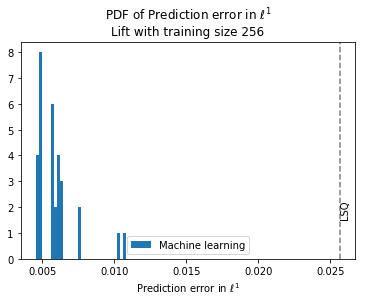

ML: Mean predictions l^2: 0.010236691211546595, var: 6.815023709381514e-06
LSQ: Mean predictions l^2: 0.038638348193264914, var: 4.333342374871281e-34


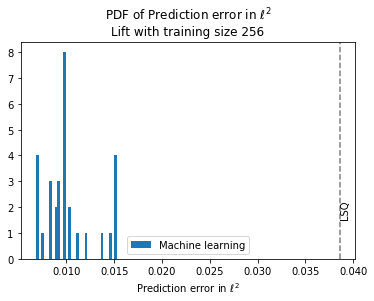

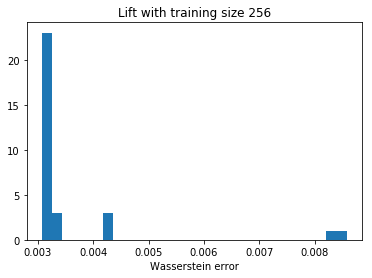

ML: Mean wasserstein_speedup: 0.9190804870189085, var: 0.027350757647742613
LSQ: Mean wasserstein_speedup: 0.4157132267118435, var: 4.930380657631324e-32


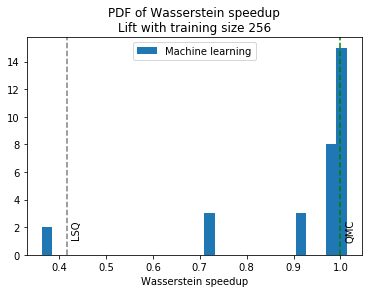

ML: Mean predictions l^1: 0.01112223381581809, var: 1.473148927310561e-05
LSQ: Mean predictions l^1: 0.025332113382483777, var: 0.0


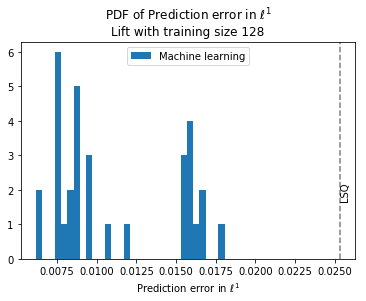

ML: Mean predictions l^2: 0.017561403536486202, var: 4.439381194146452e-05
LSQ: Mean predictions l^2: 0.035782240376129947, var: 0.0


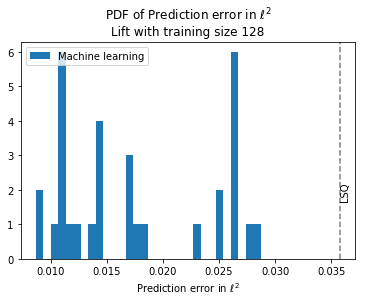

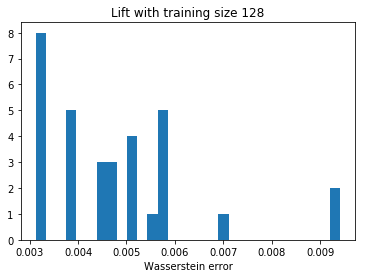

ML: Mean wasserstein_speedup: 1.4547246140261874, var: 0.148451777227942
LSQ: Mean wasserstein_speedup: 0.8498565523710995, var: 0.0


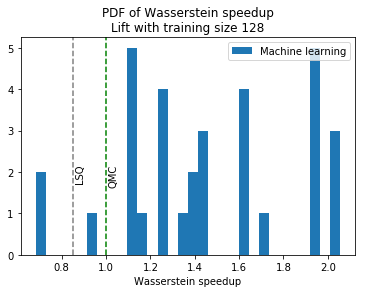

ML: Mean predictions l^1: 0.02266319116837799, var: 0.00011730690252652542
LSQ: Mean predictions l^1: 0.4033315146445155, var: 1.232595164407831e-32


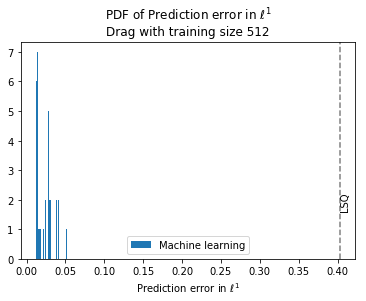

ML: Mean predictions l^2: 0.028558916659557836, var: 0.0001327333017928393
LSQ: Mean predictions l^2: 0.4607835161105666, var: 1.232595164407831e-32


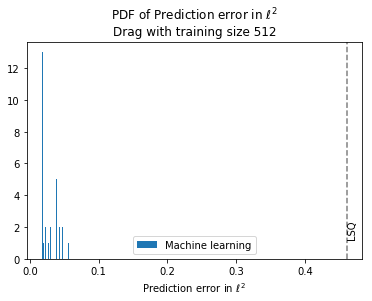

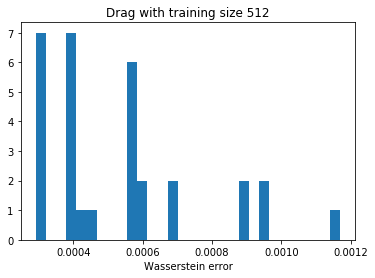

ML: Mean wasserstein_speedup: 0.0, var: 0.0
LSQ: Mean wasserstein_speedup: 0.0, var: 0.0


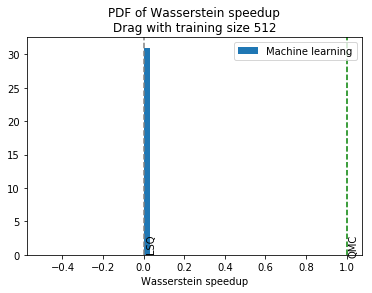

ML: Mean predictions l^1: 0.025569788210722578, var: 1.5849319148369045e-05
LSQ: Mean predictions l^1: 0.4036321158894033, var: 1.232595164407831e-32


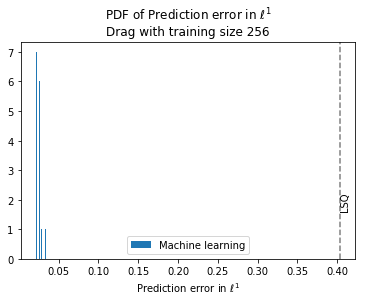

ML: Mean predictions l^2: 0.02648494573701266, var: 1.3450201600343276e-05
LSQ: Mean predictions l^2: 0.3737828583605355, var: 2.7733391199176196e-32


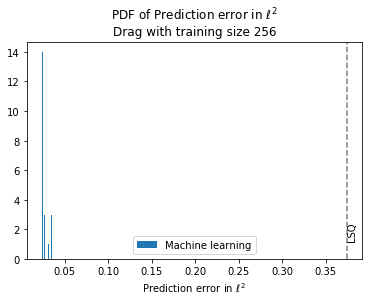

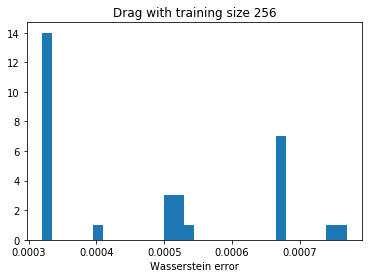

ML: Mean wasserstein_speedup: 1.132790522783166, var: 0.12225472330880822
LSQ: Mean wasserstein_speedup: 0.0519475224018162, var: 4.81482486096809e-35


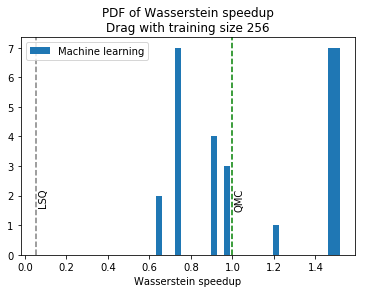

ML: Mean predictions l^1: 0.043253392791826384, var: 0.0002116731210456781
LSQ: Mean predictions l^1: 0.4046406595419678, var: 0.0


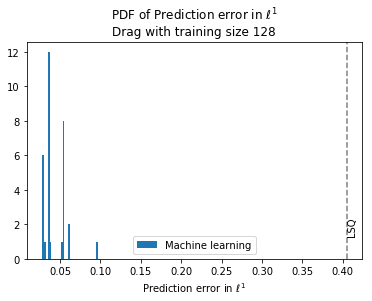

ML: Mean predictions l^2: 0.042809789160736876, var: 0.00018849366717380578
LSQ: Mean predictions l^2: 0.3469202320345292, var: 0.0


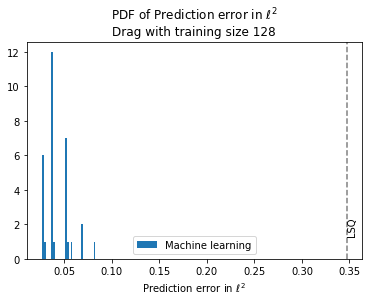

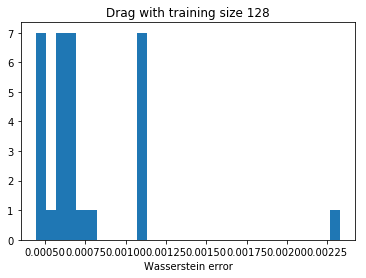

ML: Mean wasserstein_speedup: 1.6880586516185627, var: 0.29347775815888394
LSQ: Mean wasserstein_speedup: 0.11689593027092204, var: 0.0


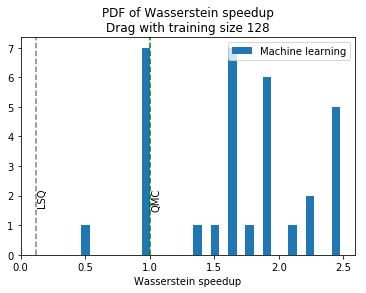

In [113]:
bins=30
for func in functional_names:
    plot_info.display(plot_info.HTML("<h1>%s</h1>" % func))
    for training_size in all_prediction_l1_errors_training_size.keys():
        plot_info.display(plot_info.HTML("<h2>Training size: %d</h2>" % training_size))
        
        
        predictions_l1 = all_prediction_l1_errors_training_size[training_size][func]
        lsq_predictions_l1 = lsq_prediction_errors_l1[training_size][func]
        print("ML: Mean predictions l^1: {}, var: {}".format(np.mean(predictions_l1), np.var(predictions_l1)))
        print("LSQ: Mean predictions l^1: {}, var: {}".format(np.mean(lsq_predictions_l1), np.var(lsq_predictions_l1)))
        plt.hist(predictions_l1, bins=bins, label="Machine learning")
        #plt.hist(lsq_predictions_l1, bins=10, alpha=0.5, label="Least squares")
        plt.axvline(x=np.mean(lsq_predictions_l1), linestyle='--',color='grey')
        plt.text(np.mean(lsq_predictions_l1),2,'LSQ',rotation=90)
        plt.legend()
        plt.title("PDF of Prediction error in $\\ell^1$\n{func} with training size {train_size}".format(func=func, train_size=training_size))
        
        plt.xlabel("Prediction error in $\\ell^1$")
        plt.show()
        
        
        predictions_l2 = all_prediction_l2_errors_training_size[training_size][func]
        lsq_predictions_l2 = lsq_prediction_errors_l2[training_size][func]
        print("ML: Mean predictions l^2: {}, var: {}".format(np.mean(predictions_l2), np.var(predictions_l2)))
        print("LSQ: Mean predictions l^2: {}, var: {}".format(np.mean(lsq_predictions_l2), np.var(lsq_predictions_l2)))
        plt.hist(predictions_l2, bins=bins, label="Machine learning")
        plt.axvline(x=np.mean(lsq_predictions_l2), linestyle='--',color='grey')
        plt.text(np.mean(lsq_predictions_l2),2,'LSQ',rotation=90)
        plt.legend()
        plt.title("PDF of Prediction error in $\\ell^2$\n{func} with training size {train_size}".format(func=func, train_size=training_size))
        
        plt.xlabel("Prediction error in $\\ell^2$")
        plt.show()
        
        
        predictions_wasserstein = all_wasserstein_errors_training_size[training_size][func]
        plt.hist(predictions_wasserstein, bins=bins)
        plt.title("{func} with training size {train_size}".format(func=func, train_size=training_size))
        plt.xlabel("Wasserstein error")
        plt.show()
        
        
        
        wasserstein_speedup = all_wasserstein_speedups_training_size[training_size][func]
        lsq_wasserstein_speedup = lsq_wasserstein_speedups_training_size[training_size][func]
        print("ML: Mean wasserstein_speedup: {}, var: {}".format(np.mean(wasserstein_speedup), np.var(wasserstein_speedup)))
        print("LSQ: Mean wasserstein_speedup: {}, var: {}".format(np.mean(lsq_wasserstein_speedup), np.var(lsq_wasserstein_speedup)))
        plt.hist(wasserstein_speedup, bins=bins, label="Machine learning")
        plt.axvline(x=np.mean(lsq_wasserstein_speedup), linestyle='--',color='grey')
        plt.text(np.mean(lsq_wasserstein_speedup)+0.01,2,'LSQ',rotation=90)
        
        plt.axvline(x=1, linestyle='--',color='green')
        plt.text(1.01 ,2,'QMC',rotation=90)
        
        plt.legend()
        plt.title("PDF of Wasserstein speedup\n{func} with training size {train_size}".format(func=func, train_size=training_size))
        
        plt.xlabel("Wasserstein speedup")
        plt.show()

    

In [ ]:

def plot_histograms(predictions_l1, lsq_predictions_l1, predictions_l2,lsq_predictions_l2,
                   wasserstein_speedup, lsq_wasserstein_speedup, predictions_wasserstein,
                   func, training_size, extra_title):

    bins=40
 
    plt.figure(figsize=(8*3,6))
    plt.subplot(1,3,1)
    #print("ML: Mean predictions l^1: {}, var: {}".format(np.mean(predictions_l1), np.var(predictions_l1)))
    #print("LSQ: Mean predictions l^1: {}, var: {}".format(np.mean(lsq_predictions_l1), np.var(lsq_predictions_l1)))
    plt.hist(predictions_l1, bins=bins, label="Machine learning")
    #plt.hist(lsq_predictions_l1, bins=10, alpha=0.5, label="Least squares")
    plt.axvline(x=np.mean(lsq_predictions_l1), linestyle='--',color='grey')
    plt.text(np.mean(lsq_predictions_l1),2,'LSQ',rotation=90)
    plt.legend()
    plt.title("PDF of Prediction error in $\\ell^1$\n{func} with training size {train_size}\n{extra_title}".format(func=func, train_size=training_size, extra_title=extra_title))
    
    plt.xlabel("Prediction error in $\\ell^1$")
    

    plt.subplot(1,3,2)
    lsq_predictions_l2 = lsq_prediction_errors_l2[training_size][func]
    #print("ML: Mean predictions l^2: {}, var: {}".format(np.mean(predictions_l2), np.var(predictions_l2)))
    #print("LSQ: Mean predictions l^2: {}, var: {}".format(np.mean(lsq_predictions_l2), np.var(lsq_predictions_l2)))
    plt.hist(predictions_l2, bins=bins, label="Machine learning")
    plt.axvline(x=np.mean(lsq_predictions_l2), linestyle='--',color='grey')
    plt.text(np.mean(lsq_predictions_l2),2,'LSQ',rotation=90)
    plt.legend()
    plt.title("PDF of Prediction error in $\\ell^2$\n{func} with training size {train_size}\n{extra_title}".format(func=func, train_size=training_size, extra_title=extra_title))
    
    plt.xlabel("Prediction error in $\\ell^2$")

    #plt.subplot(1,3,3)
    #plt.hist(predictions_wasserstein, bins=bins)
    #plt.title("{func} with training size {train_size}\n{extra_title}".format(func=func, train_size=training_size, extra_title=extra_title))
    #plt.xlabel("Wasserstein error")

    
    
    
    plt.subplot(1,3,3)
    #print("ML: Mean wasserstein_speedup: {}, var: {}".format(np.mean(wasserstein_speedup), np.var(wasserstein_speedup)))
    #print("LSQ: Mean wasserstein_speedup: {}, var: {}".format(np.mean(lsq_wasserstein_speedup), np.var(lsq_wasserstein_speedup)))
    plt.hist(wasserstein_speedup, bins=bins, label="Machine learning")
    plt.axvline(x=np.mean(lsq_wasserstein_speedup), linestyle='--',color='grey')
    plt.text(np.mean(lsq_wasserstein_speedup)+0.01,2,'LSQ',rotation=90)
    
    plt.axvline(x=1, linestyle='--',color='green')
    plt.text(1.01 ,2,'QMC',rotation=90)
    
    plt.legend()
    plt.title("PDF of Wasserstein speedup\n{func} with training size {train_size}\n{extra_title}".format(func=func, train_size=training_size, extra_title=extra_title))
    
    plt.xlabel("Wasserstein speedup")
    plt.tight_layout()
    plt.show()

    
    

# Fixing one parameter at a time

optimizer fixed to: SGD


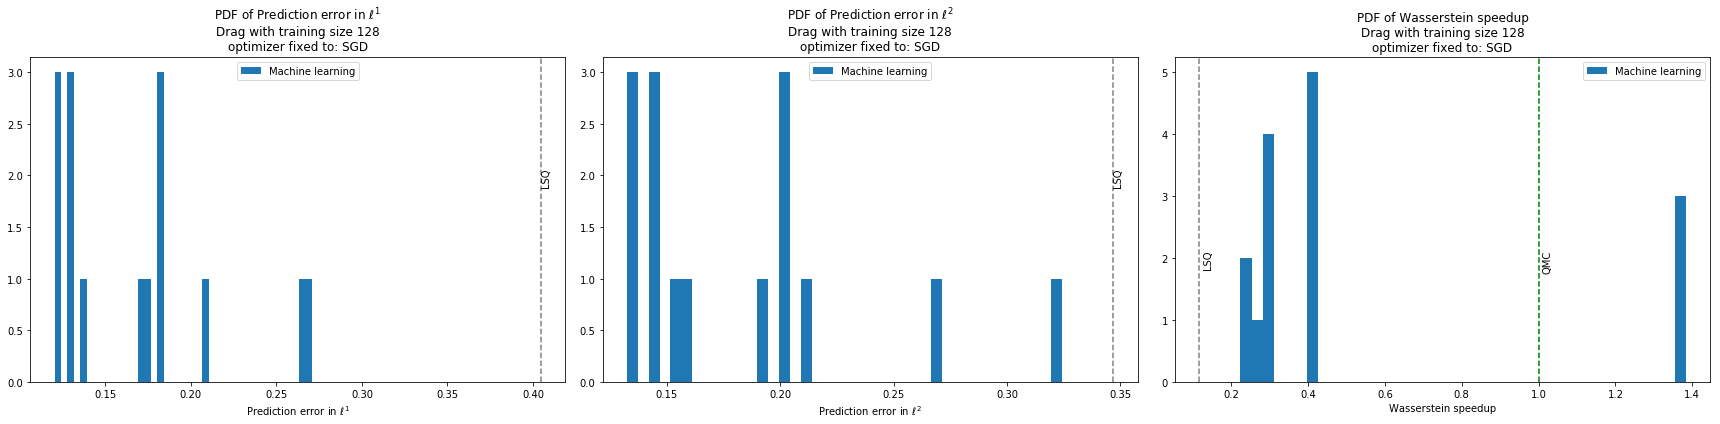

optimizer fixed to: Adam


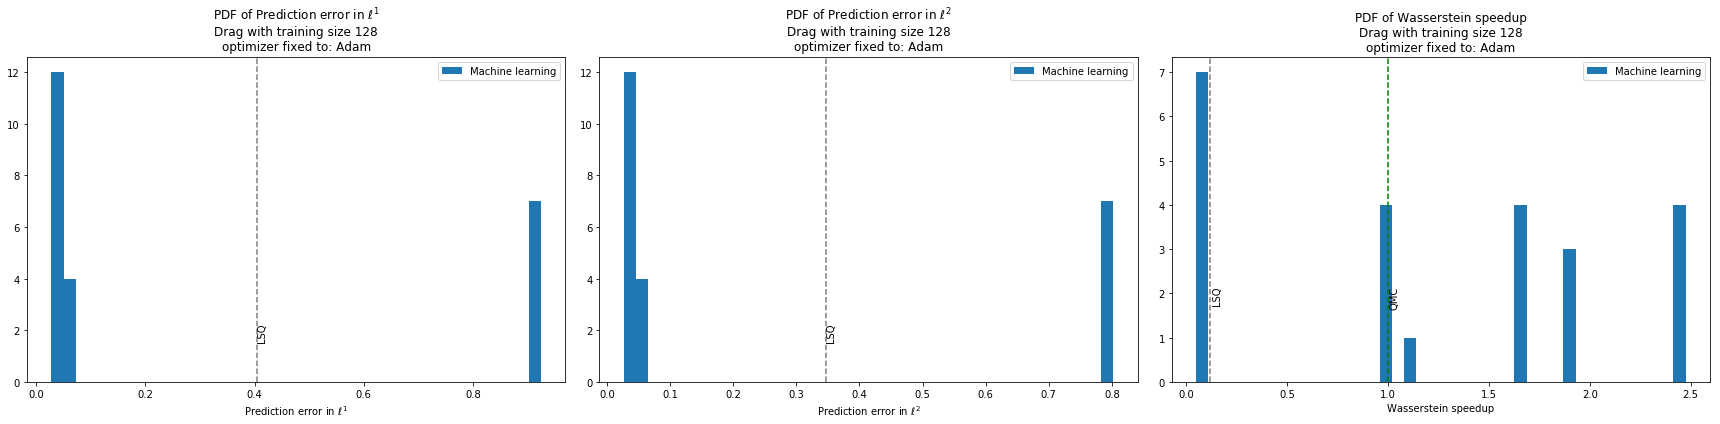

l2
regularizer fixed to: None


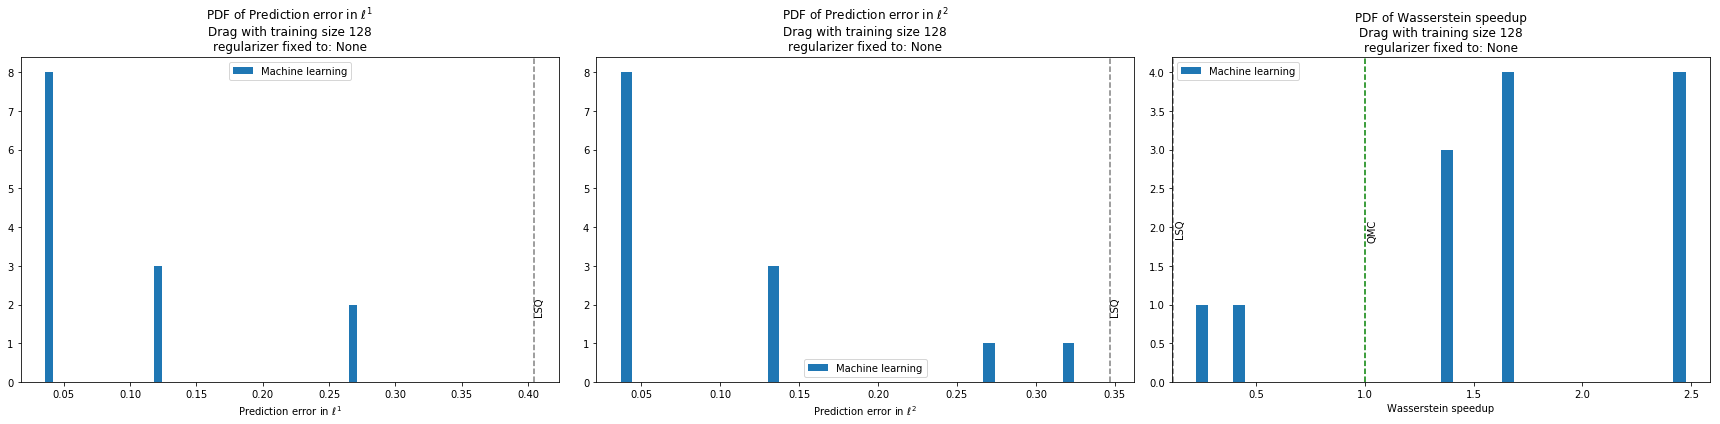

l1


loss fixed to: mean_squared_error


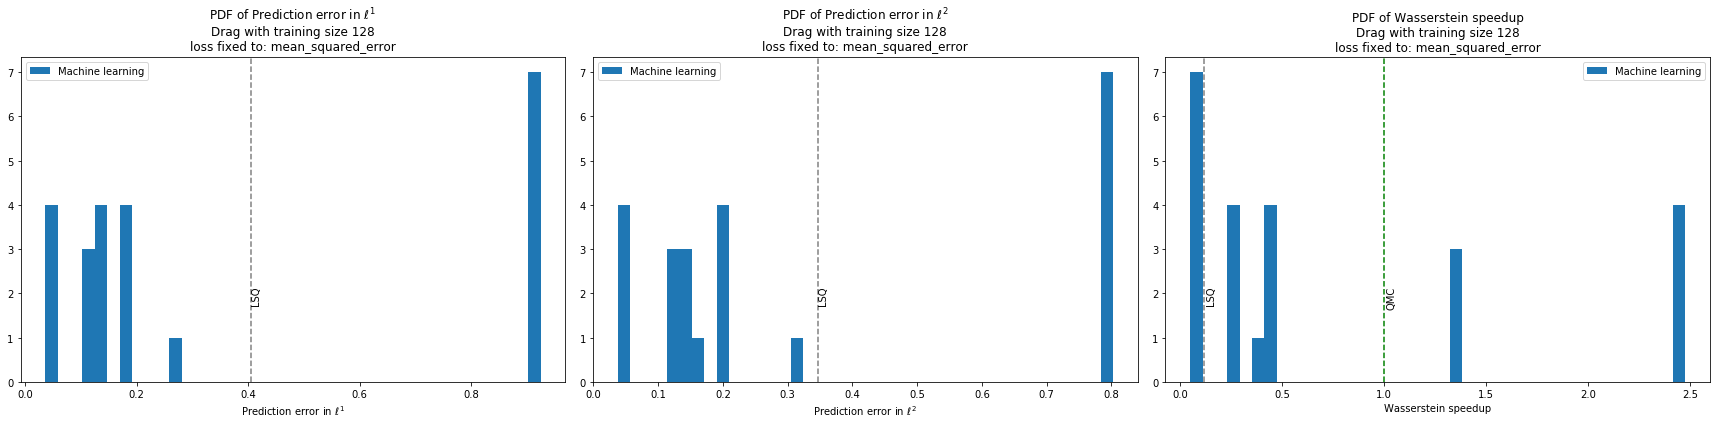

loss fixed to: mean_absolute_error


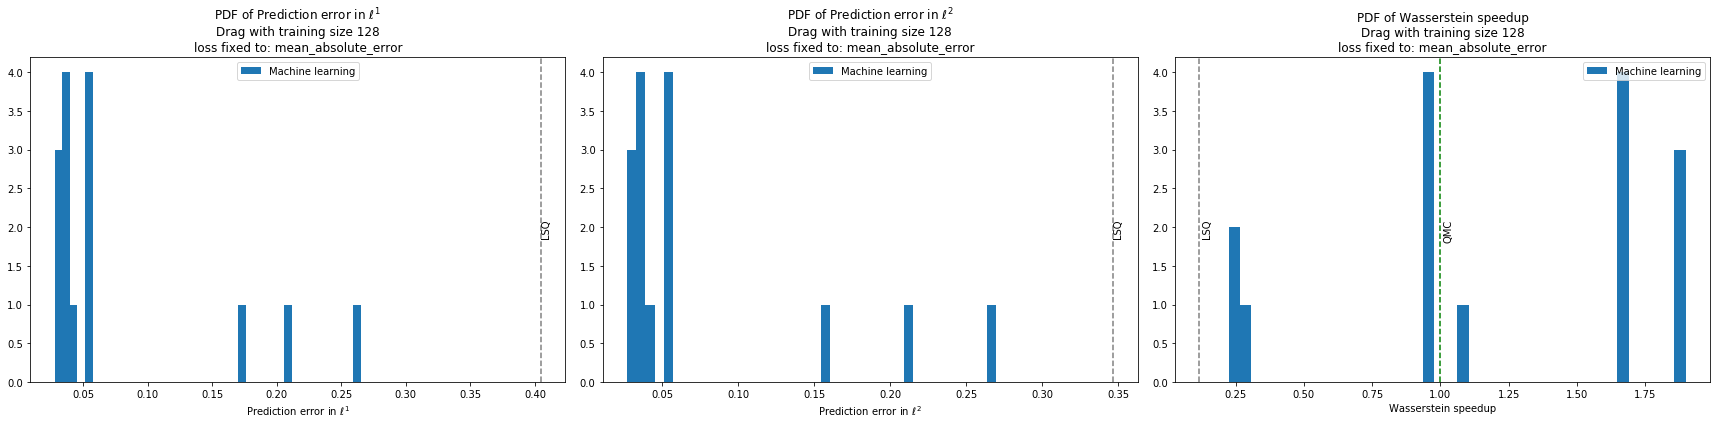

optimizer fixed to: SGD


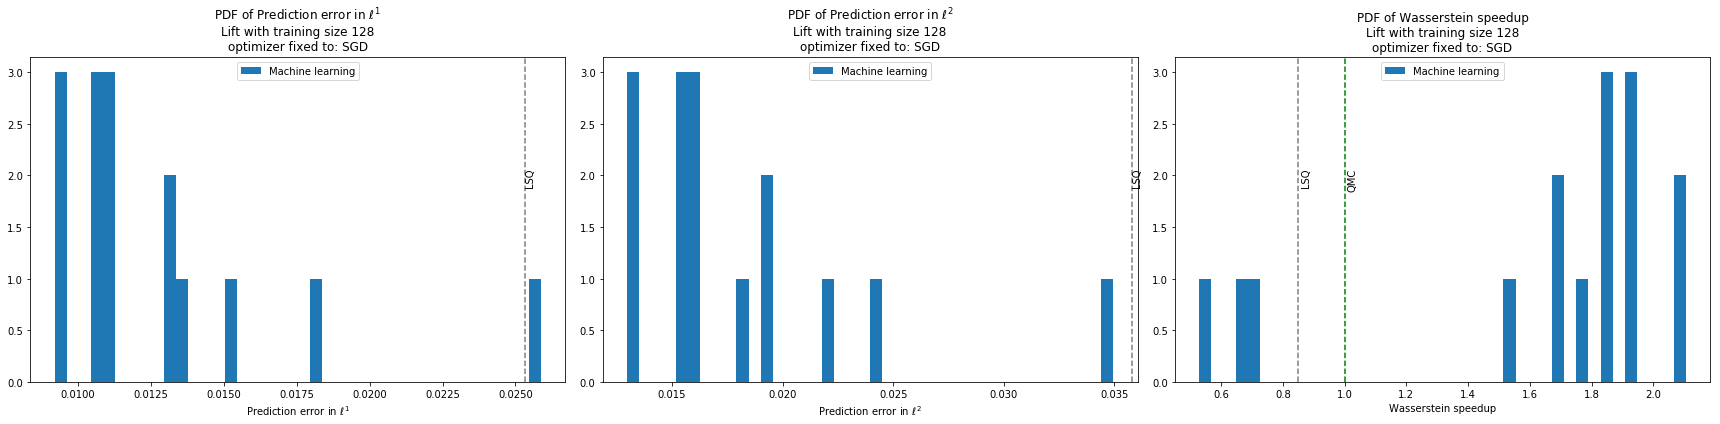

optimizer fixed to: Adam


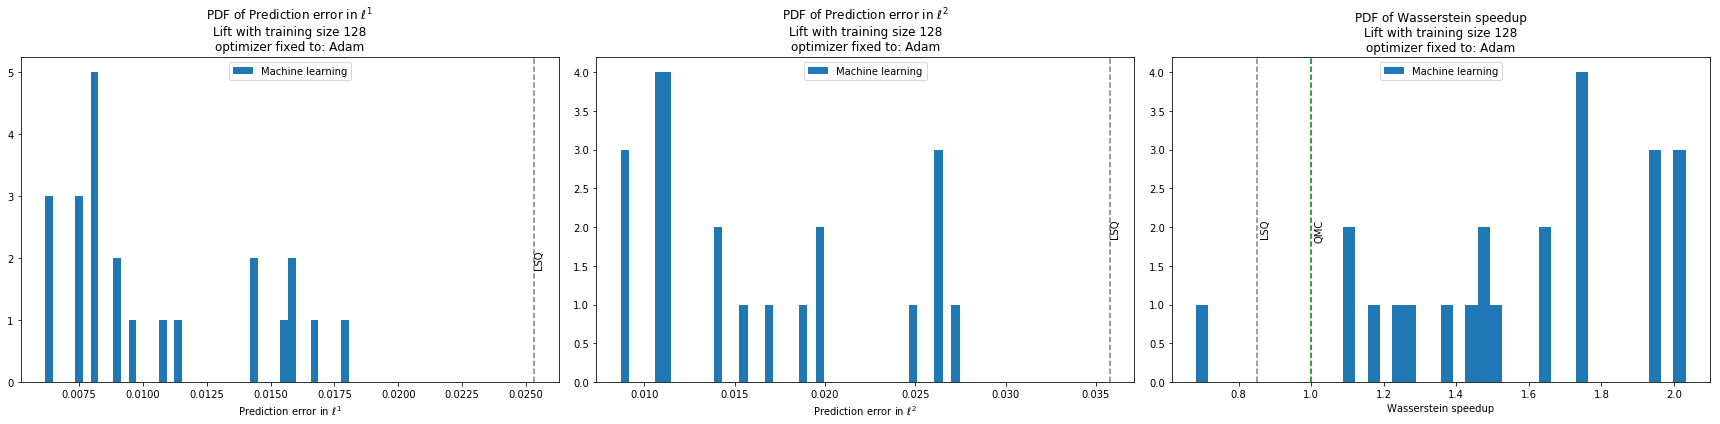

l2
regularizer fixed to: None


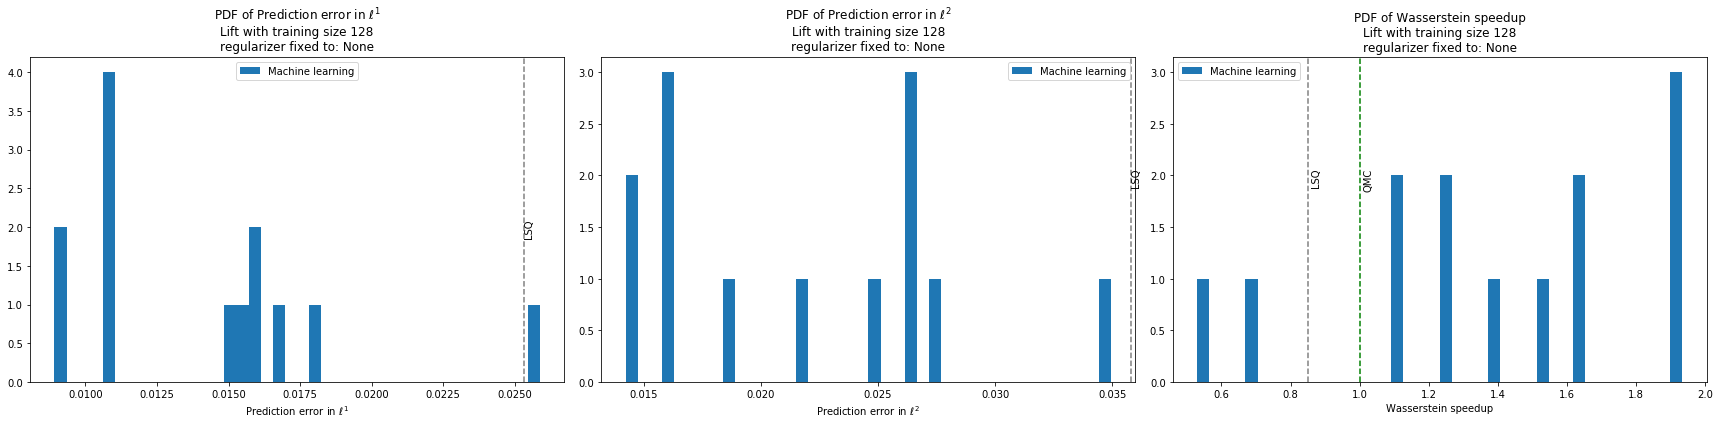

l1


loss fixed to: mean_squared_error


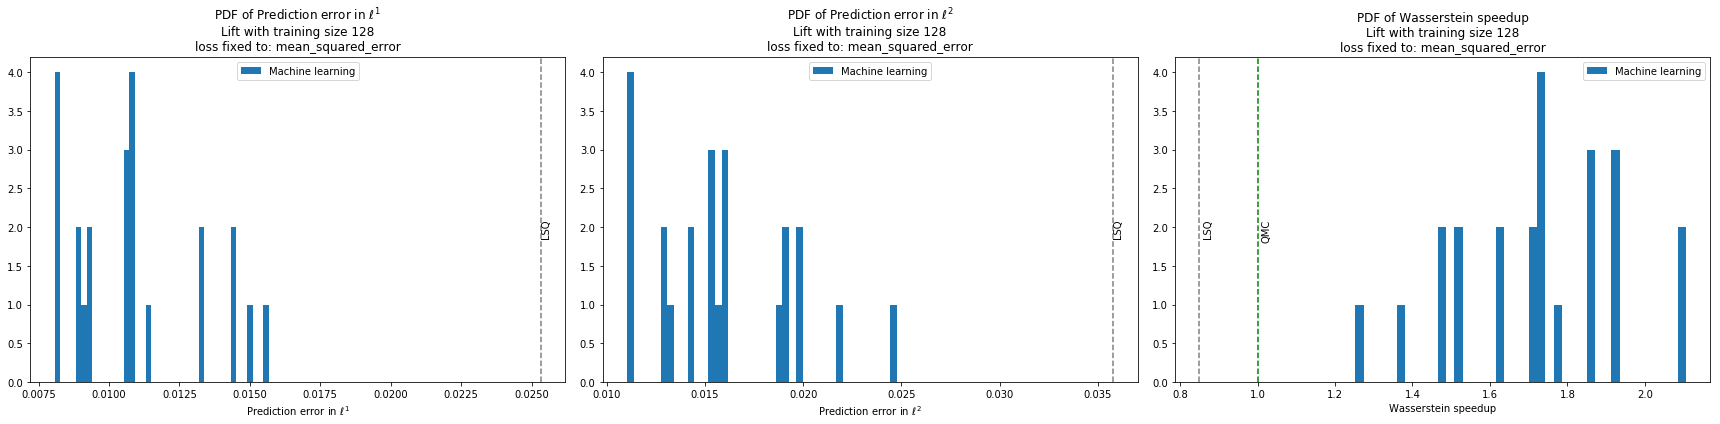

loss fixed to: mean_absolute_error


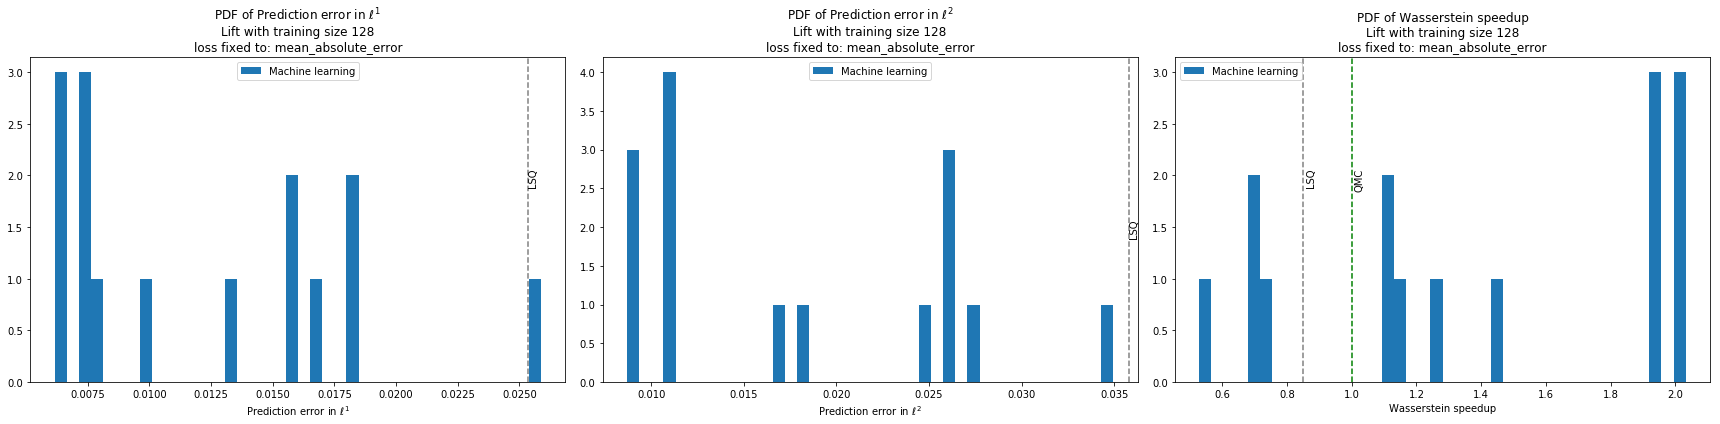

optimizer fixed to: SGD


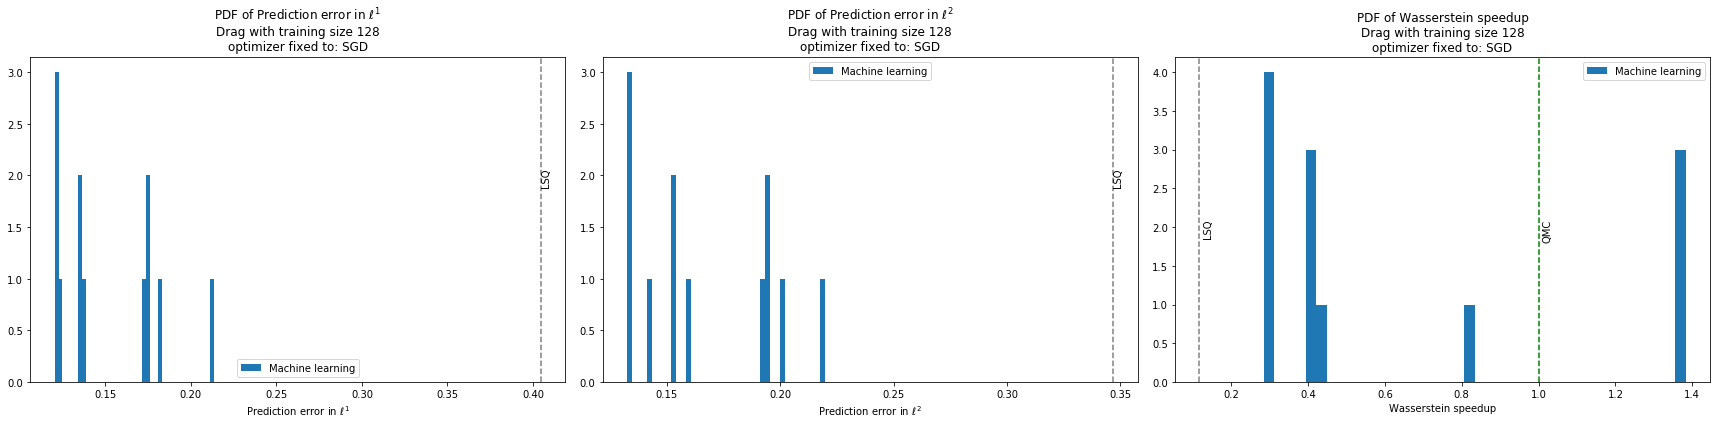

optimizer fixed to: Adam


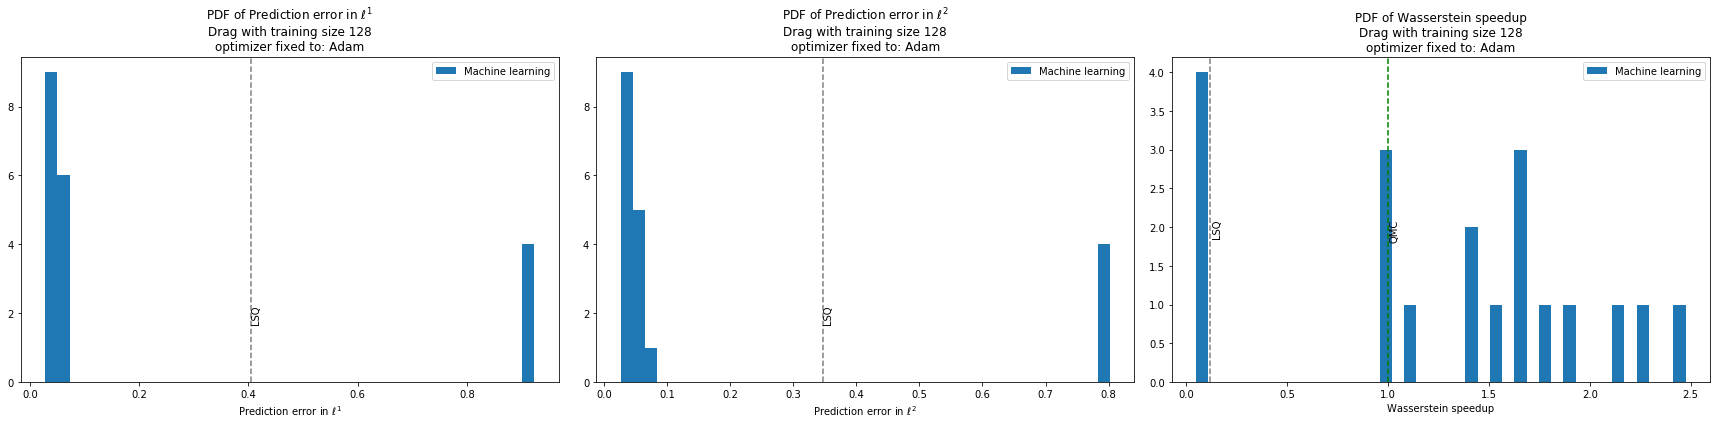

l2
regularizer fixed to: None


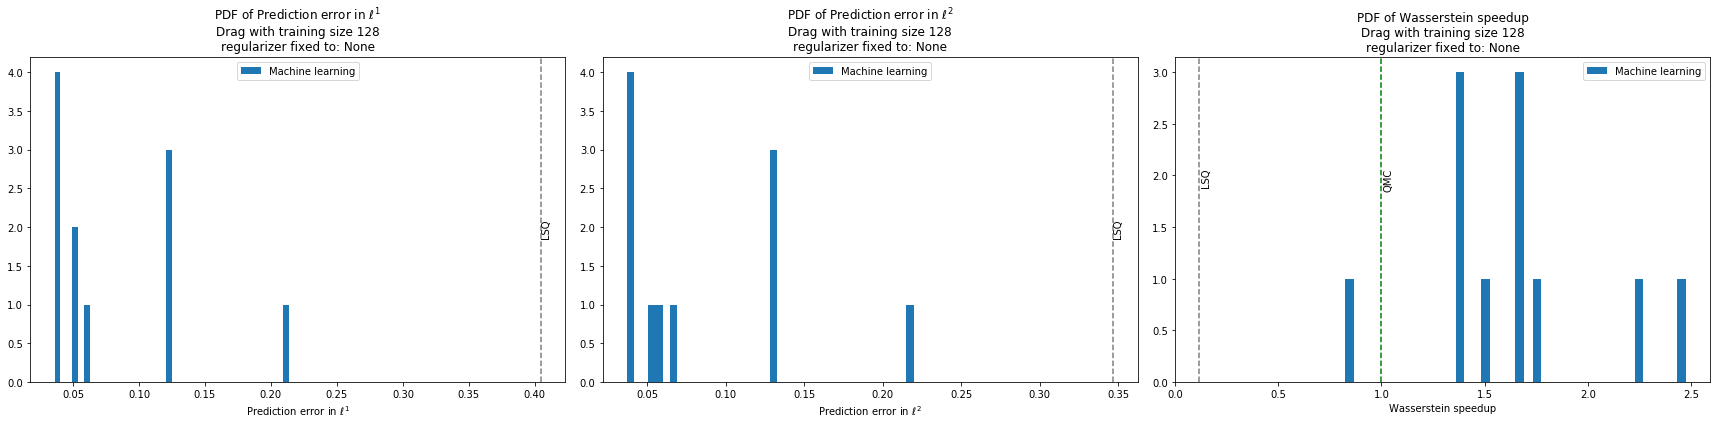

l1


loss fixed to: mean_squared_error


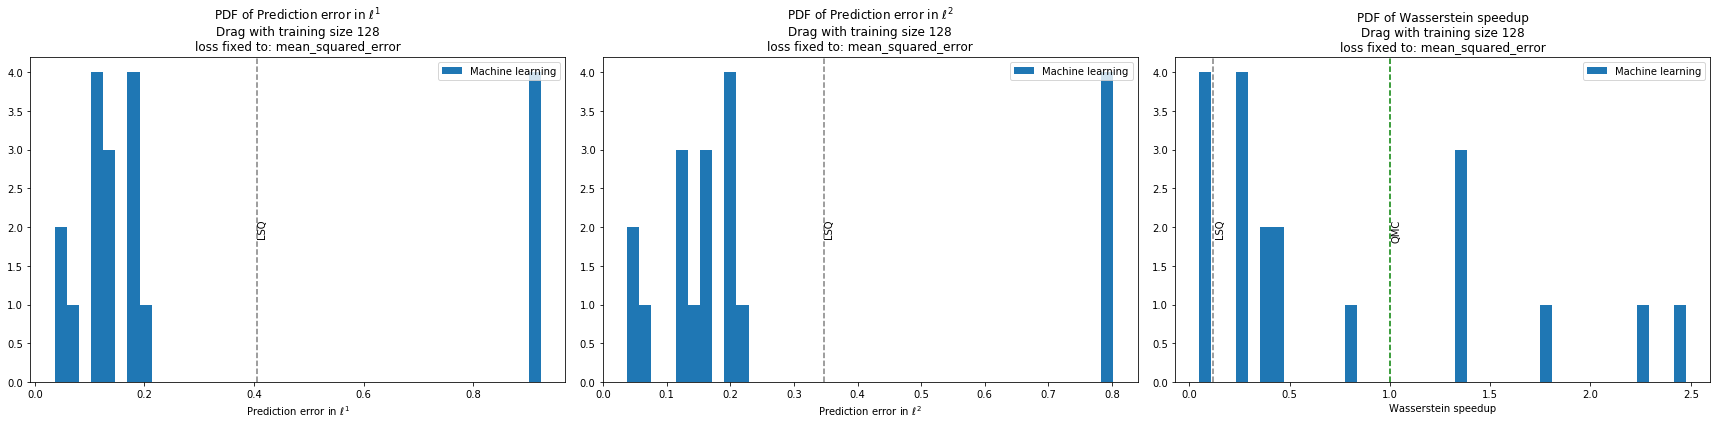

loss fixed to: mean_absolute_error


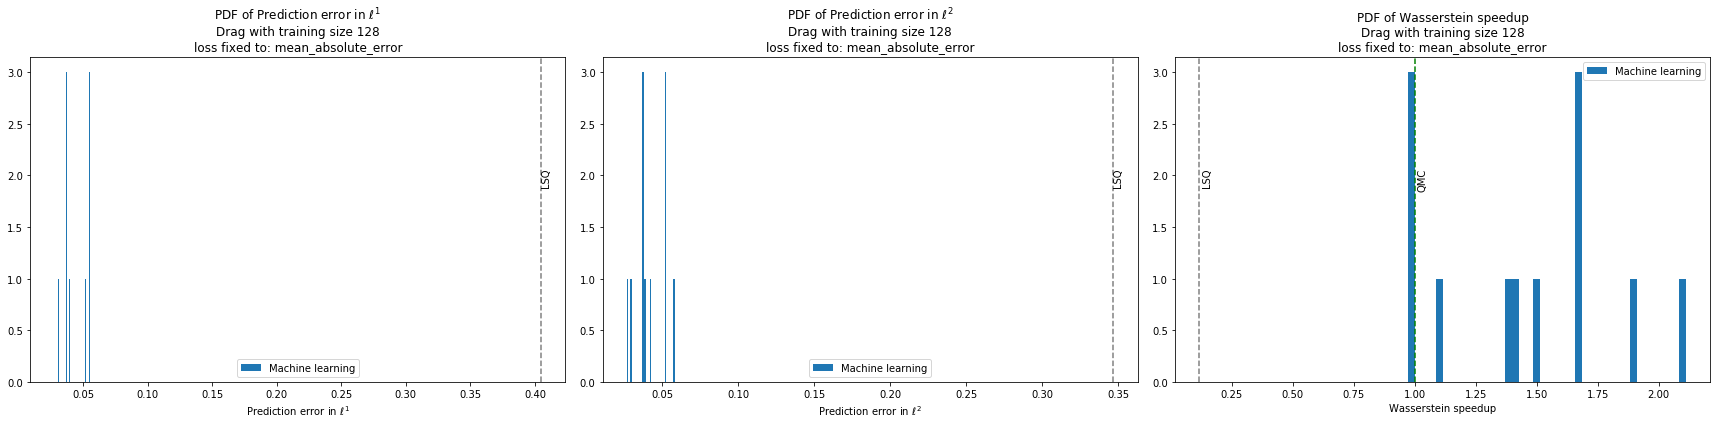

optimizer fixed to: SGD


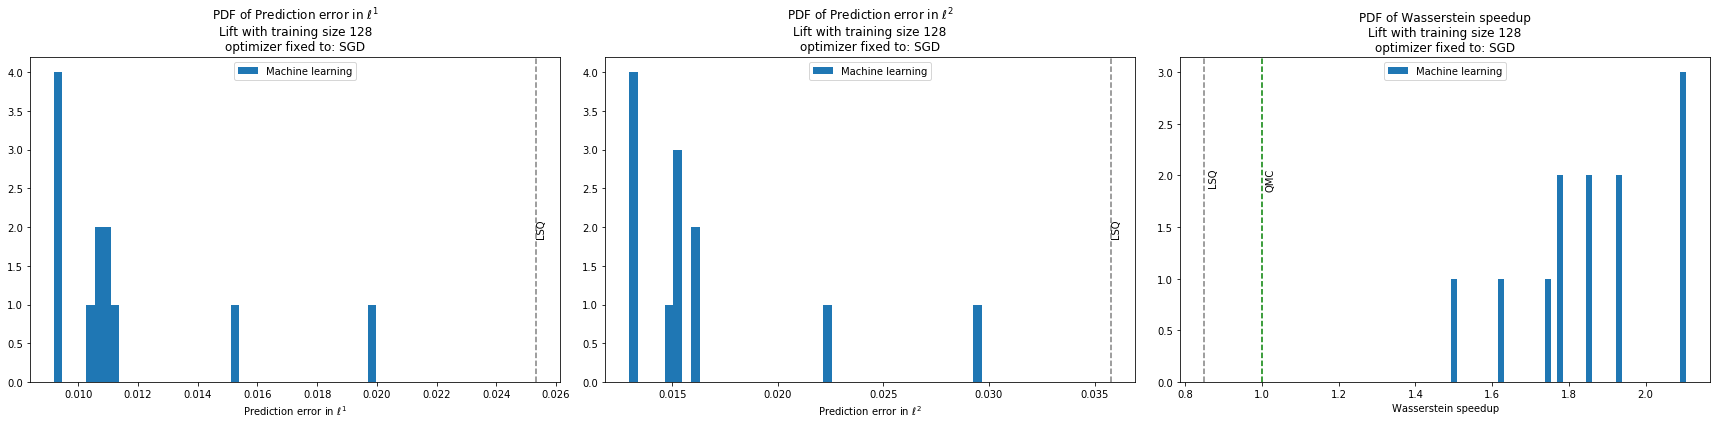

optimizer fixed to: Adam


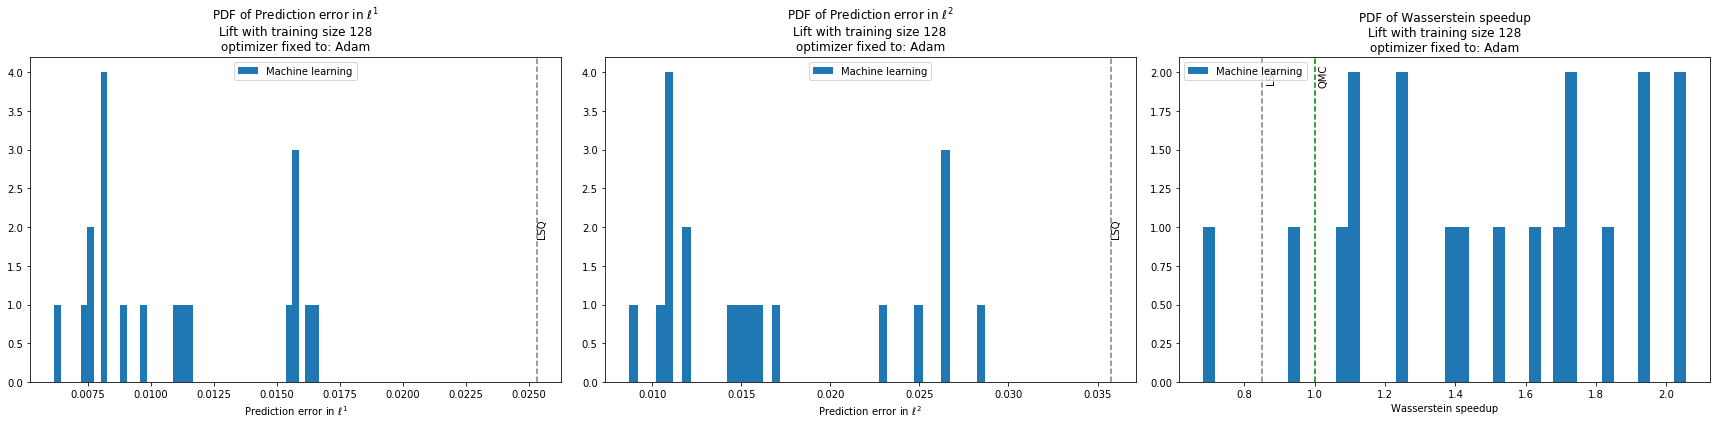

l2
regularizer fixed to: None


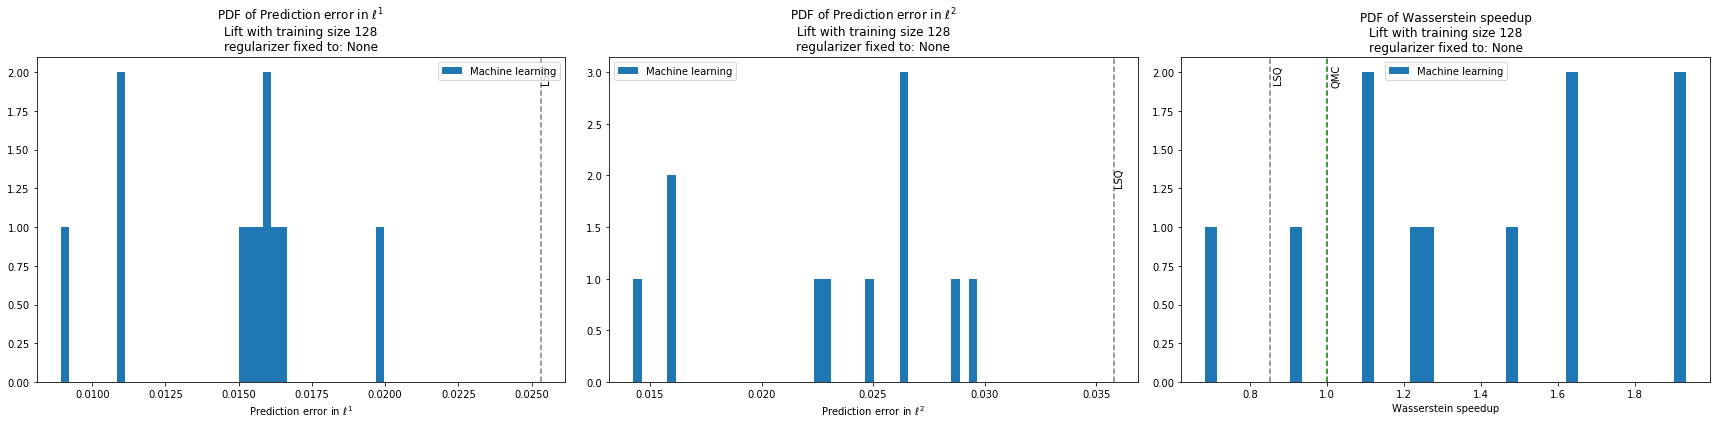

l1


loss fixed to: mean_squared_error


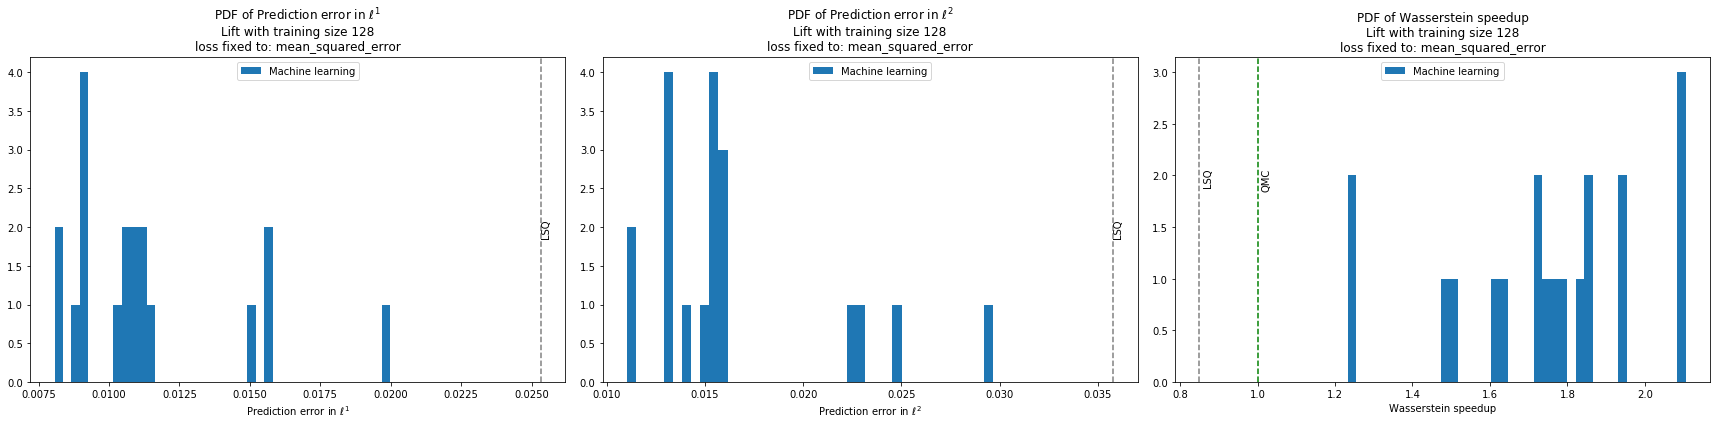

loss fixed to: mean_absolute_error


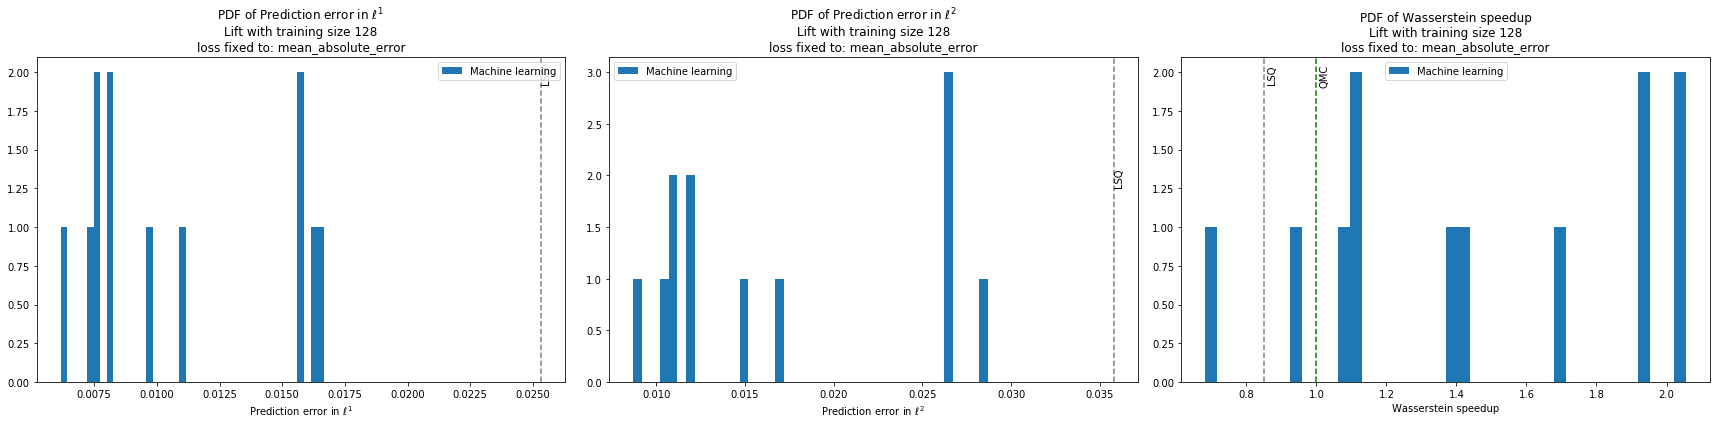

In [25]:
fixed_parameters = ['optimizer', 'regularizer', 'loss']
for selection_type in all_configs['selection_type']:
    plot_info.display(plot_info.HTML("<h1>{}</h1>".format(selection_type)))
    for training_size in all_prediction_l1_errors_training_size.keys():
        if training_size > 128:
            continue
        plot_info.display(plot_info.HTML("<h2>Train size: {}</h2>".format(training_size)))
        for func in functional_names:
            plot_info.display(plot_info.HTML("<h3>{}</h3>".format(func)))
           
            for fixed_parameter in fixed_parameters:
                plot_info.display(plot_info.HTML("<h4>Fixing: {}</h4>".format(fixed_parameter)))
                

                for parameter in all_configs[fixed_parameter]:
                    measurements_local = []
                    predictions_l1 = []
                    predictions_l2 = []
                    wasserstein_speedup = []
                    wasserstein_errors = []
                    
                    lsq_predictions_l1 = lsq_prediction_errors_l1[training_size][func]
                    lsq_predictions_l2 = lsq_prediction_errors_l2[training_size][func]
                    lsq_wasserstein_speedup = lsq_wasserstein_speedups_training_size[training_size][func]
                    
                    for m in measurements[func]:
                        if m.properties[fixed_parameter] == parameter:
                            if m.properties['selection_type'] == selection_type:
                                if m.properties['train_size'] == training_size:
                                    measurements_local.append(m)
                    if len(measurements_local) == 0:
                        print(parameter)
                        continue
                    for m in measurements_local:
                        predictions_l1.append(m.prediction_error_l1)
                        predictions_l2.append(m.prediction_error_l2)
                        wasserstein_speedup.append(m.wasserstein_speedup)
                        wasserstein_errors.append(m.wasserstein_error)
                        
                    extra_title = "{} fixed to: {}".format(fixed_parameter, parameter)
                    print(extra_title)
                    plot_histograms(predictions_l1, lsq_predictions_l1, predictions_l2,lsq_predictions_l2,
                       wasserstein_speedup, lsq_wasserstein_speedup, wasserstein_errors,
                       func, training_size, 
                                   extra_title)
                

# Fixing both optimizer and regularizer at the same time

Optimizer: SGD, Regularizer: l2


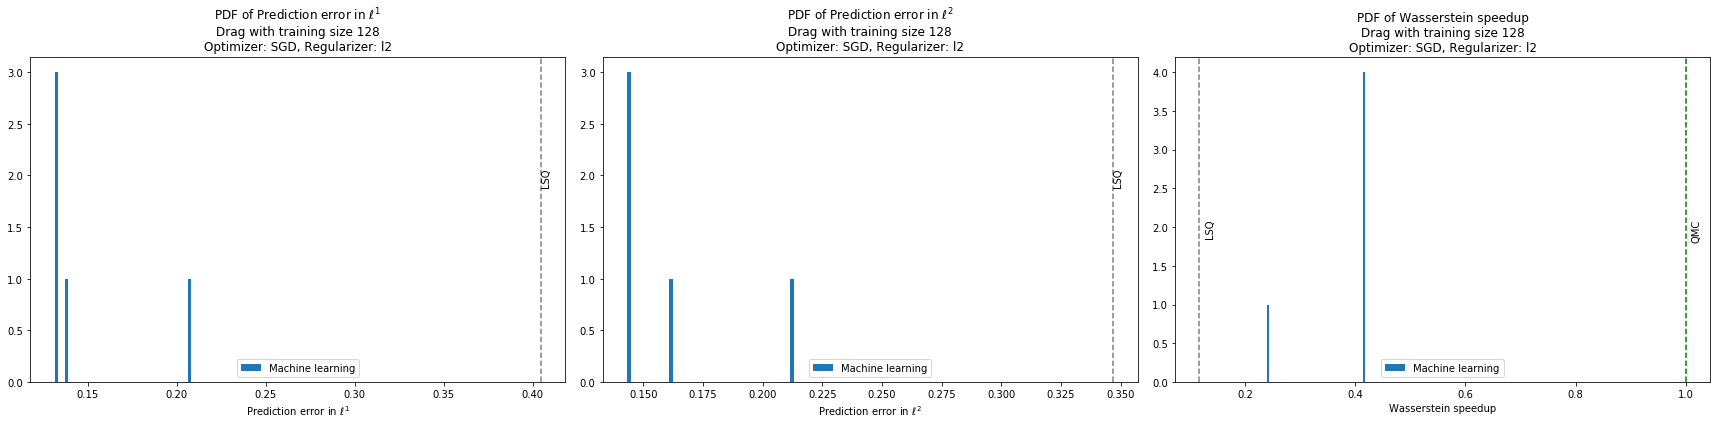

Optimizer: Adam, Regularizer: l2


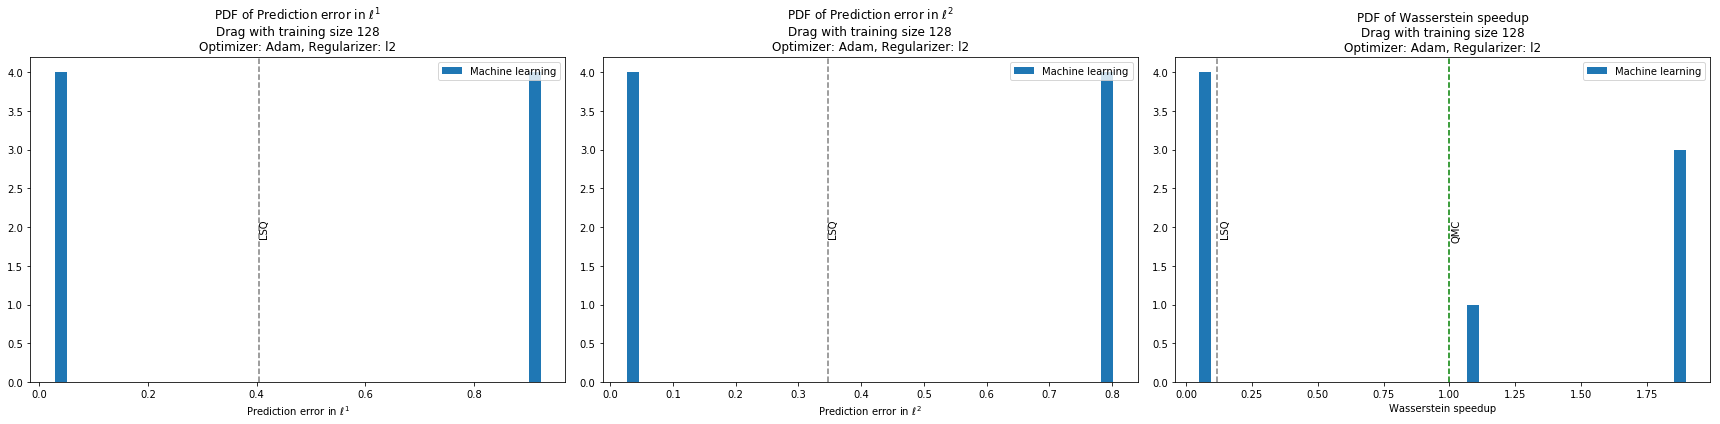

Optimizer: SGD, Regularizer: None


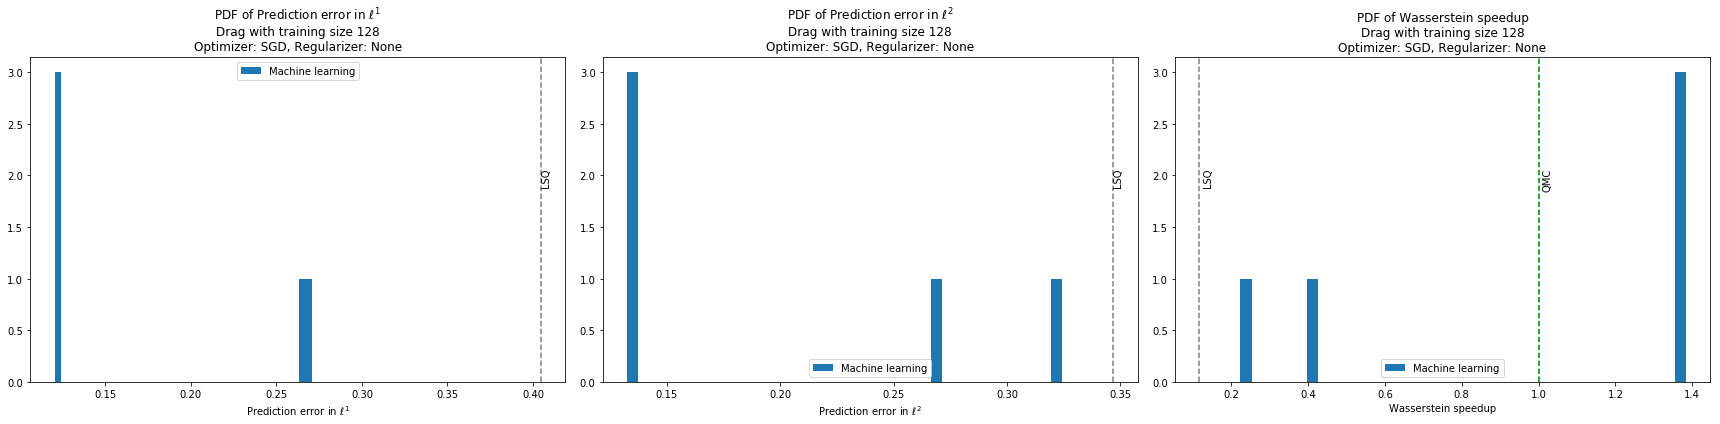

Optimizer: Adam, Regularizer: None


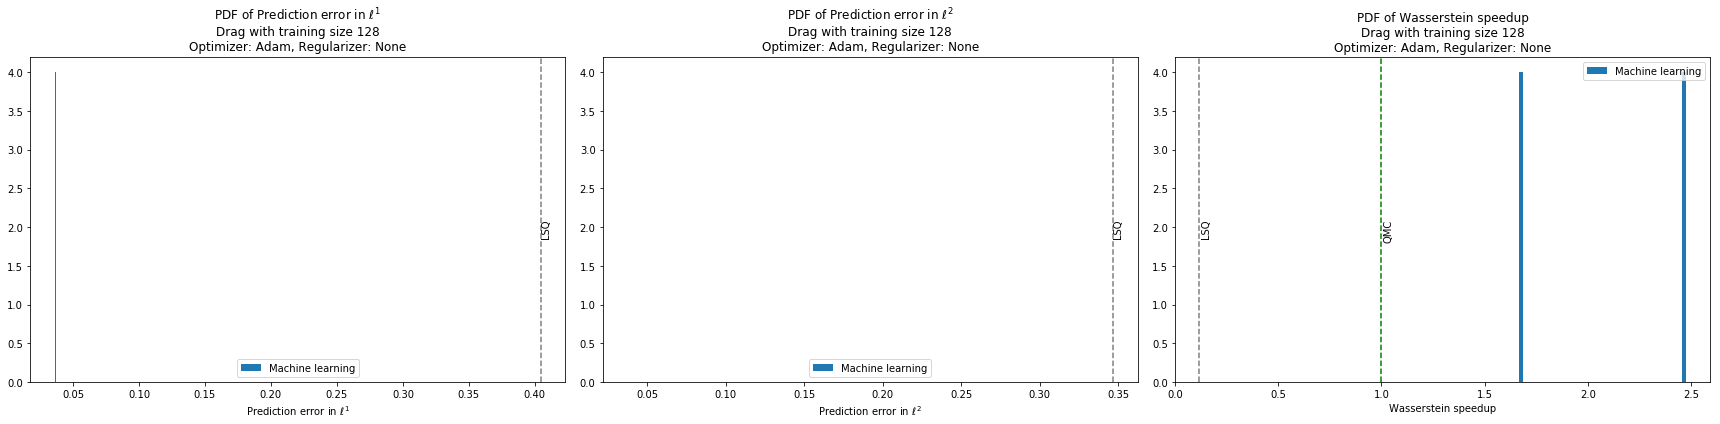

Optimizer: SGD, Regularizer: l1


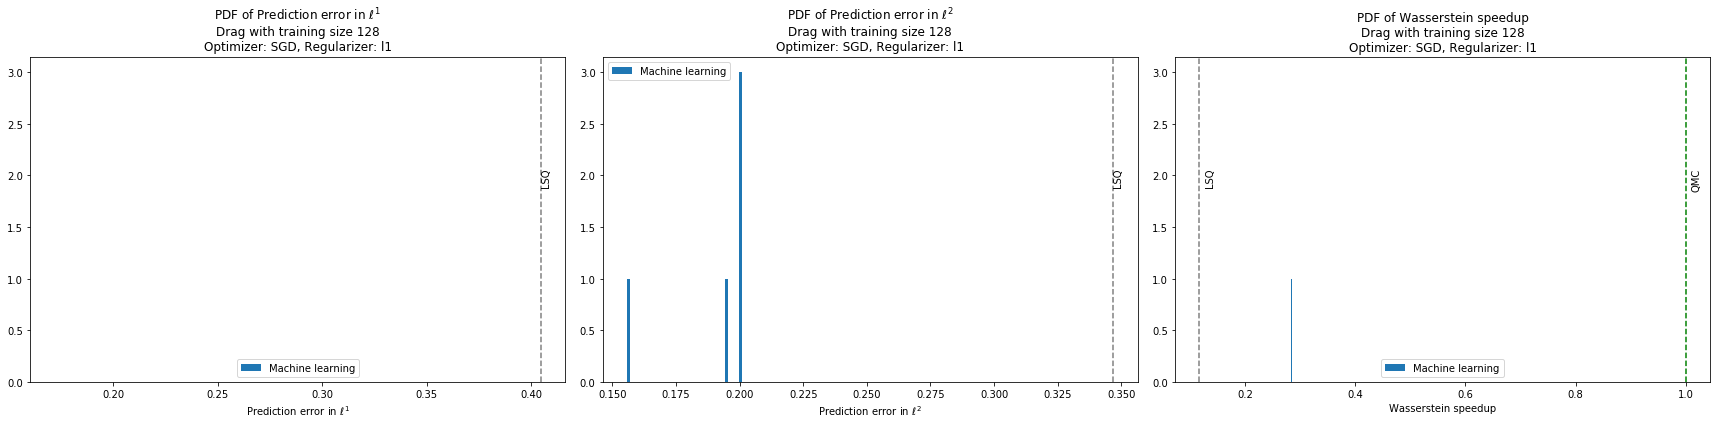

Optimizer: Adam, Regularizer: l1


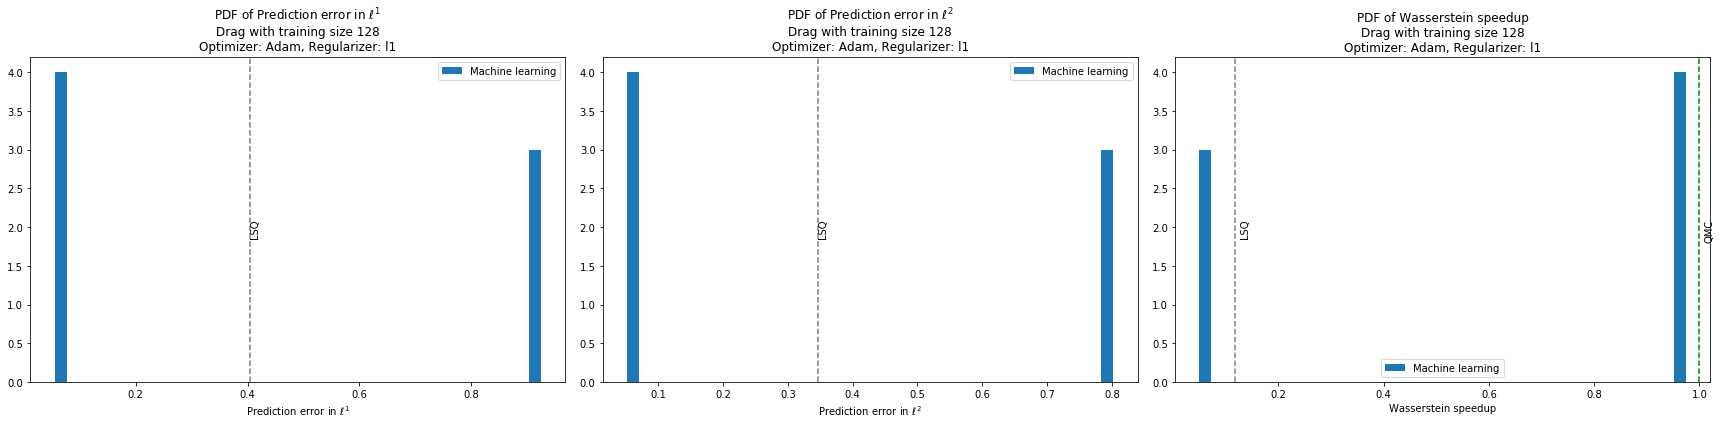

Optimizer: SGD, Regularizer: l2


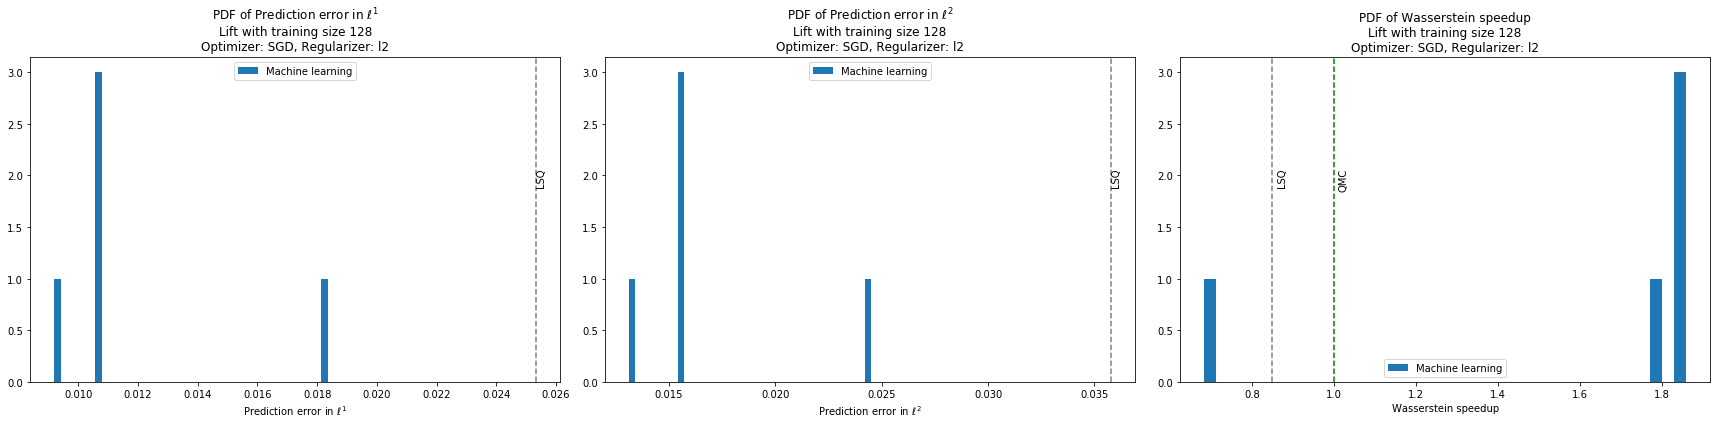

Optimizer: Adam, Regularizer: l2


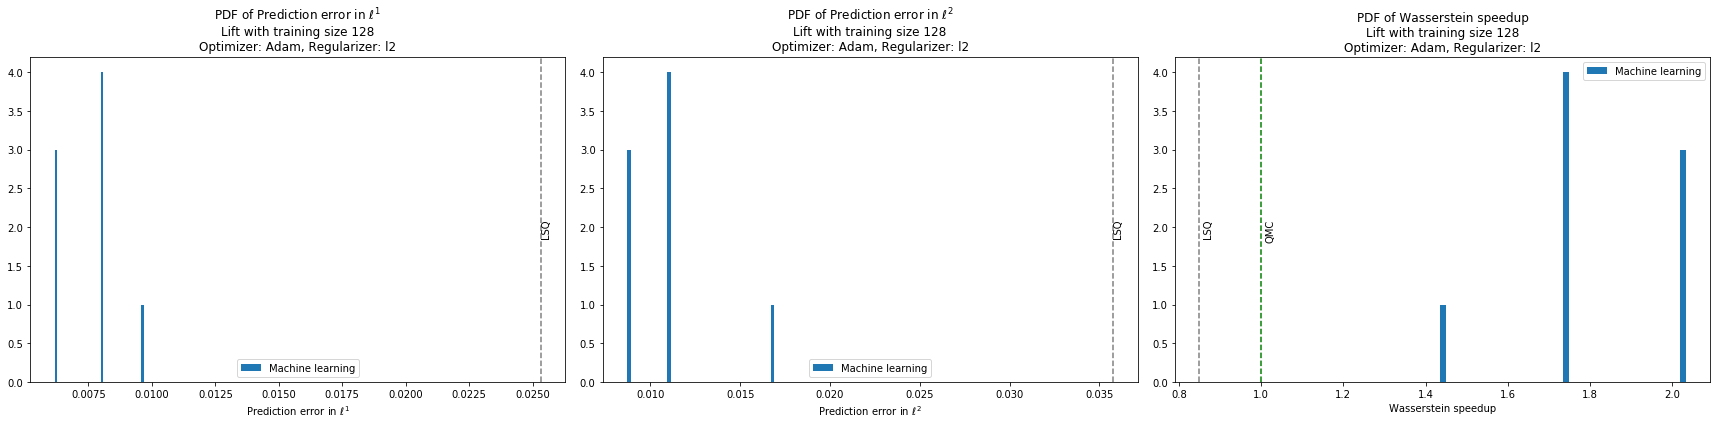

Optimizer: SGD, Regularizer: None


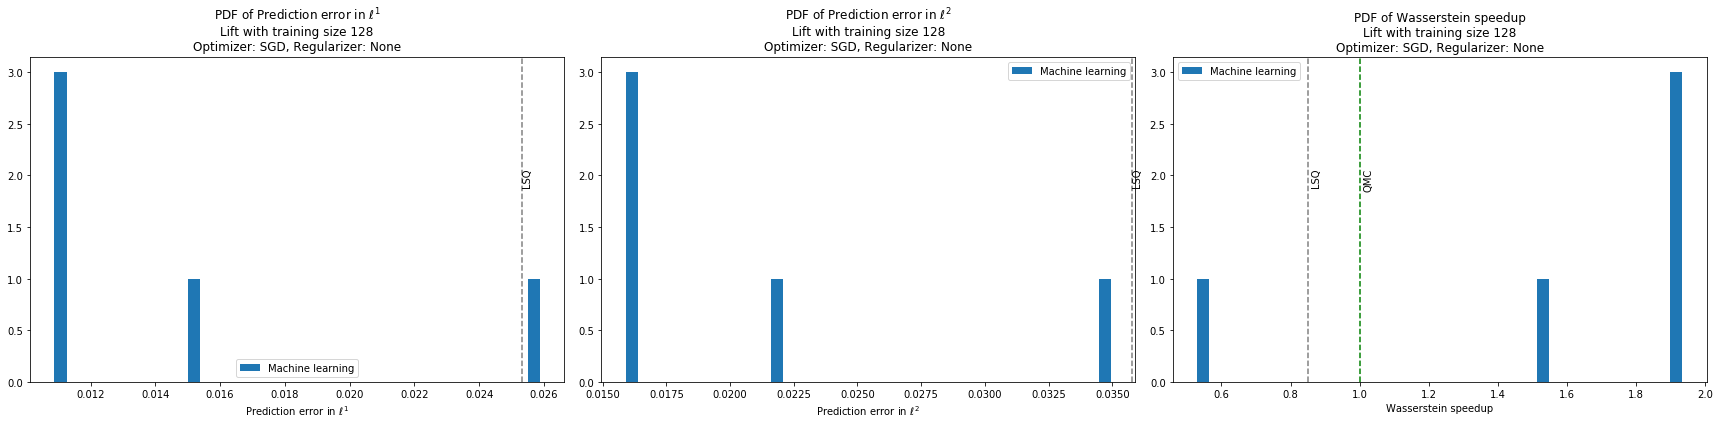

Optimizer: Adam, Regularizer: None


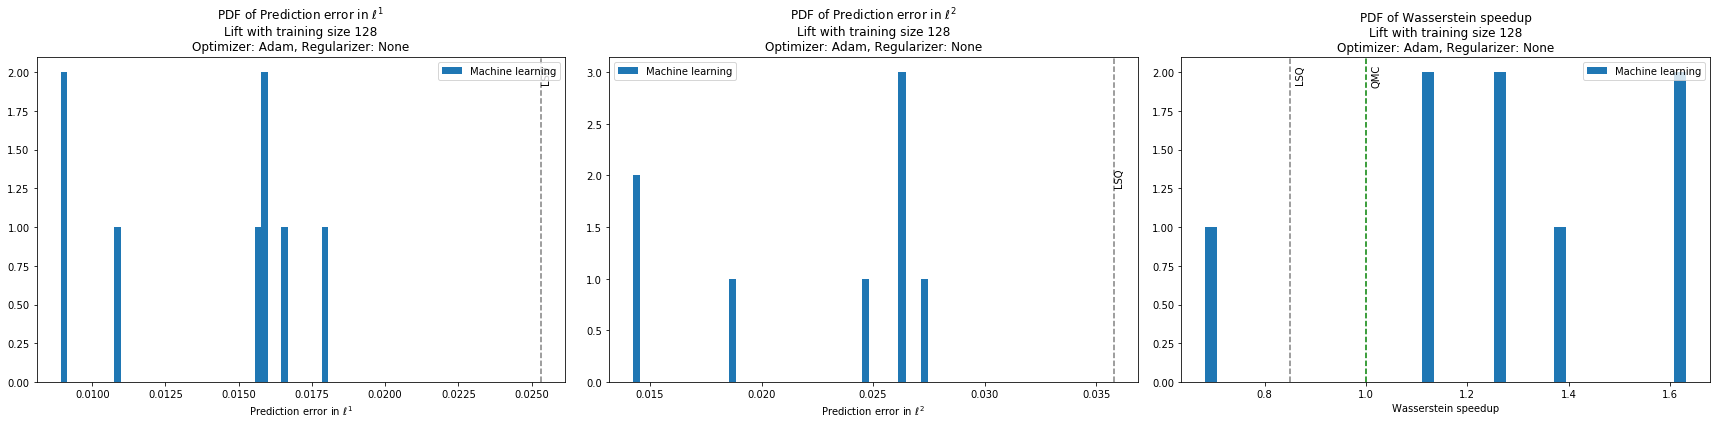

Optimizer: SGD, Regularizer: l1


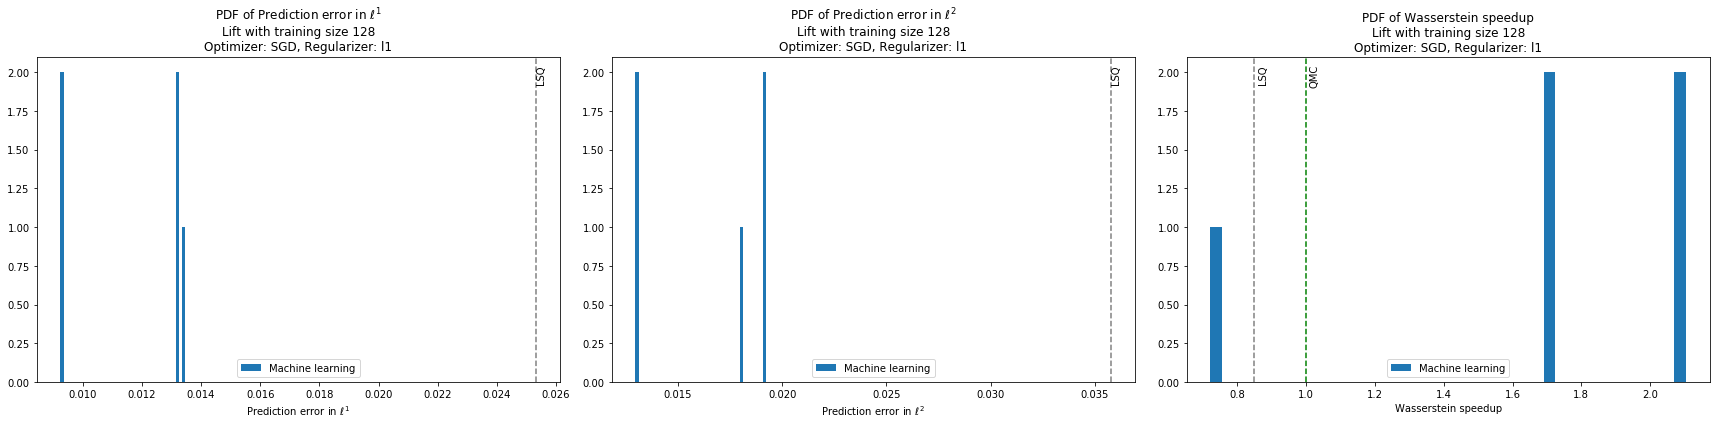

Optimizer: Adam, Regularizer: l1


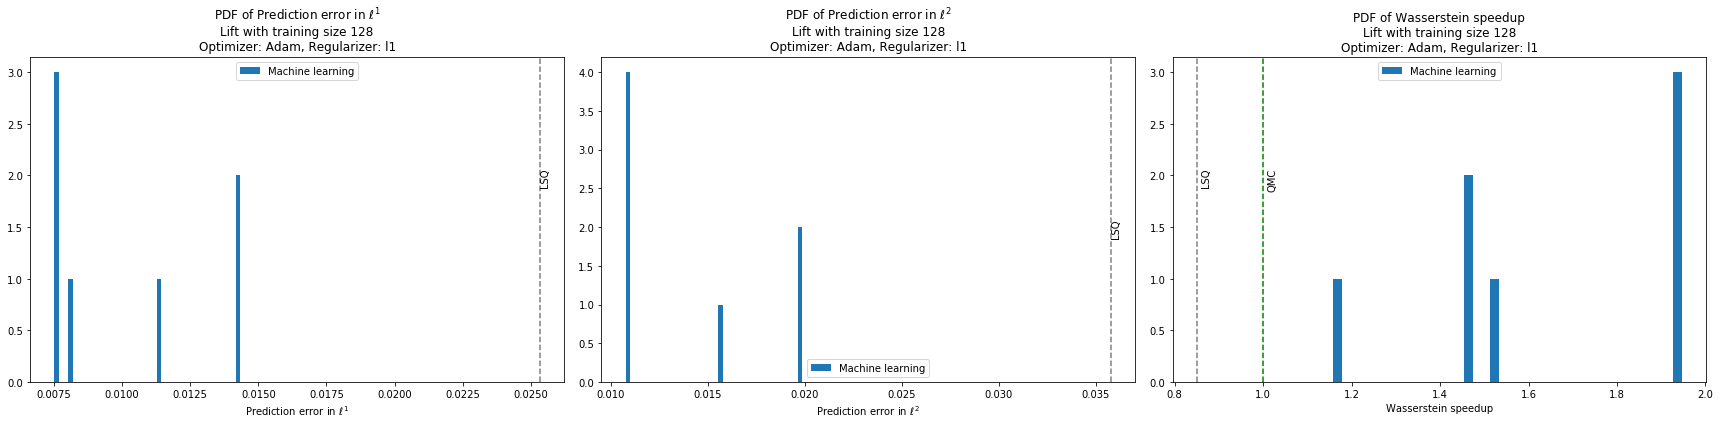

Optimizer: SGD, Regularizer: l2


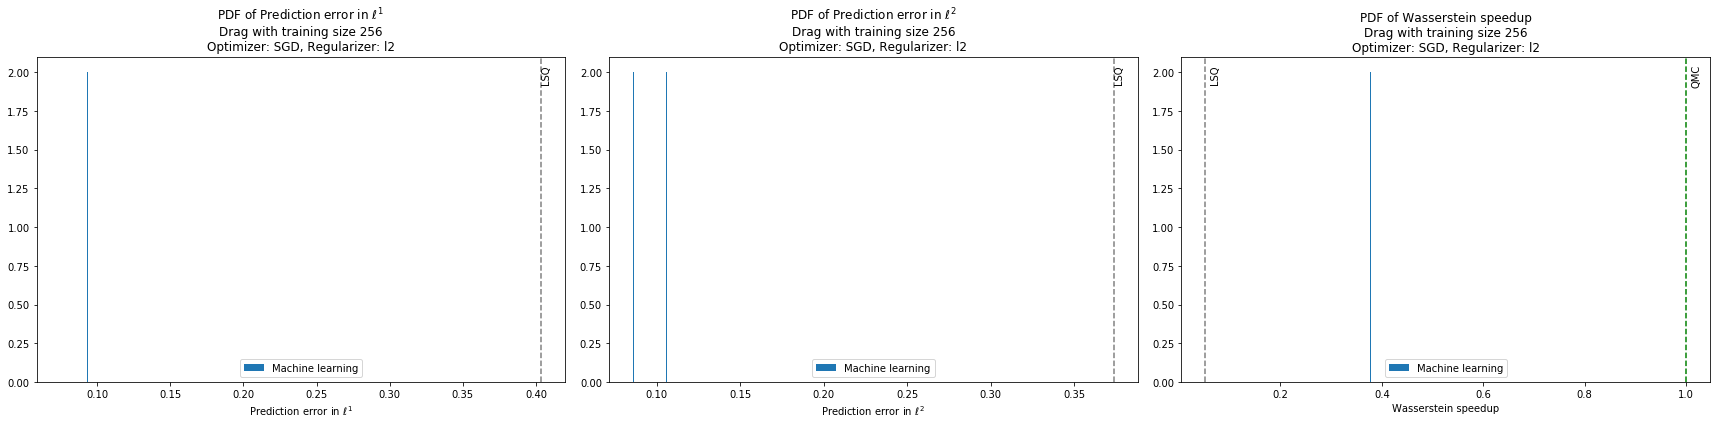

Optimizer: Adam, Regularizer: l2


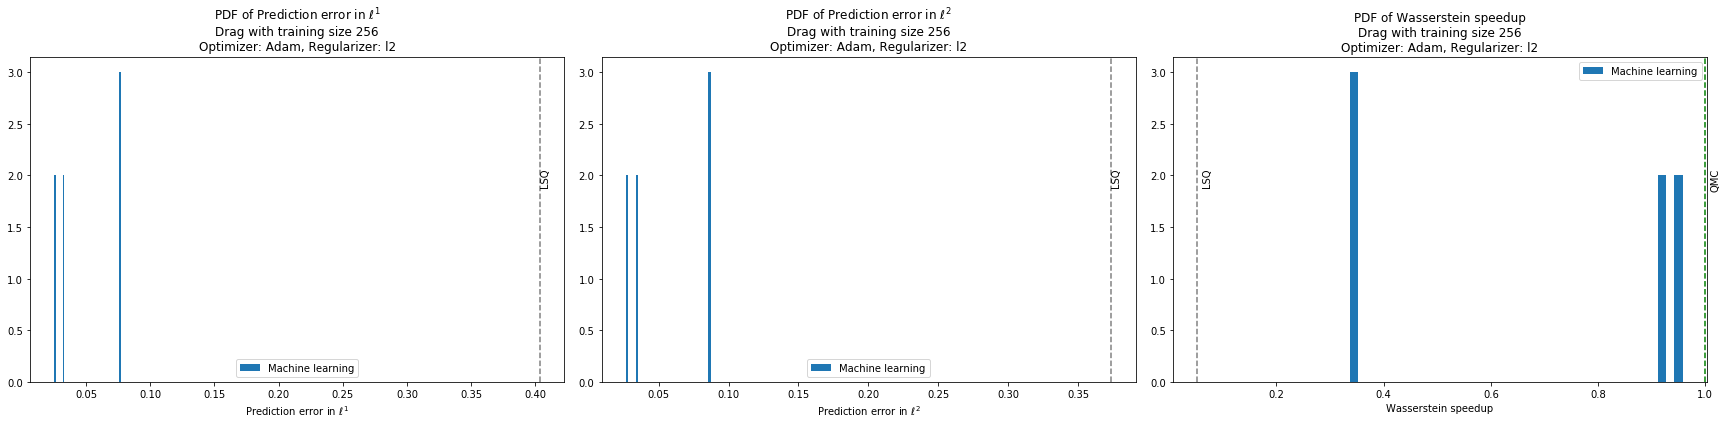

Optimizer: SGD, Regularizer: None


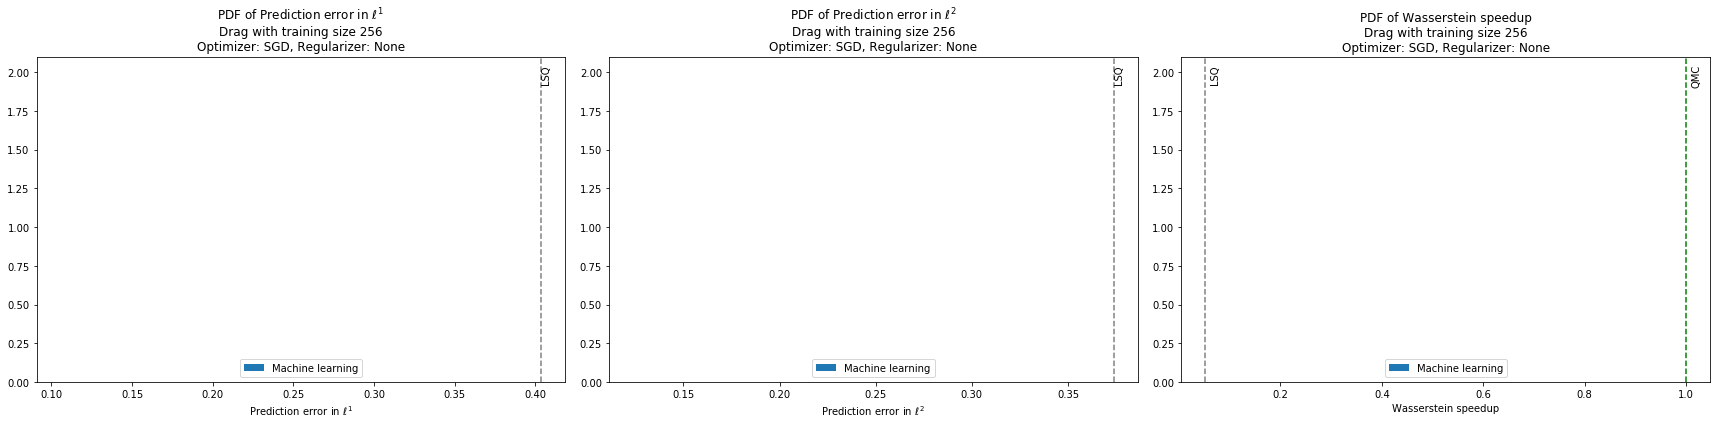

Optimizer: Adam, Regularizer: None


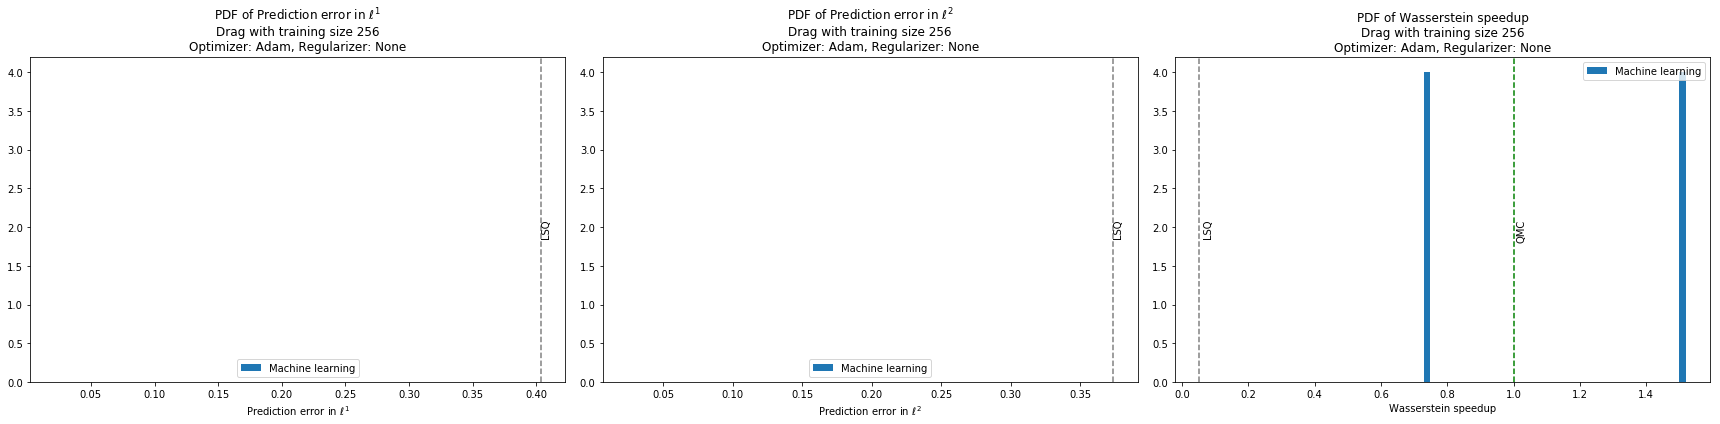

Optimizer: SGD, Regularizer: l1


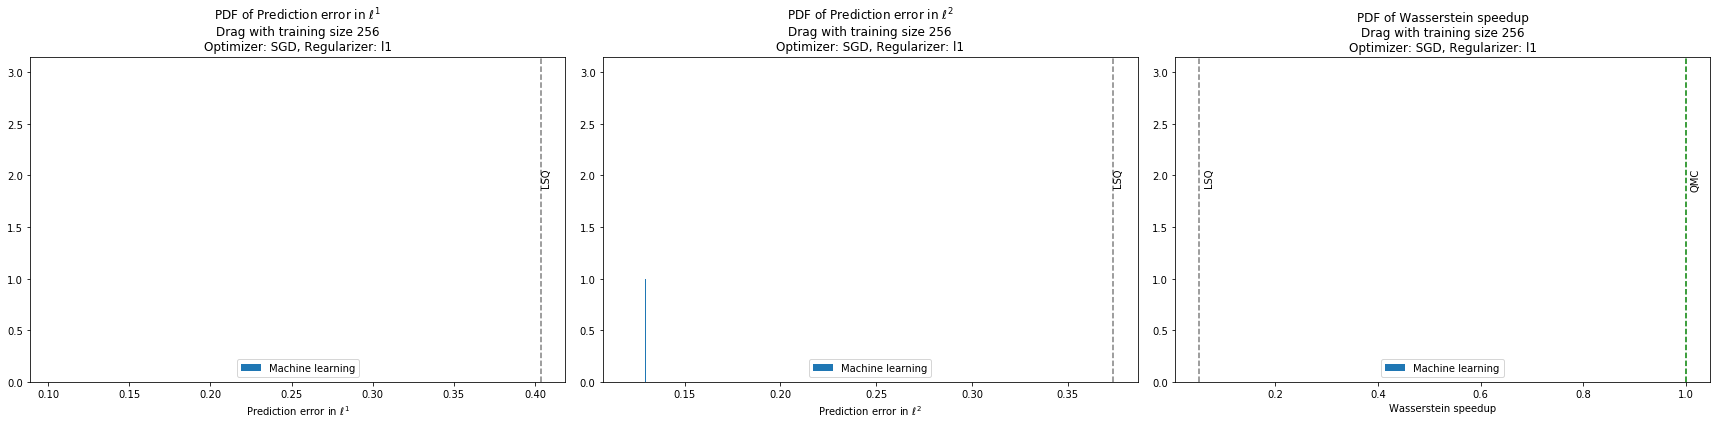

Optimizer: Adam, Regularizer: l1


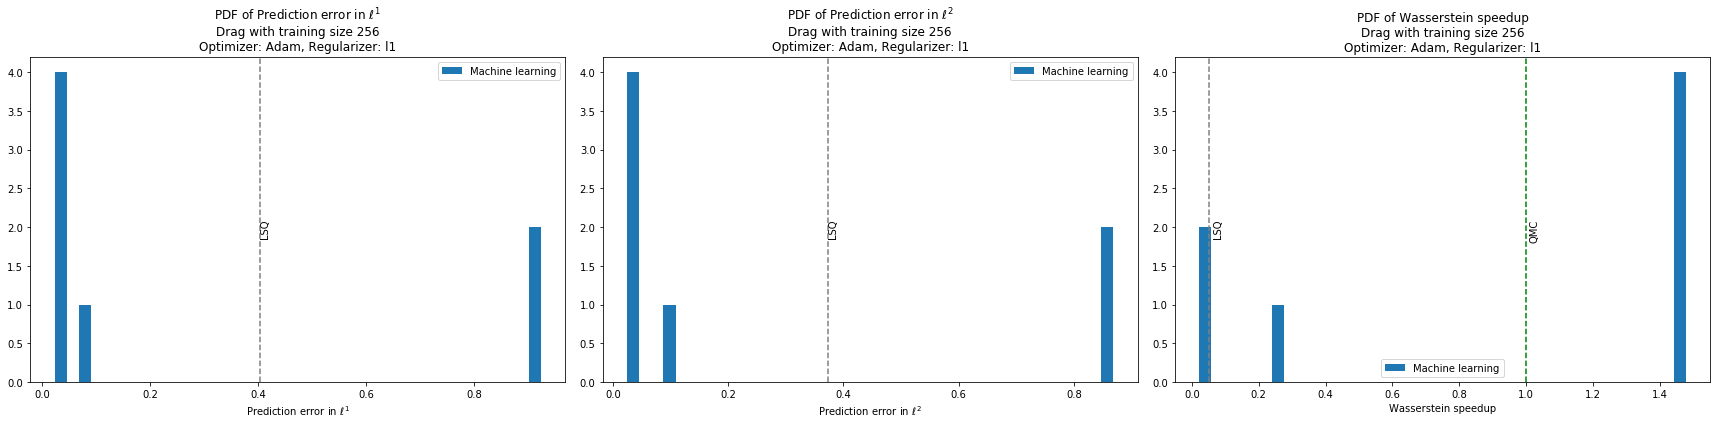

Optimizer: SGD, Regularizer: l2


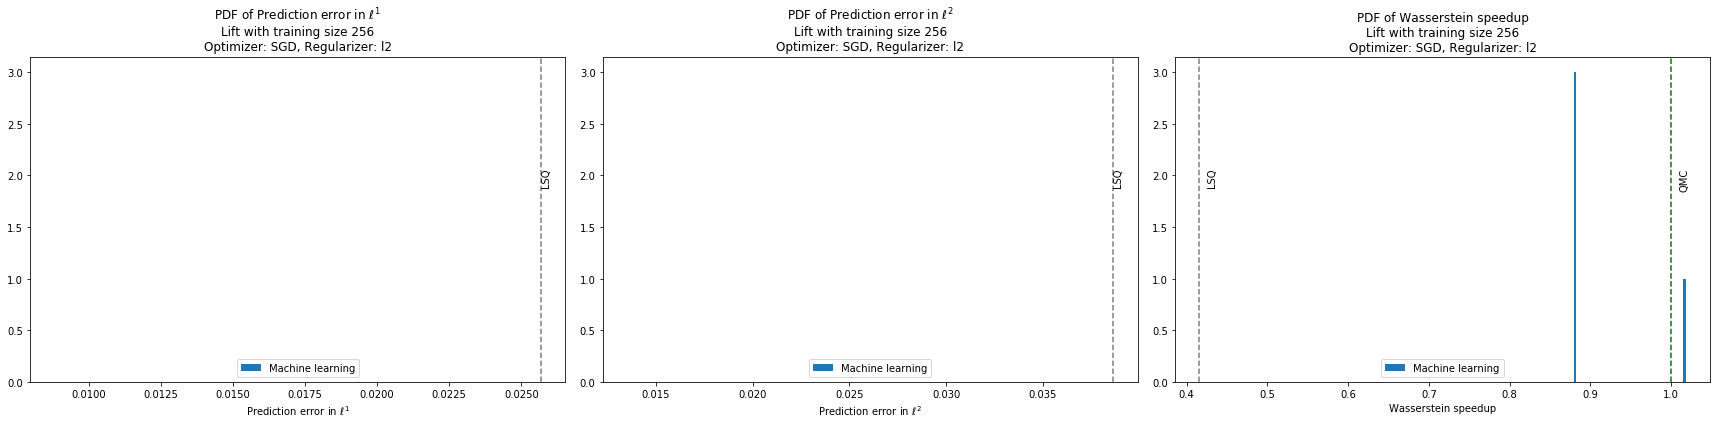

Optimizer: Adam, Regularizer: l2


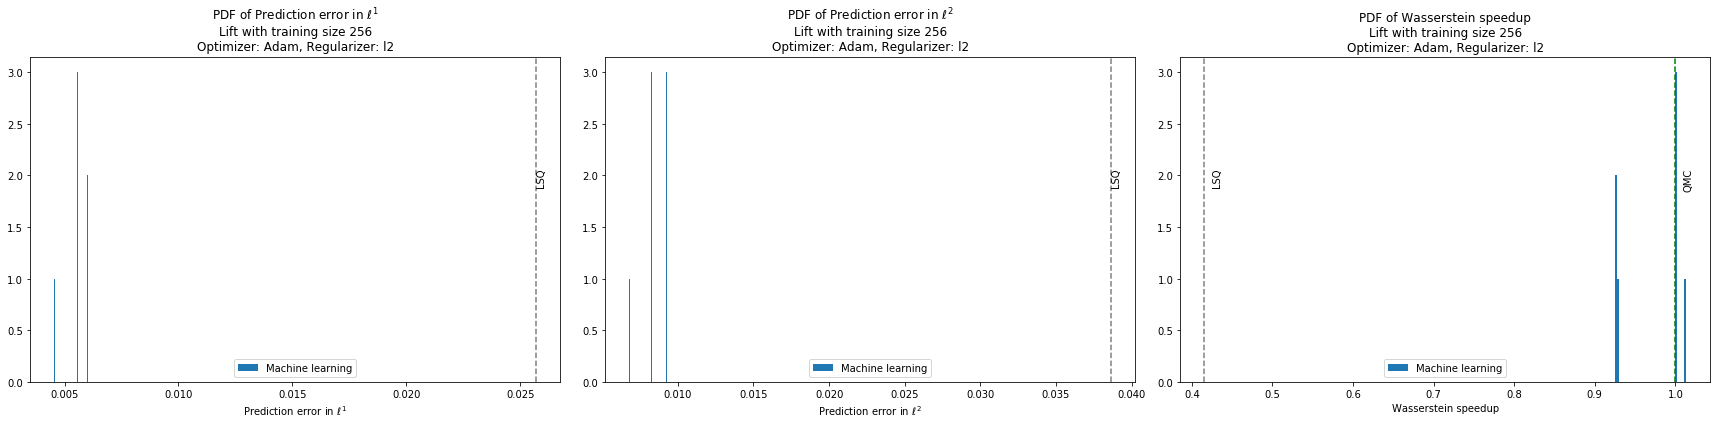

Optimizer: SGD, Regularizer: None


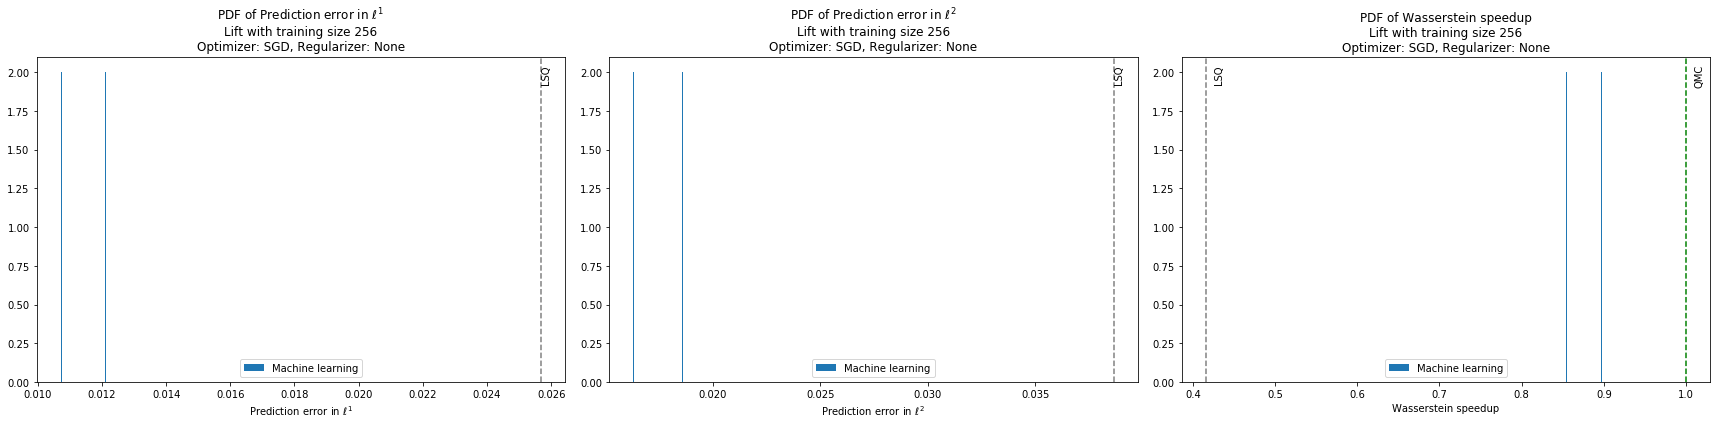

Optimizer: Adam, Regularizer: None


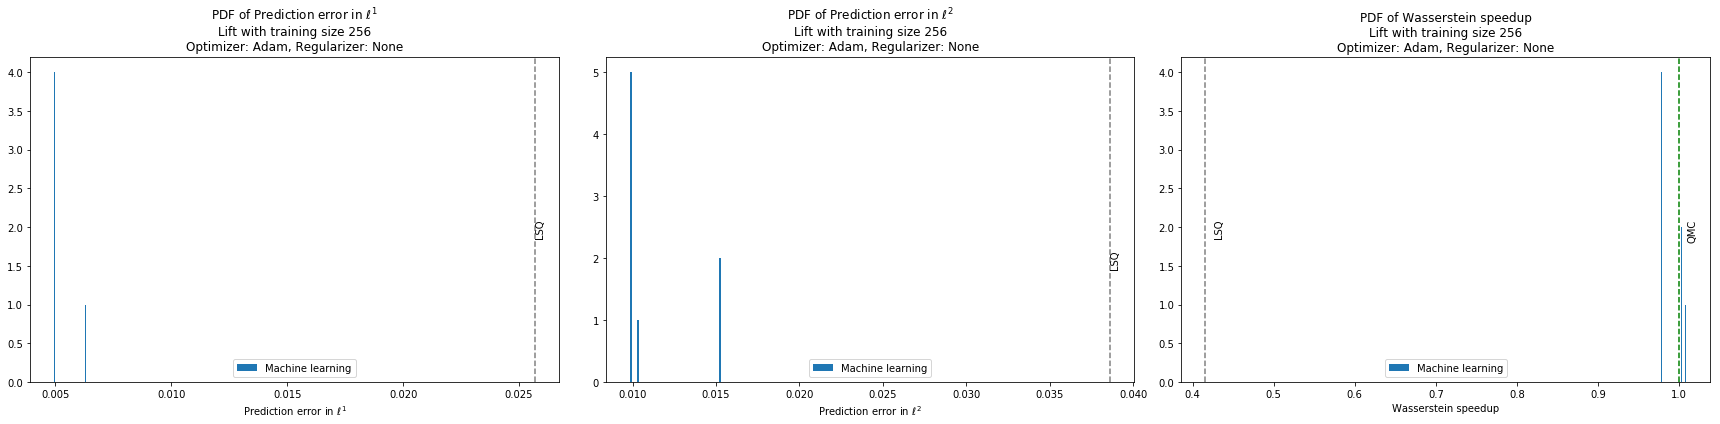

Optimizer: SGD, Regularizer: l1


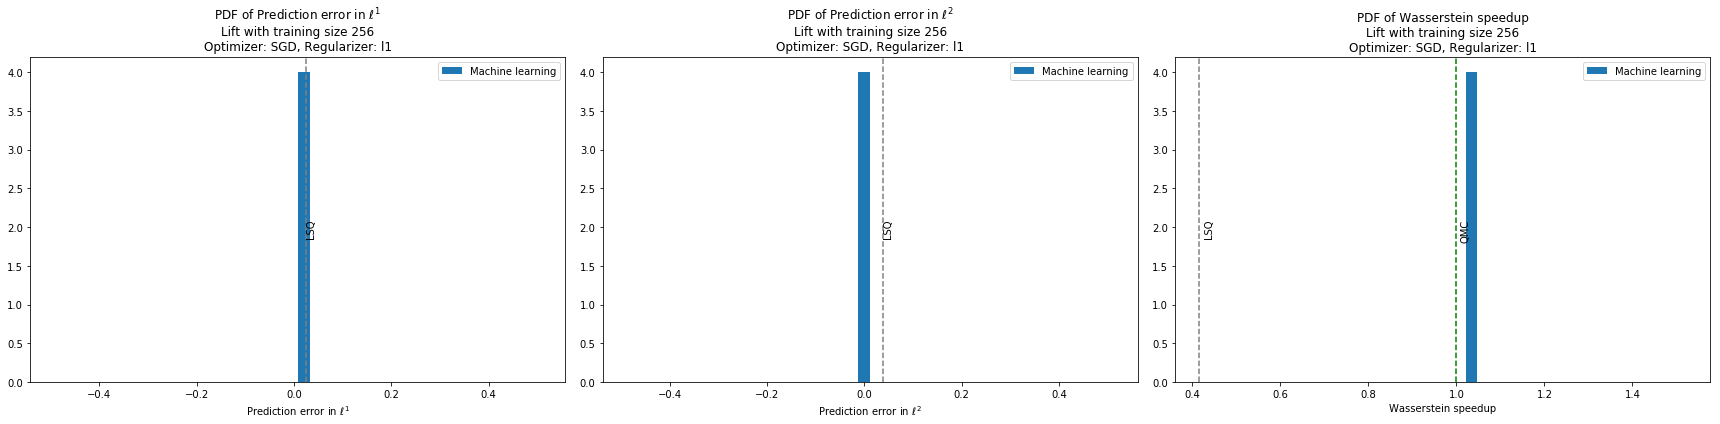

Optimizer: Adam, Regularizer: l1


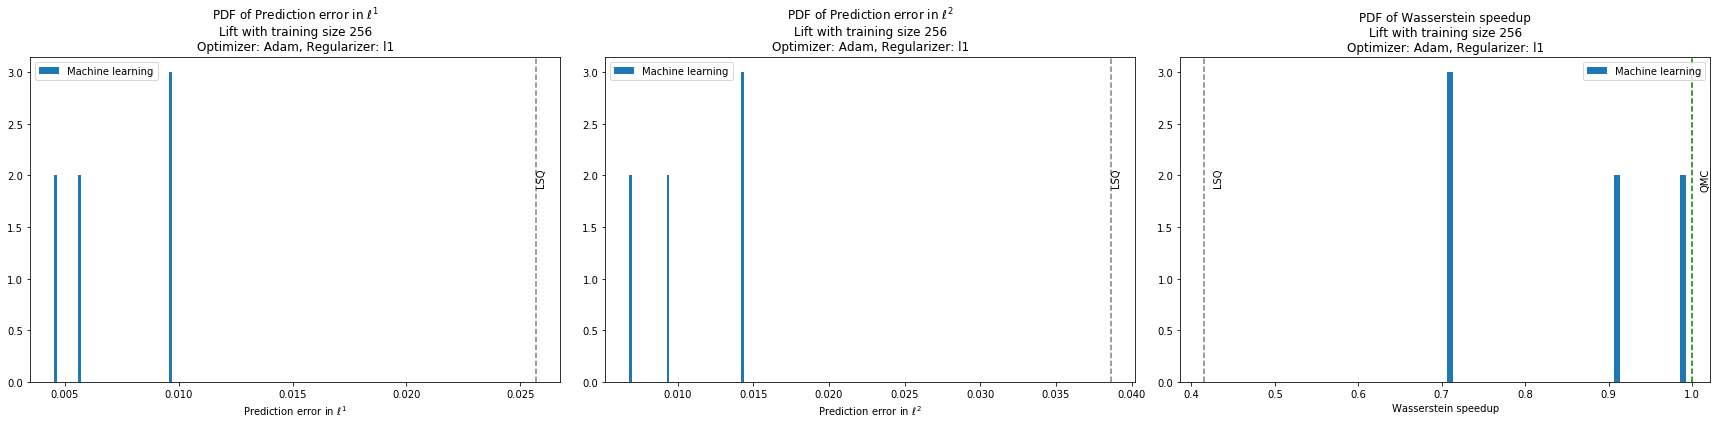

Optimizer: SGD, Regularizer: l2


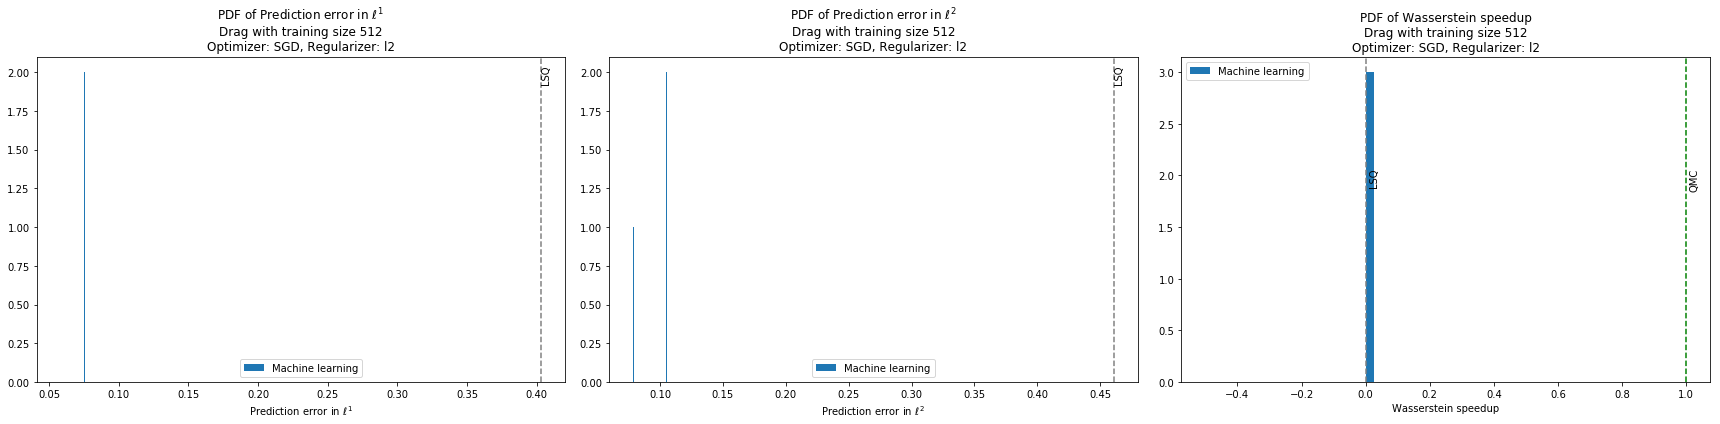

Optimizer: Adam, Regularizer: l2


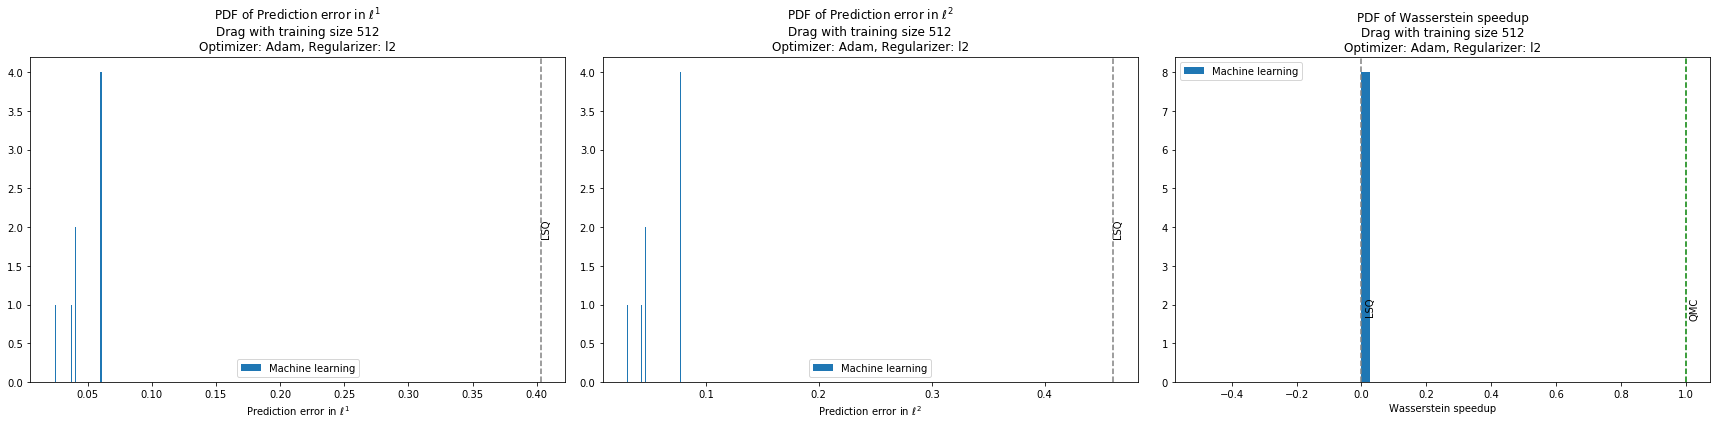

Optimizer: SGD, Regularizer: None


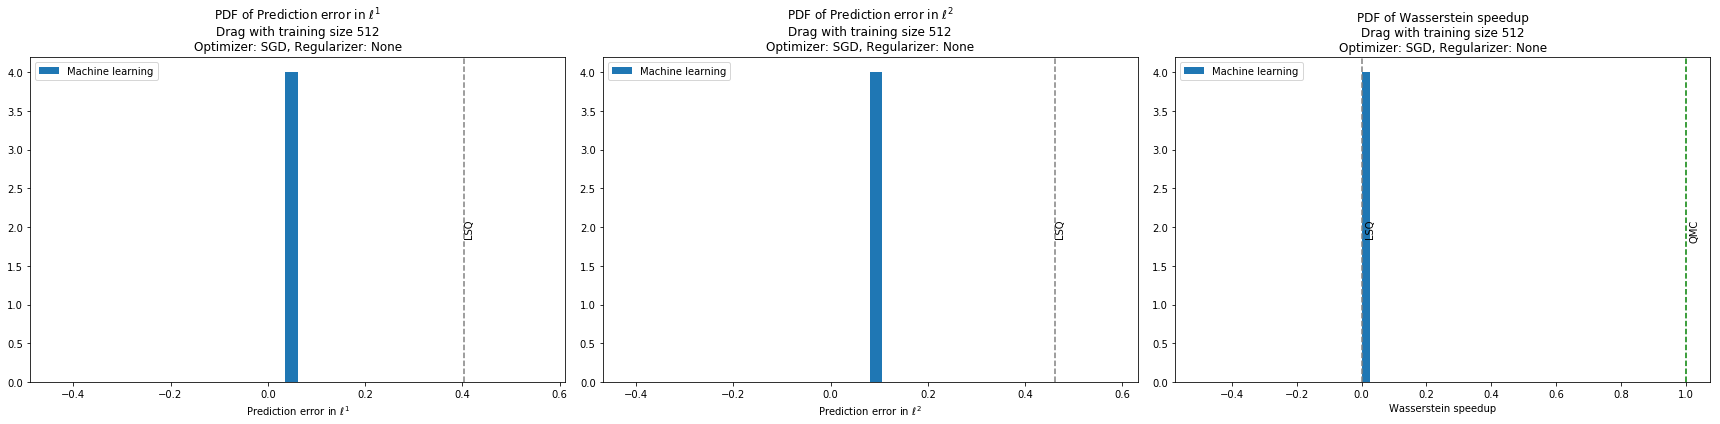

Optimizer: Adam, Regularizer: None


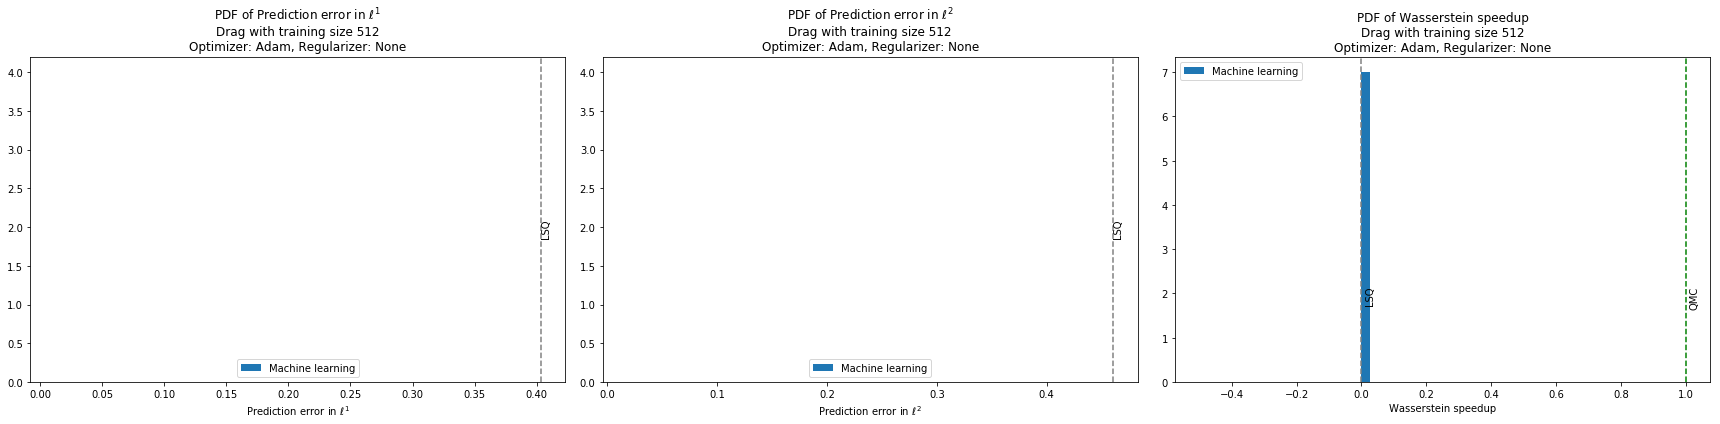

Optimizer: SGD, Regularizer: l1


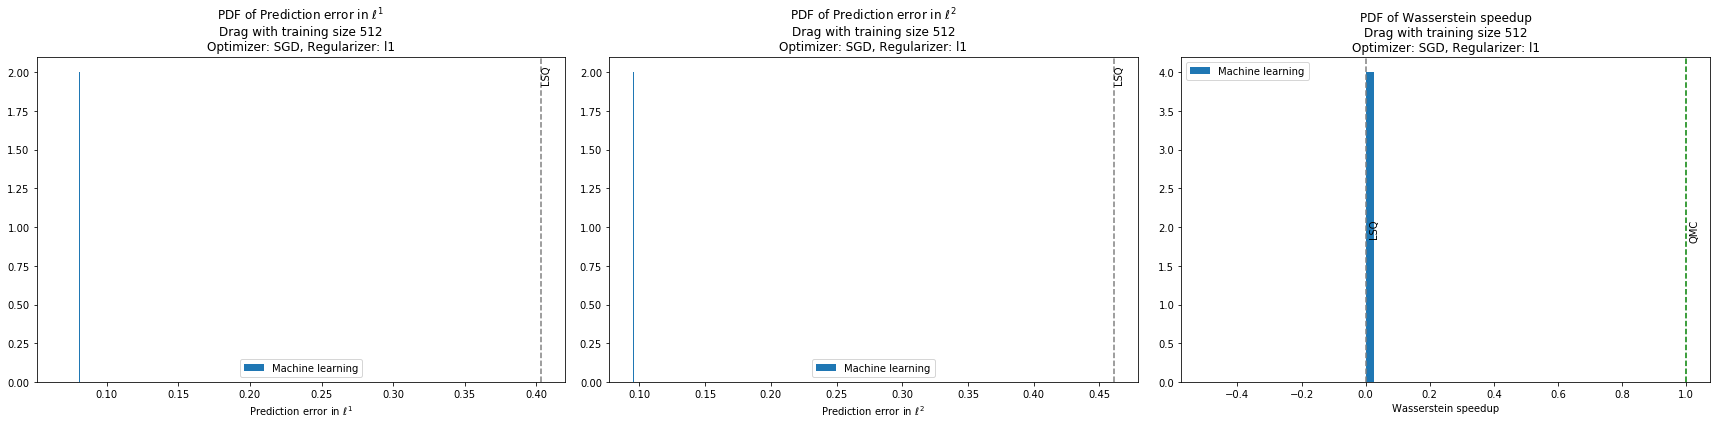

Optimizer: Adam, Regularizer: l1


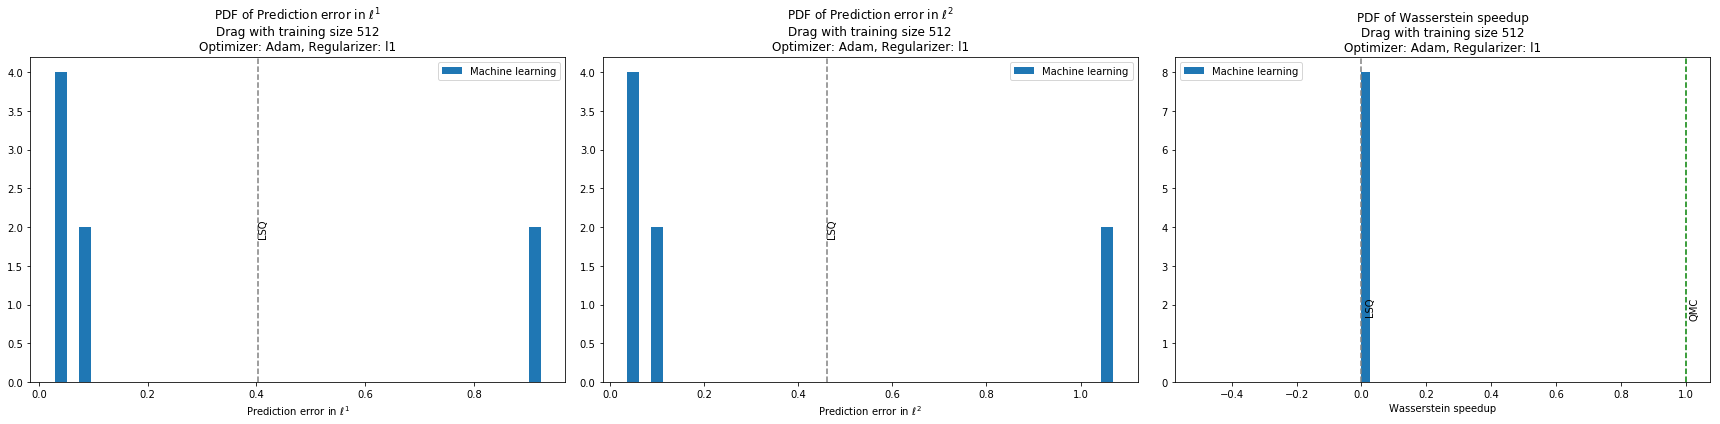

Optimizer: SGD, Regularizer: l2


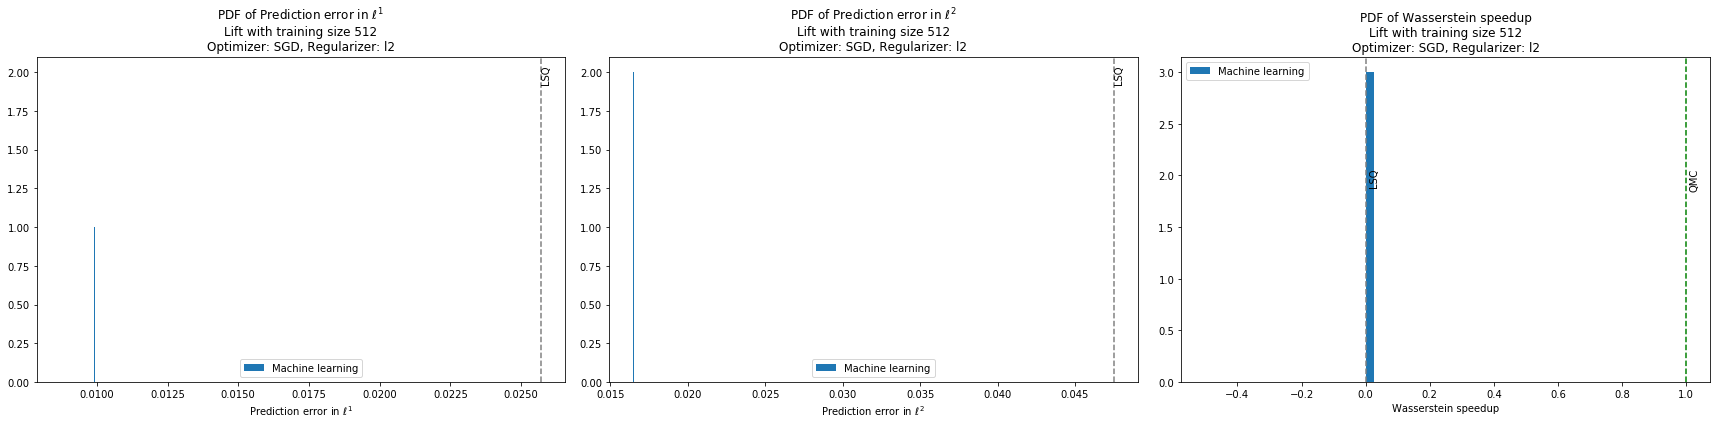

Optimizer: Adam, Regularizer: l2


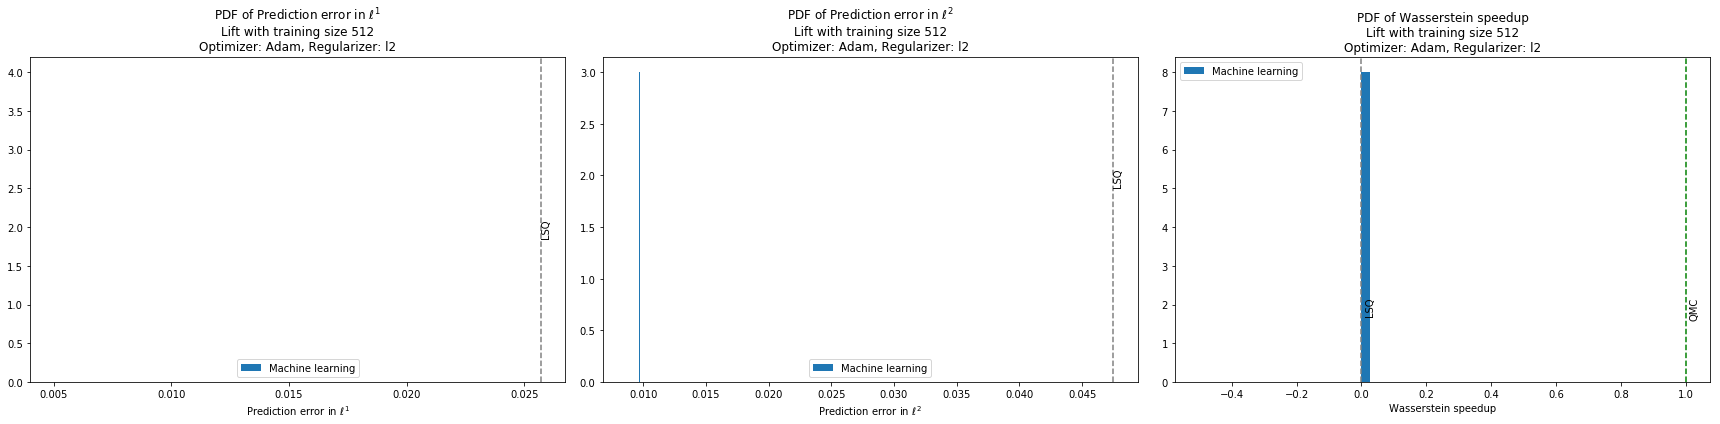

Optimizer: SGD, Regularizer: None


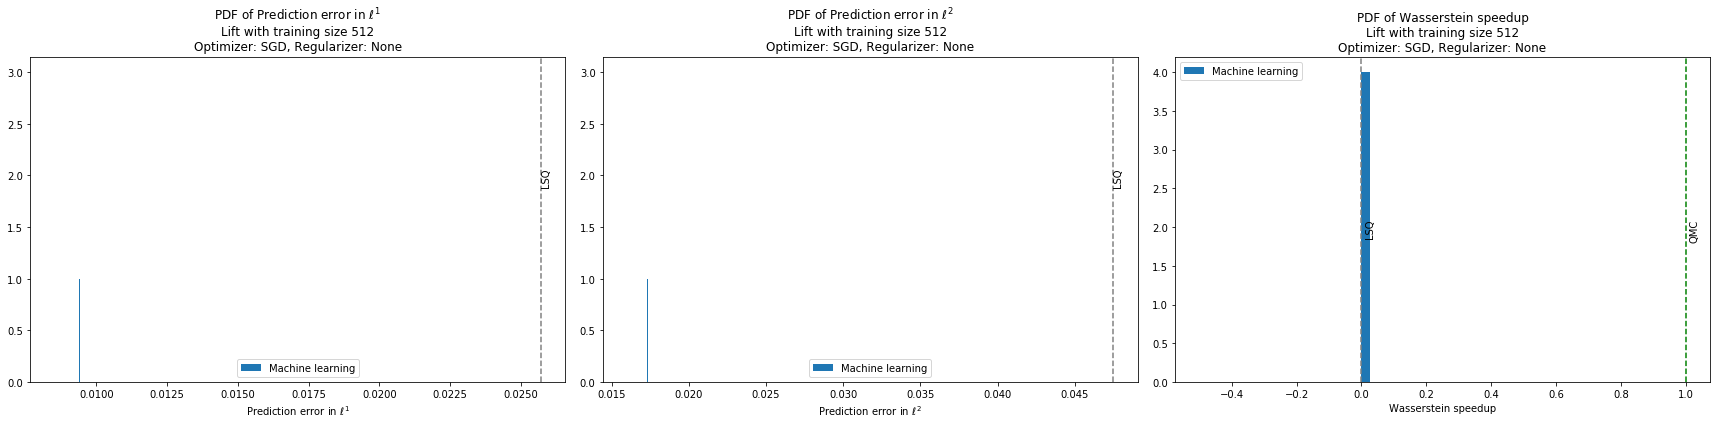

Optimizer: Adam, Regularizer: None


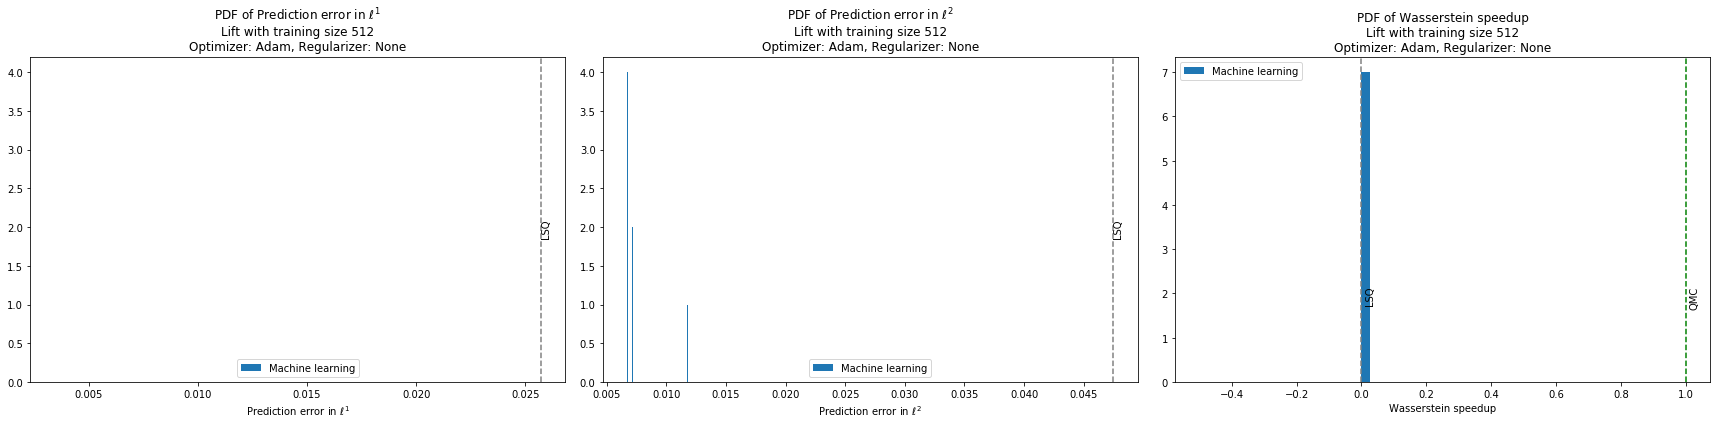

Optimizer: SGD, Regularizer: l1


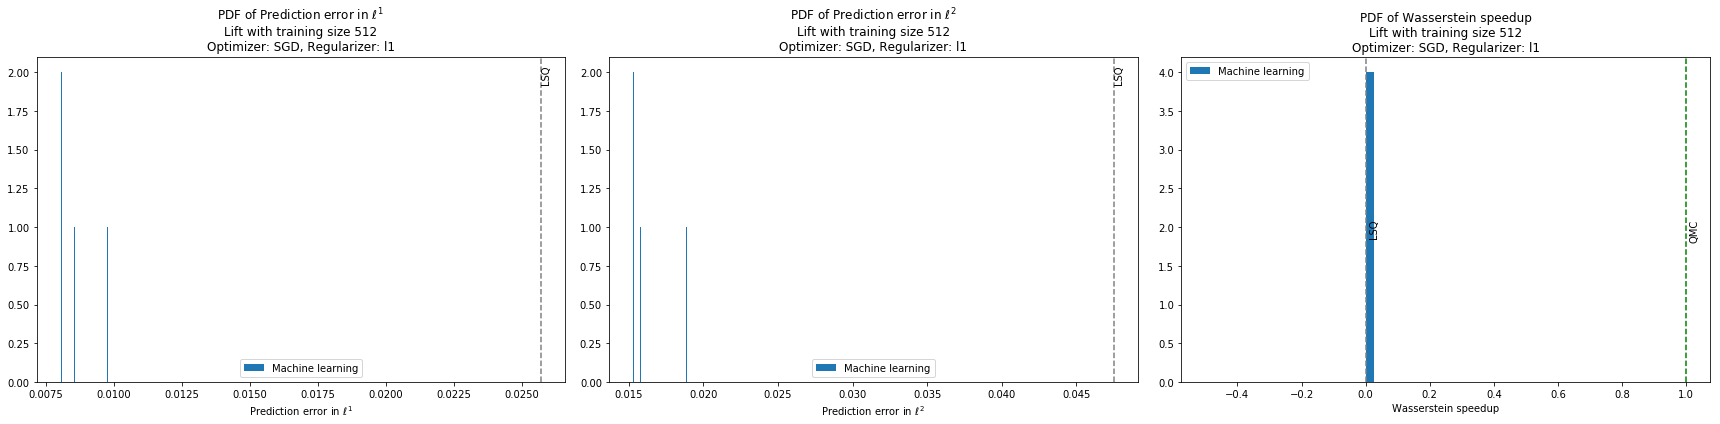

Optimizer: Adam, Regularizer: l1


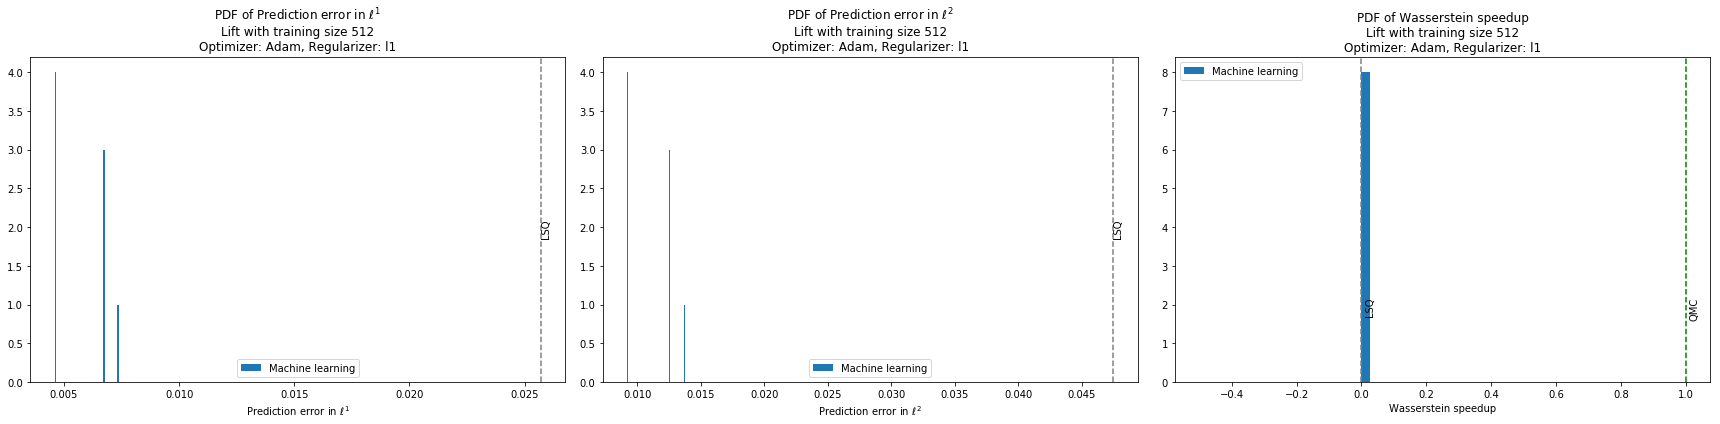

Optimizer: SGD, Regularizer: l2


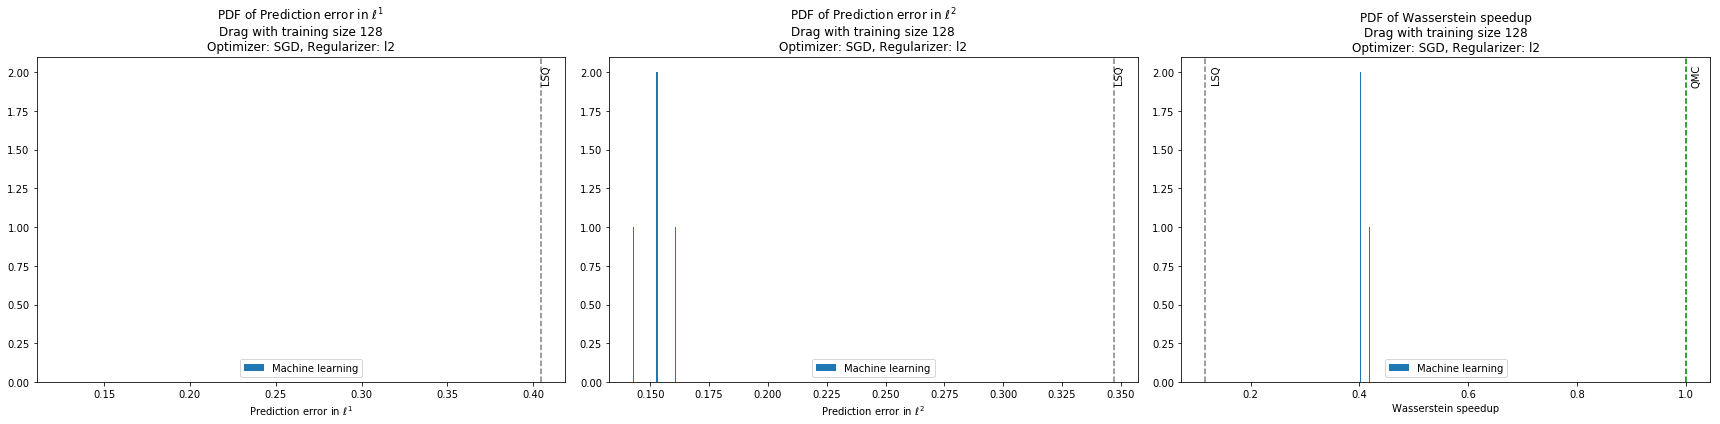

Optimizer: Adam, Regularizer: l2


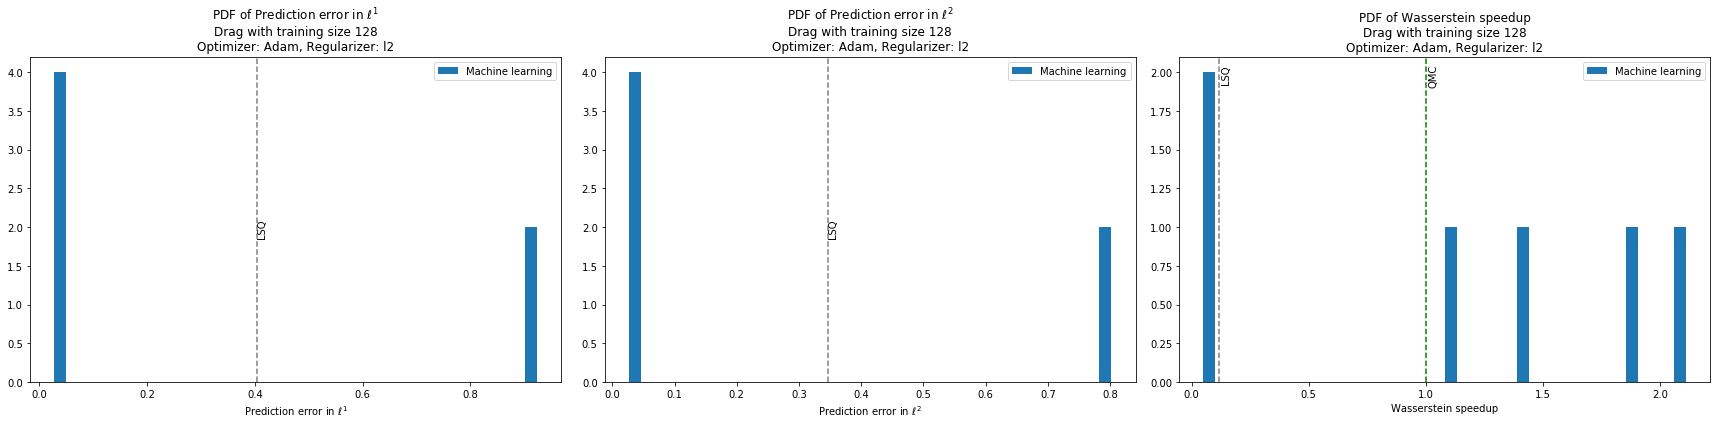

Optimizer: SGD, Regularizer: None


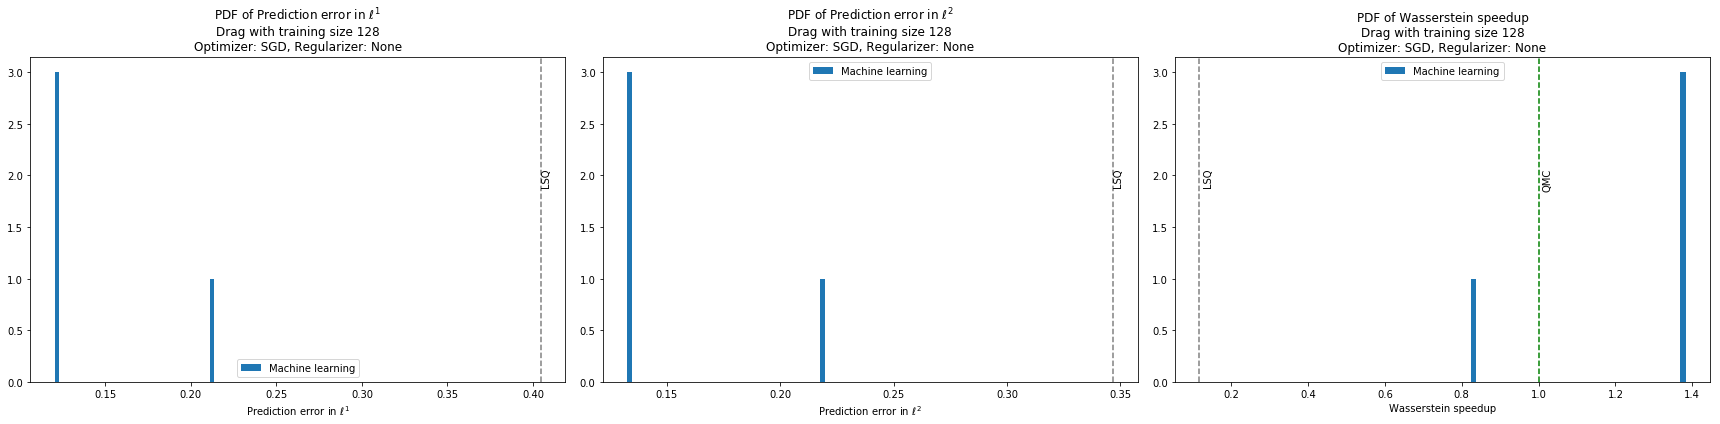

Optimizer: Adam, Regularizer: None


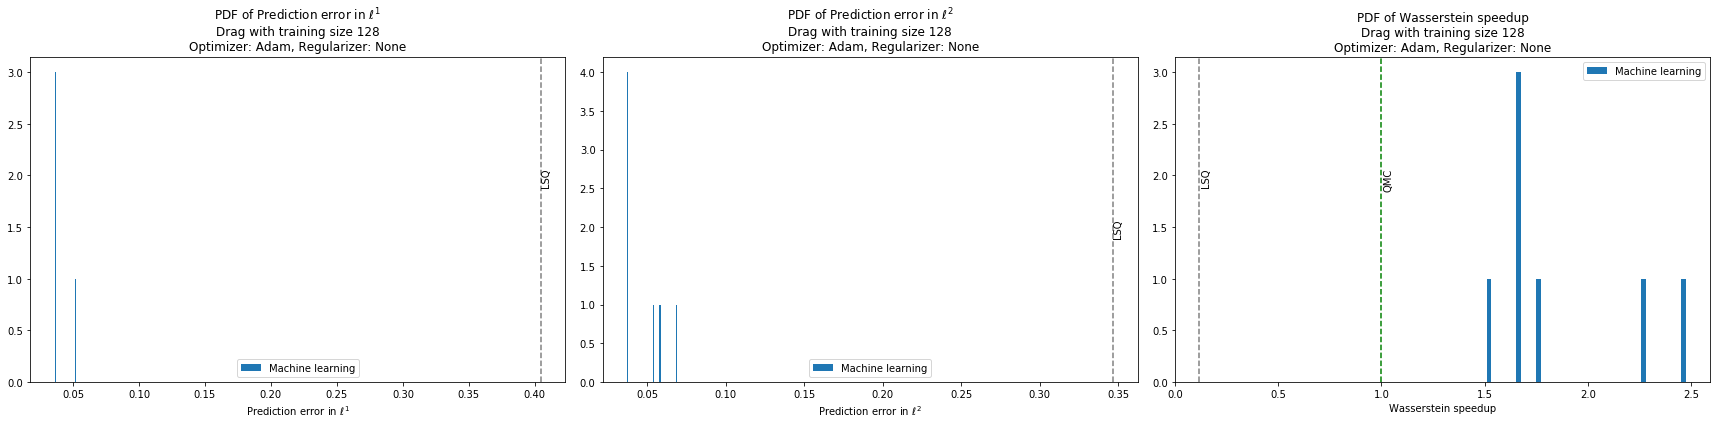

Optimizer: SGD, Regularizer: l1


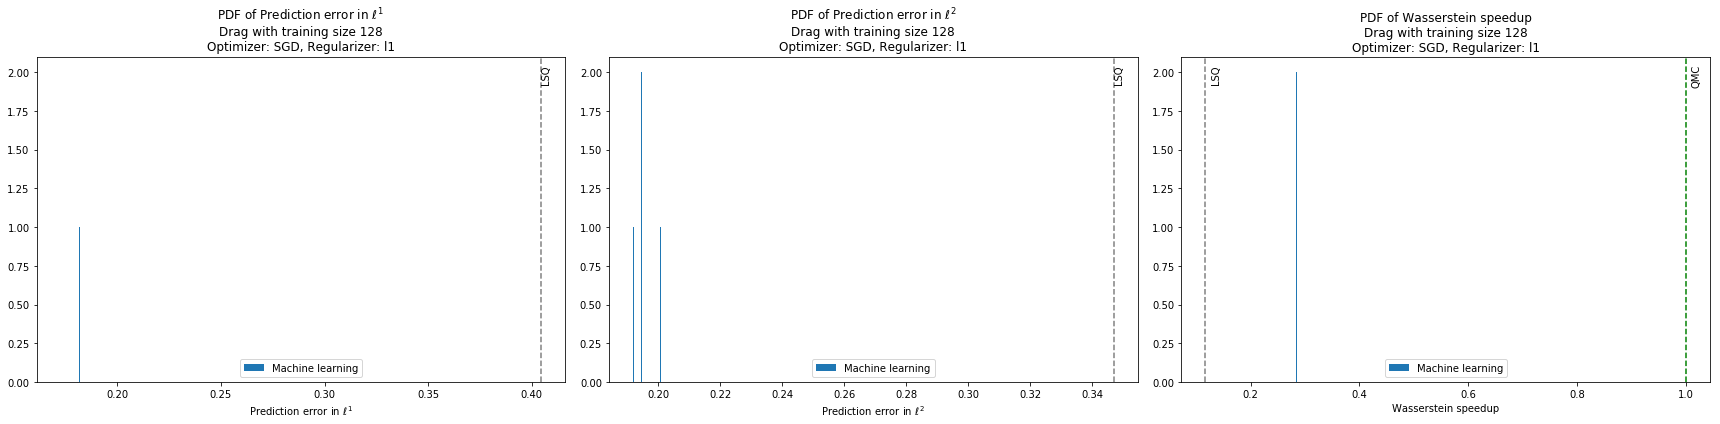

Optimizer: Adam, Regularizer: l1


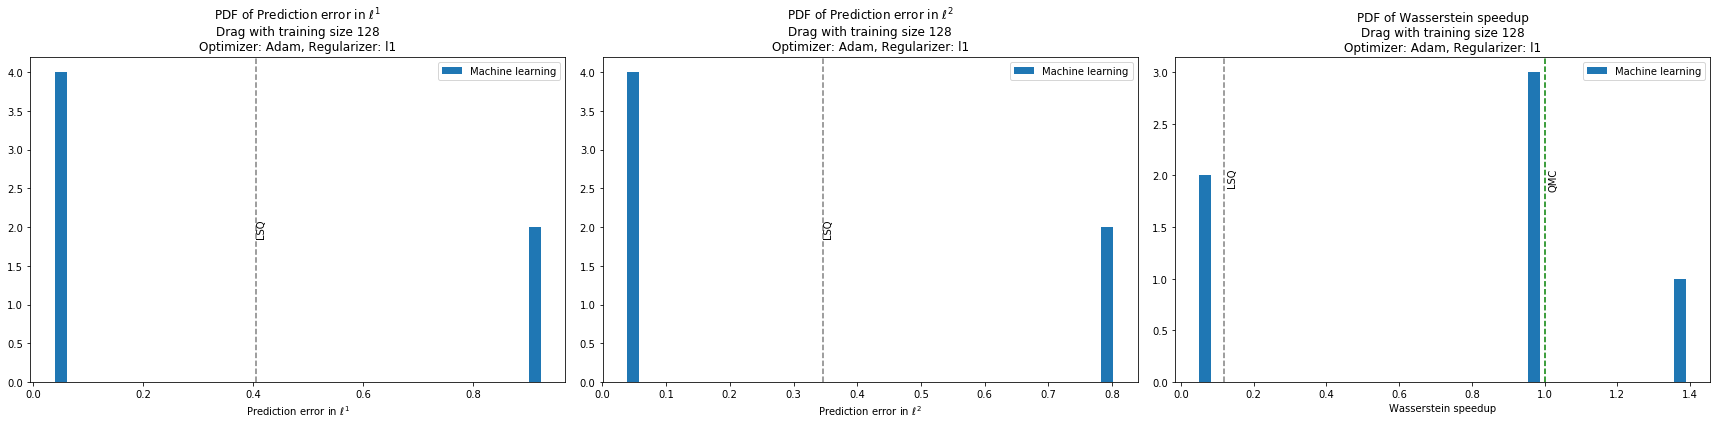

Optimizer: SGD, Regularizer: l2


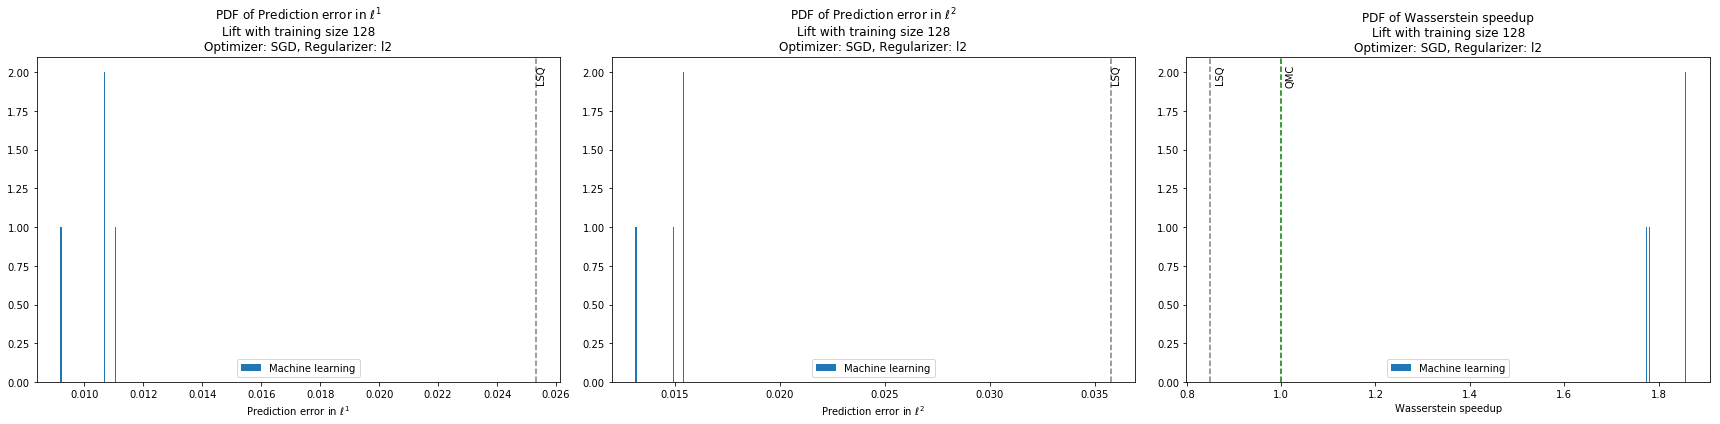

Optimizer: Adam, Regularizer: l2


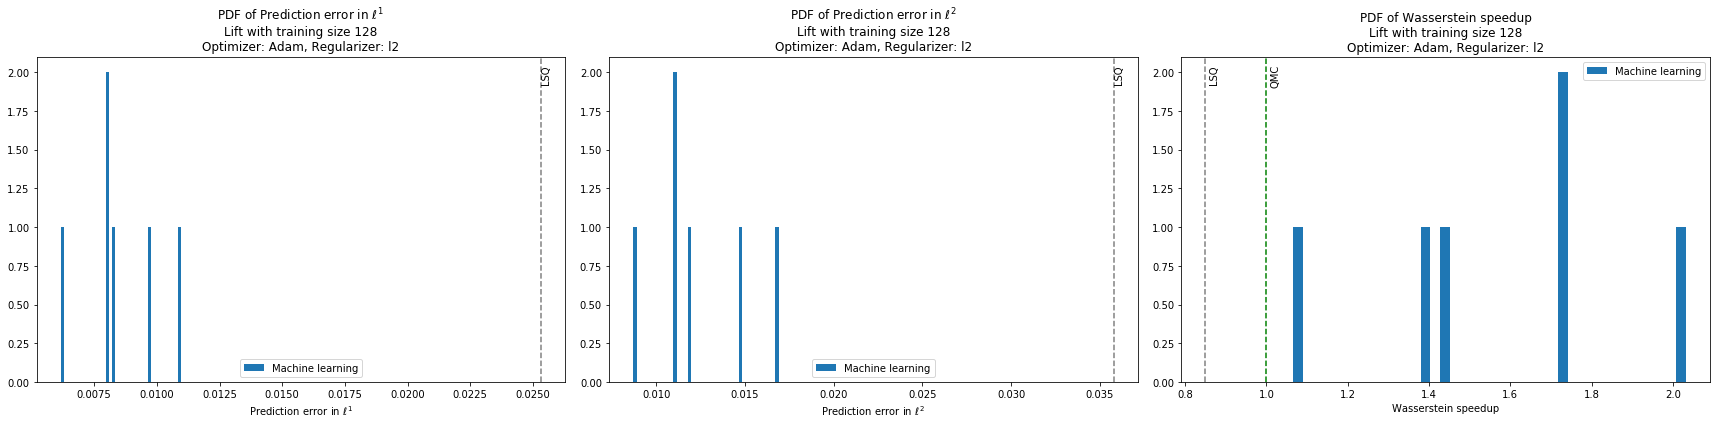

Optimizer: SGD, Regularizer: None


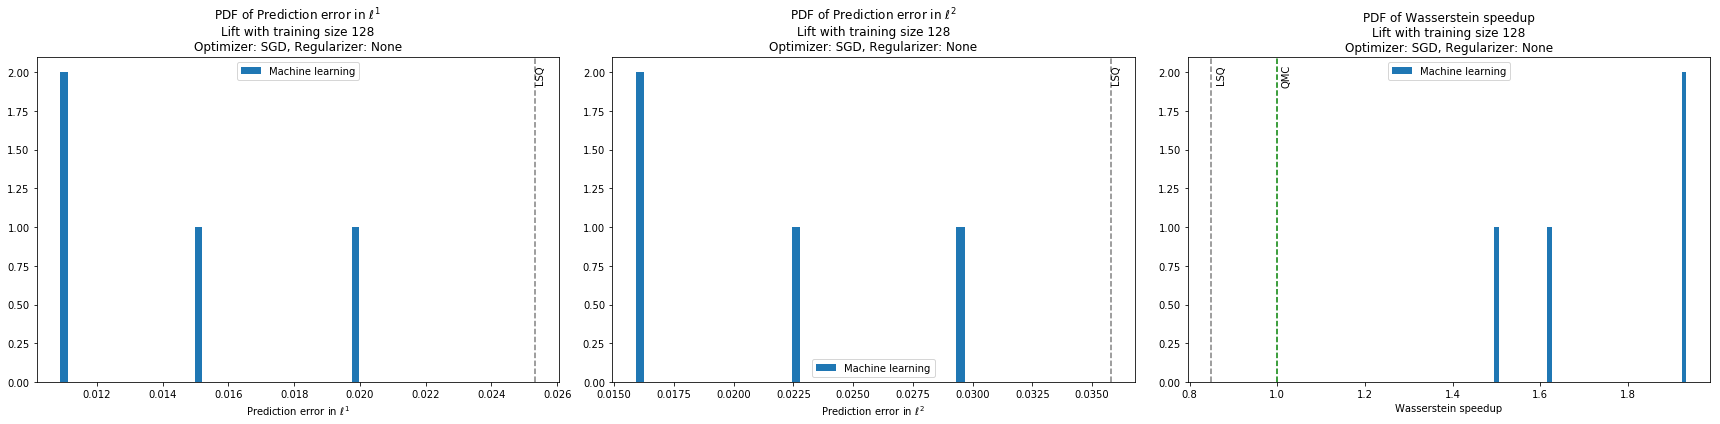

Optimizer: Adam, Regularizer: None


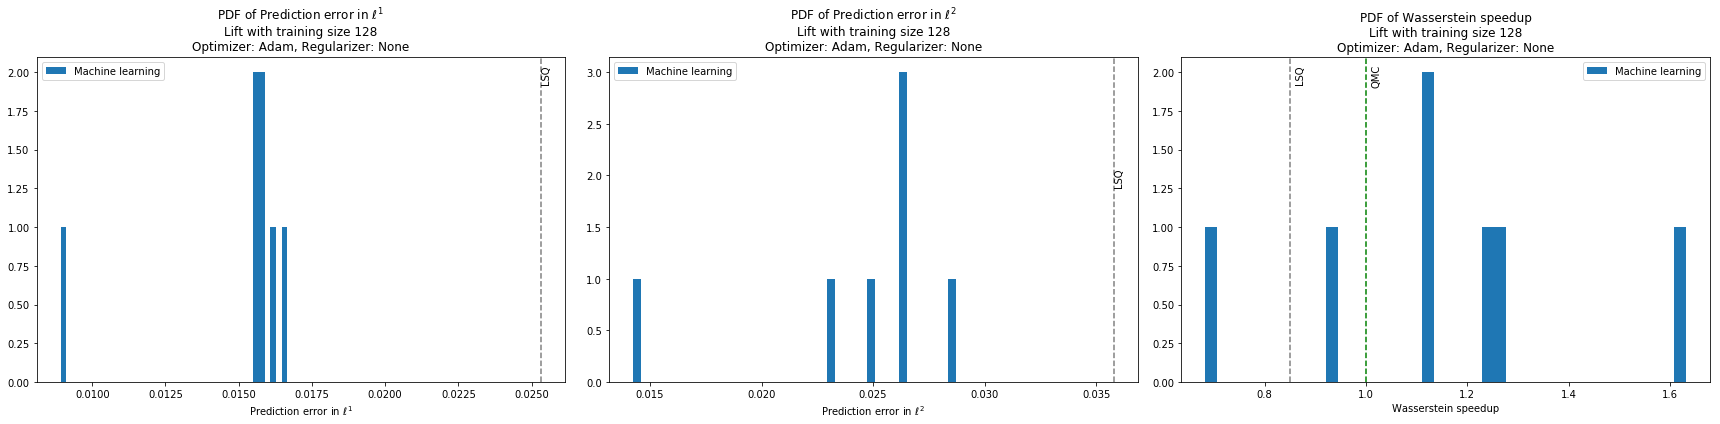

Optimizer: SGD, Regularizer: l1


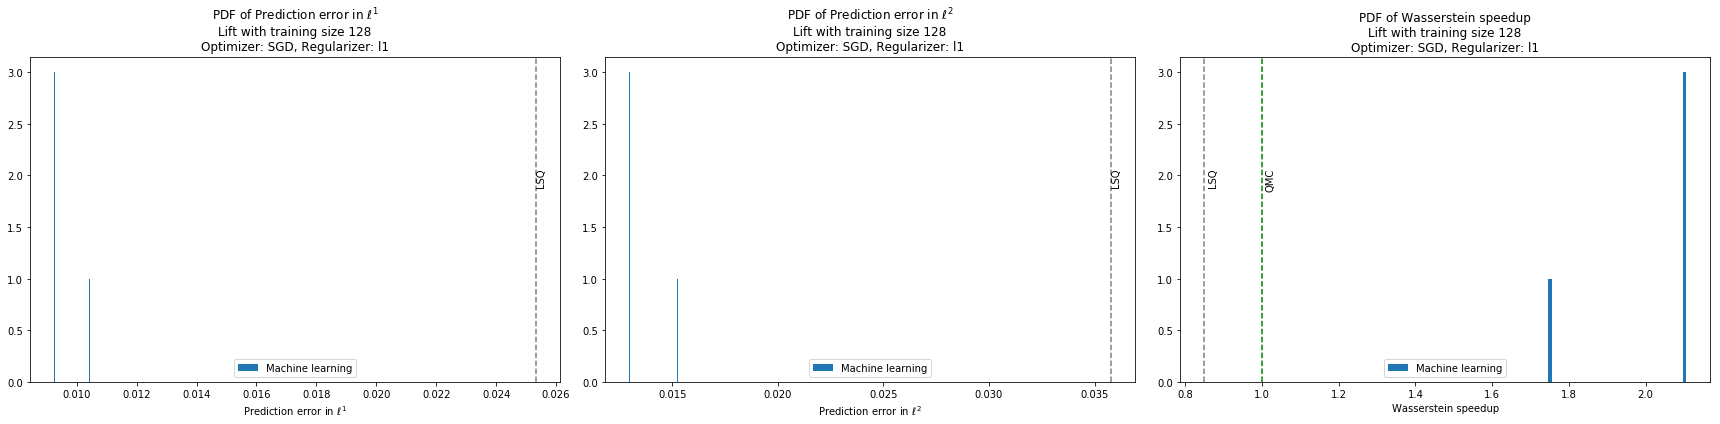

Optimizer: Adam, Regularizer: l1


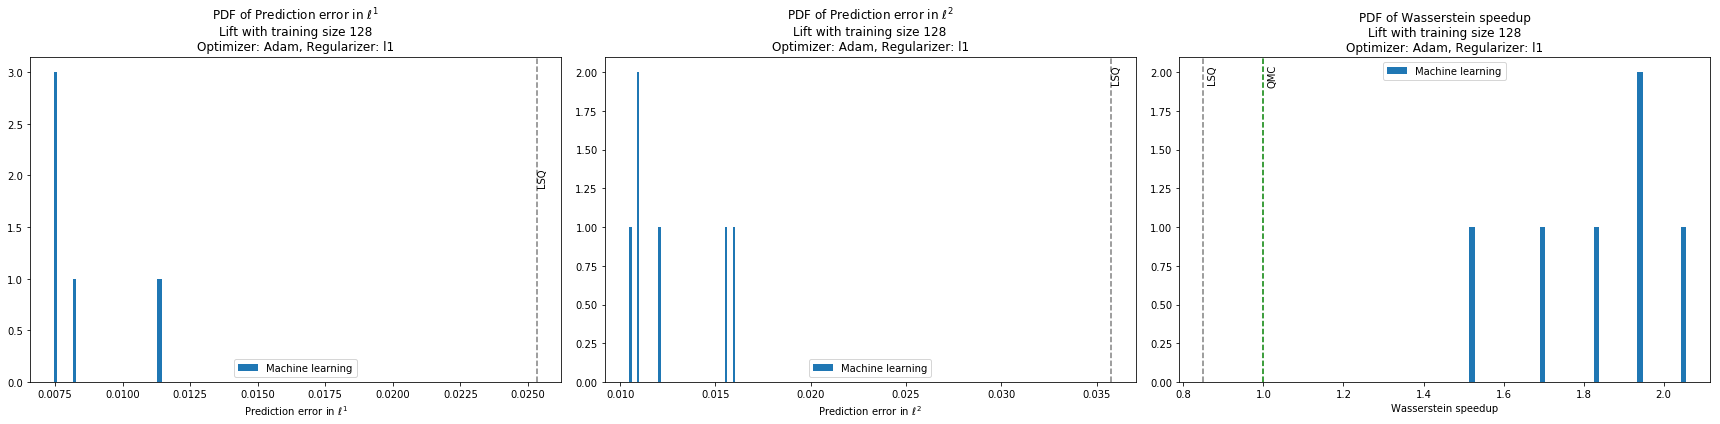

Optimizer: SGD, Regularizer: l2


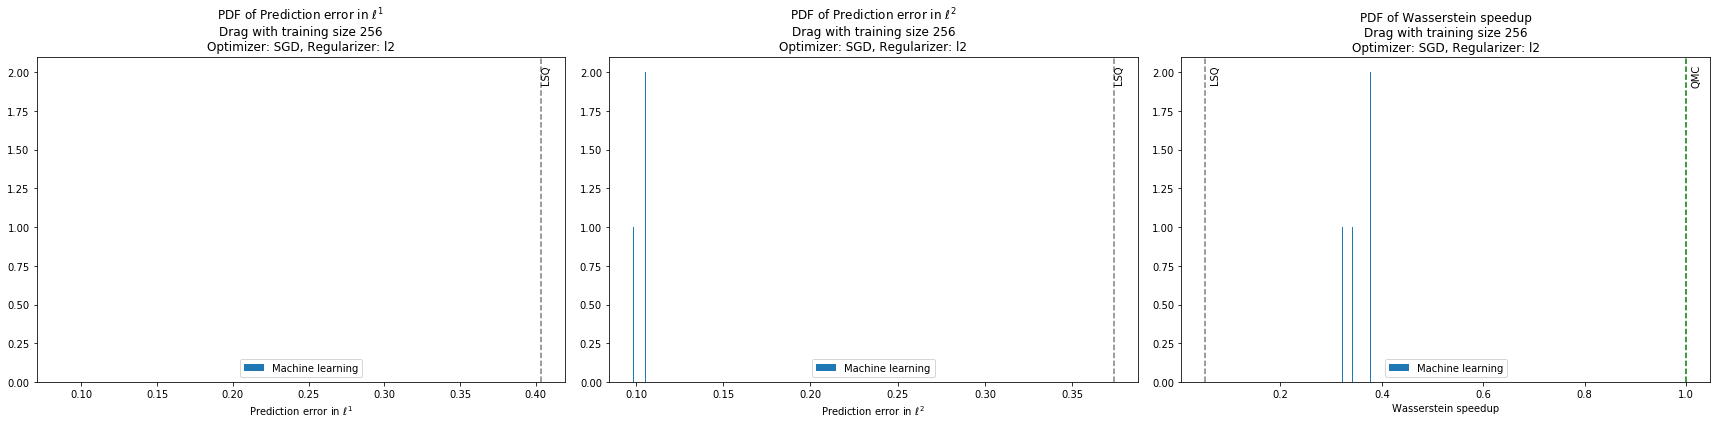

Optimizer: Adam, Regularizer: l2


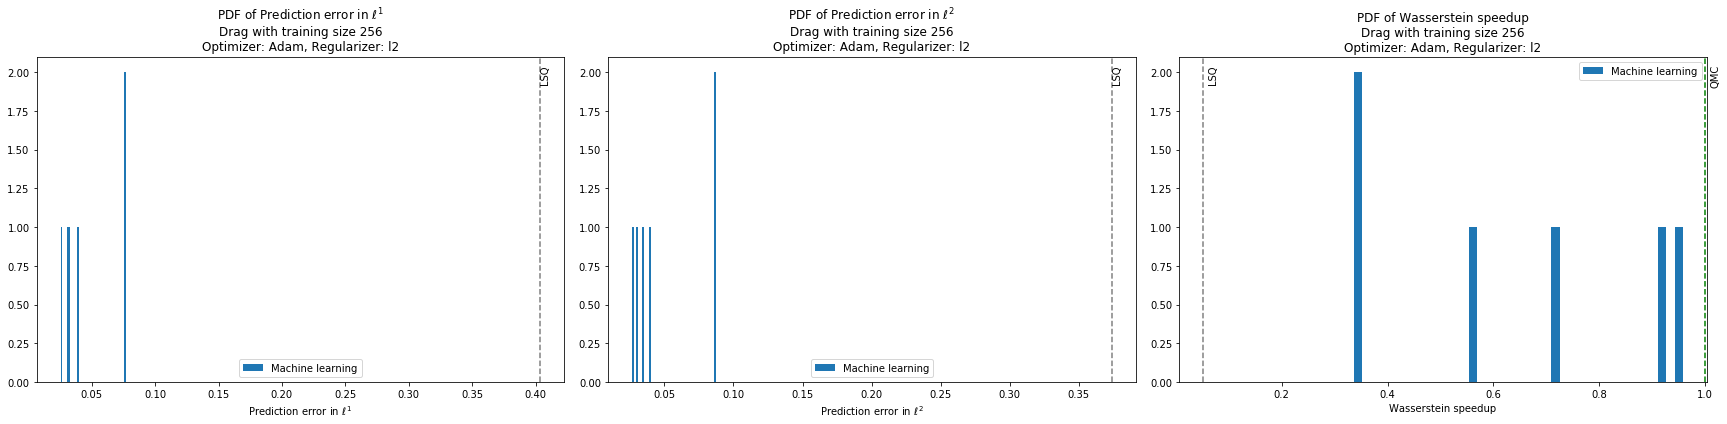

Optimizer: SGD, Regularizer: None


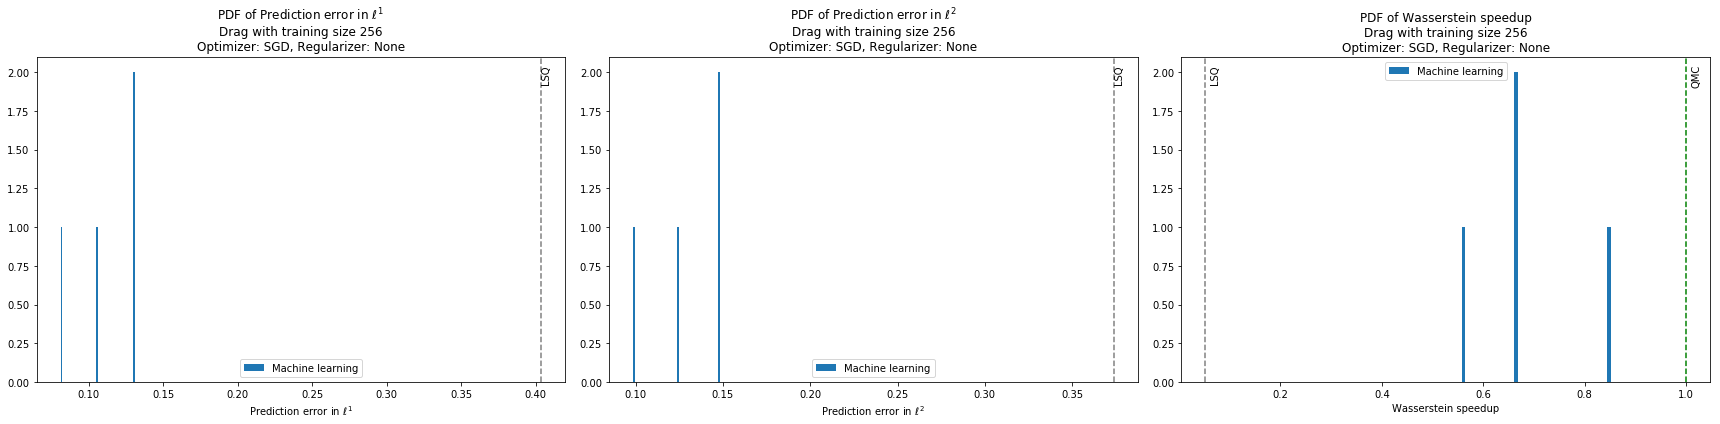

Optimizer: Adam, Regularizer: None


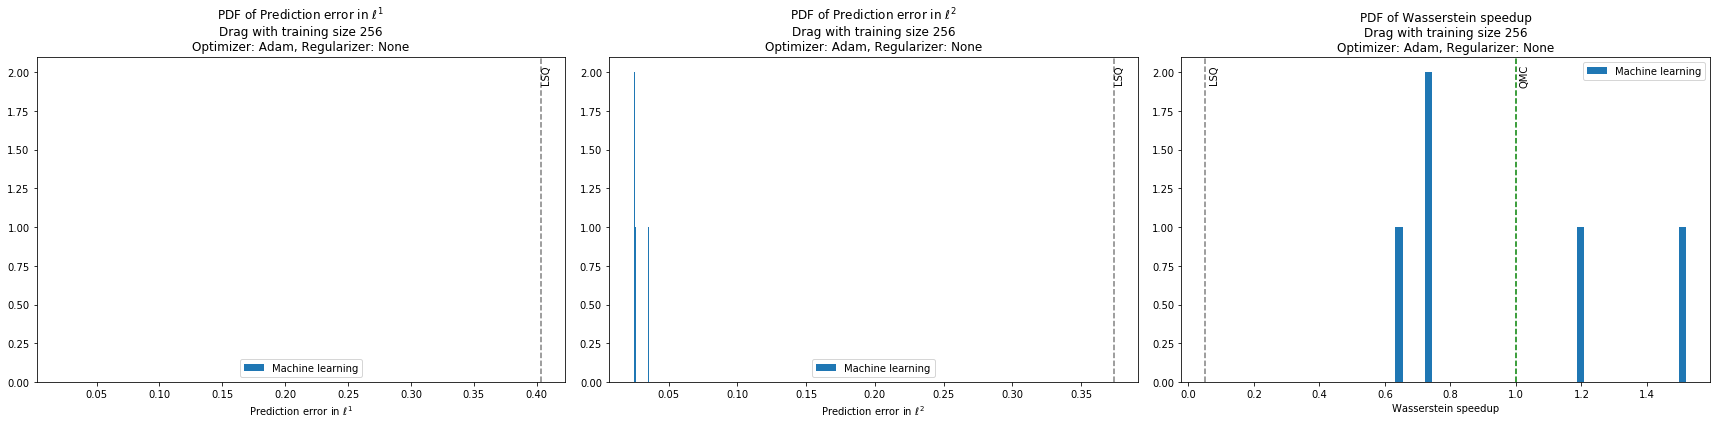

Optimizer: SGD, Regularizer: l1


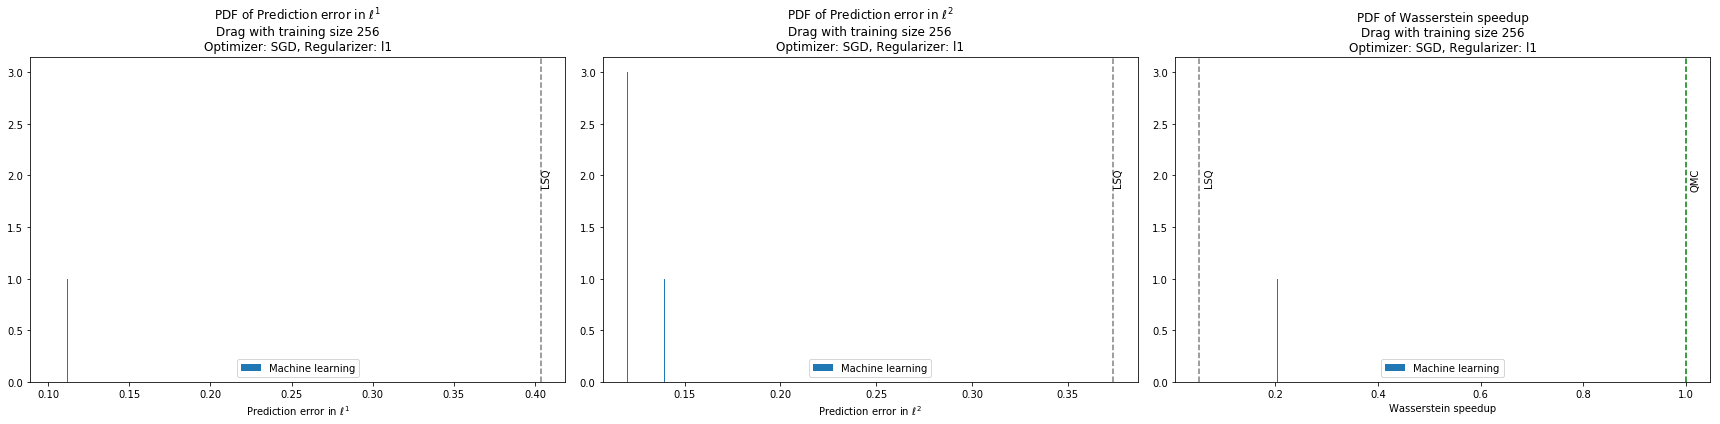

Optimizer: Adam, Regularizer: l1


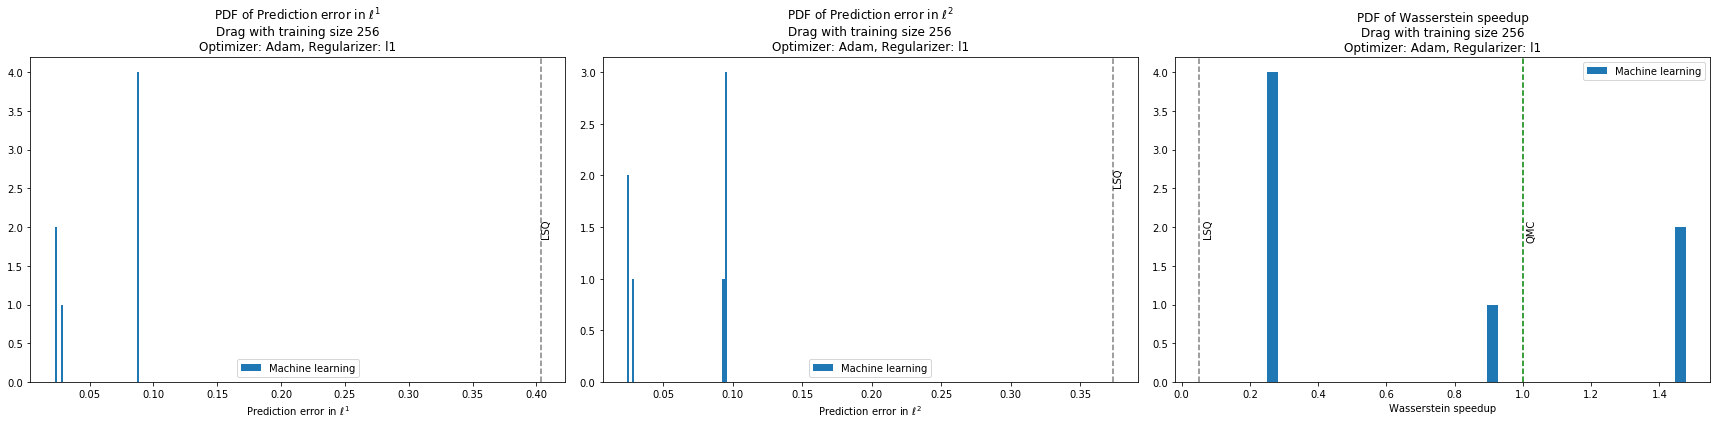

Optimizer: SGD, Regularizer: l2


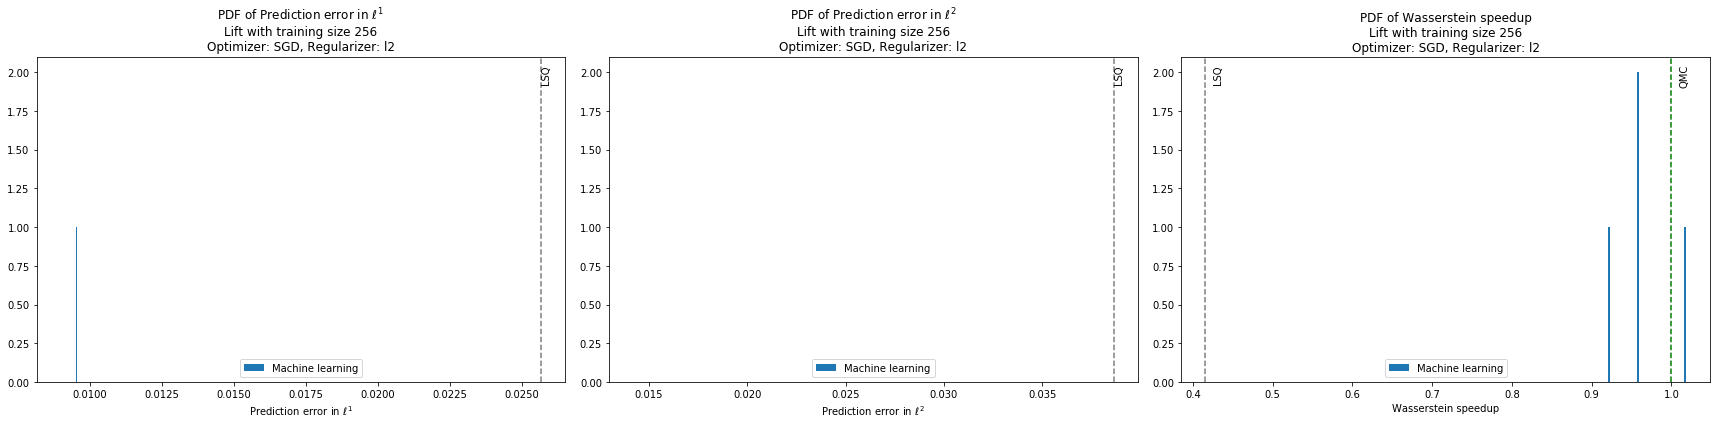

Optimizer: Adam, Regularizer: l2


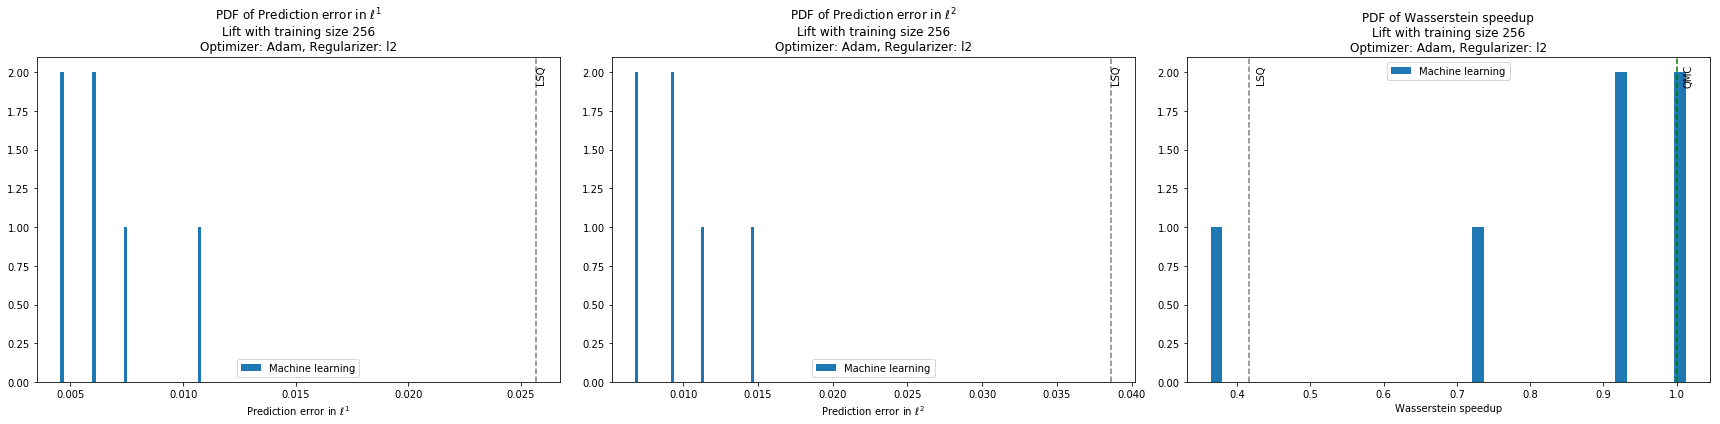

Optimizer: SGD, Regularizer: None


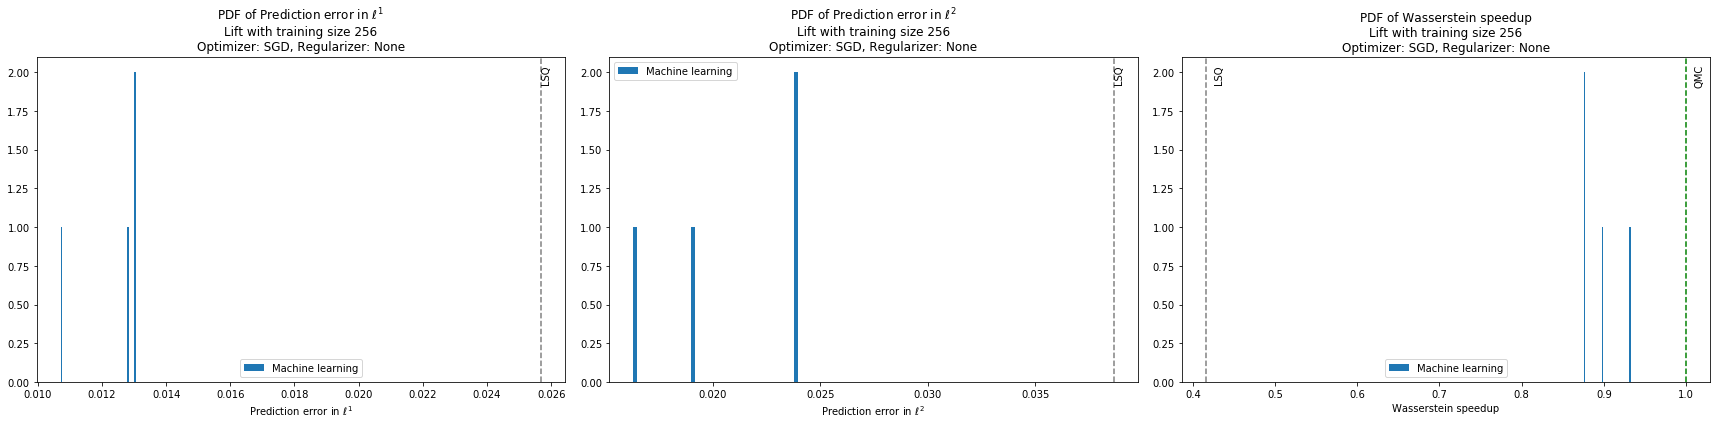

Optimizer: Adam, Regularizer: None


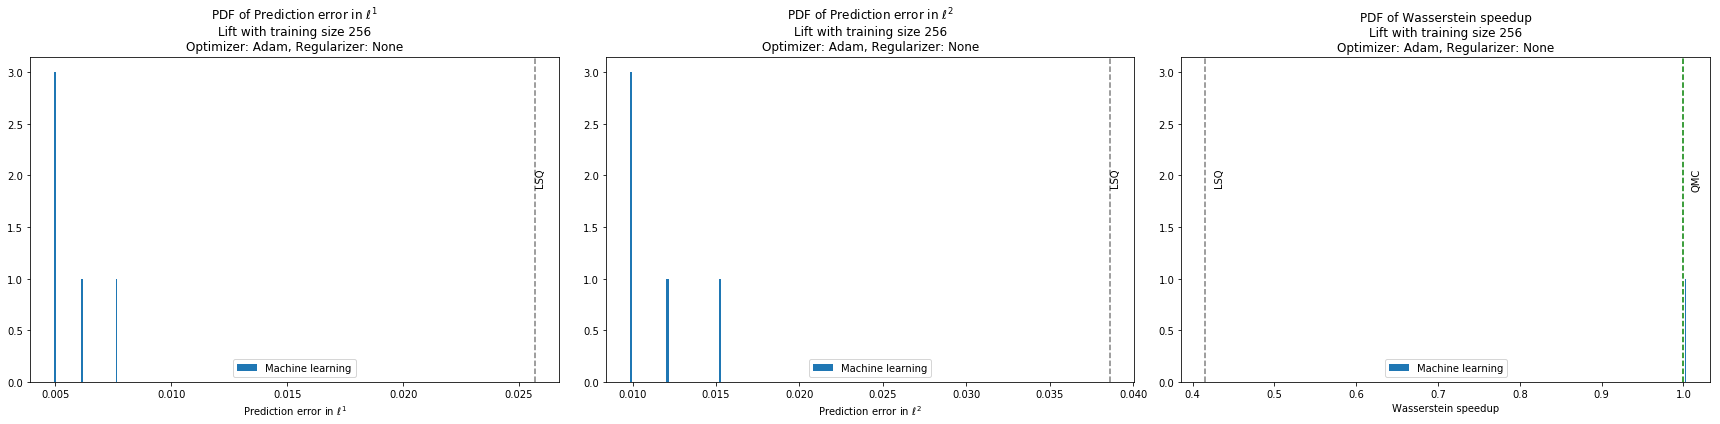

Optimizer: SGD, Regularizer: l1


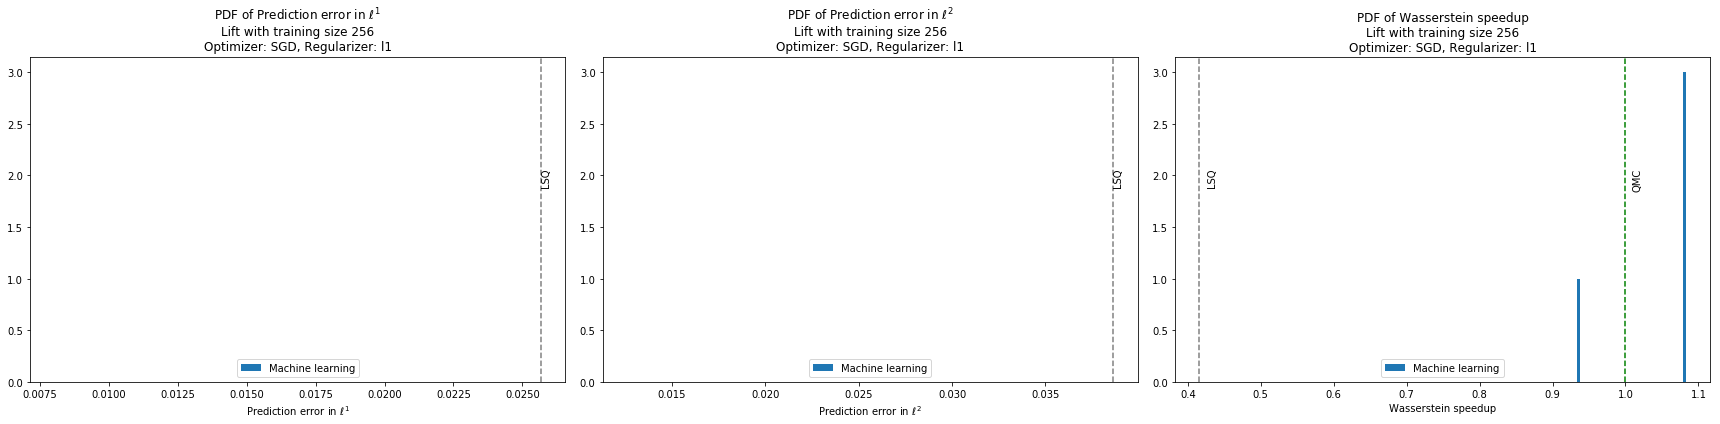

Optimizer: Adam, Regularizer: l1


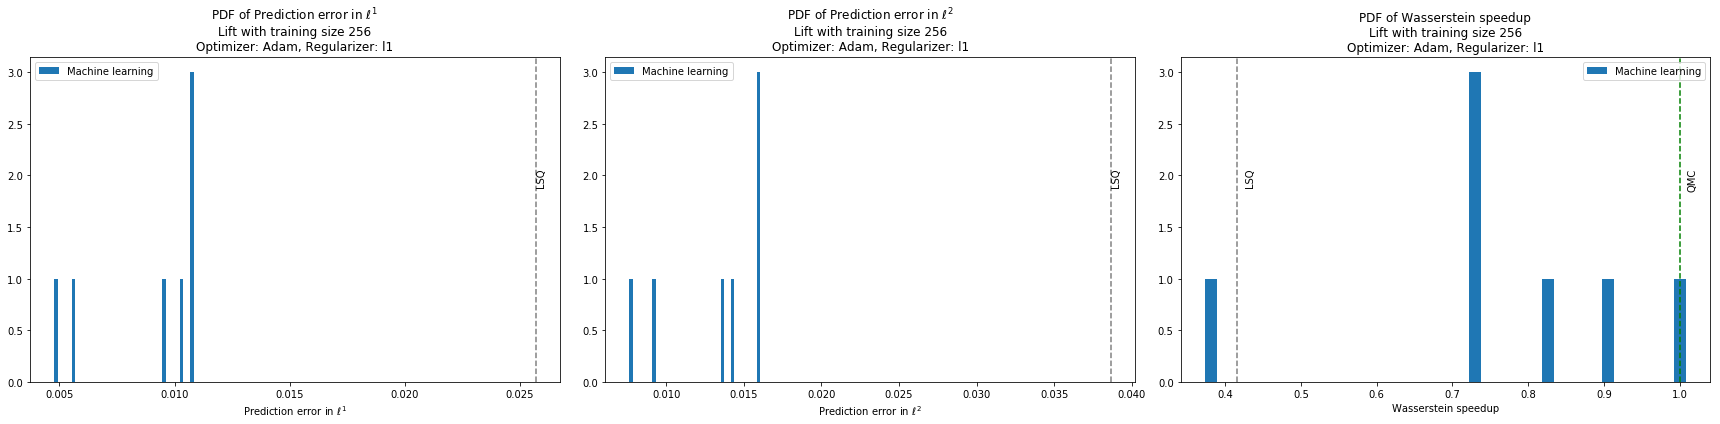

Optimizer: SGD, Regularizer: l2


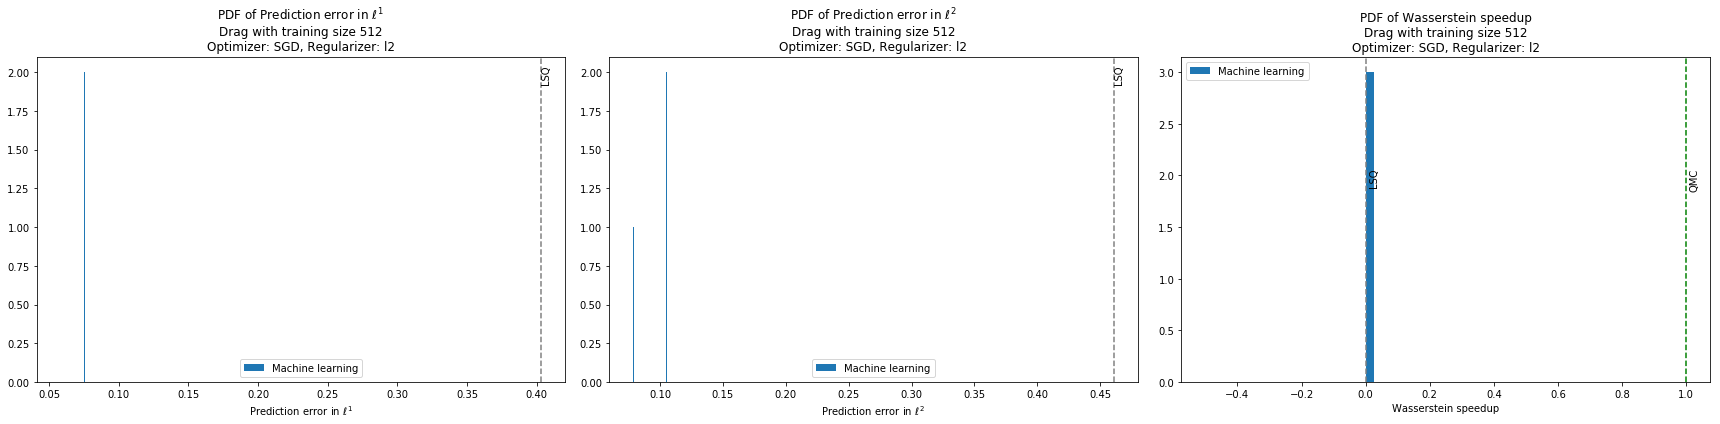

Optimizer: Adam, Regularizer: l2


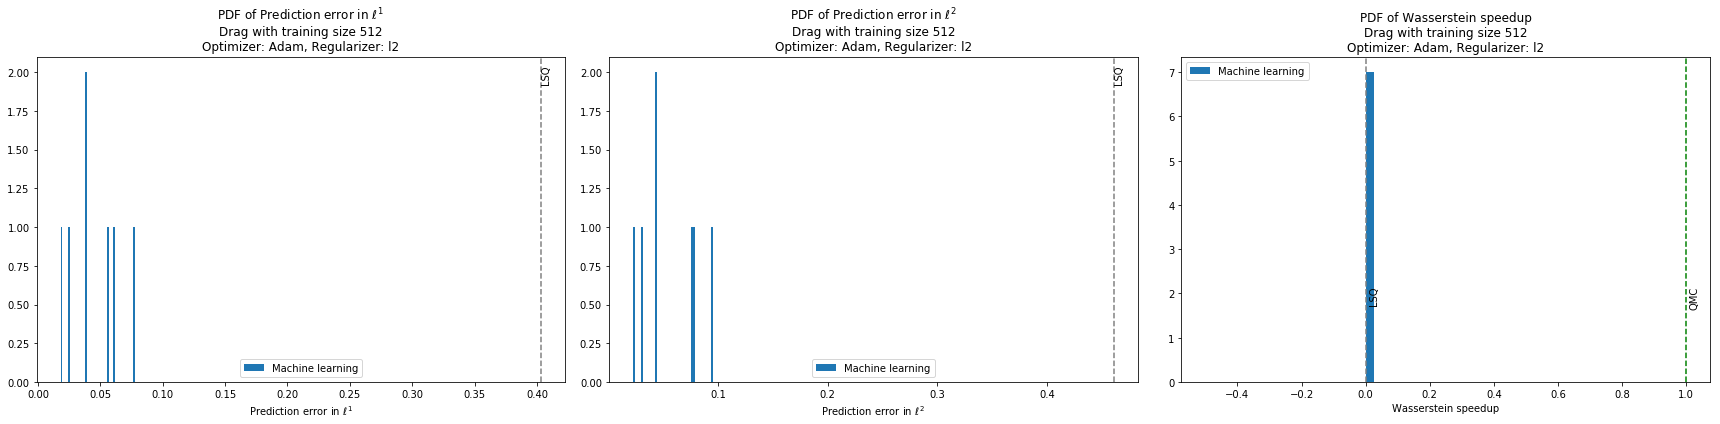

Optimizer: SGD, Regularizer: None


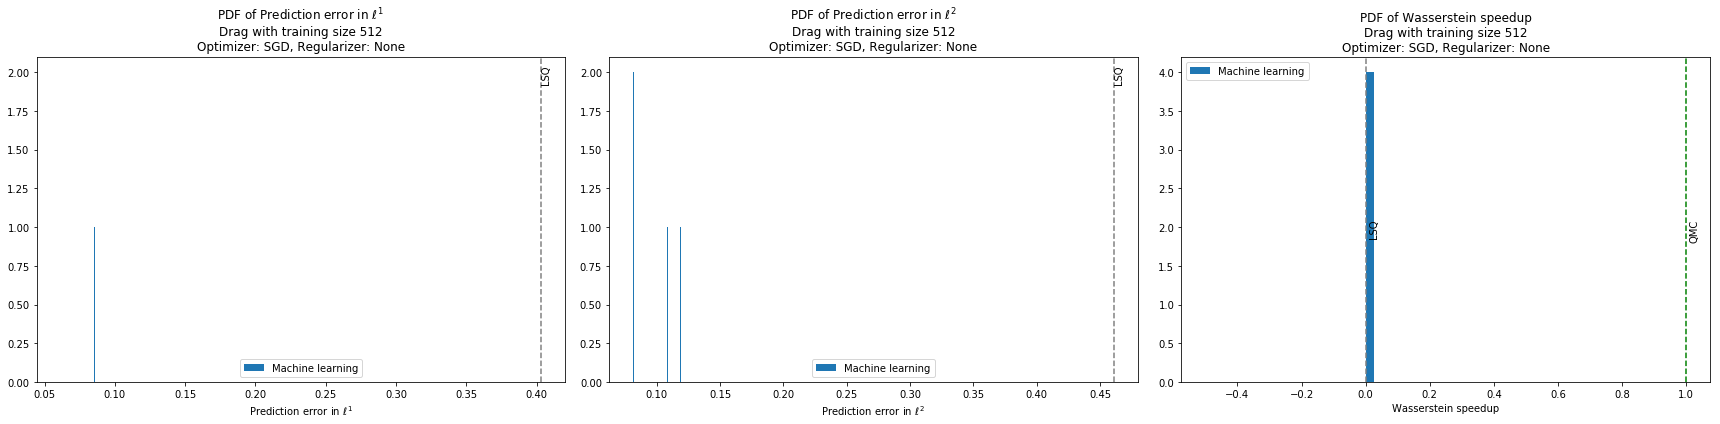

Optimizer: Adam, Regularizer: None


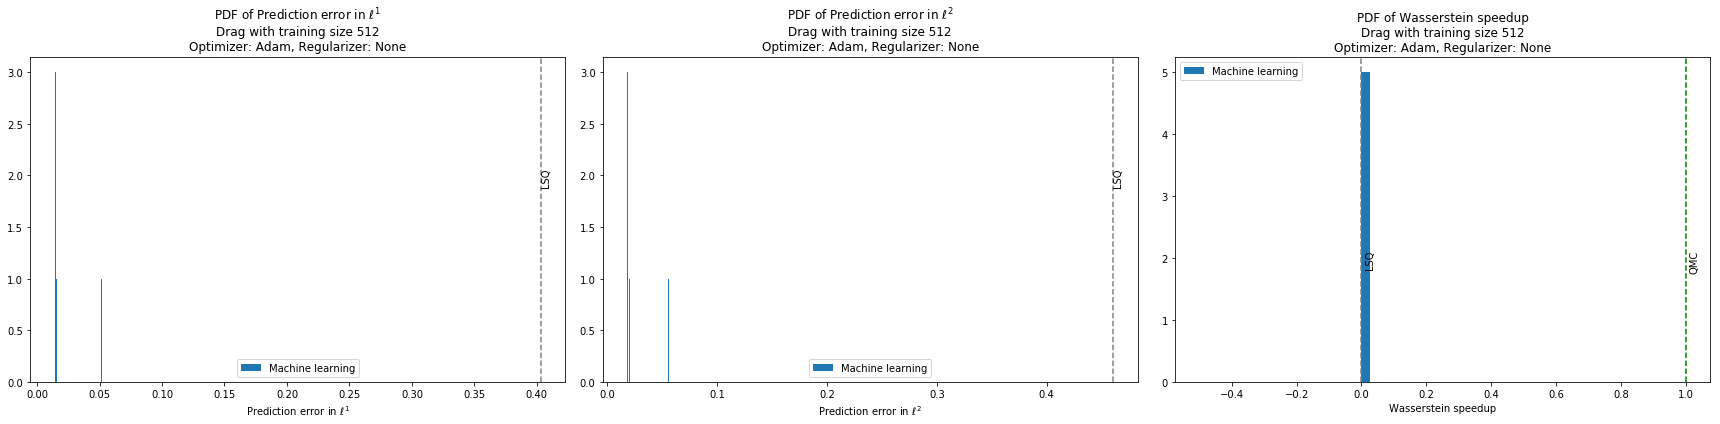

Optimizer: SGD, Regularizer: l1


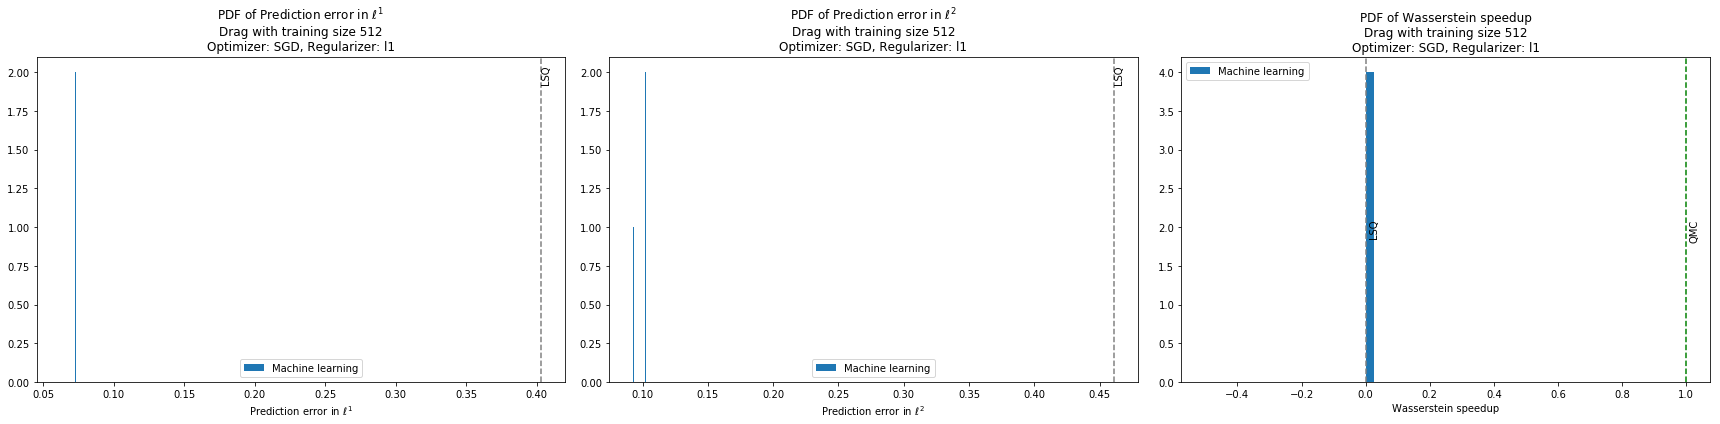

Optimizer: Adam, Regularizer: l1


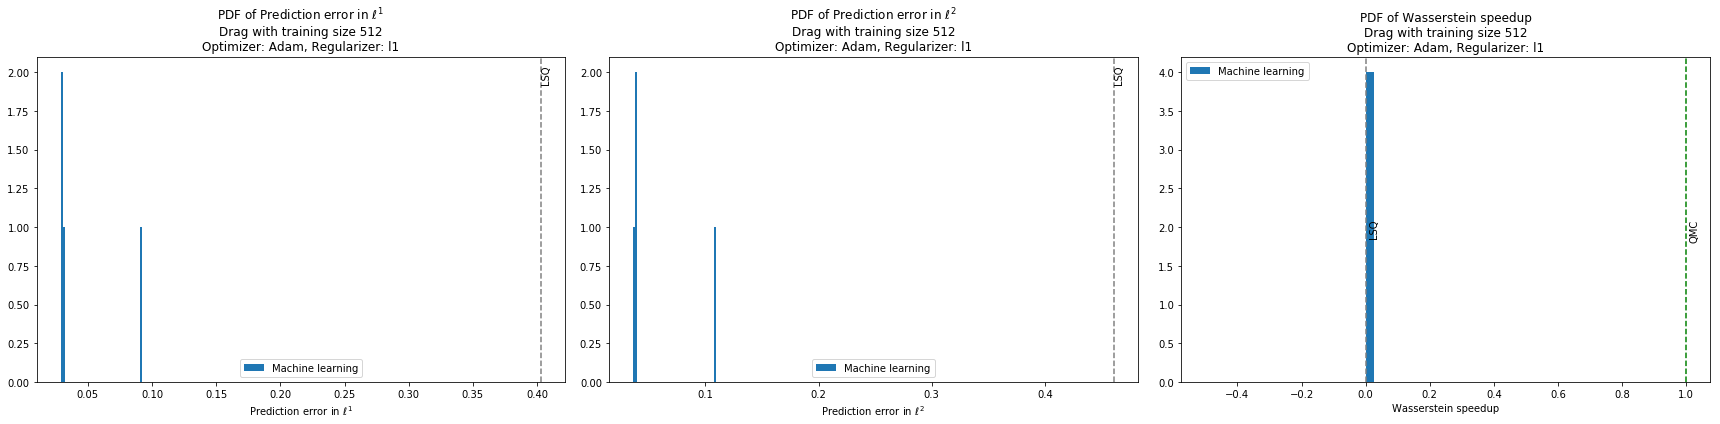

Optimizer: SGD, Regularizer: l2


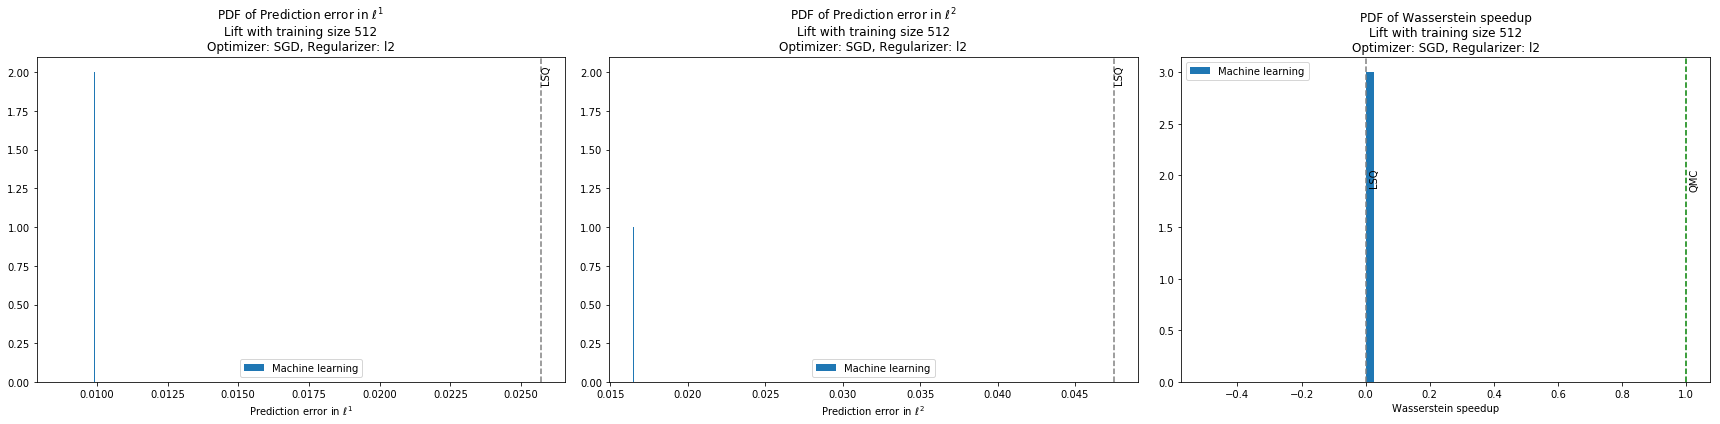

Optimizer: Adam, Regularizer: l2


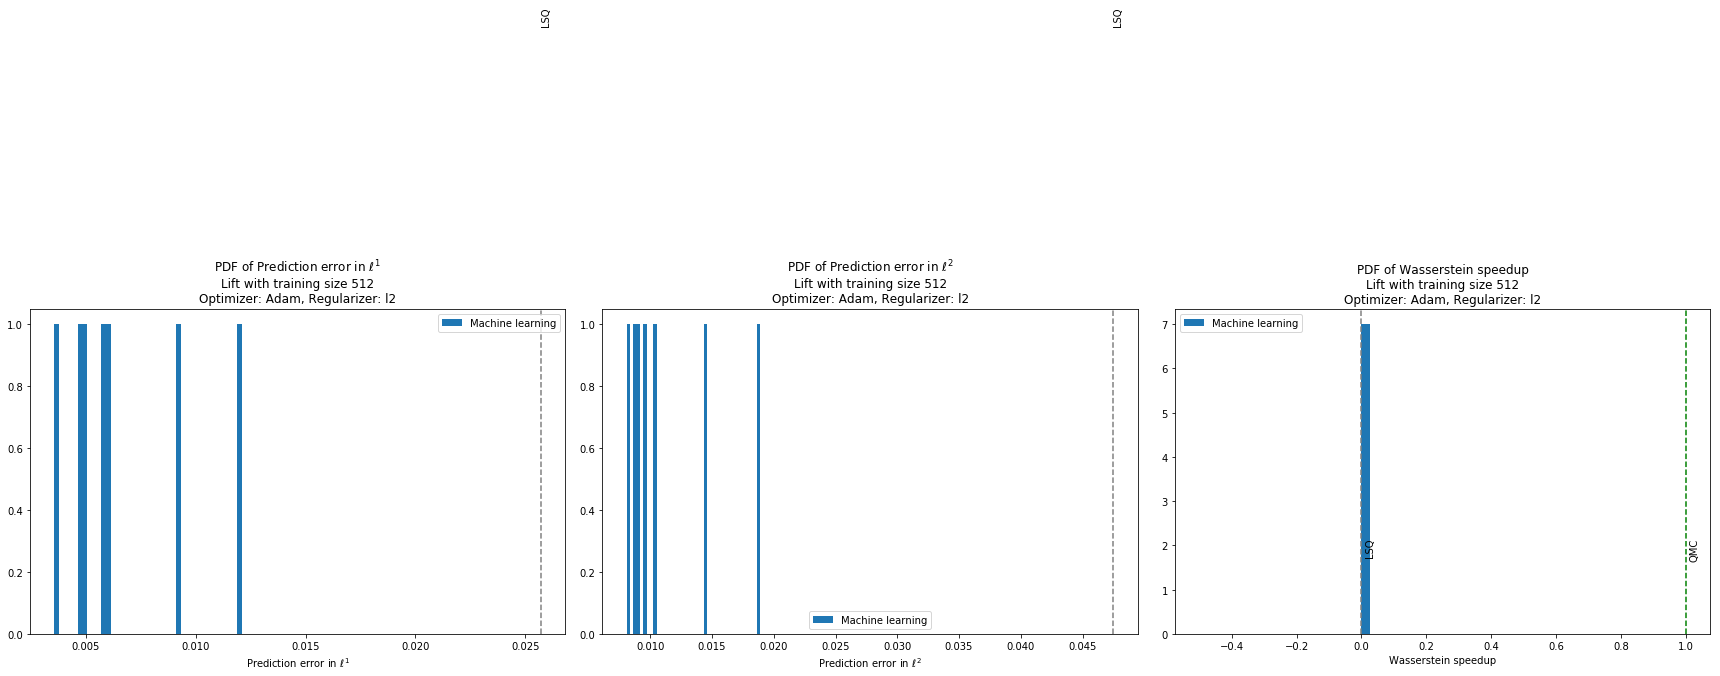

Optimizer: SGD, Regularizer: None


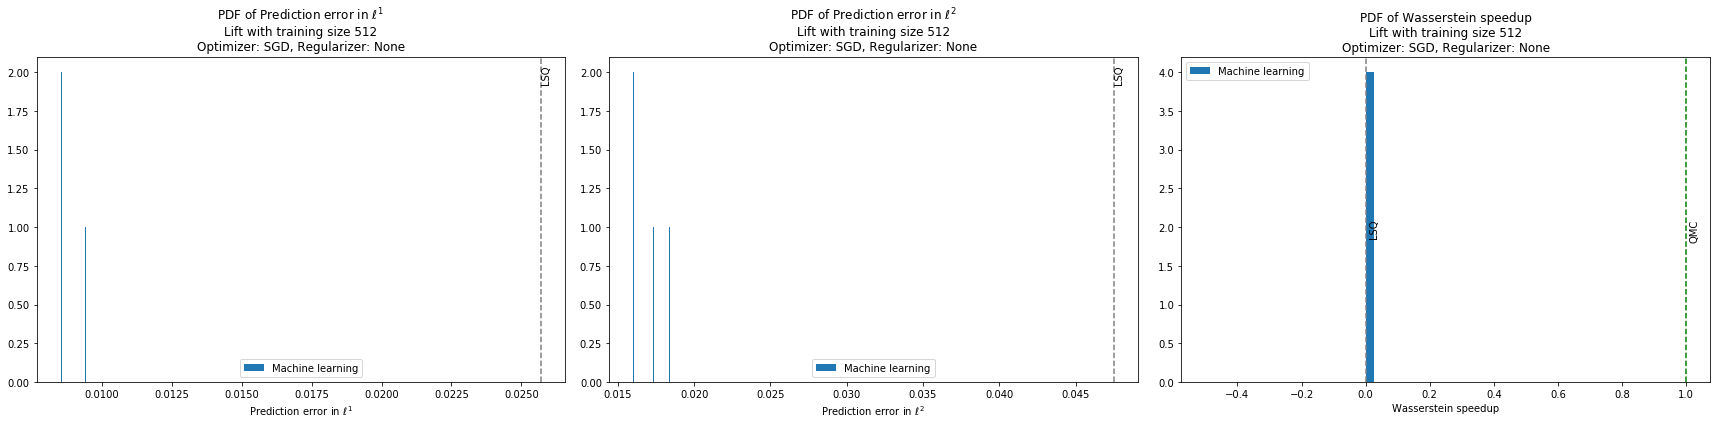

Optimizer: Adam, Regularizer: None


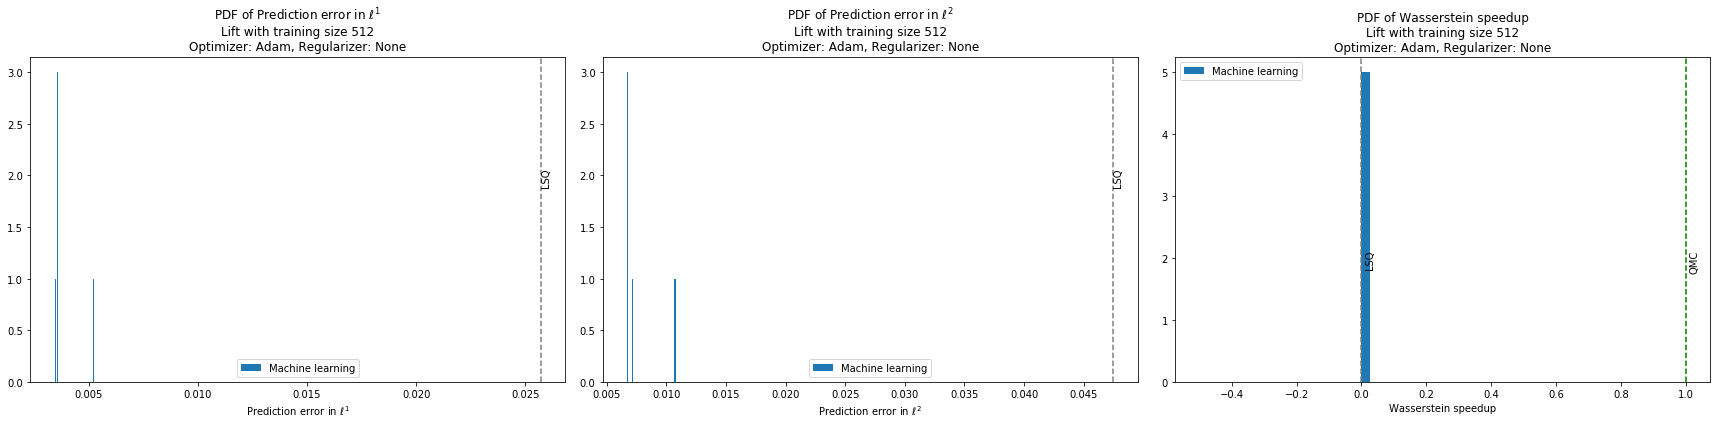

Optimizer: SGD, Regularizer: l1


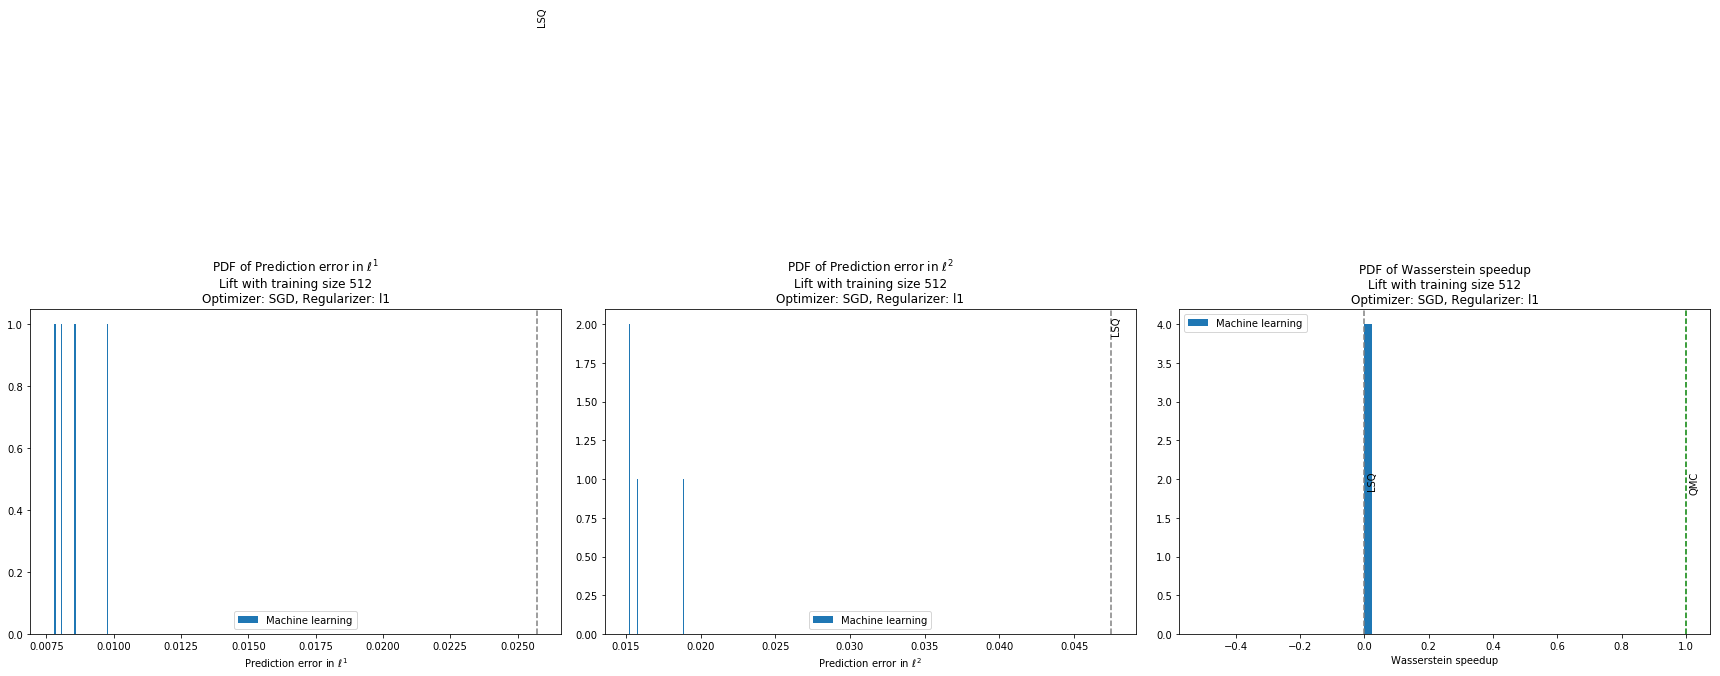

Optimizer: Adam, Regularizer: l1


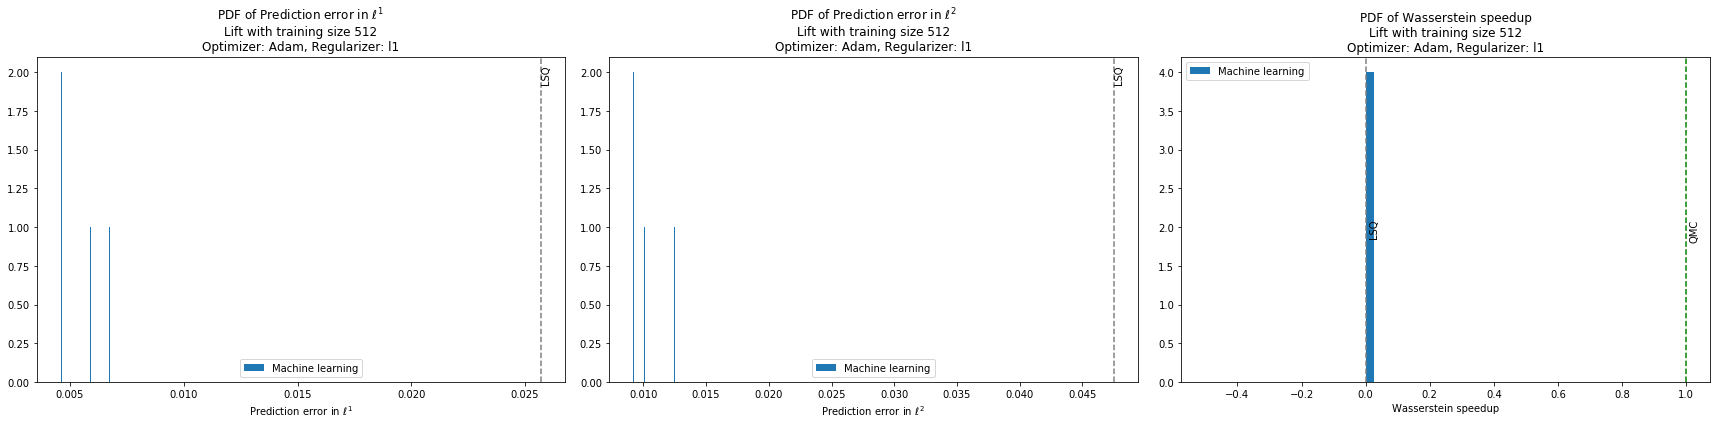

In [24]:

for selection_type in all_configs['selection_type']:
    plot_info.display(plot_info.HTML("<h1>{}</h1>".format(selection_type)))
    for training_size in all_prediction_l1_errors_training_size.keys():
        if training_size > 128:
            continue
        plot_info.display(plot_info.HTML("<h2>Train size: {}</h2>".format(training_size)))
        for func in functional_names:
            plot_info.display(plot_info.HTML("<h3>{}</h3>".format(func)))
            for regularizer in all_configs['regularizer']:
                plot_info.display(plot_info.HTML("<h4>{}</h4>".format(regularizer)))
                
                

                for optimizer in all_configs['optimizer']:
                    measurements_local = []
                    predictions_l1 = []
                    predictions_l2 = []
                    wasserstein_speedup = []
                    wasserstein_errors = []
                    
                    lsq_predictions_l1 = lsq_prediction_errors_l1[training_size][func]
                    lsq_predictions_l2 = lsq_prediction_errors_l2[training_size][func]
                    lsq_wasserstein_speedup = lsq_wasserstein_speedups_training_size[training_size][func]
                    
                    for m in measurements[func]:
                        if to_str(m.properties['regularizer']) == to_str(regularizer) and m.properties['optimizer'] == optimizer:
                            if m.properties['selection_type'] == selection_type:
                                if m.properties['train_size'] == training_size:
                                    measurements_local.append(m)
                    if len(measurements_local) == 0:
                        print(parameter)
                        continue
                    for m in measurements_local:
                        predictions_l1.append(m.prediction_error_l1)
                        predictions_l2.append(m.prediction_error_l2)
                        wasserstein_speedup.append(m.wasserstein_speedup)
                        wasserstein_errors.append(m.wasserstein_error)
                    
                    extra_title = "Optimizer: {}, Regularizer: {}".format(optimizer, regularizer)
                    print(extra_title)
                    plot_histograms(predictions_l1, lsq_predictions_l1, predictions_l2,lsq_predictions_l2,
                       wasserstein_speedup, lsq_wasserstein_speedup, wasserstein_errors,
                       func, training_size, 
                                   extra_title)
                

# Fixing two parameters at the same time

optimizer: SGD, regularizer: l2


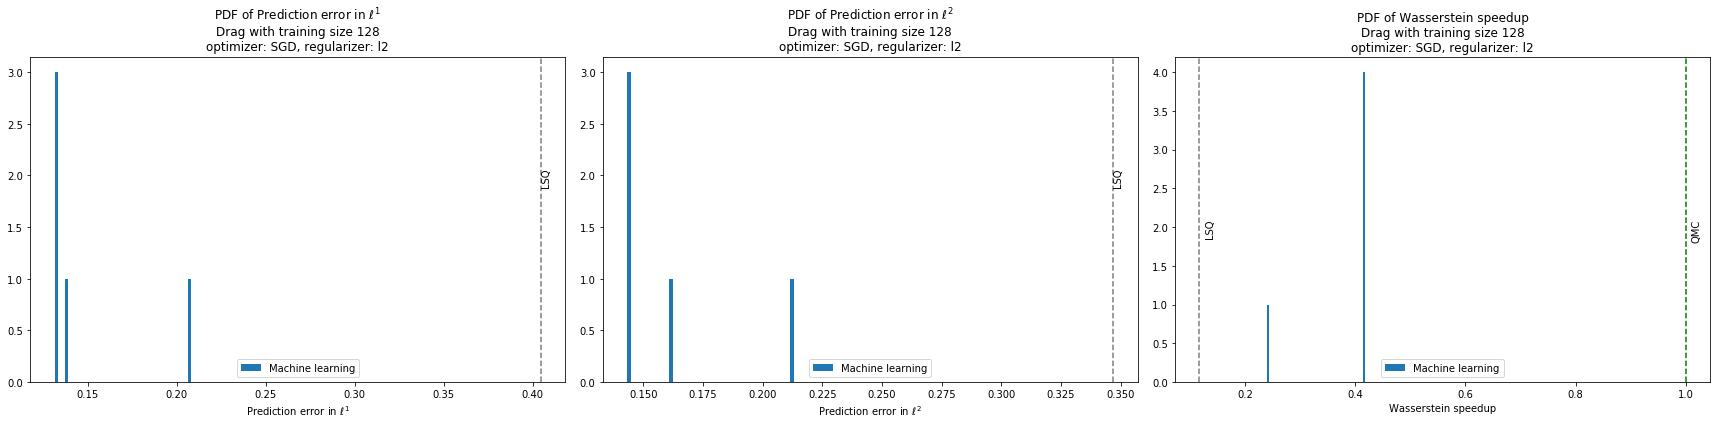

optimizer: SGD, regularizer: None


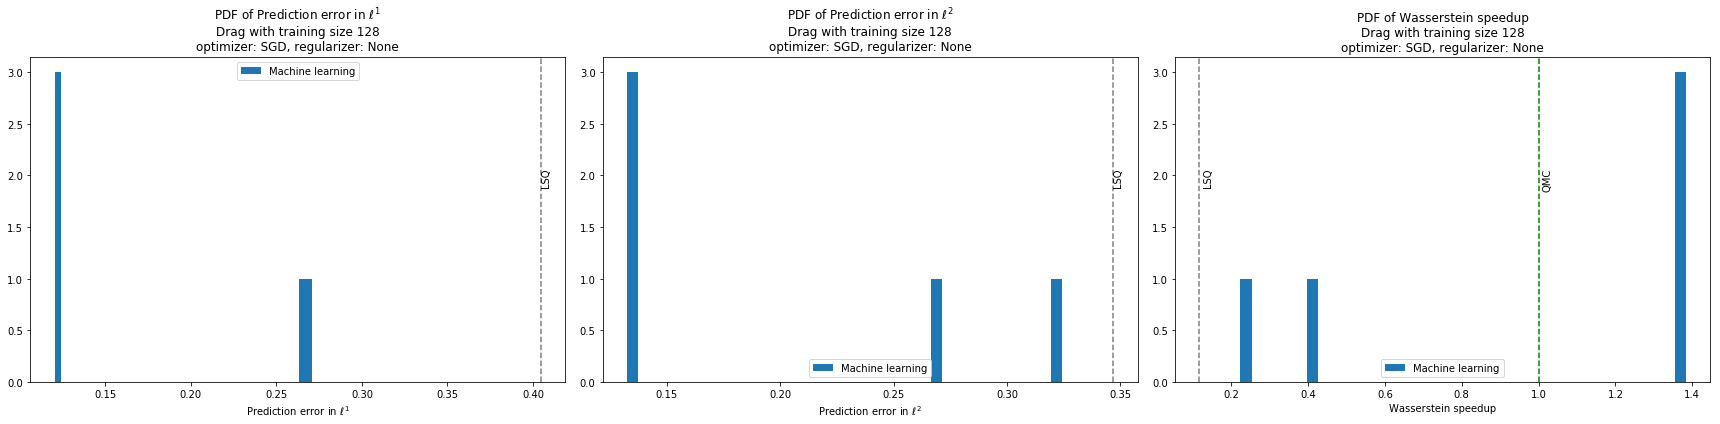

optimizer: SGD, regularizer: l1


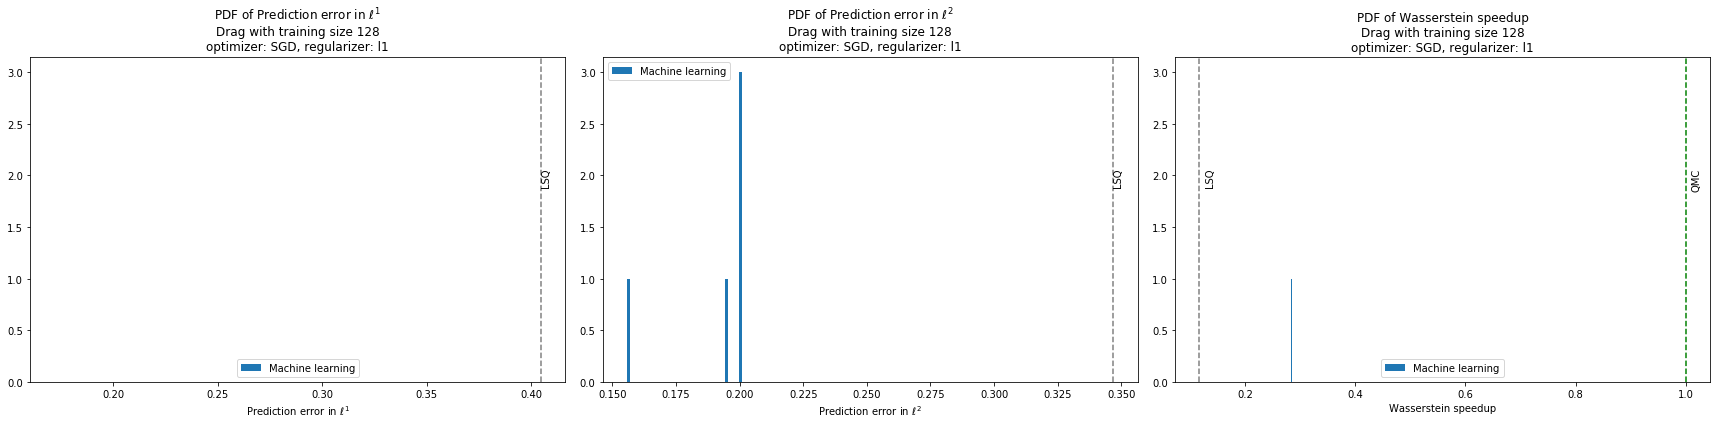

optimizer: Adam, regularizer: l2


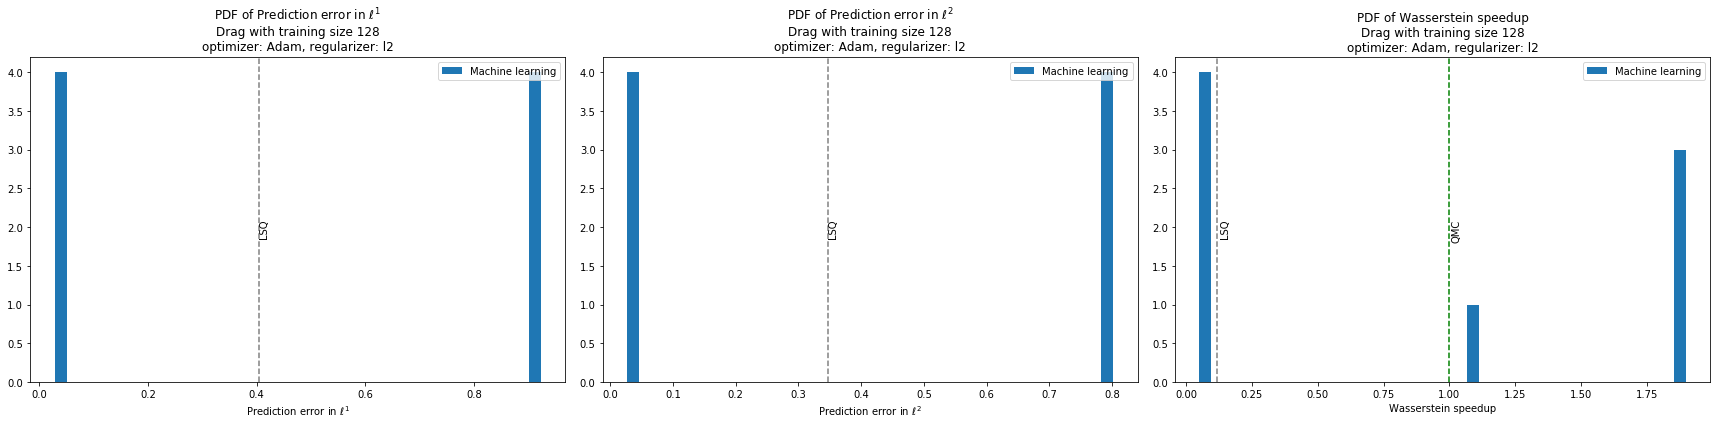

optimizer: Adam, regularizer: None


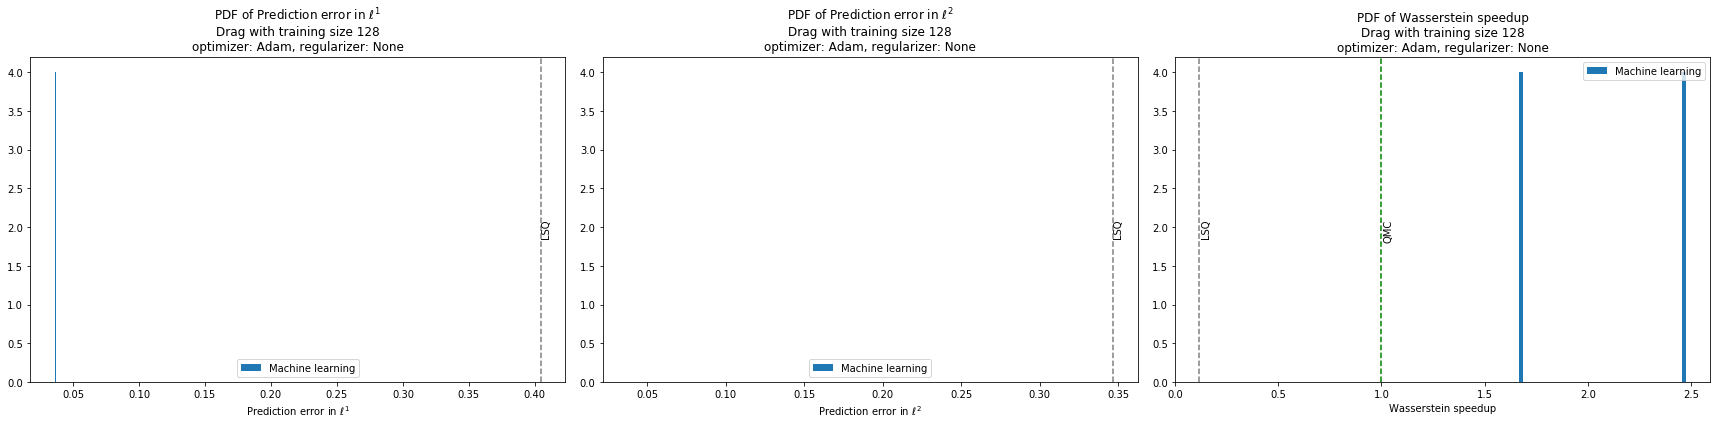

optimizer: Adam, regularizer: l1


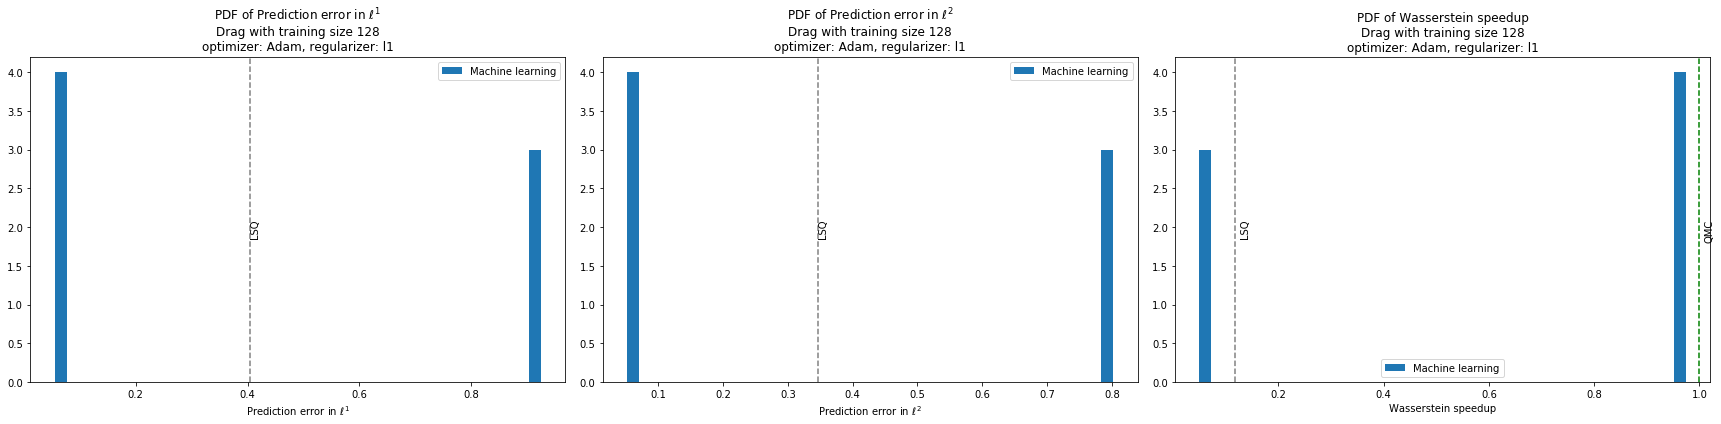

optimizer: SGD, loss: mean_squared_error


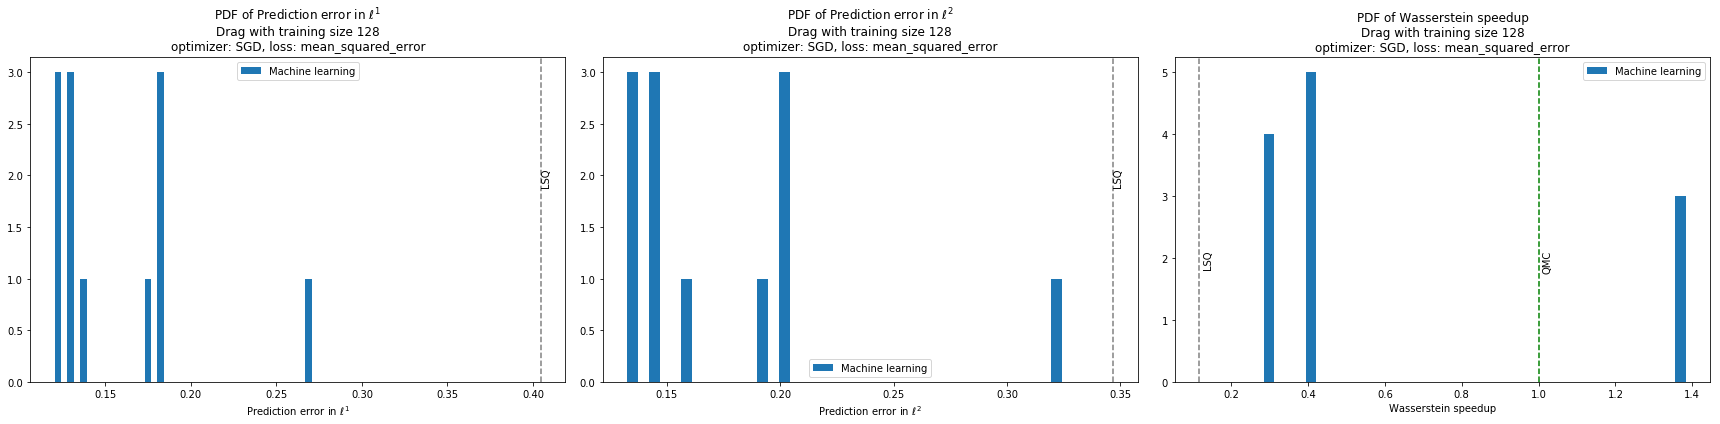

optimizer: SGD, loss: mean_absolute_error


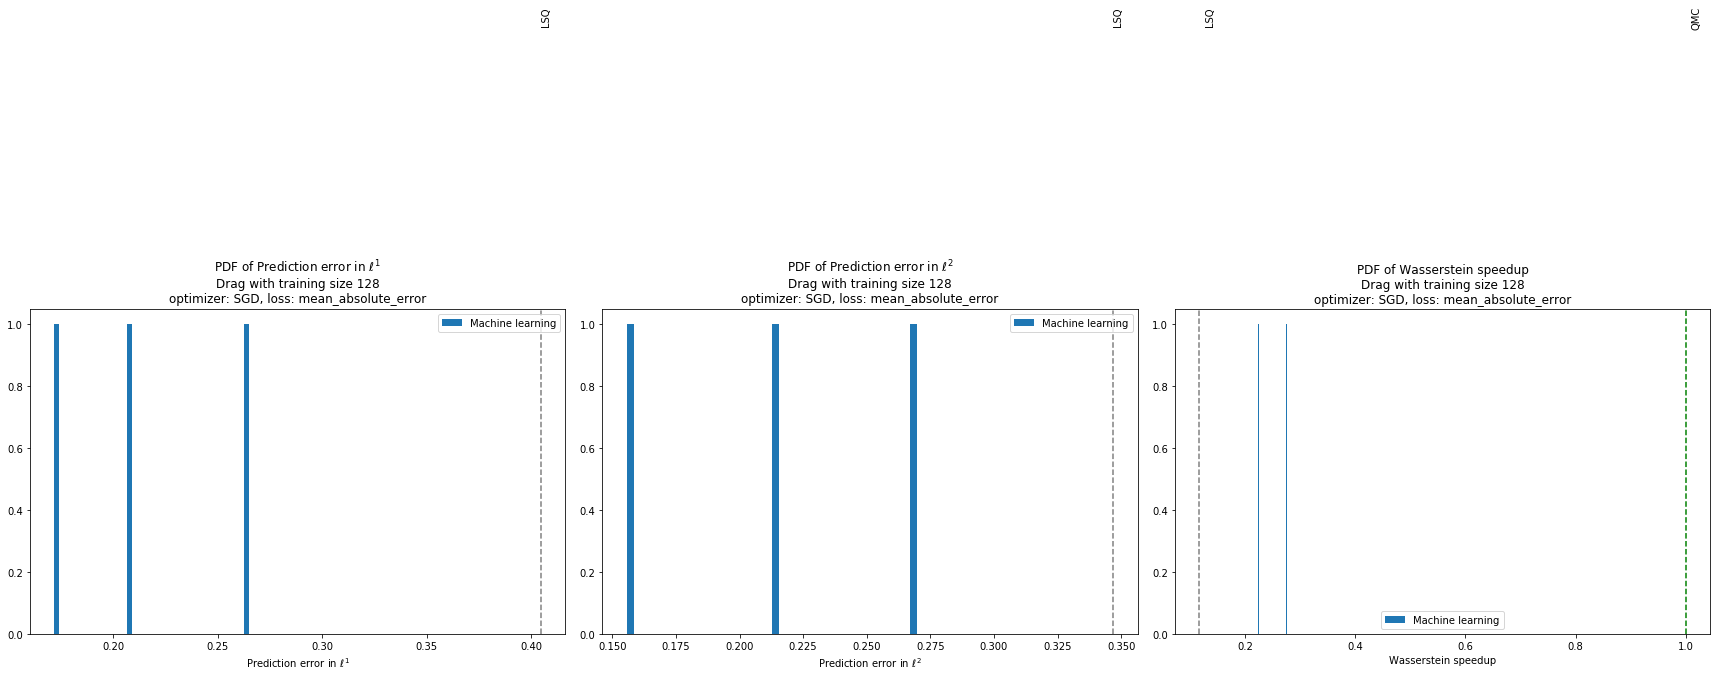

optimizer: Adam, loss: mean_squared_error


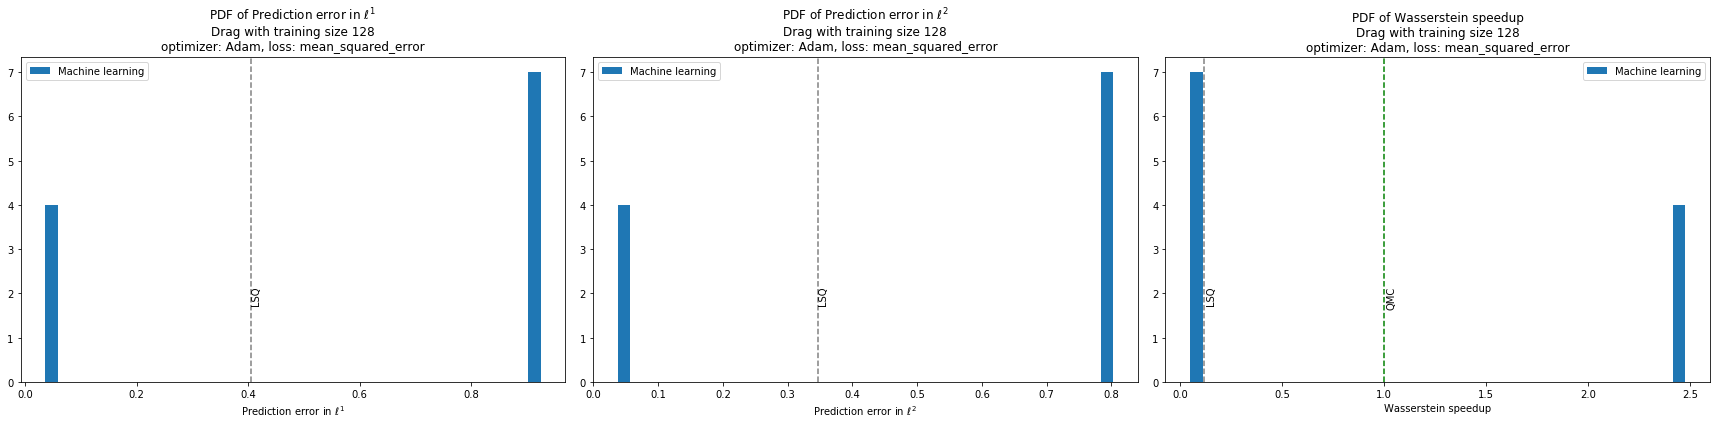

optimizer: Adam, loss: mean_absolute_error


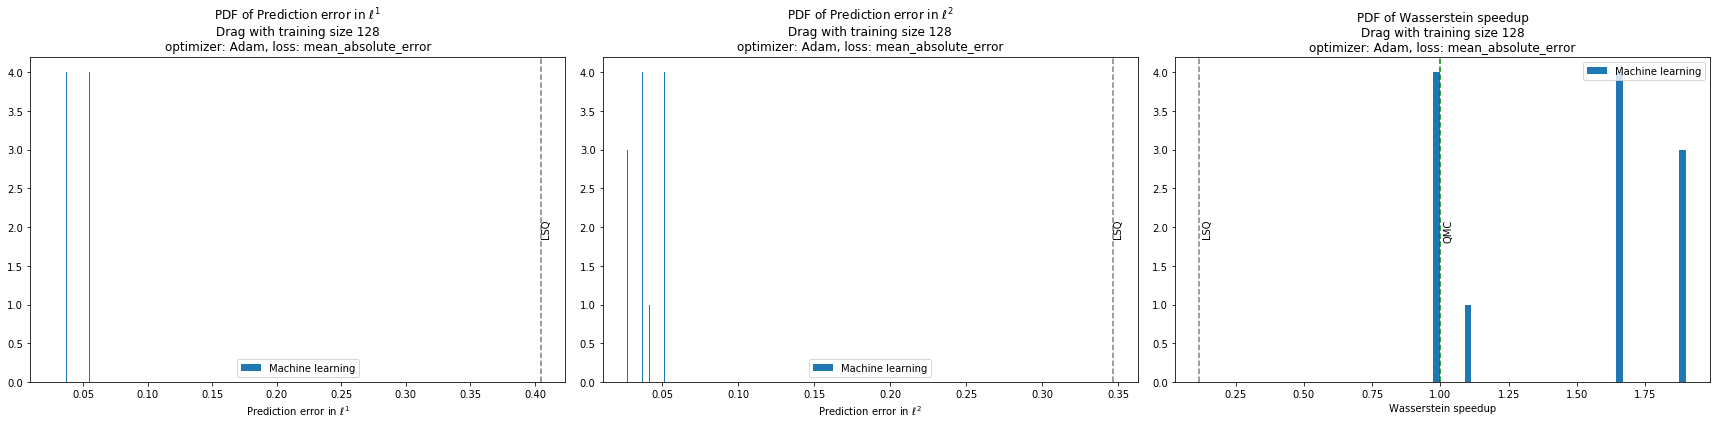

regularizer: l2, optimizer: SGD


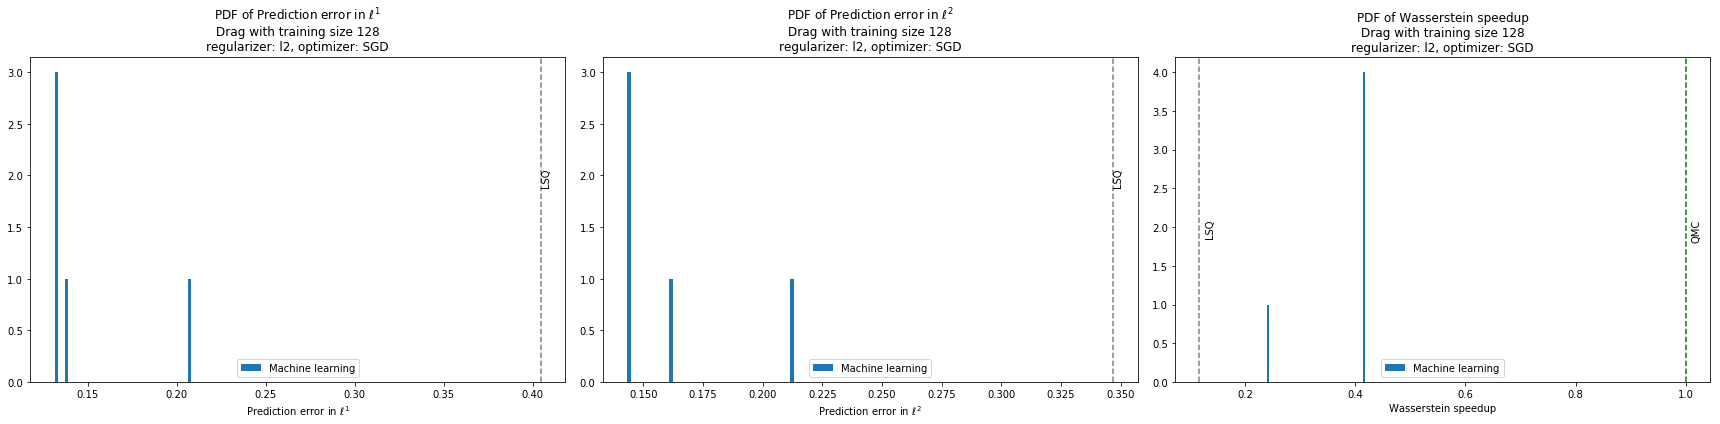

regularizer: l2, optimizer: Adam


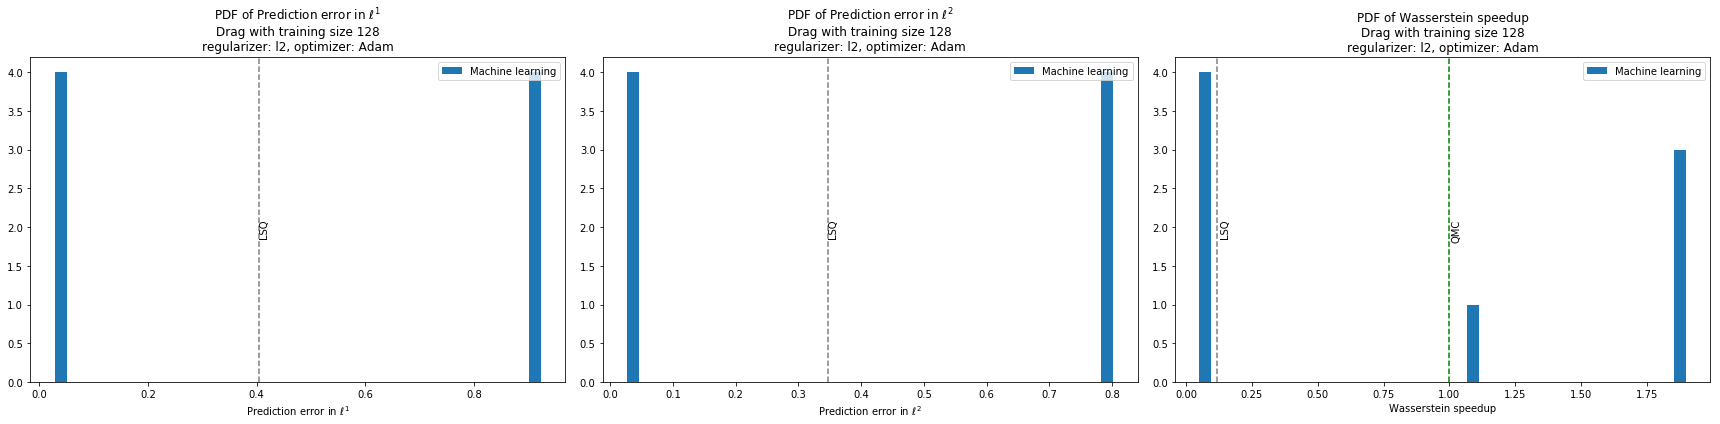

regularizer: None, optimizer: SGD


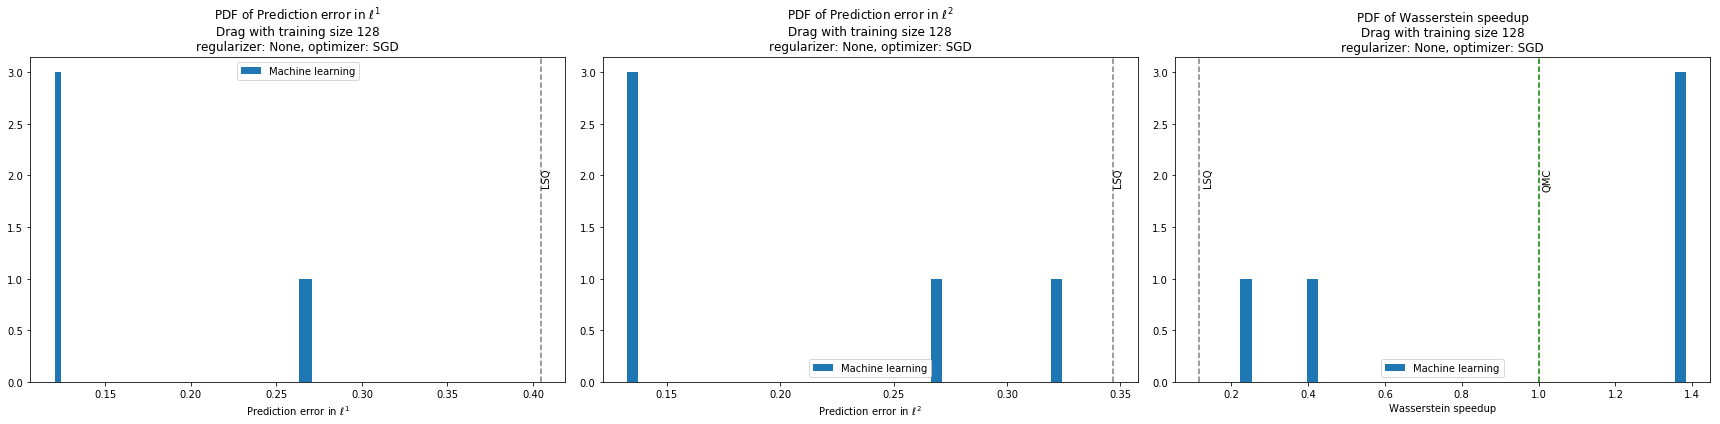

regularizer: None, optimizer: Adam


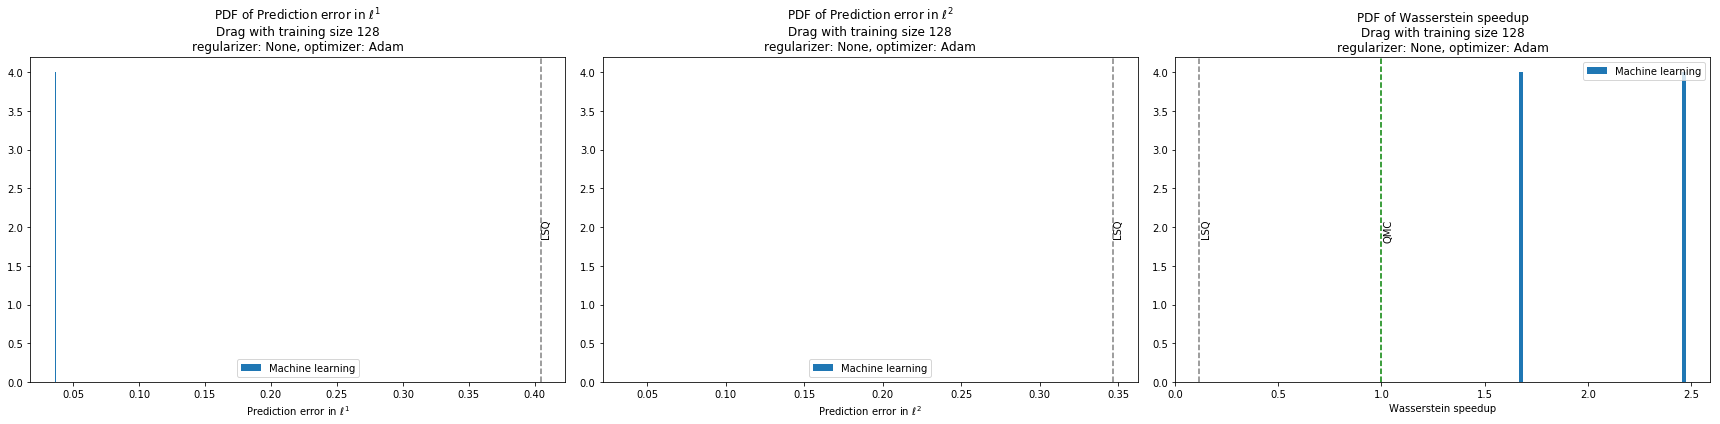

regularizer: l1, optimizer: SGD


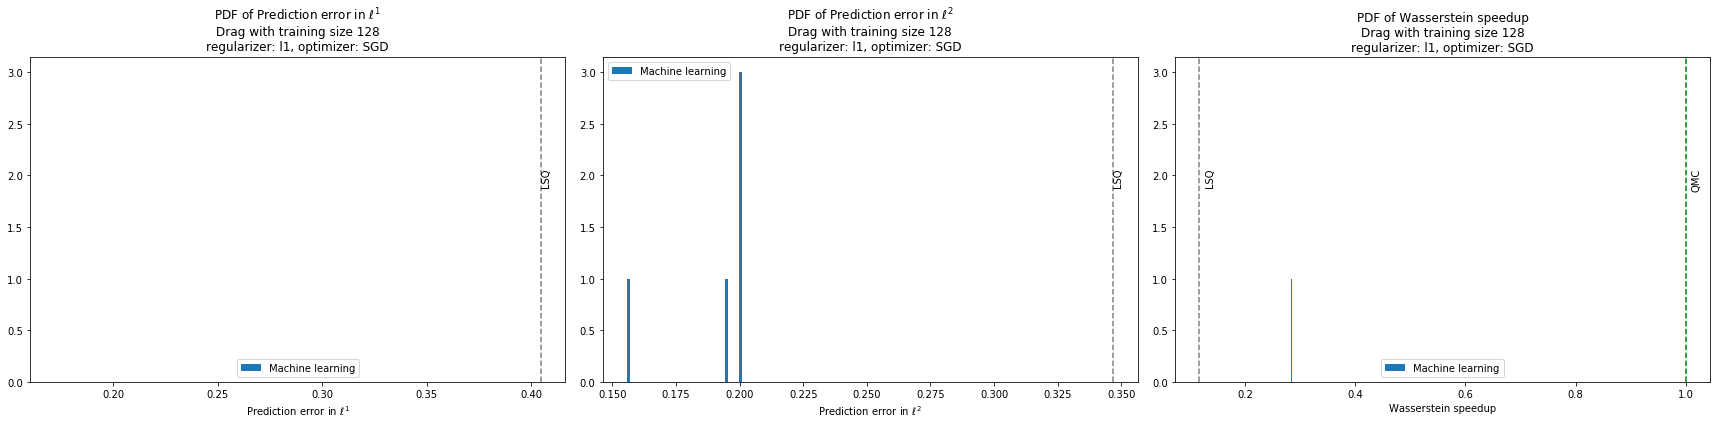

regularizer: l1, optimizer: Adam


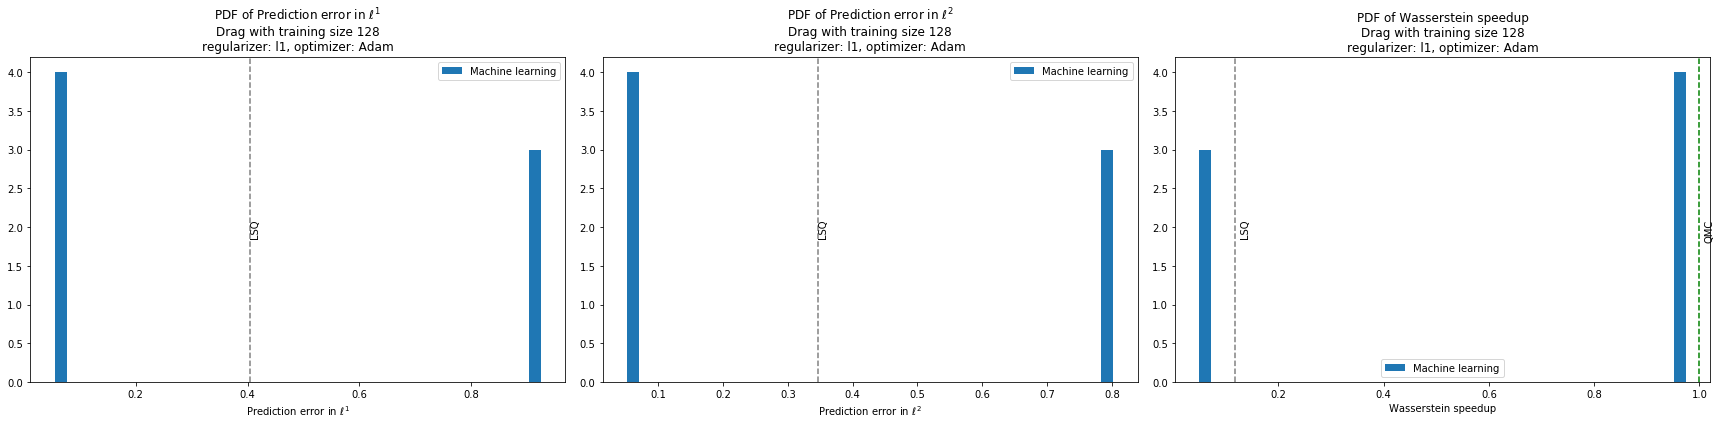

regularizer: l2, loss: mean_squared_error


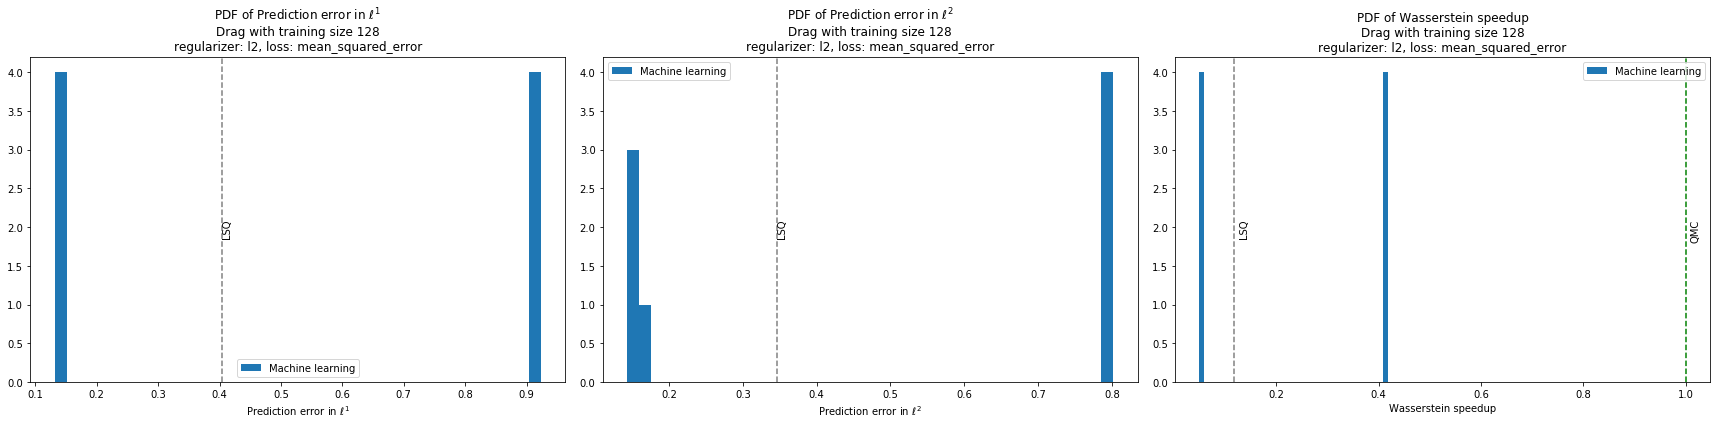

regularizer: l2, loss: mean_absolute_error


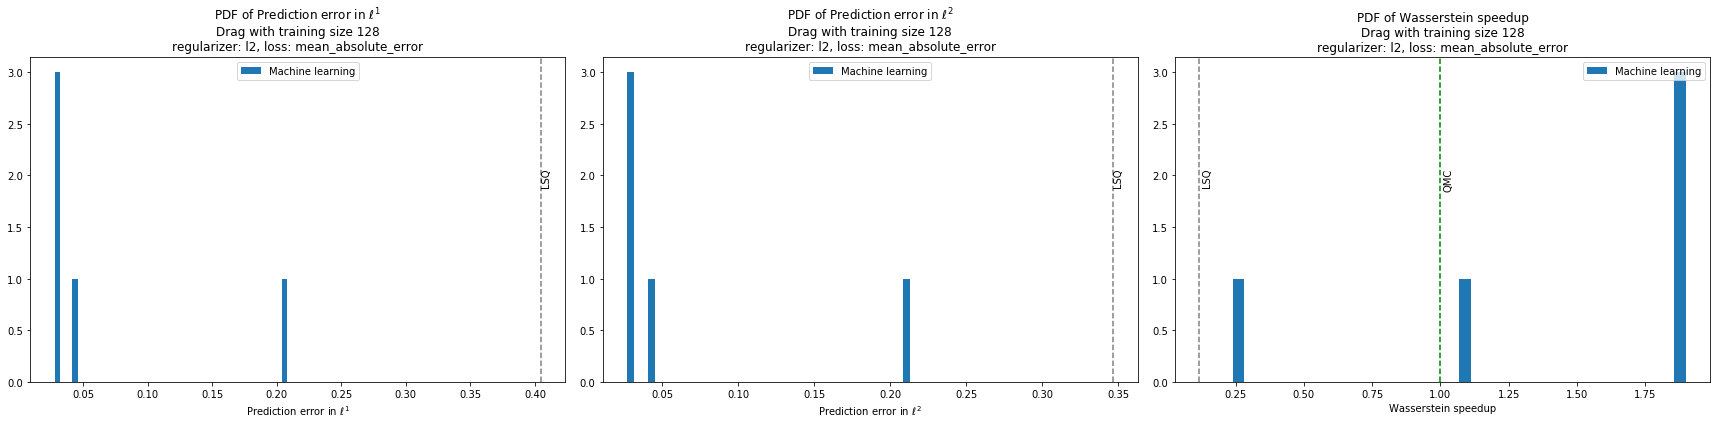

regularizer: None, loss: mean_squared_error


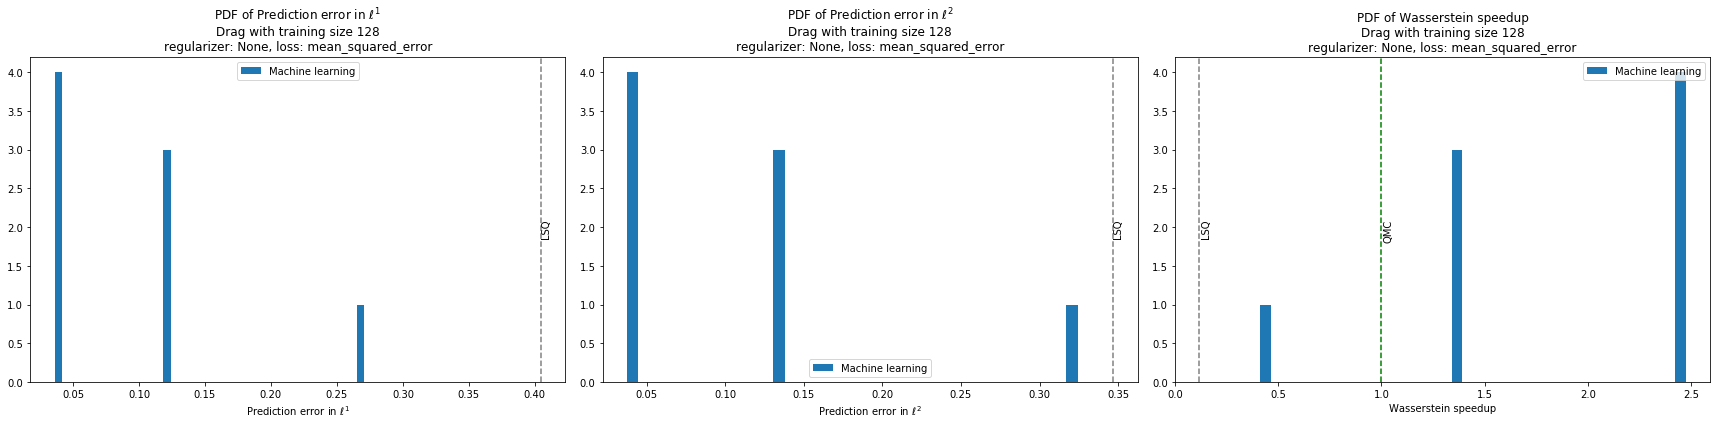

regularizer: None, loss: mean_absolute_error


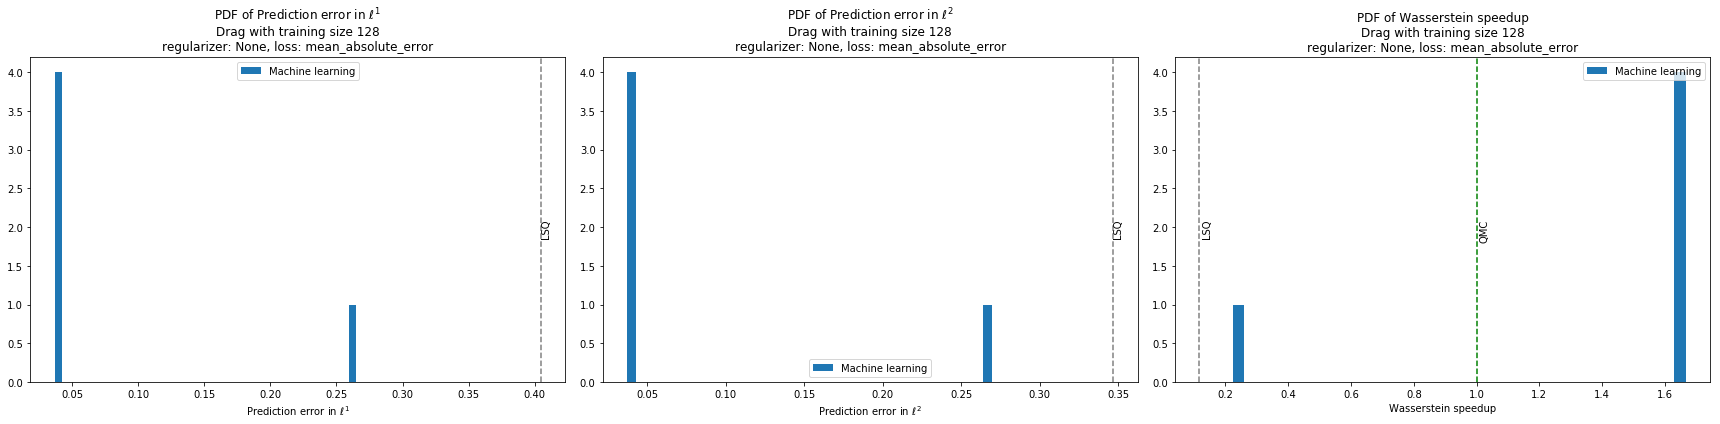

regularizer: l1, loss: mean_squared_error


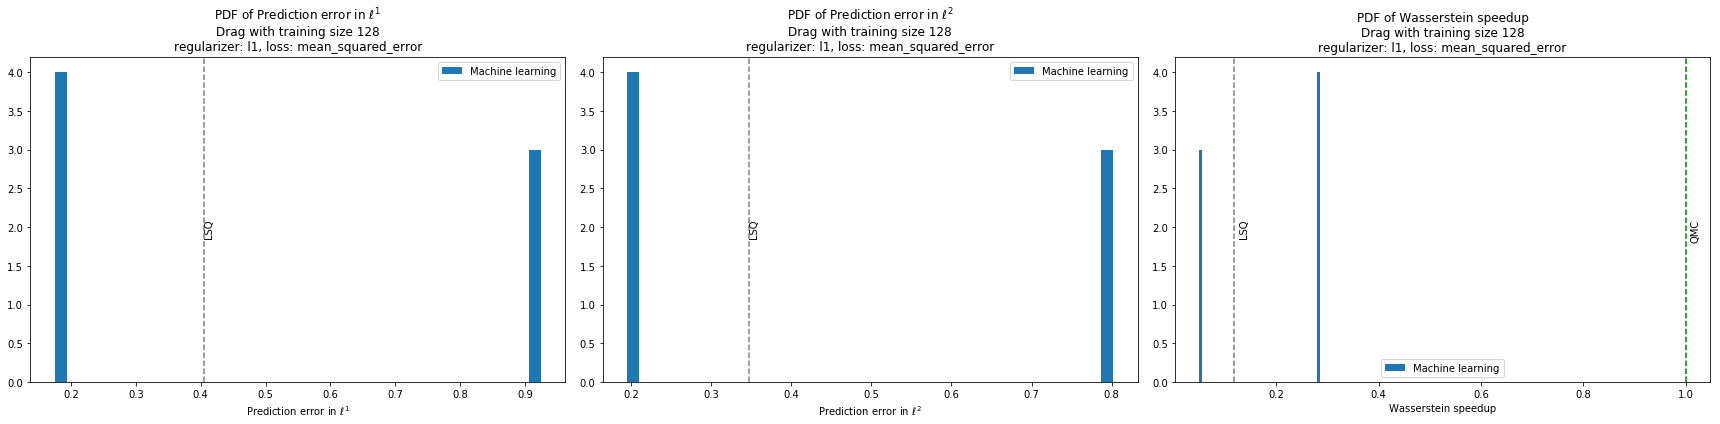

regularizer: l1, loss: mean_absolute_error


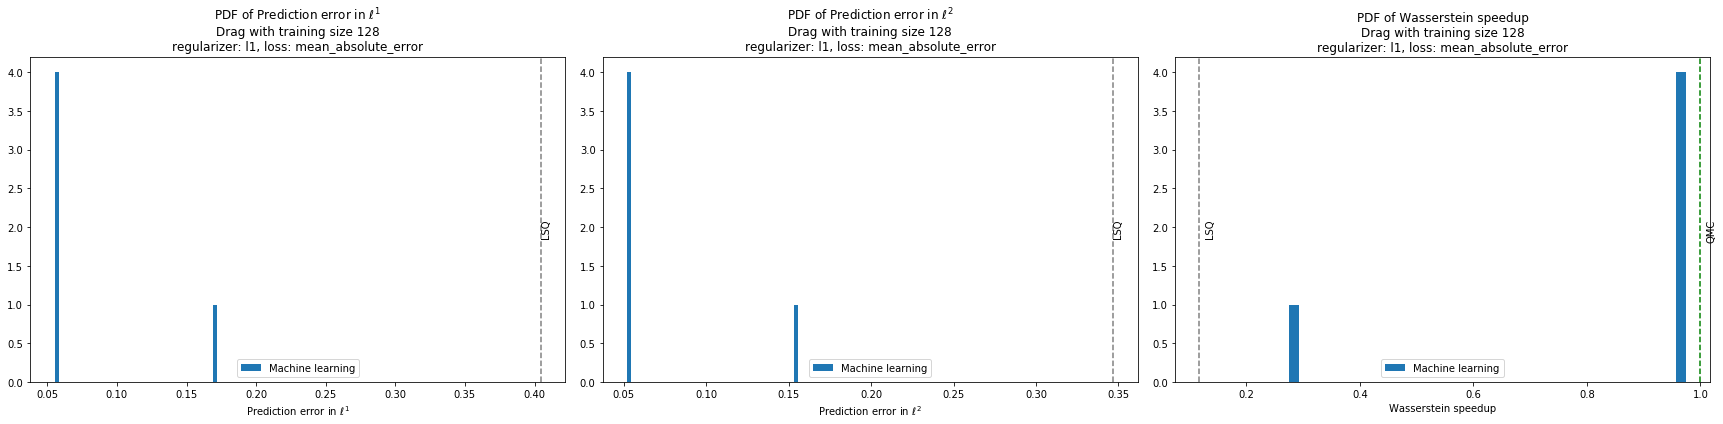

loss: mean_squared_error, optimizer: SGD


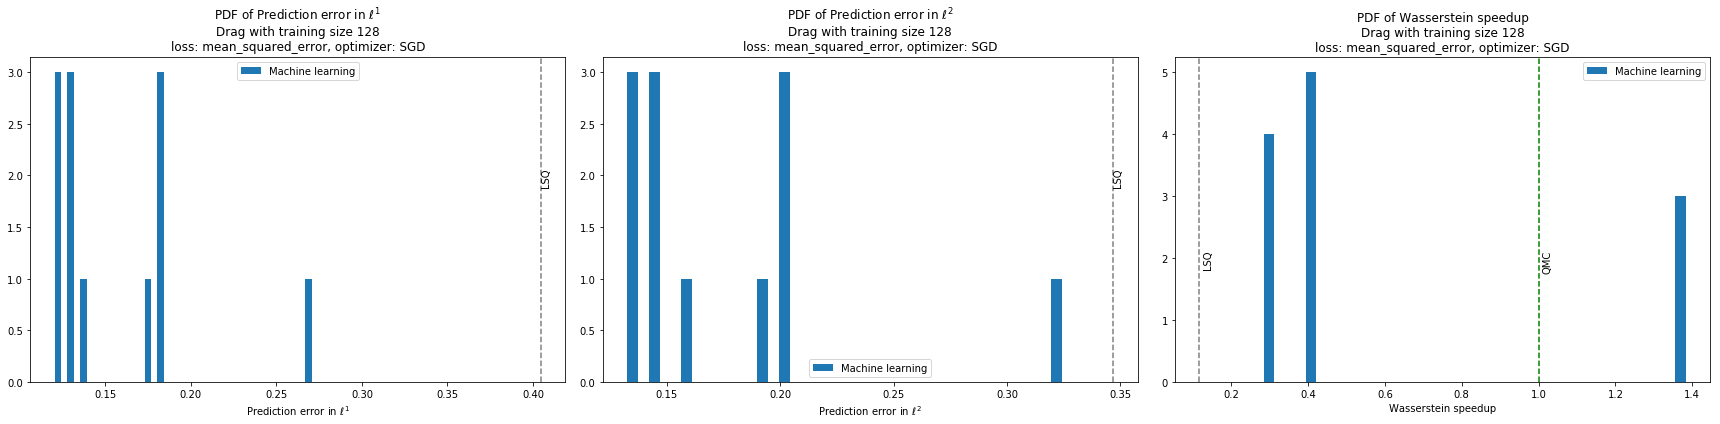

loss: mean_squared_error, optimizer: Adam


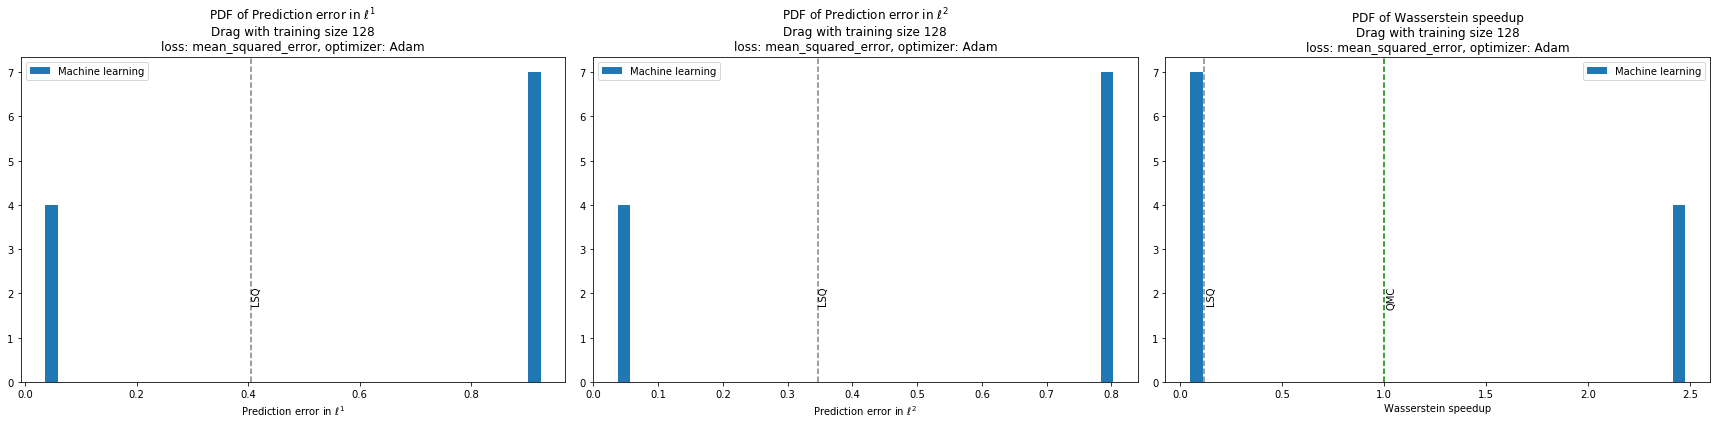

loss: mean_absolute_error, optimizer: SGD


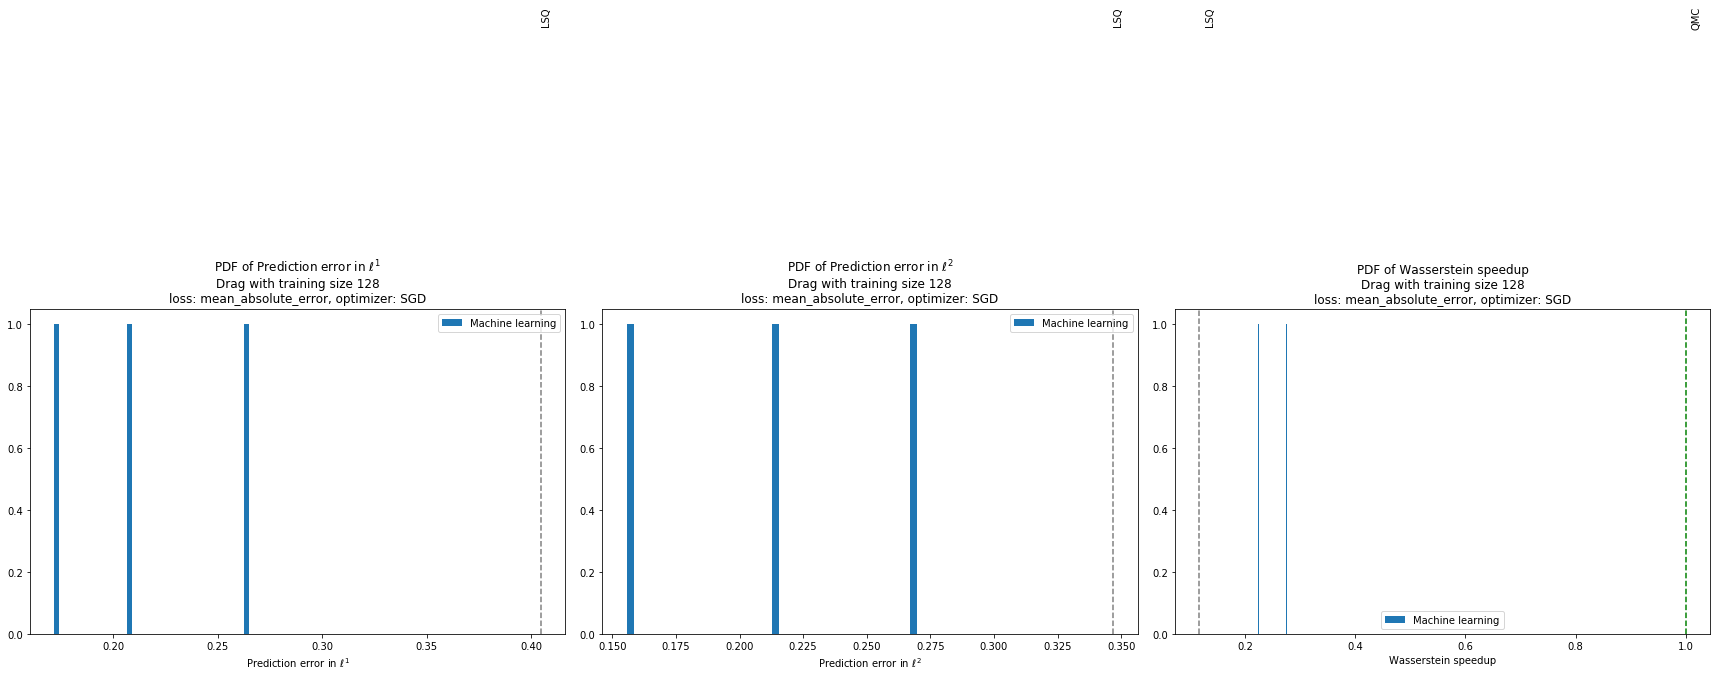

loss: mean_absolute_error, optimizer: Adam


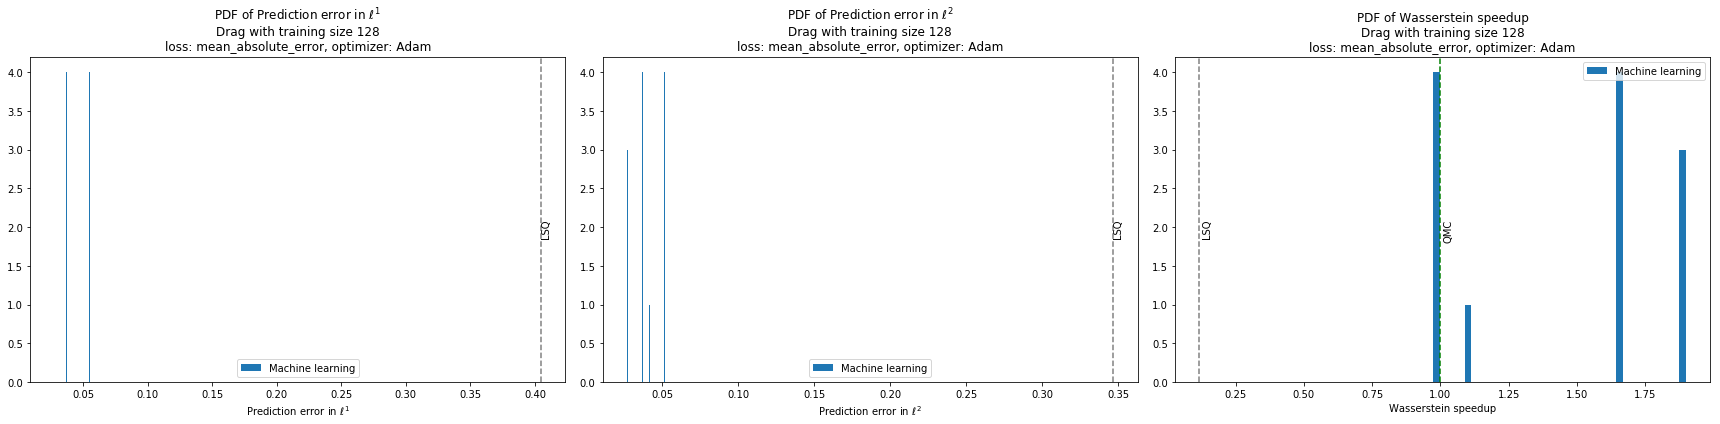

loss: mean_squared_error, regularizer: l2


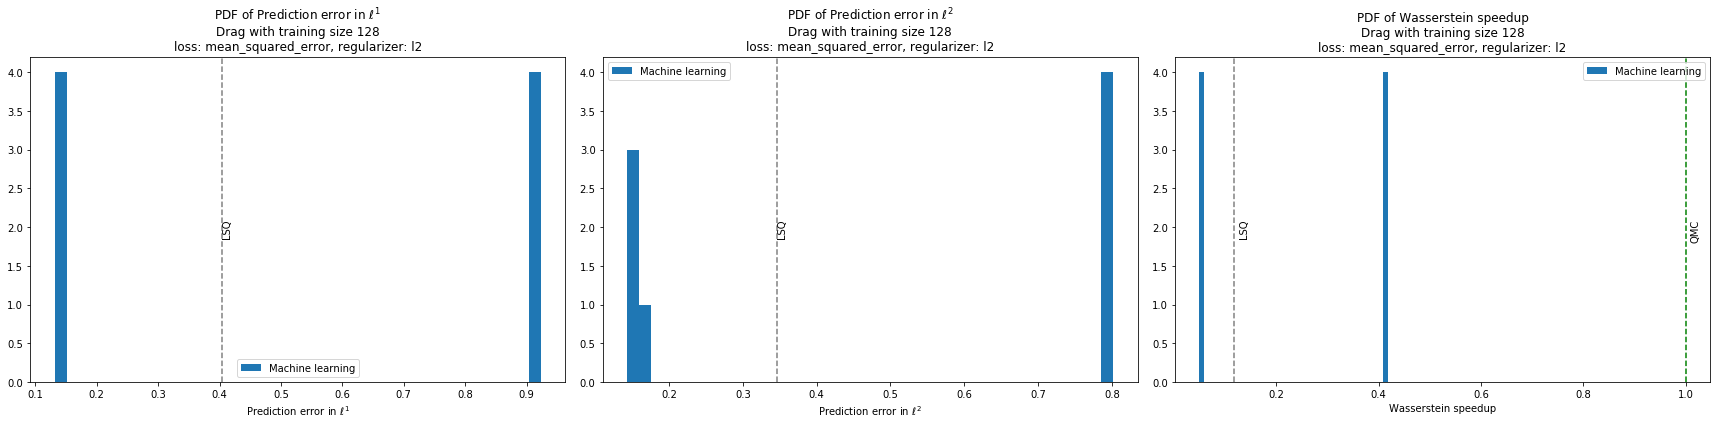

loss: mean_squared_error, regularizer: None


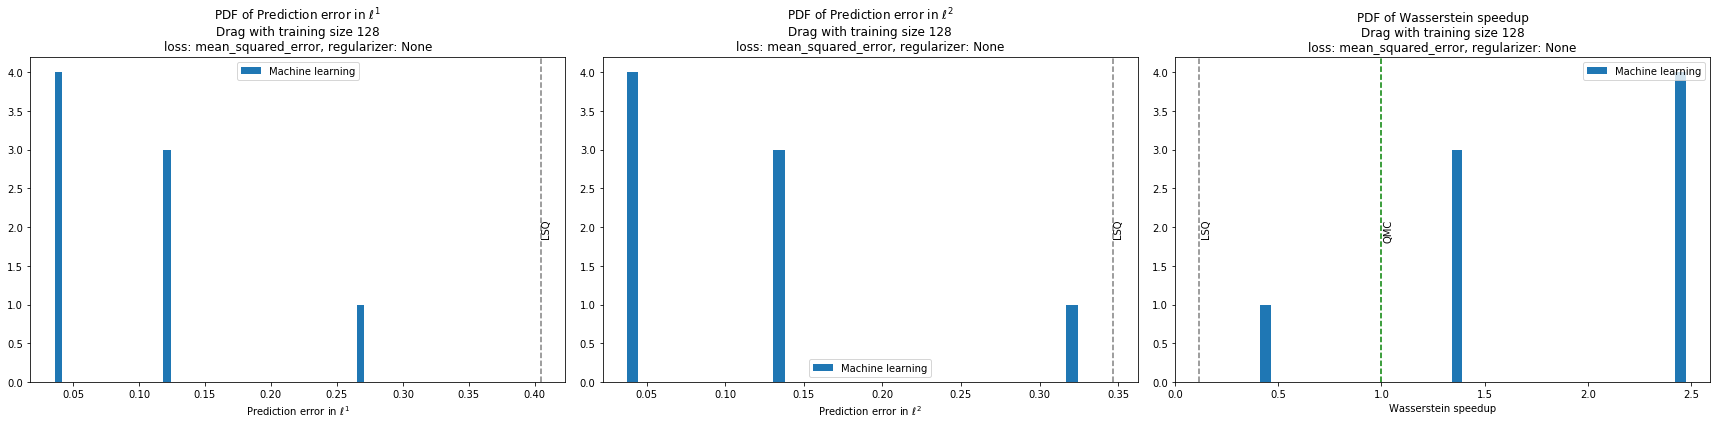

loss: mean_squared_error, regularizer: l1


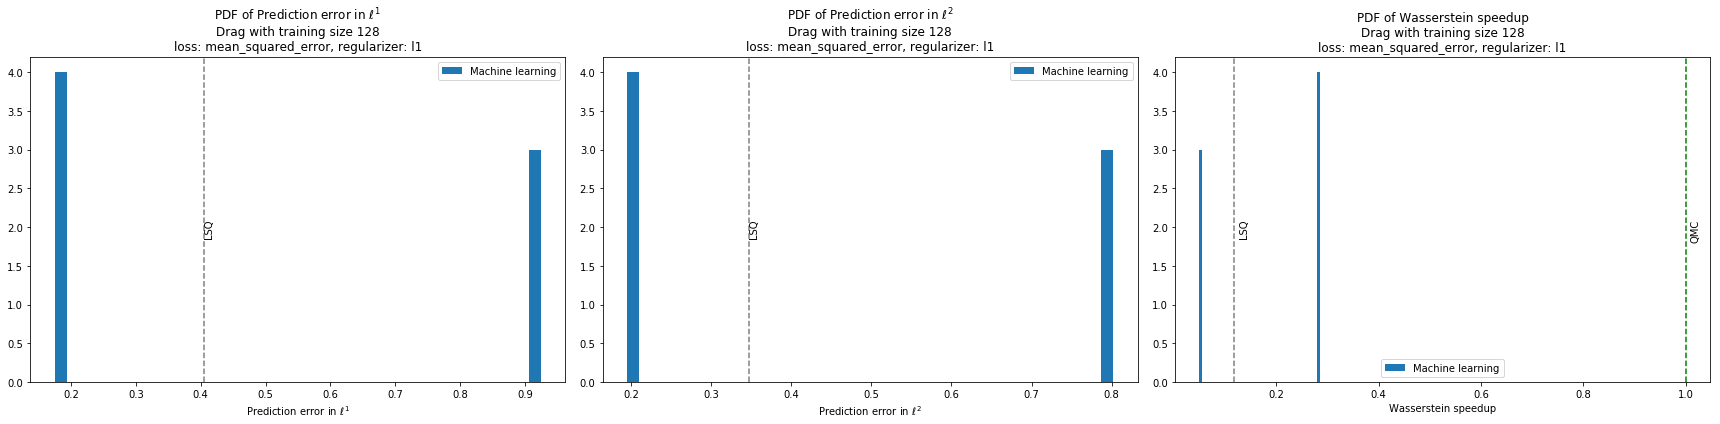

loss: mean_absolute_error, regularizer: l2


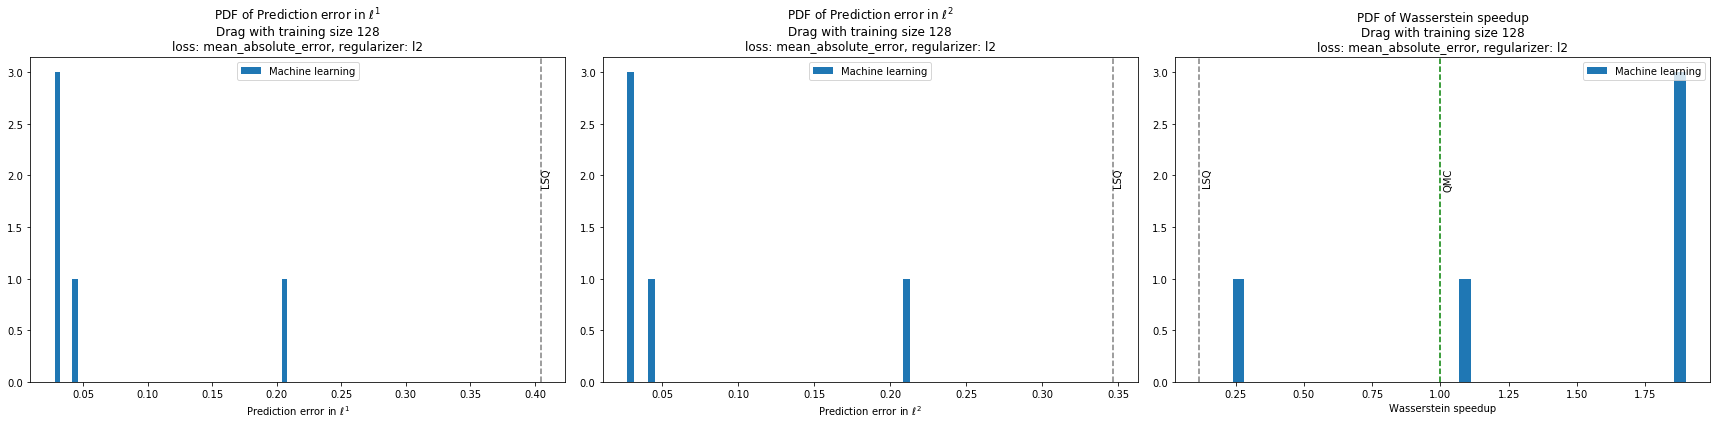

loss: mean_absolute_error, regularizer: None


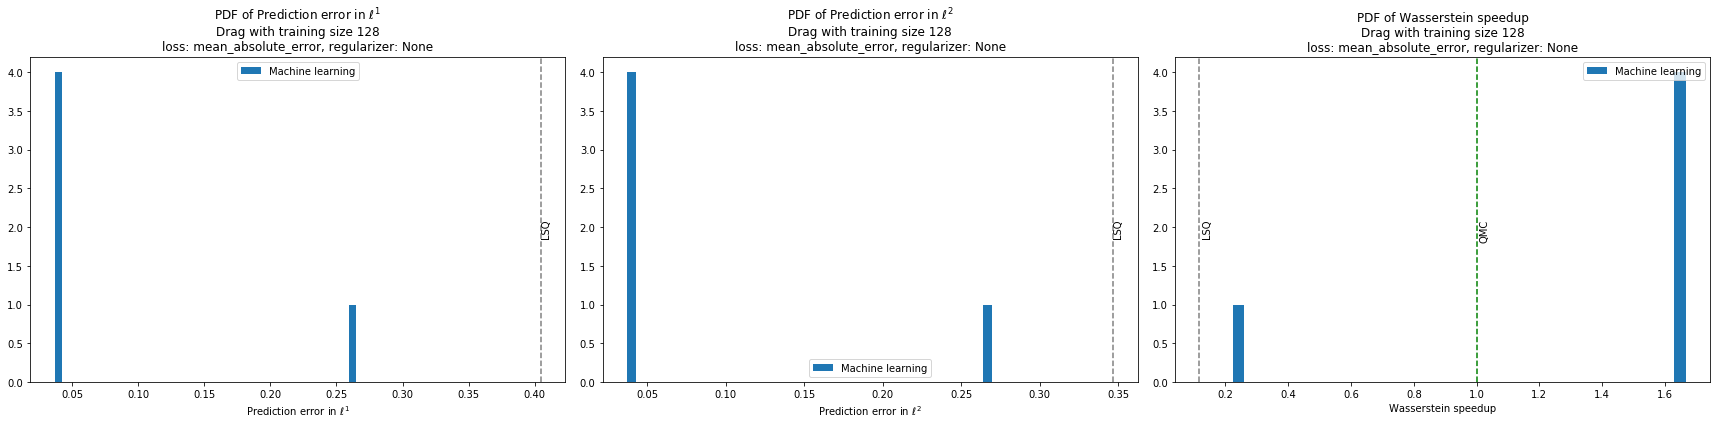

loss: mean_absolute_error, regularizer: l1


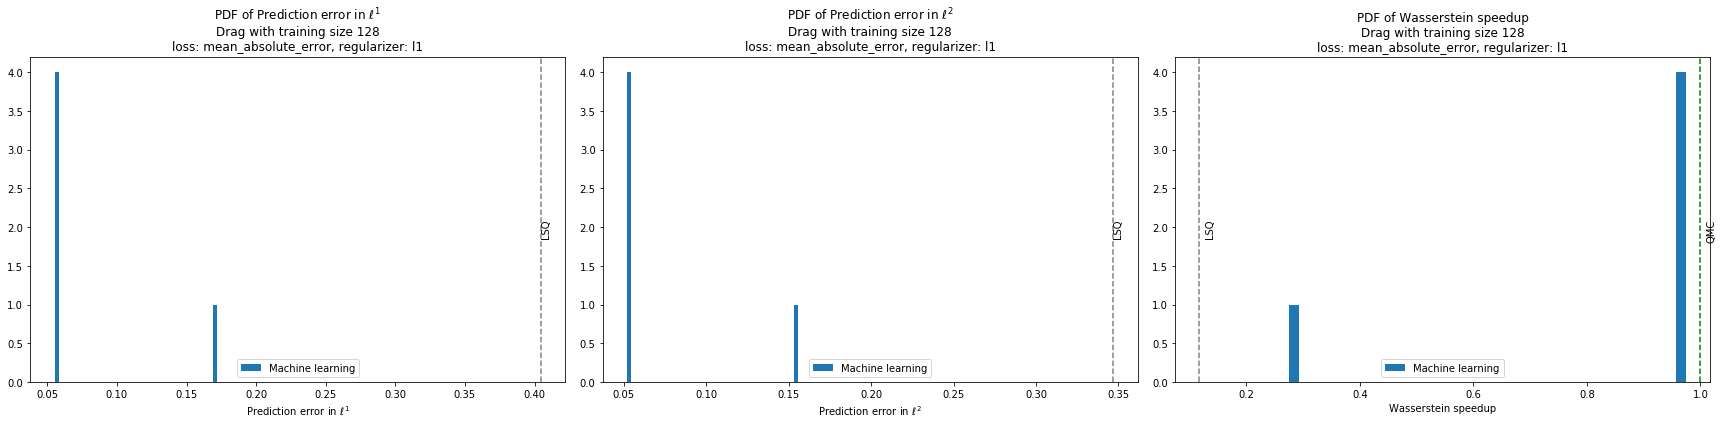

optimizer: SGD, regularizer: l2


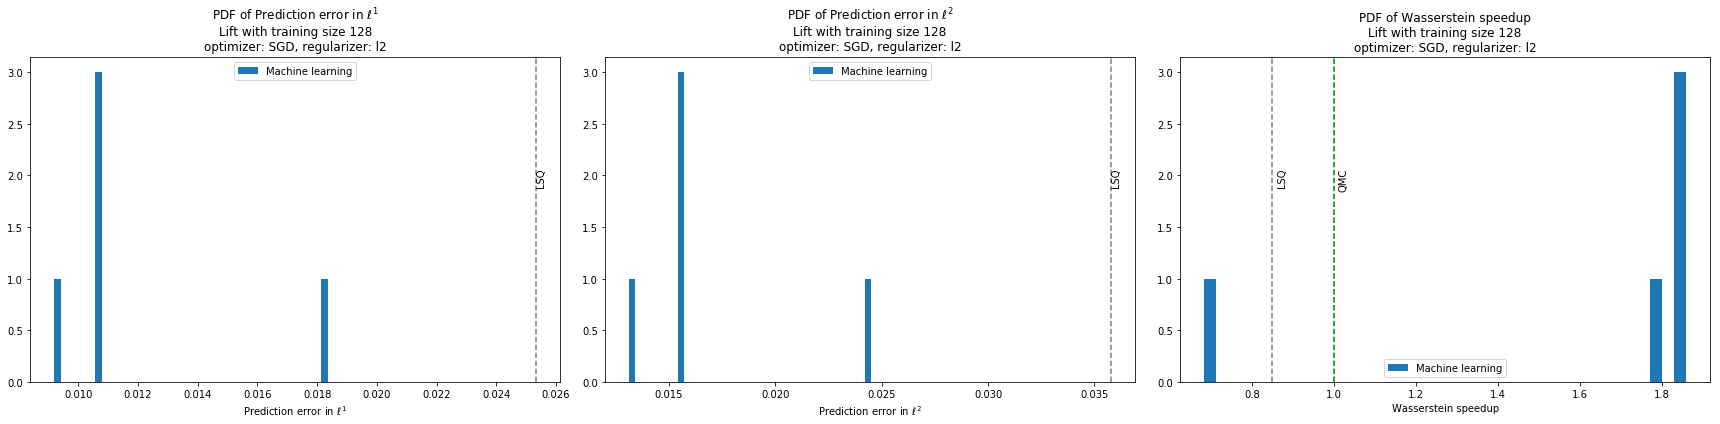

optimizer: SGD, regularizer: None


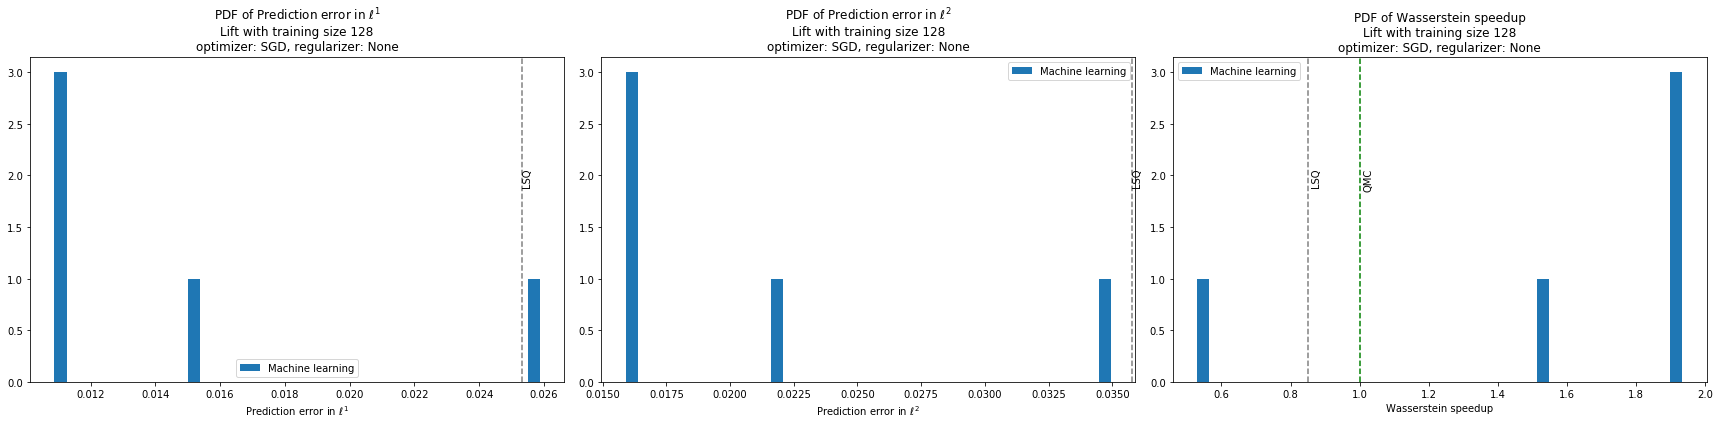

optimizer: SGD, regularizer: l1


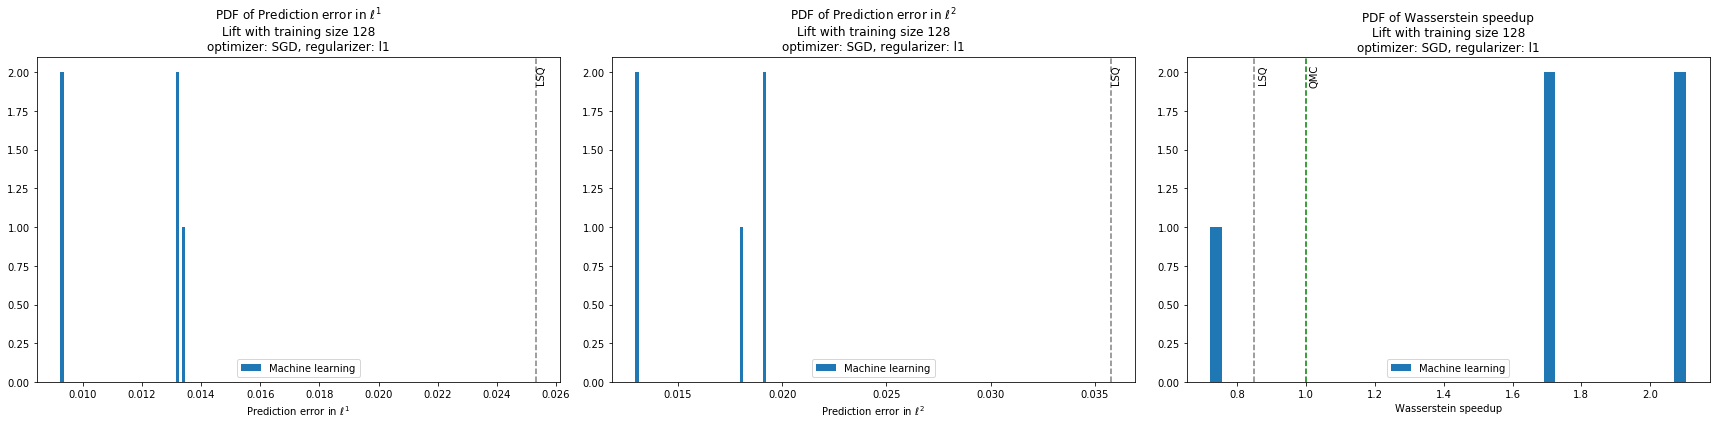

optimizer: Adam, regularizer: l2


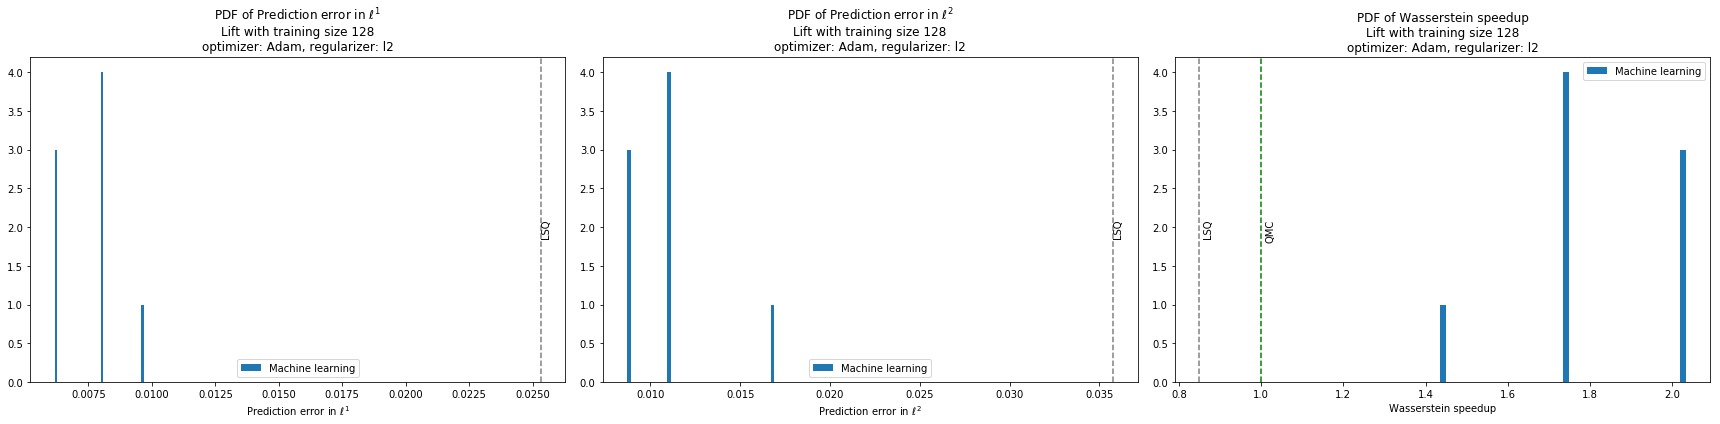

optimizer: Adam, regularizer: None


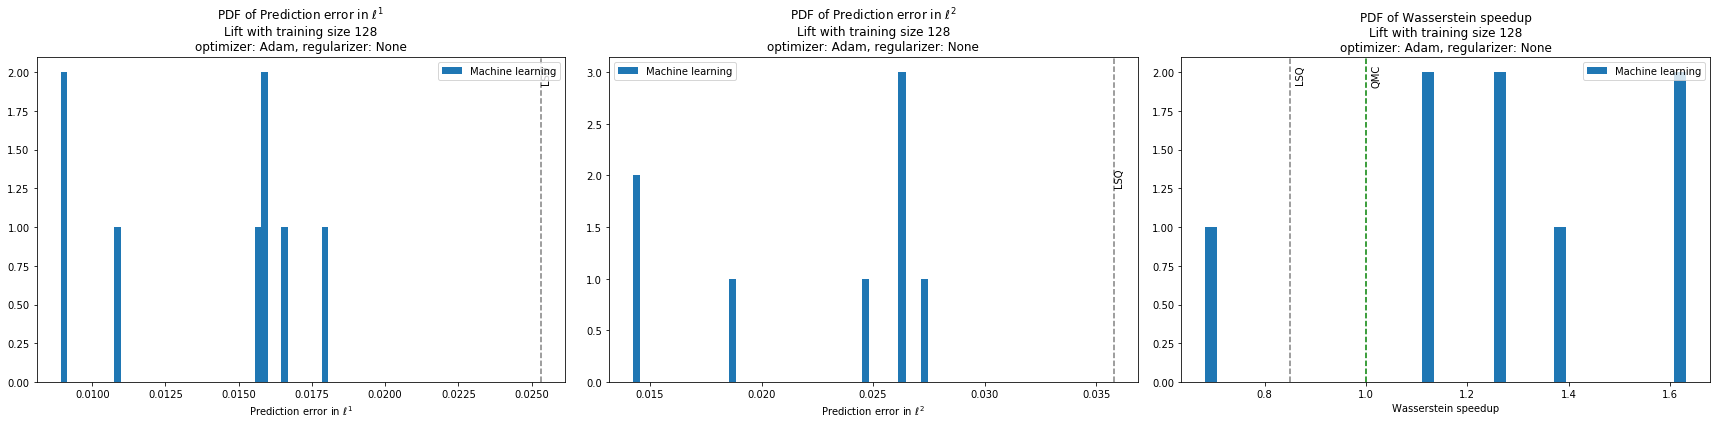

optimizer: Adam, regularizer: l1


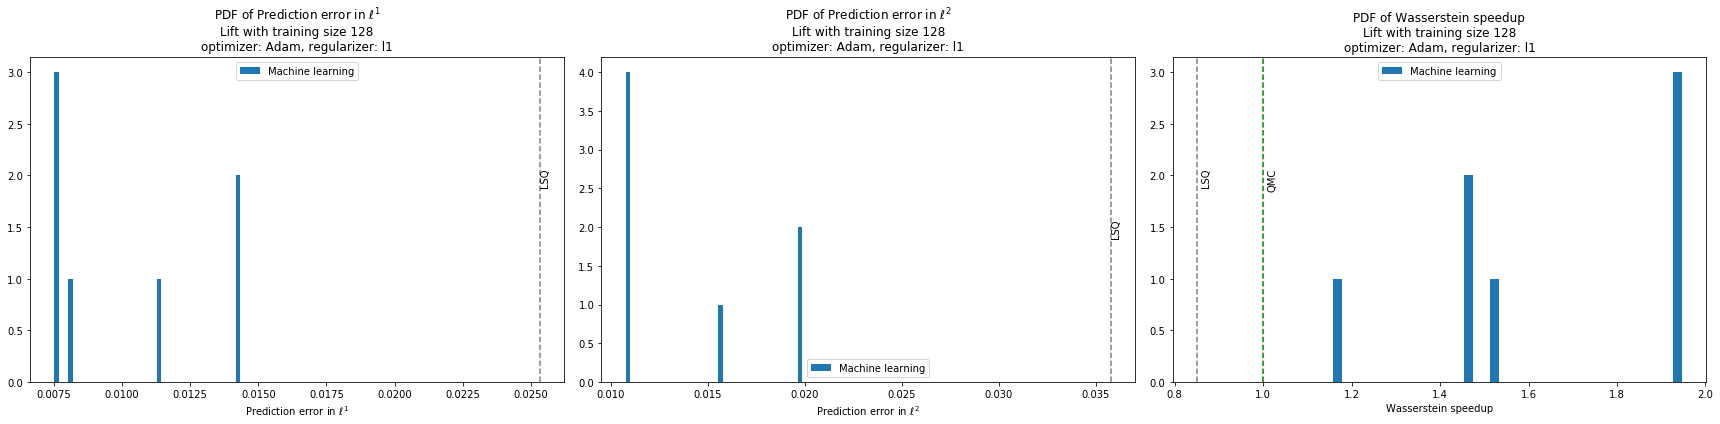

optimizer: SGD, loss: mean_squared_error


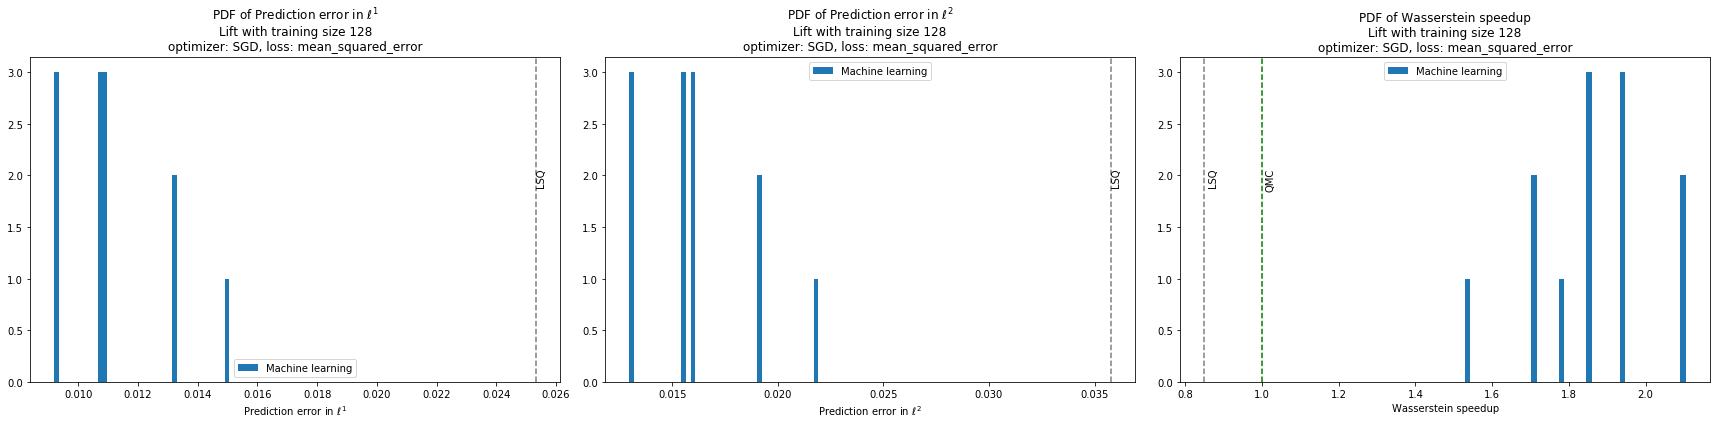

optimizer: SGD, loss: mean_absolute_error


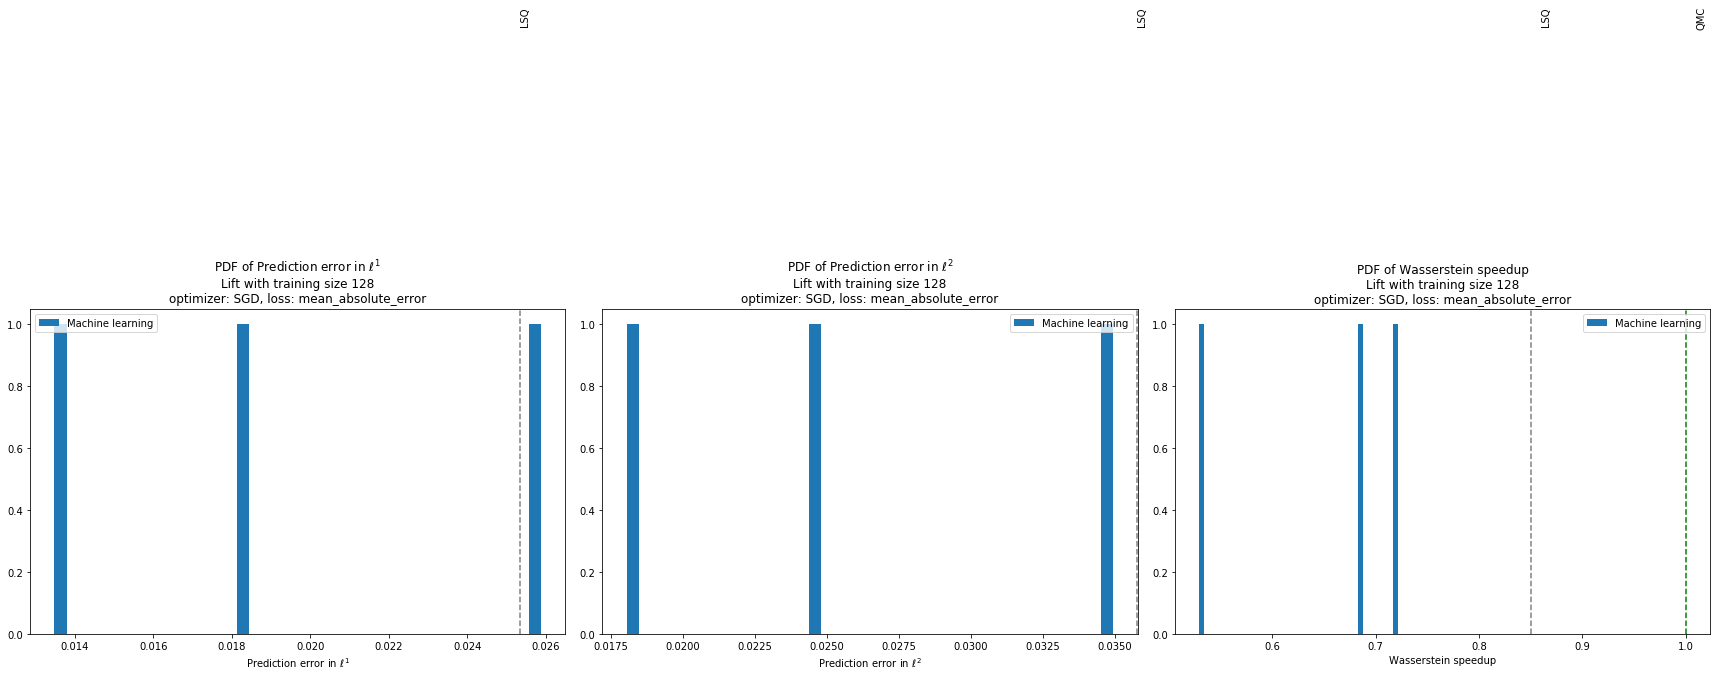

optimizer: Adam, loss: mean_squared_error


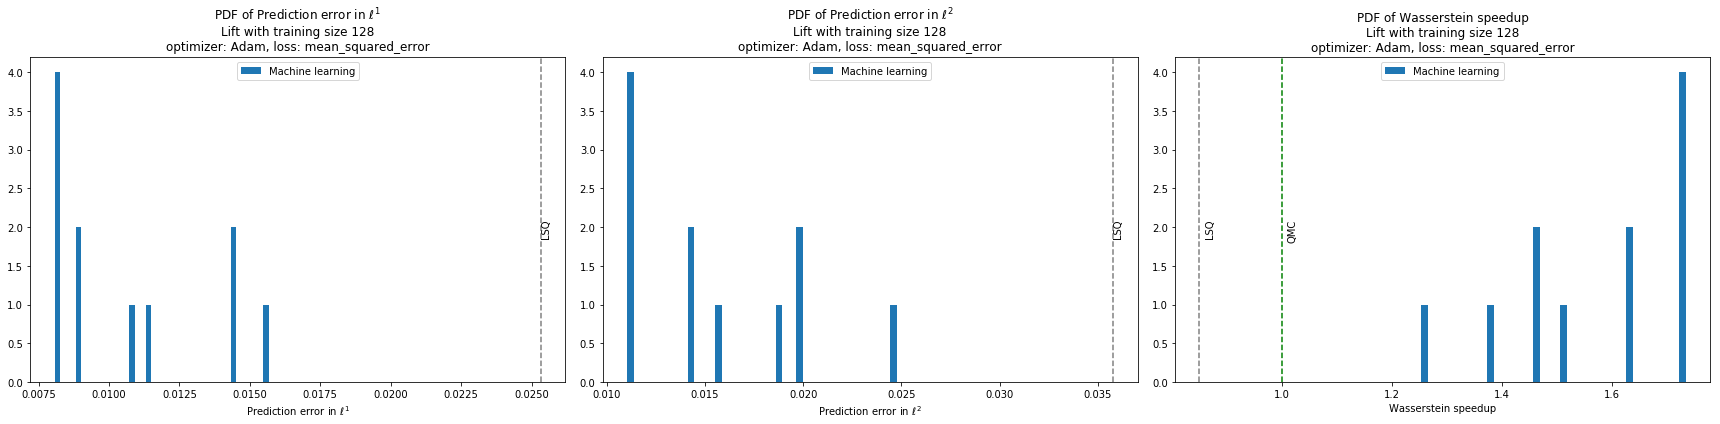

optimizer: Adam, loss: mean_absolute_error


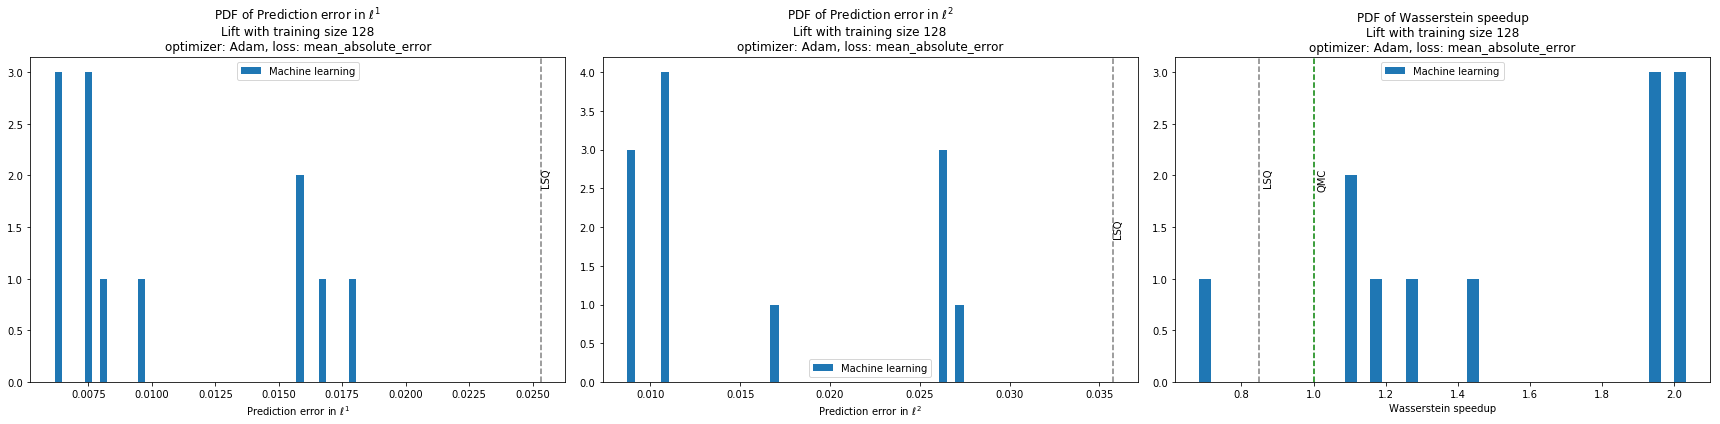

regularizer: l2, optimizer: SGD


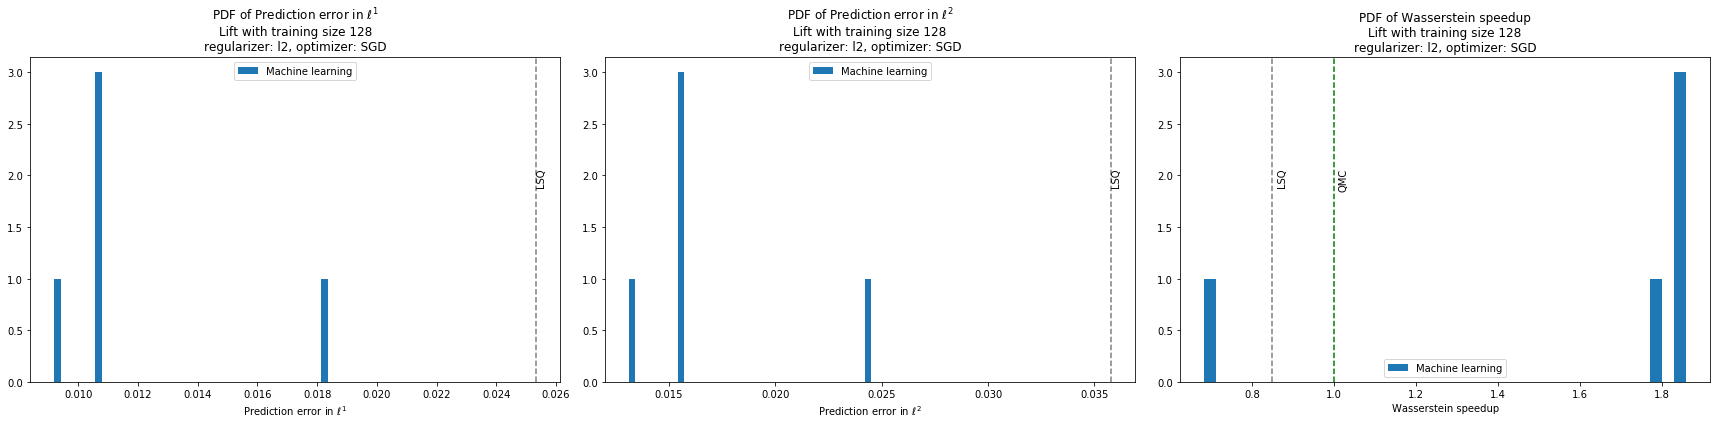

regularizer: l2, optimizer: Adam


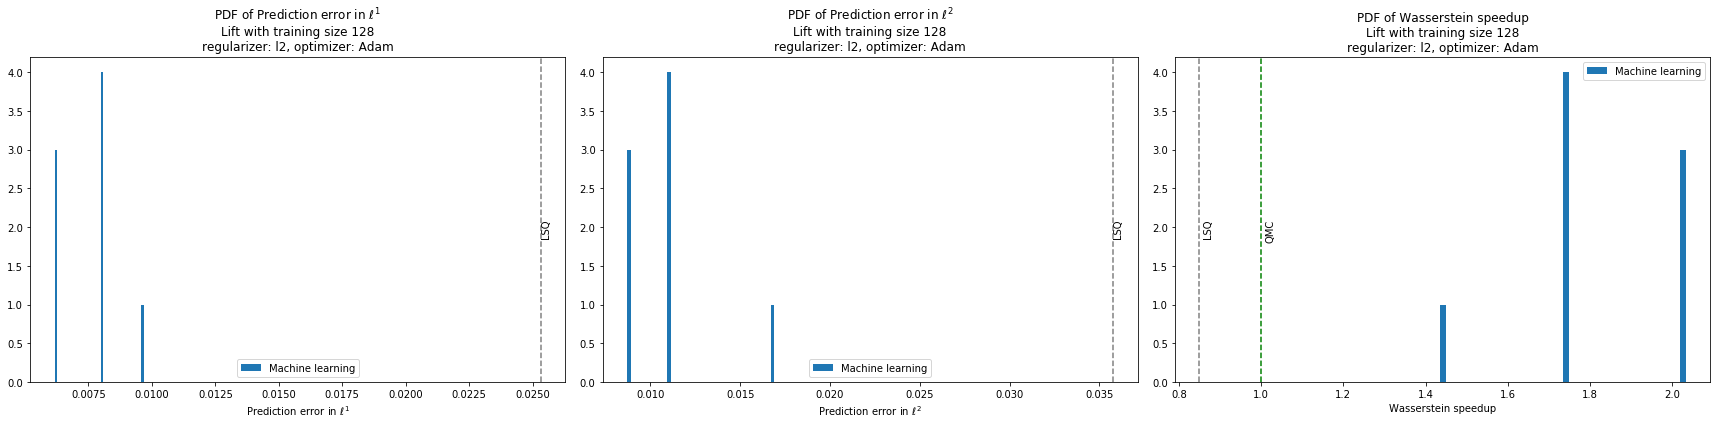

regularizer: None, optimizer: SGD


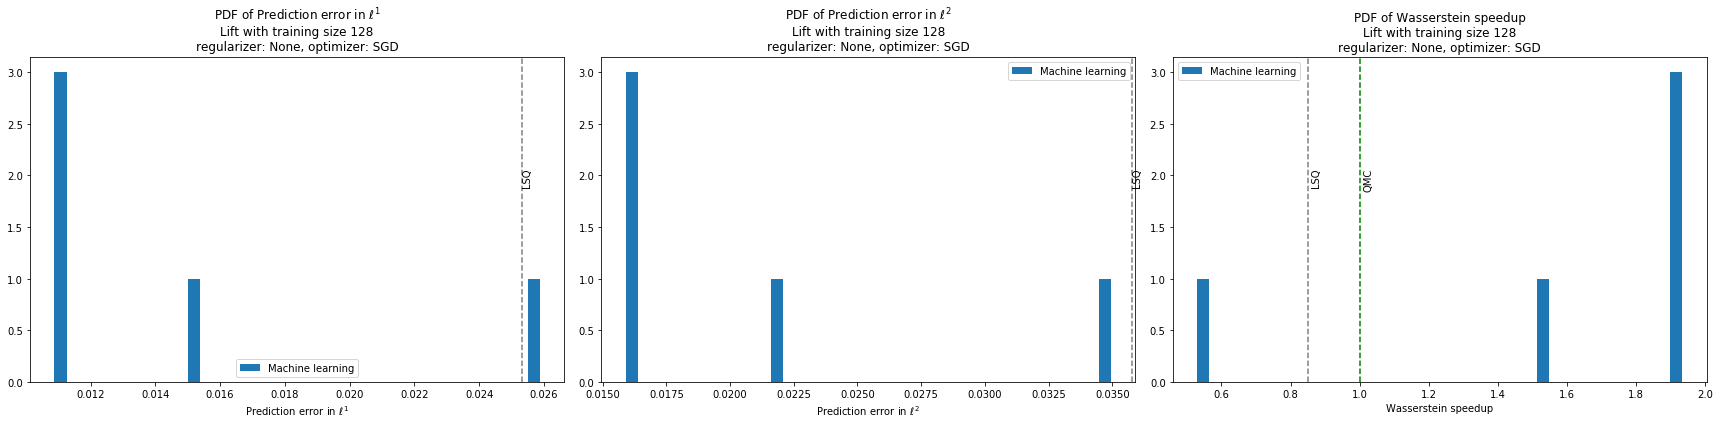

regularizer: None, optimizer: Adam


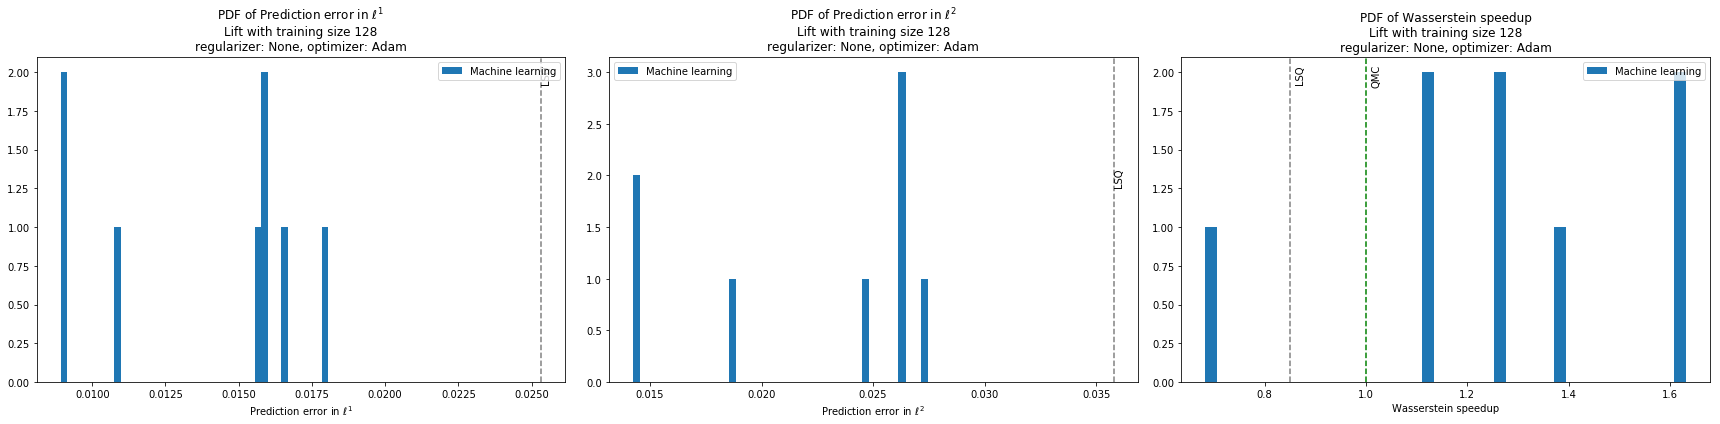

regularizer: l1, optimizer: SGD


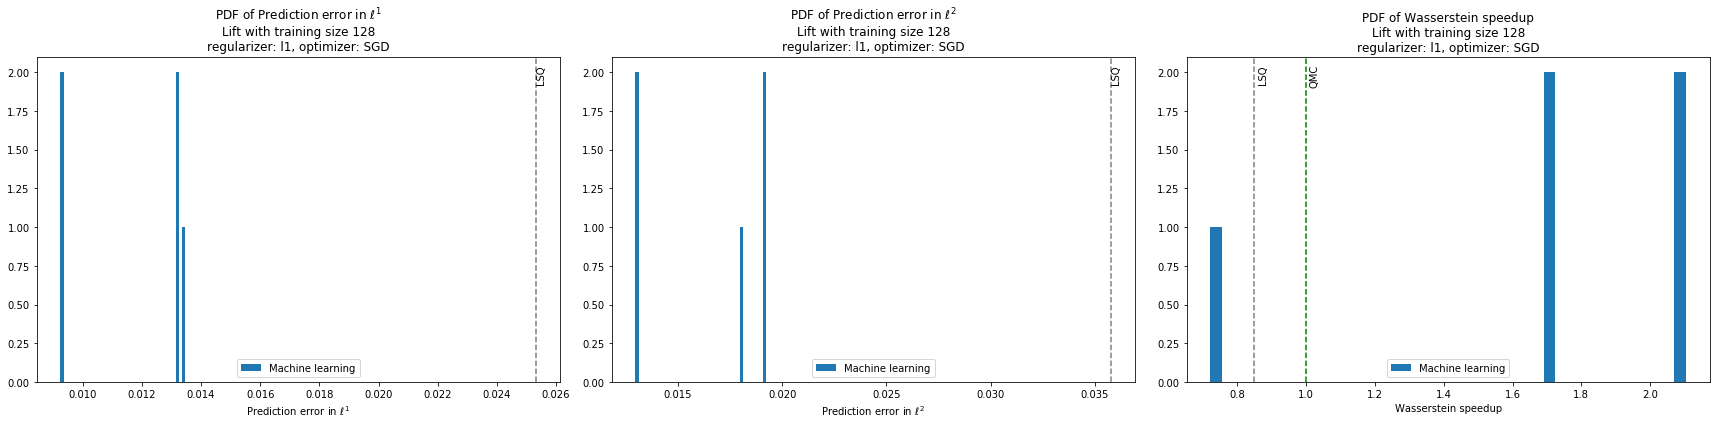

regularizer: l1, optimizer: Adam


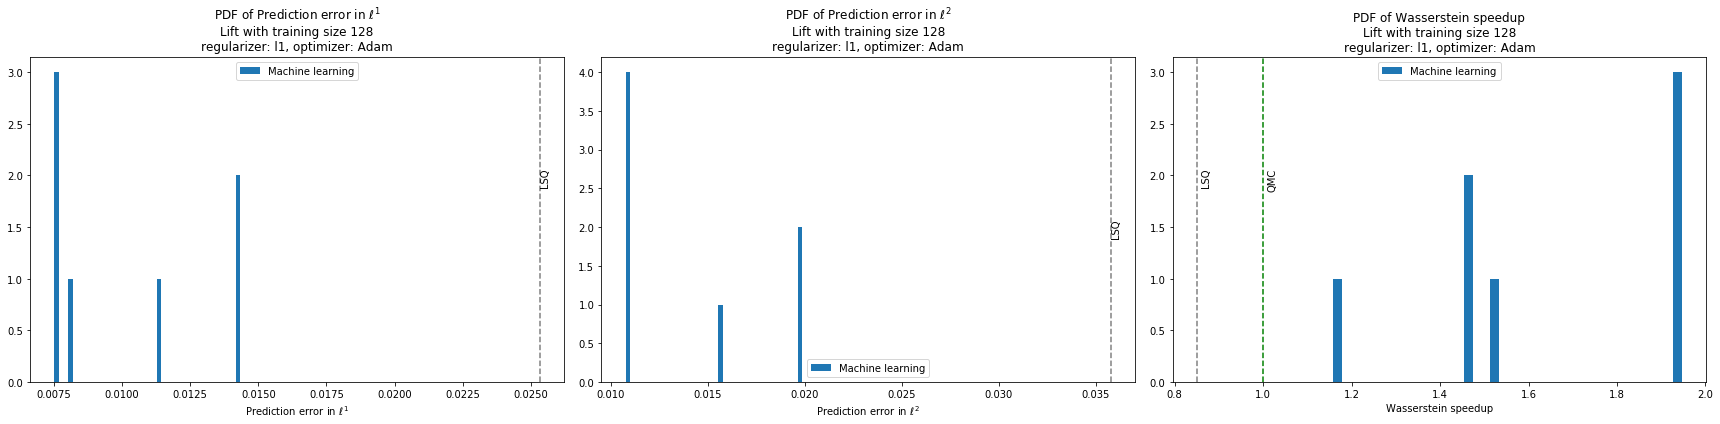

regularizer: l2, loss: mean_squared_error


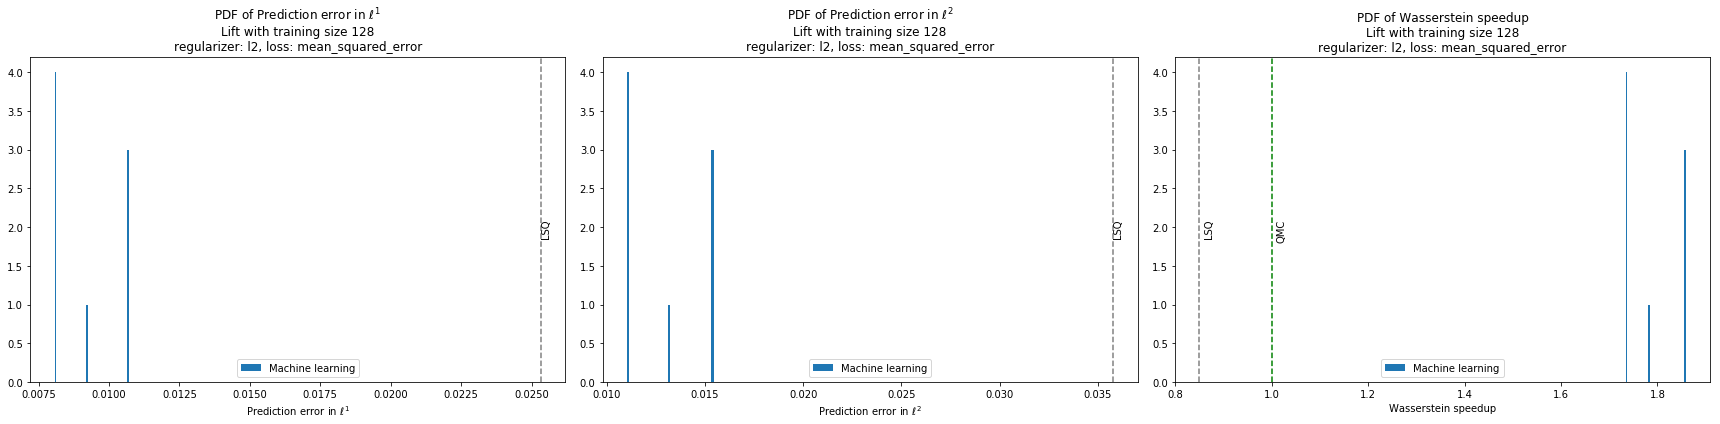

regularizer: l2, loss: mean_absolute_error


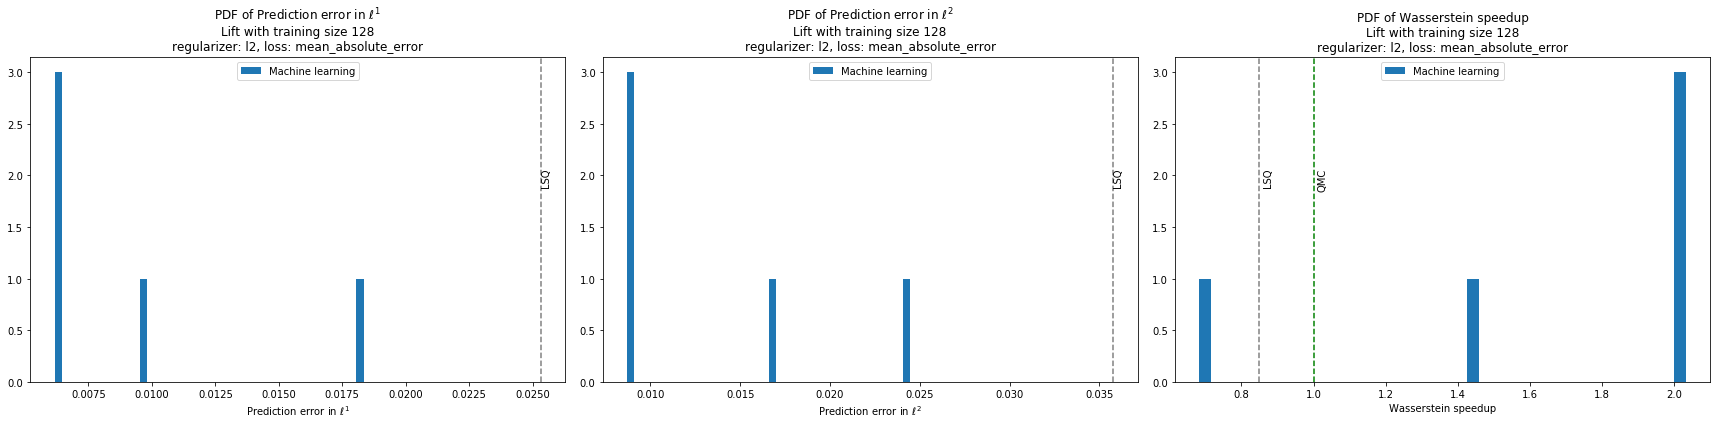

regularizer: None, loss: mean_squared_error


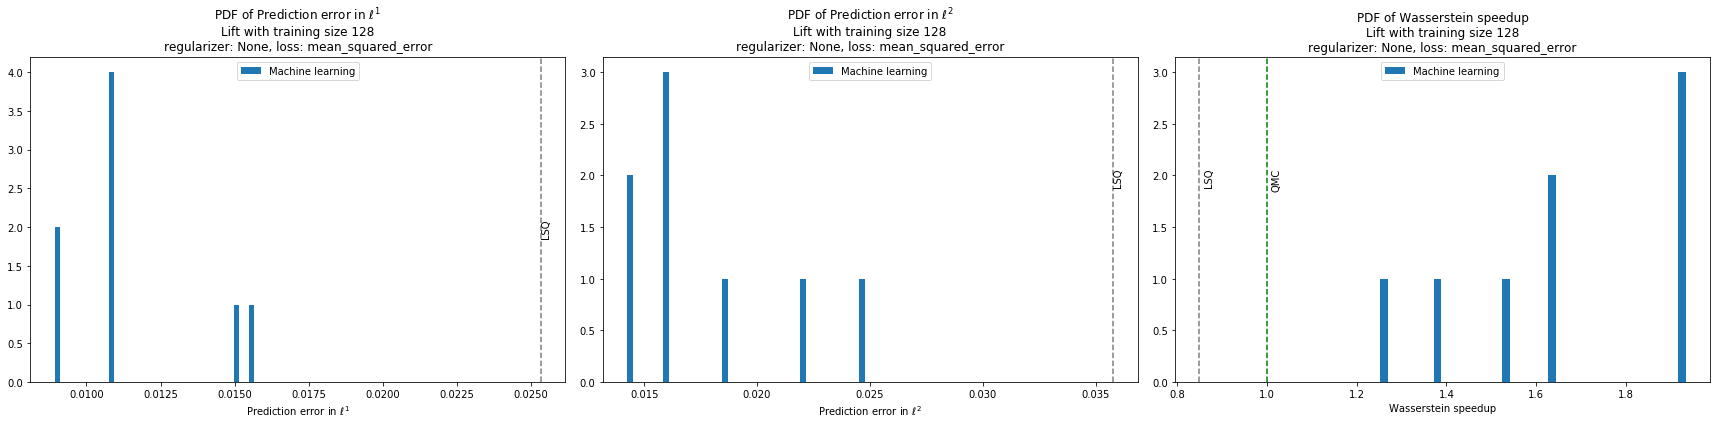

regularizer: None, loss: mean_absolute_error


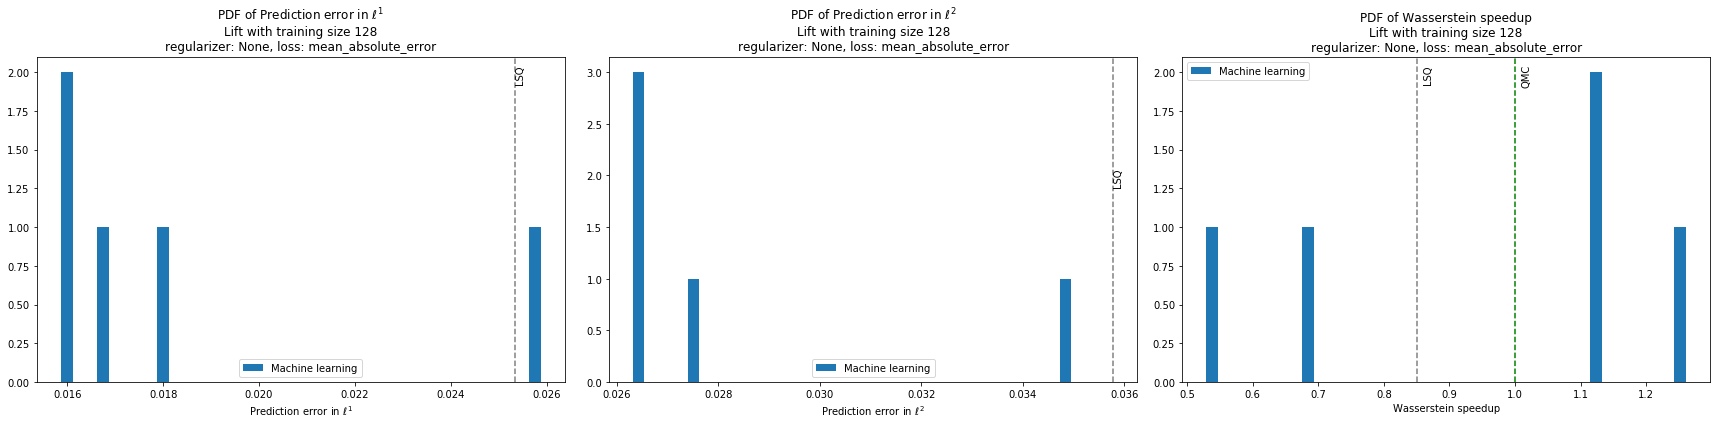

regularizer: l1, loss: mean_squared_error


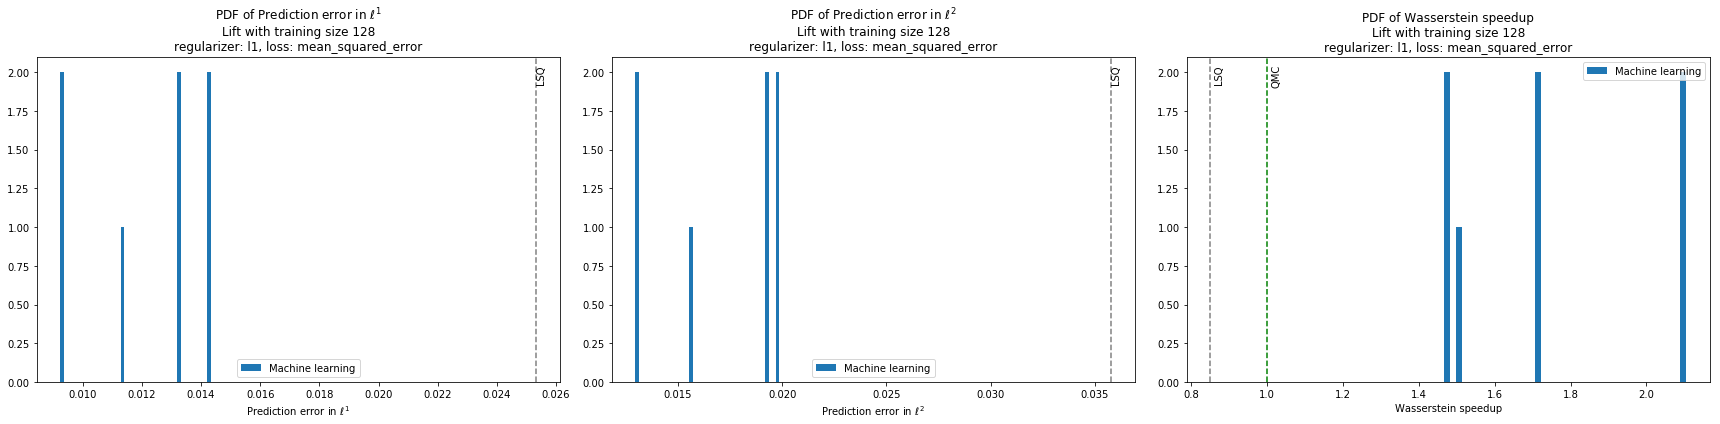

regularizer: l1, loss: mean_absolute_error


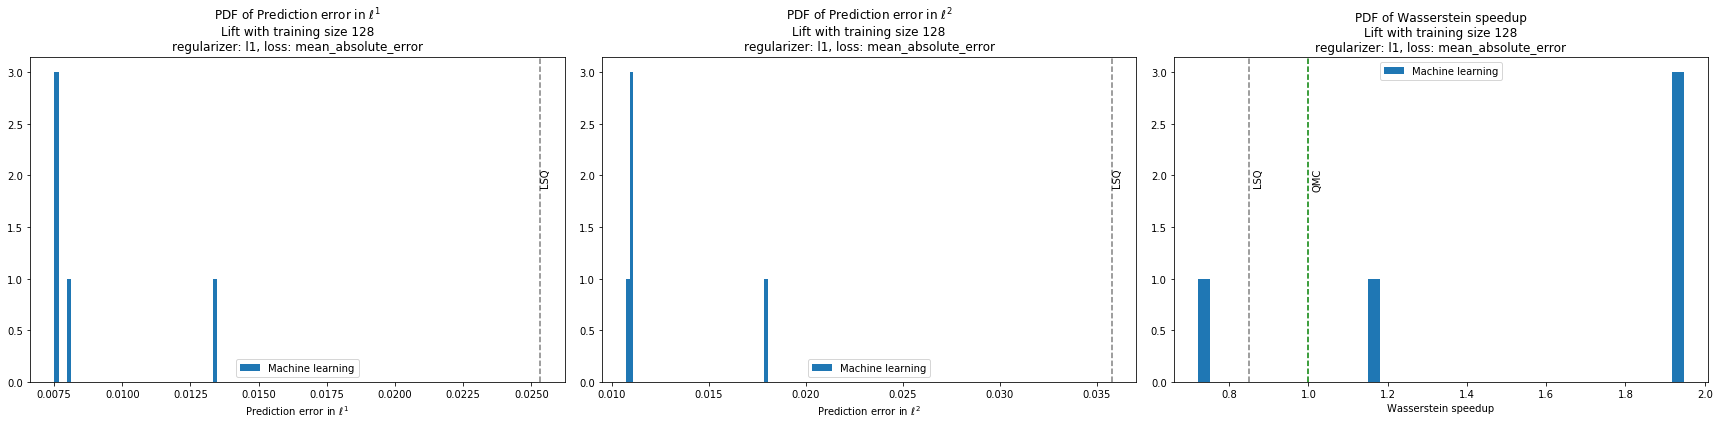

loss: mean_squared_error, optimizer: SGD


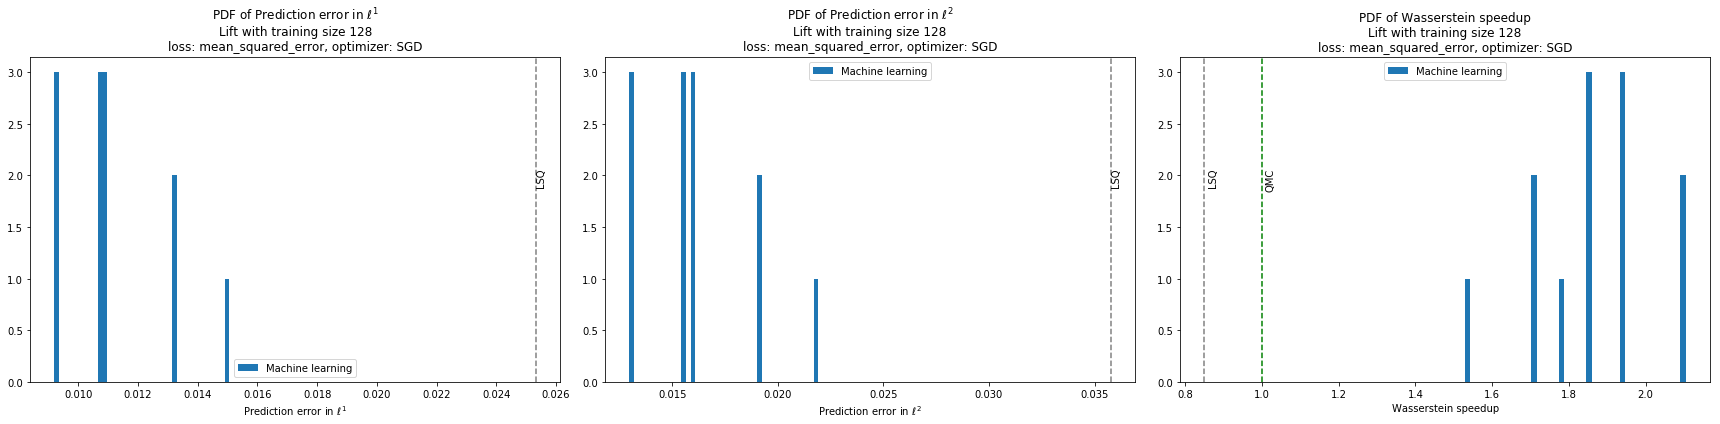

loss: mean_squared_error, optimizer: Adam


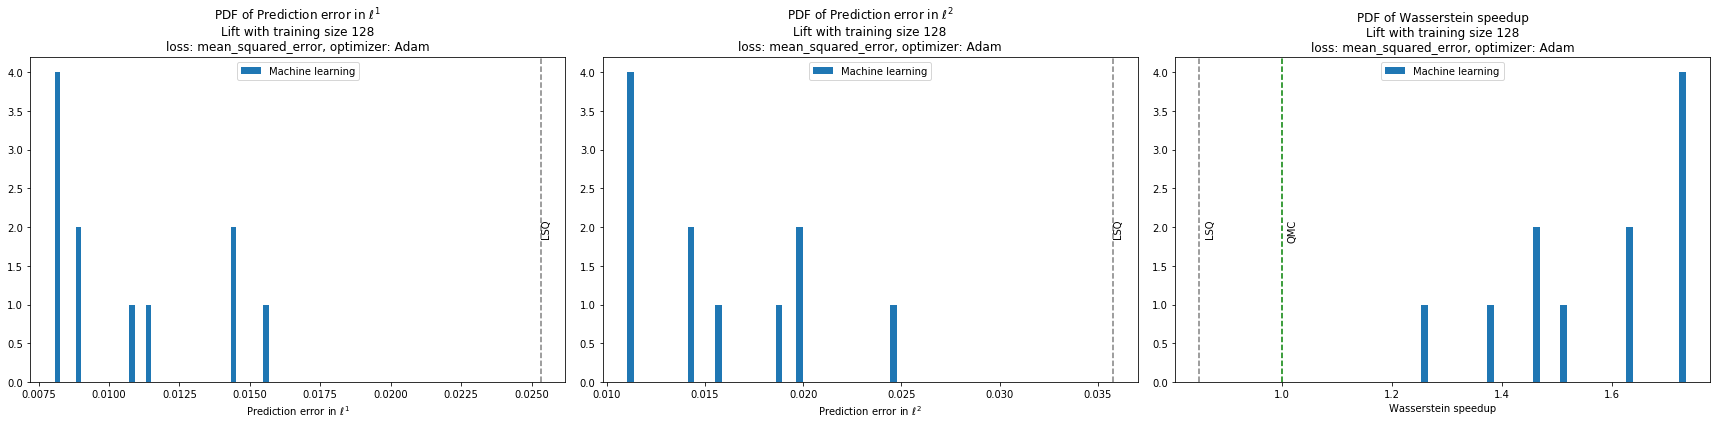

loss: mean_absolute_error, optimizer: SGD


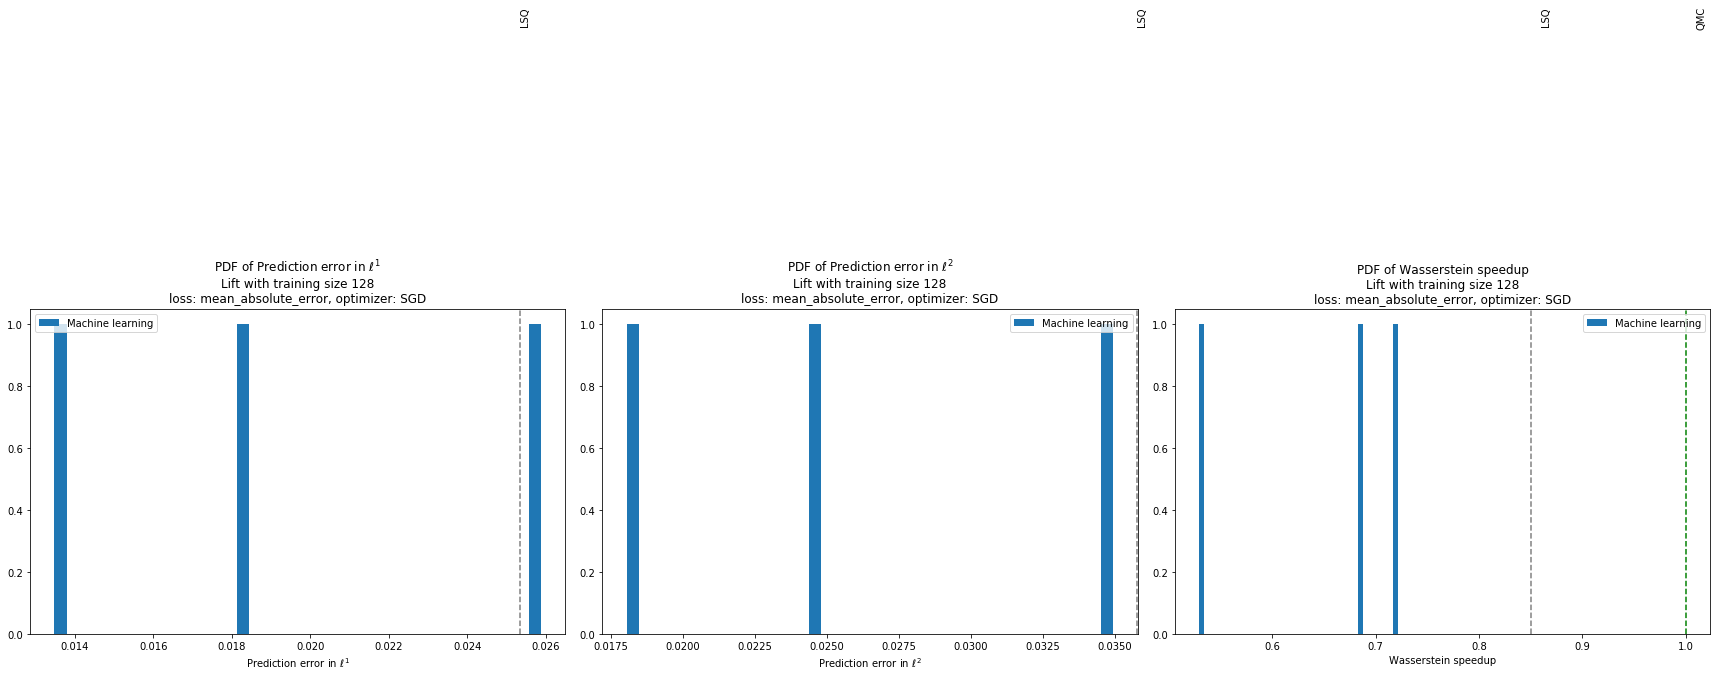

loss: mean_absolute_error, optimizer: Adam


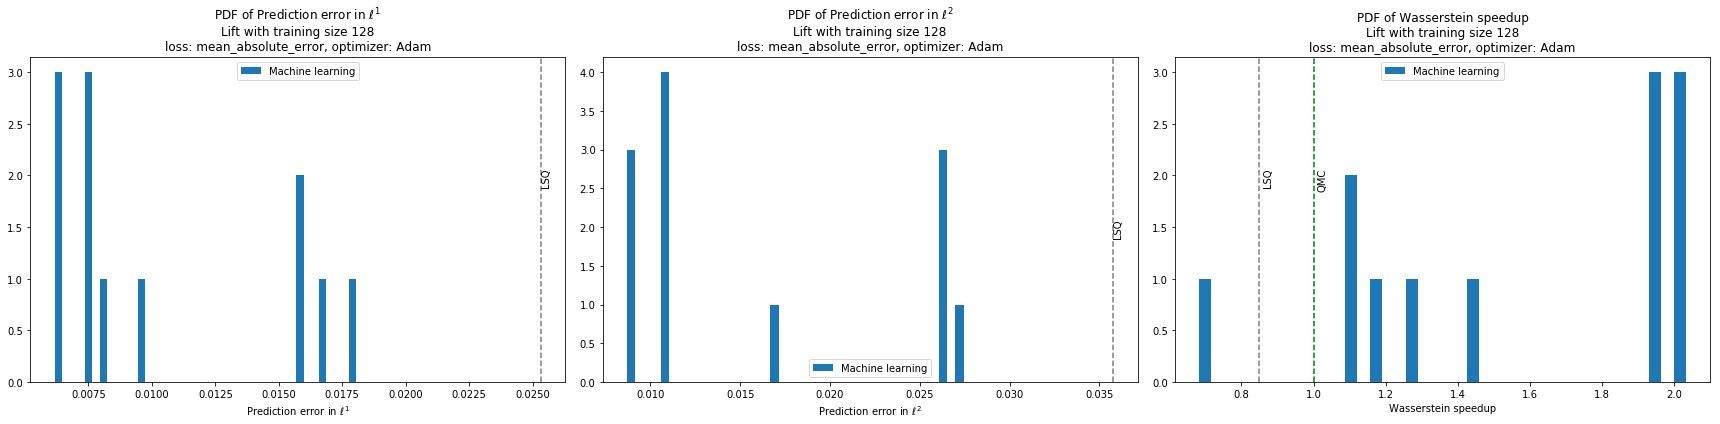

loss: mean_squared_error, regularizer: l2


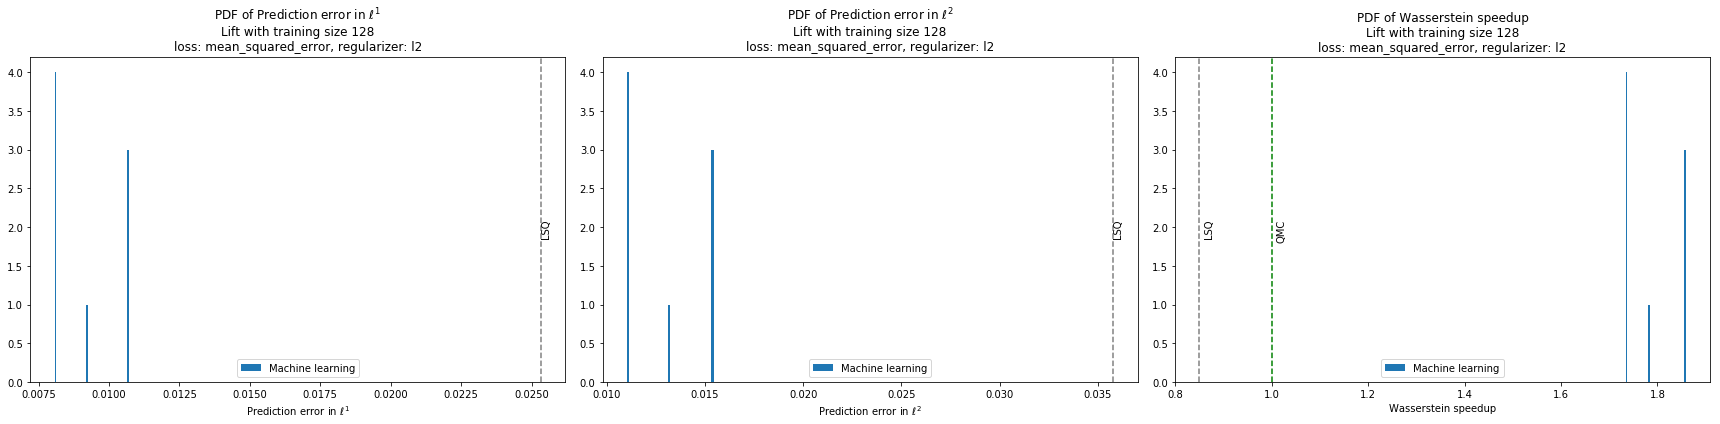

loss: mean_squared_error, regularizer: None


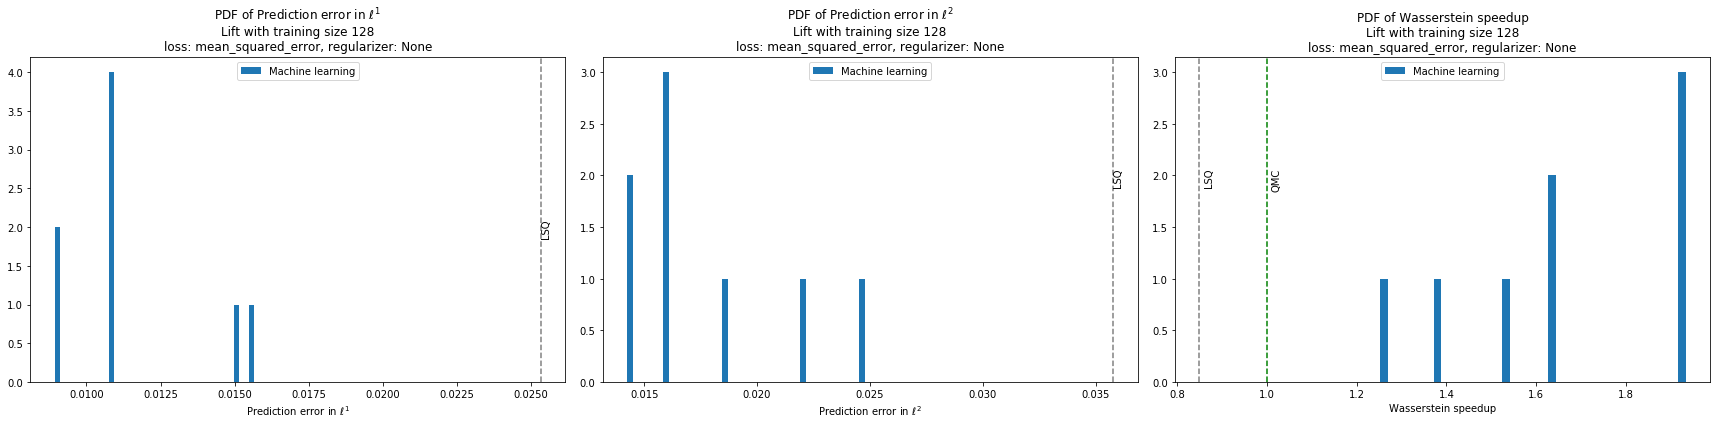

loss: mean_squared_error, regularizer: l1


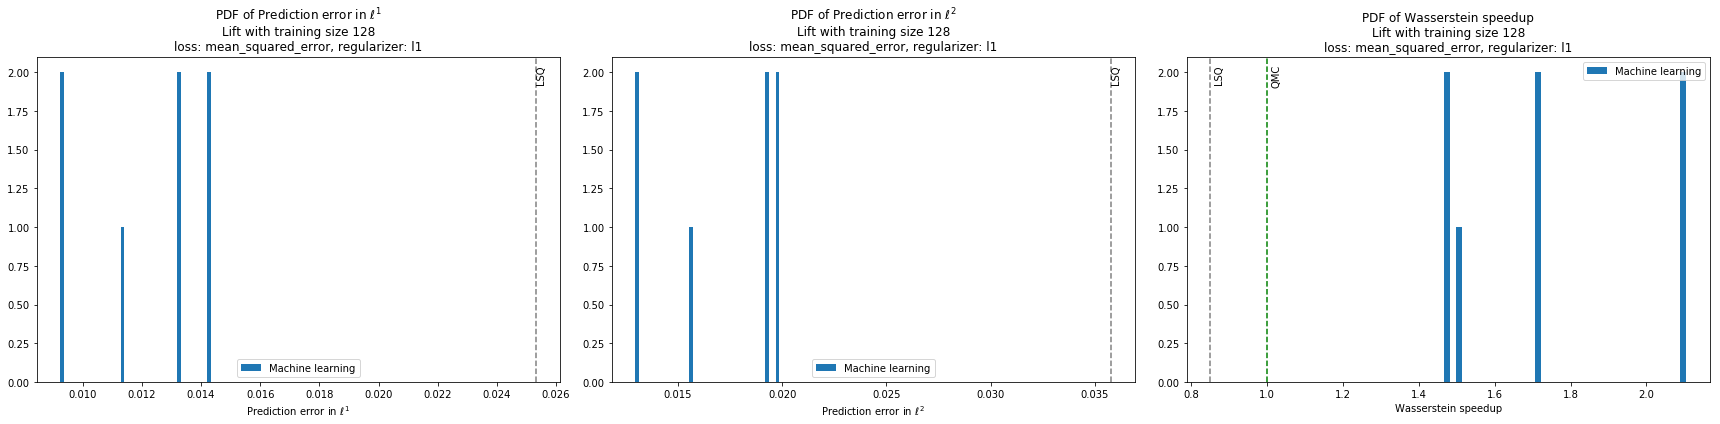

loss: mean_absolute_error, regularizer: l2


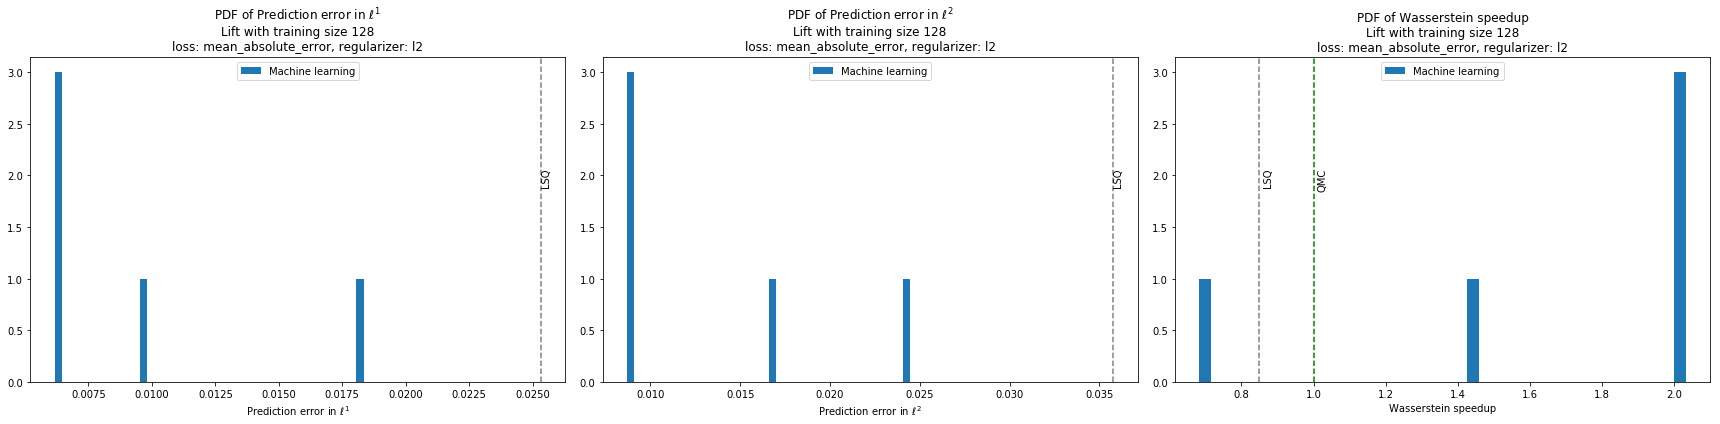

loss: mean_absolute_error, regularizer: None


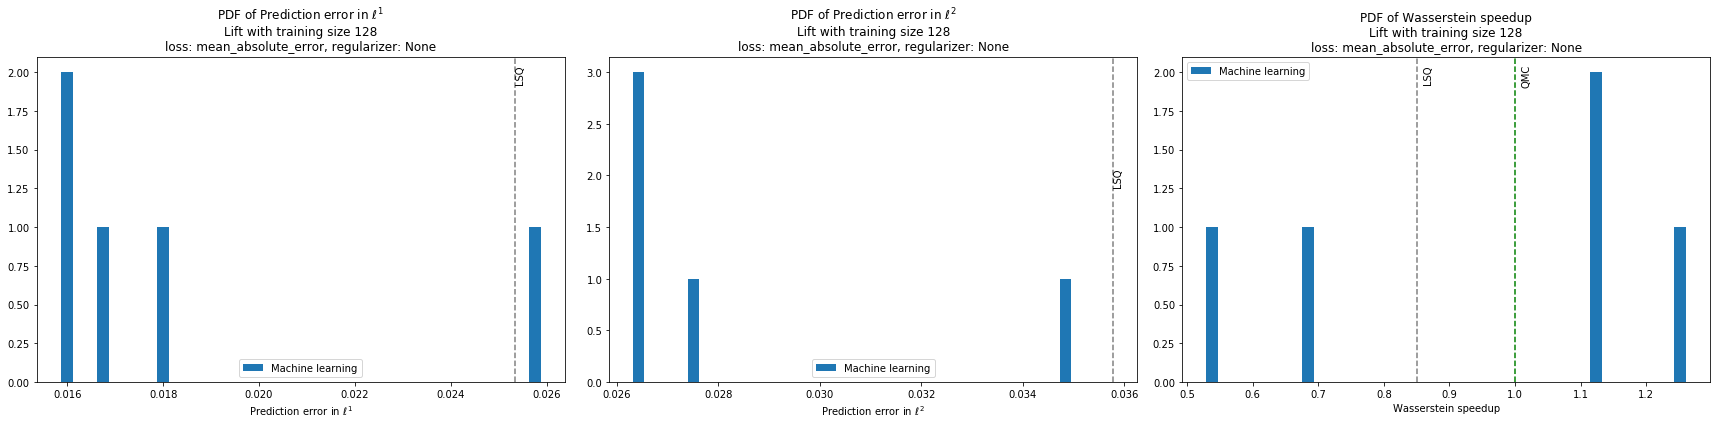

loss: mean_absolute_error, regularizer: l1


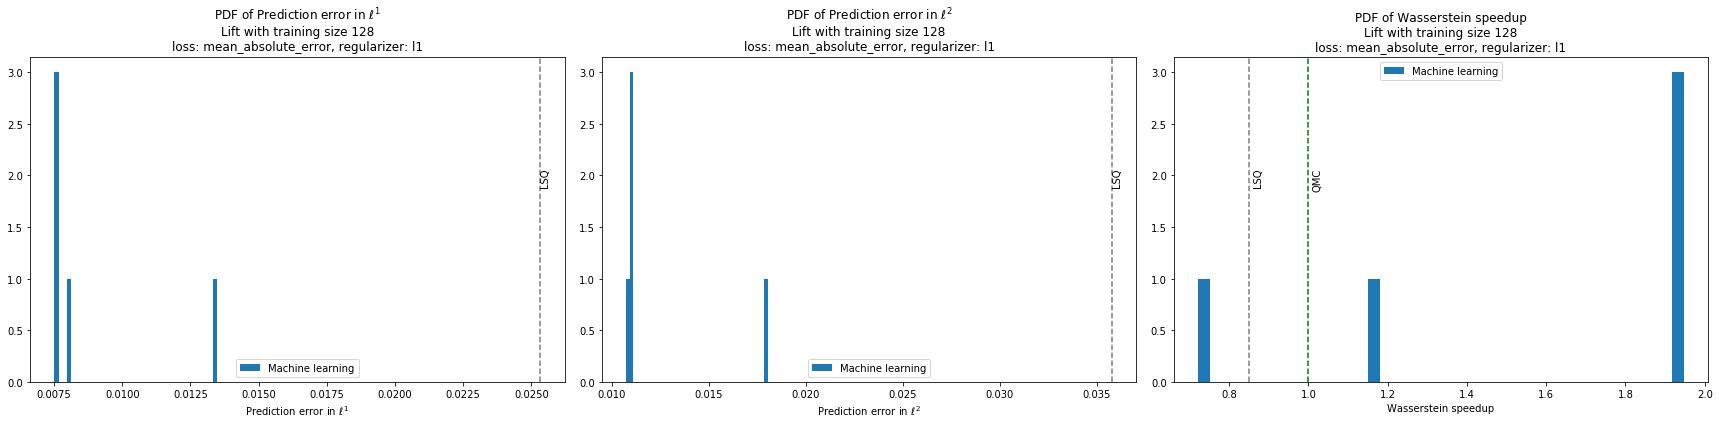

optimizer: SGD, regularizer: l2


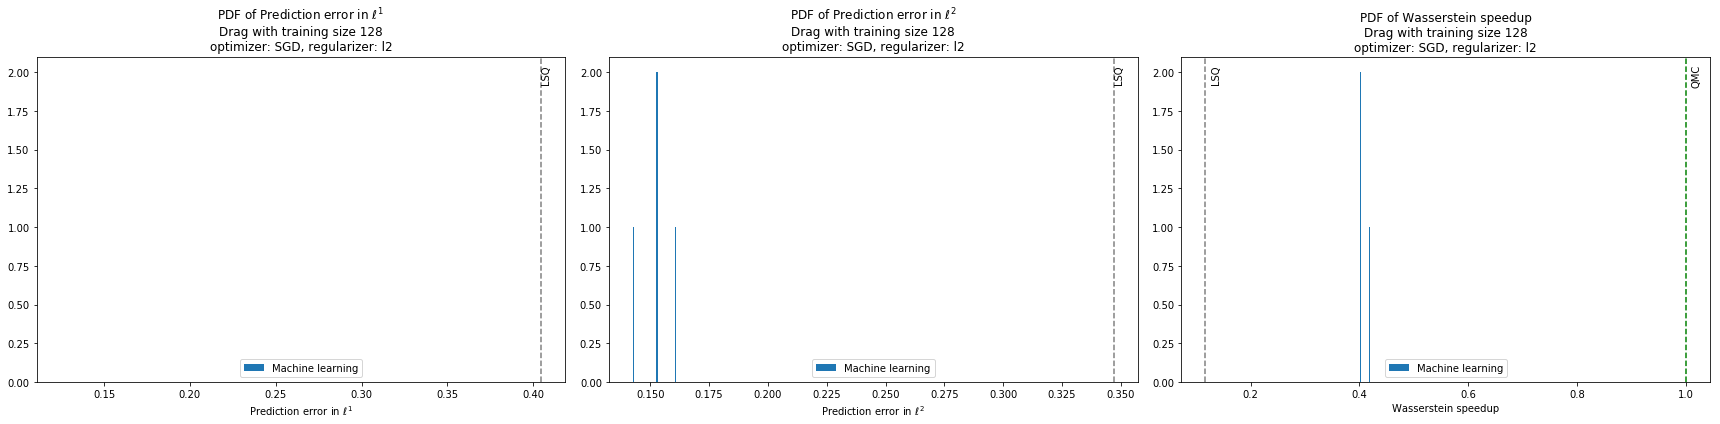

optimizer: SGD, regularizer: None


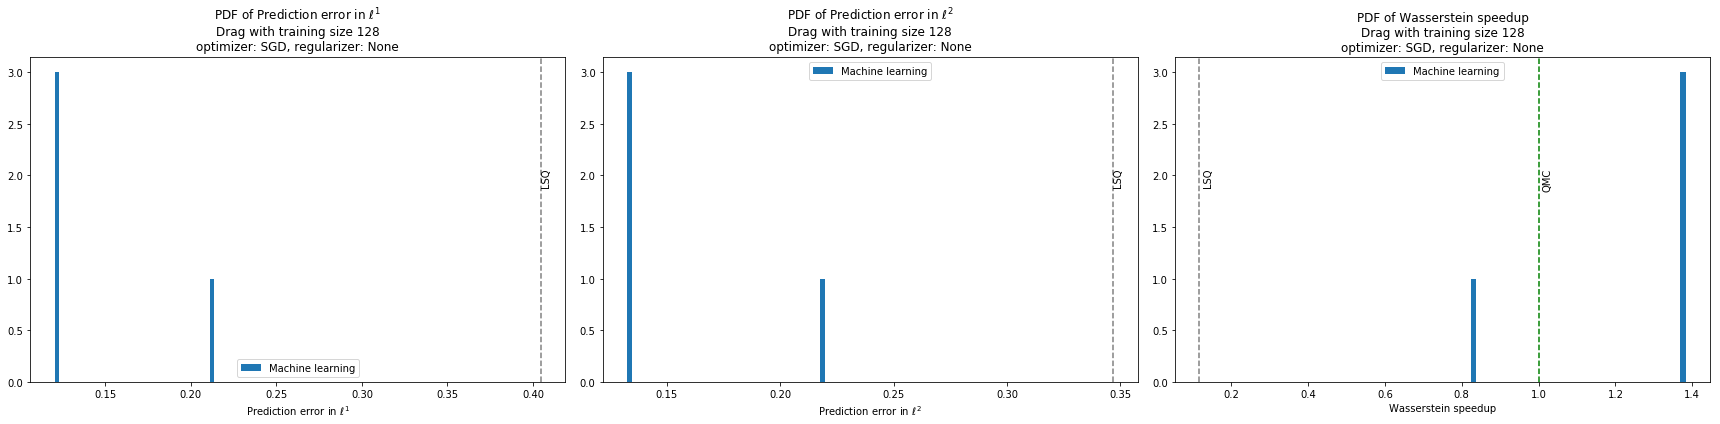

optimizer: SGD, regularizer: l1


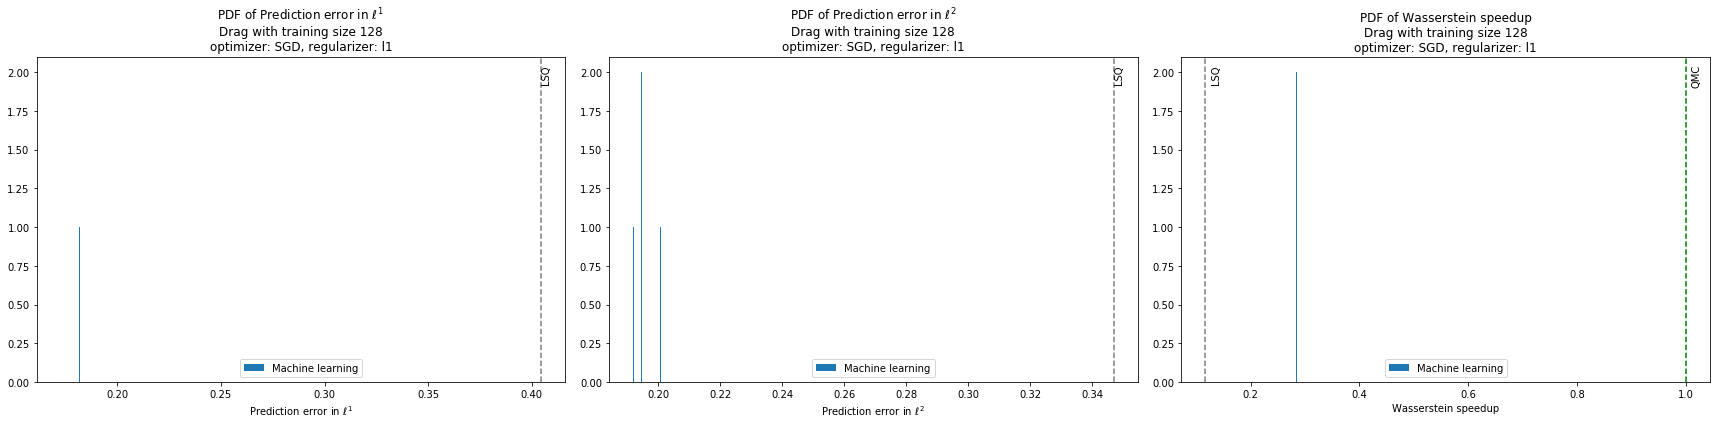

optimizer: Adam, regularizer: l2


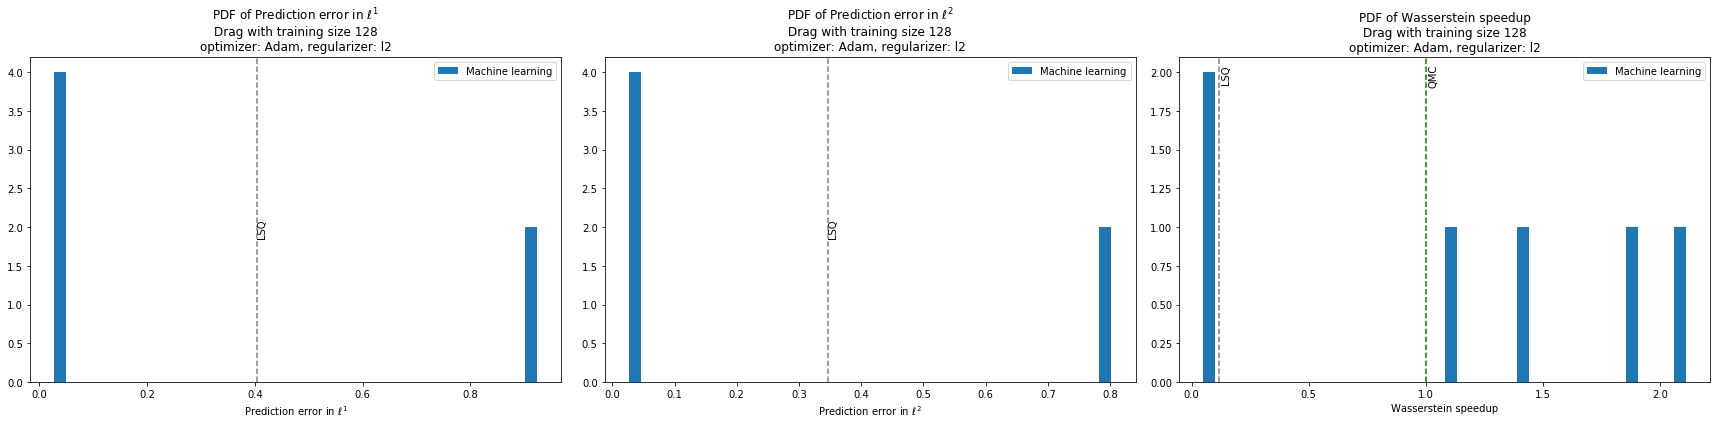

optimizer: Adam, regularizer: None


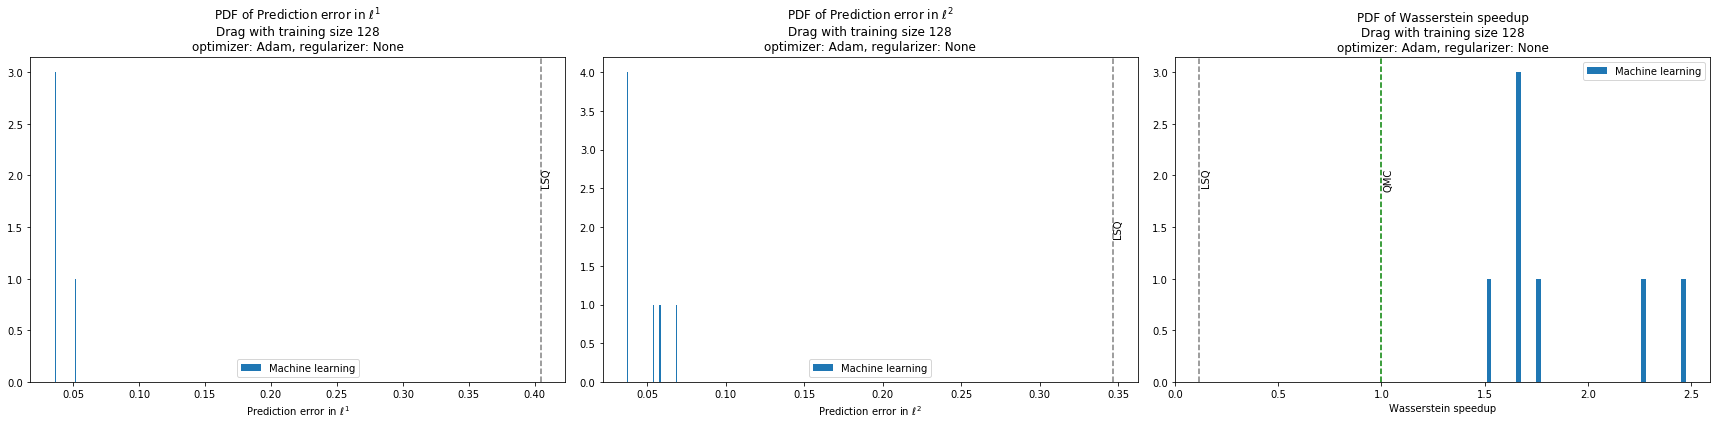

optimizer: Adam, regularizer: l1


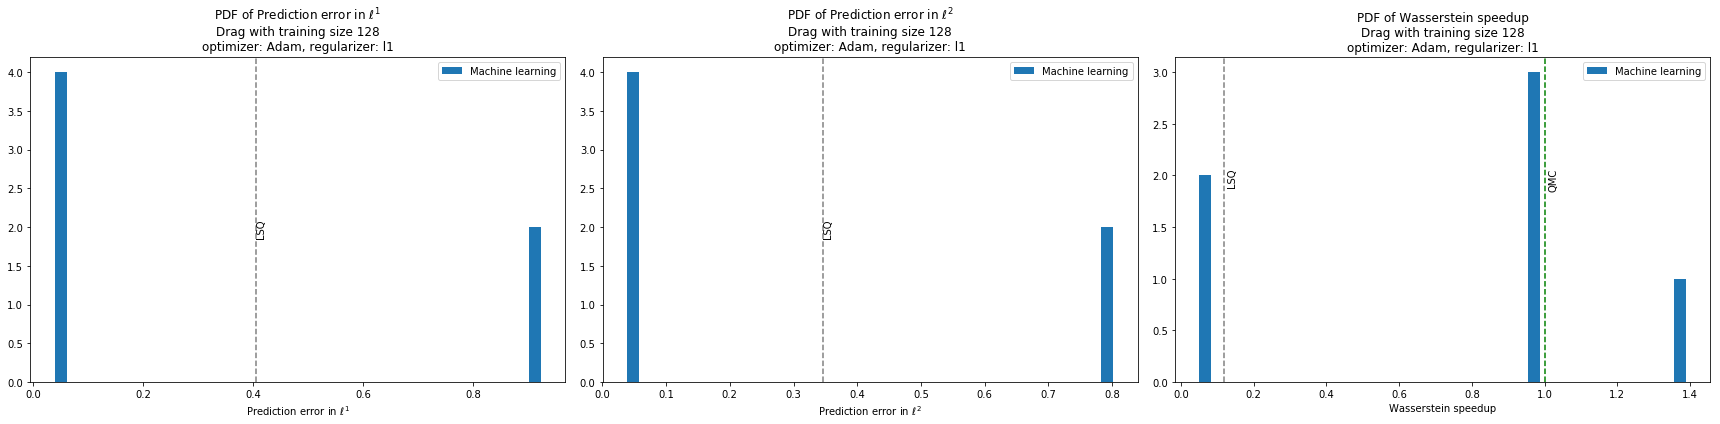

optimizer: SGD, loss: mean_squared_error


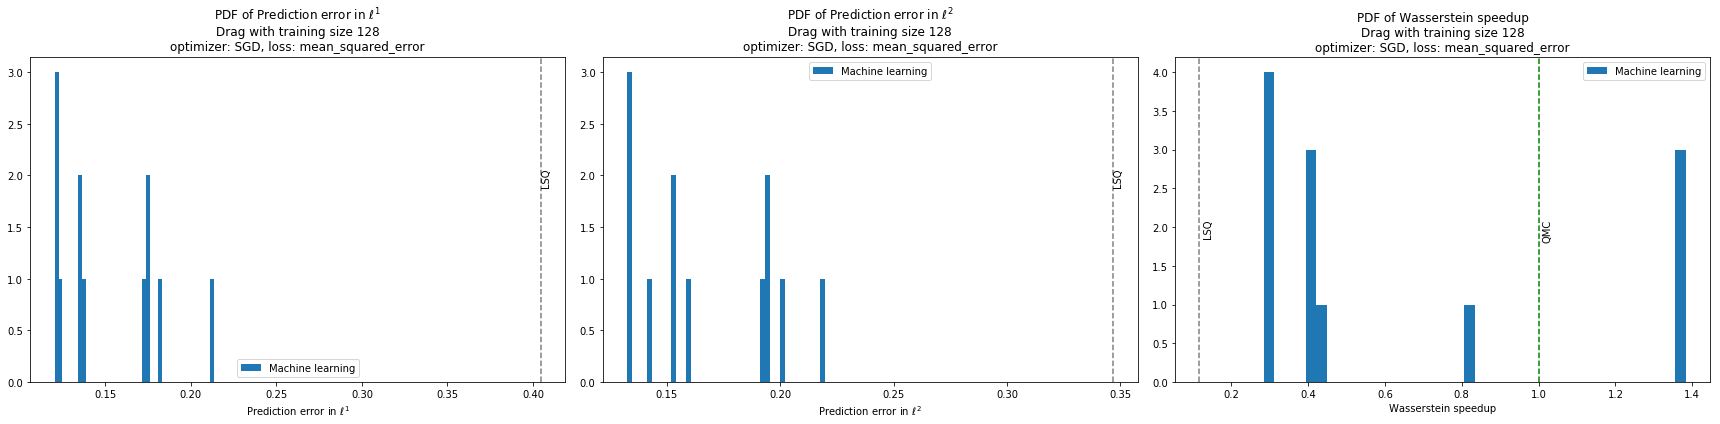

mean_absolute_error
optimizer: Adam, loss: mean_squared_error


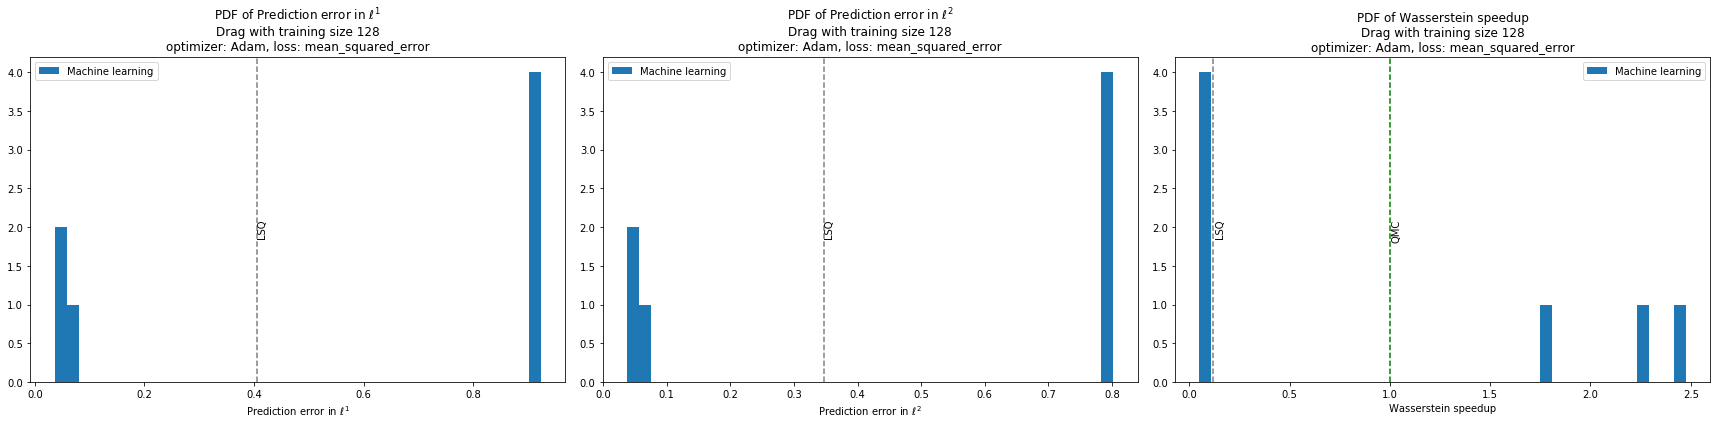

optimizer: Adam, loss: mean_absolute_error


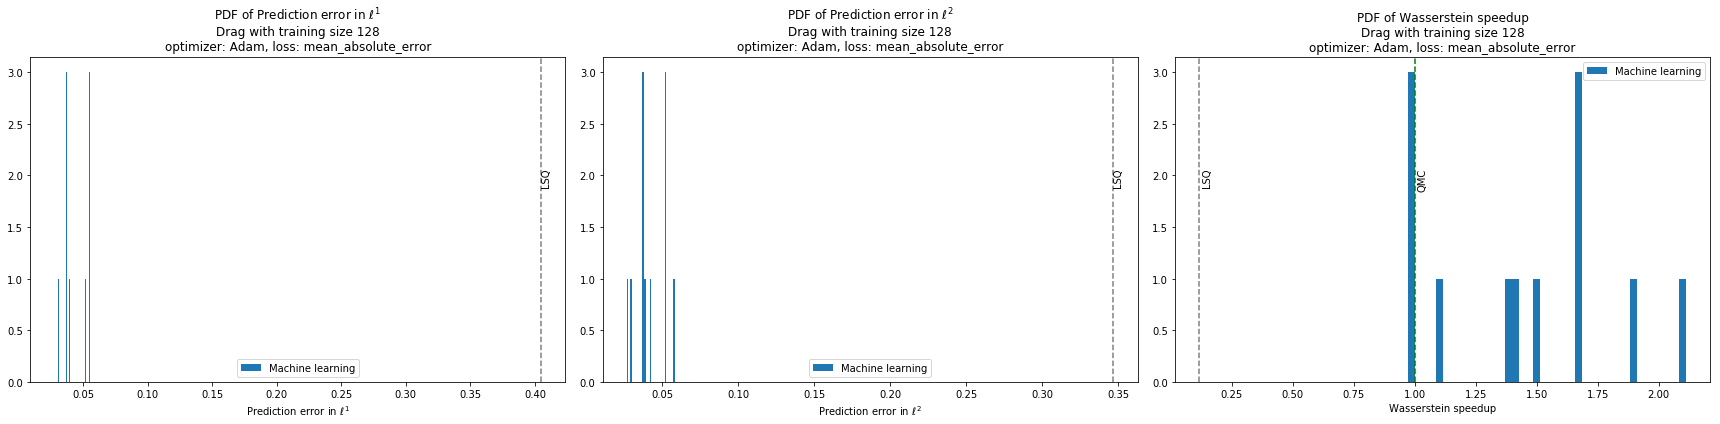

regularizer: l2, optimizer: SGD


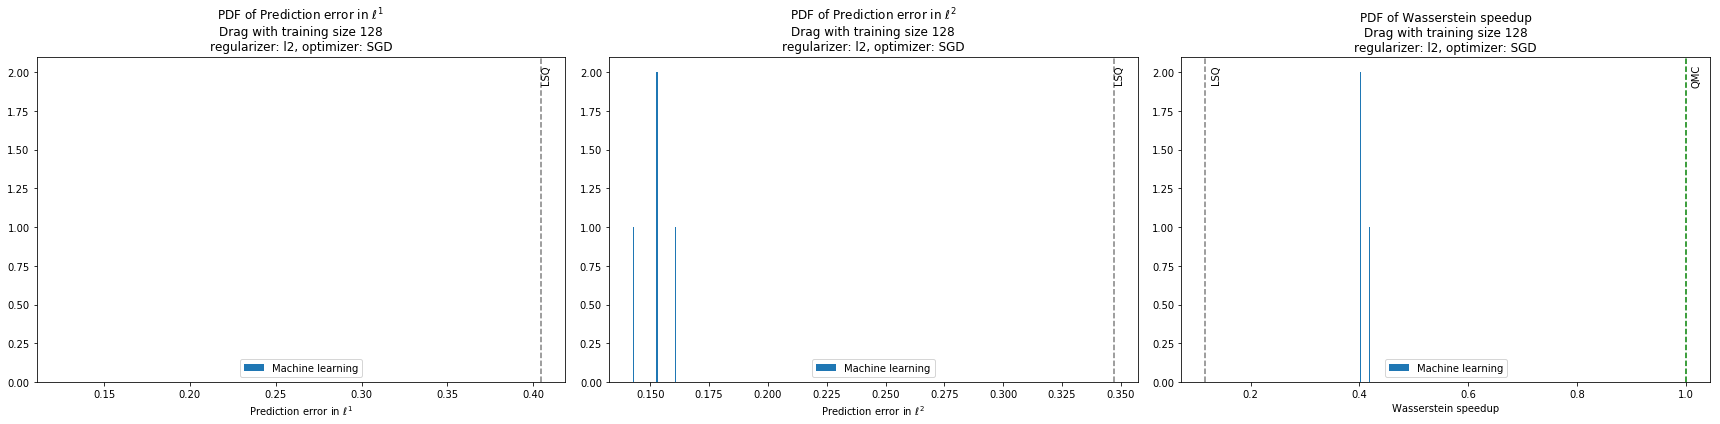

regularizer: l2, optimizer: Adam


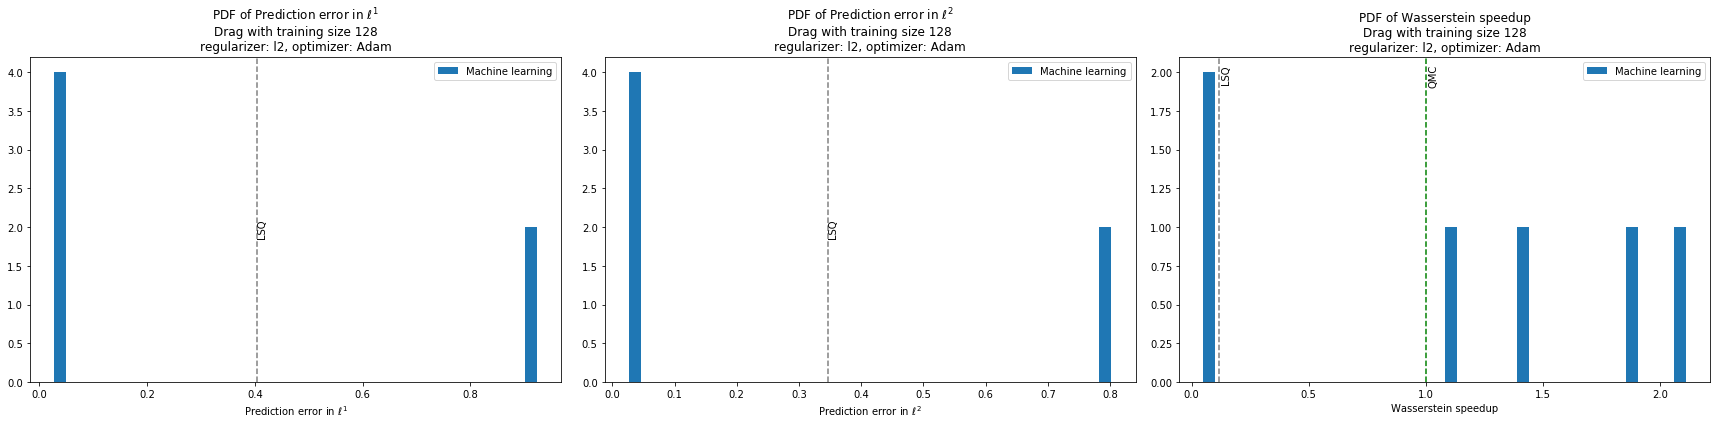

regularizer: None, optimizer: SGD


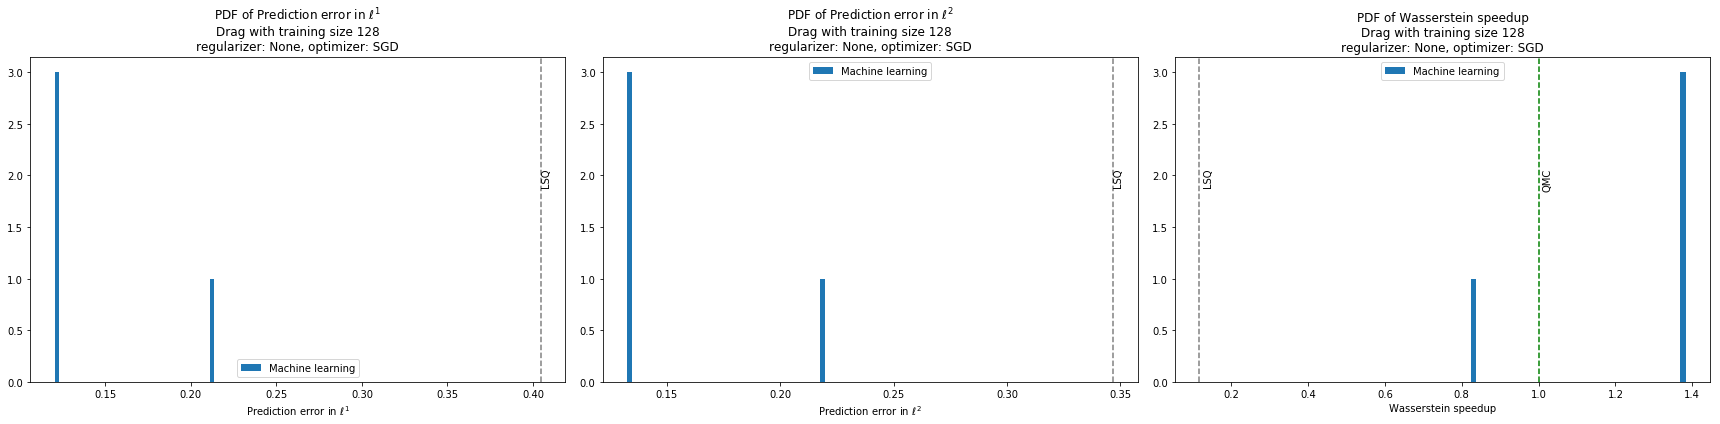

regularizer: None, optimizer: Adam


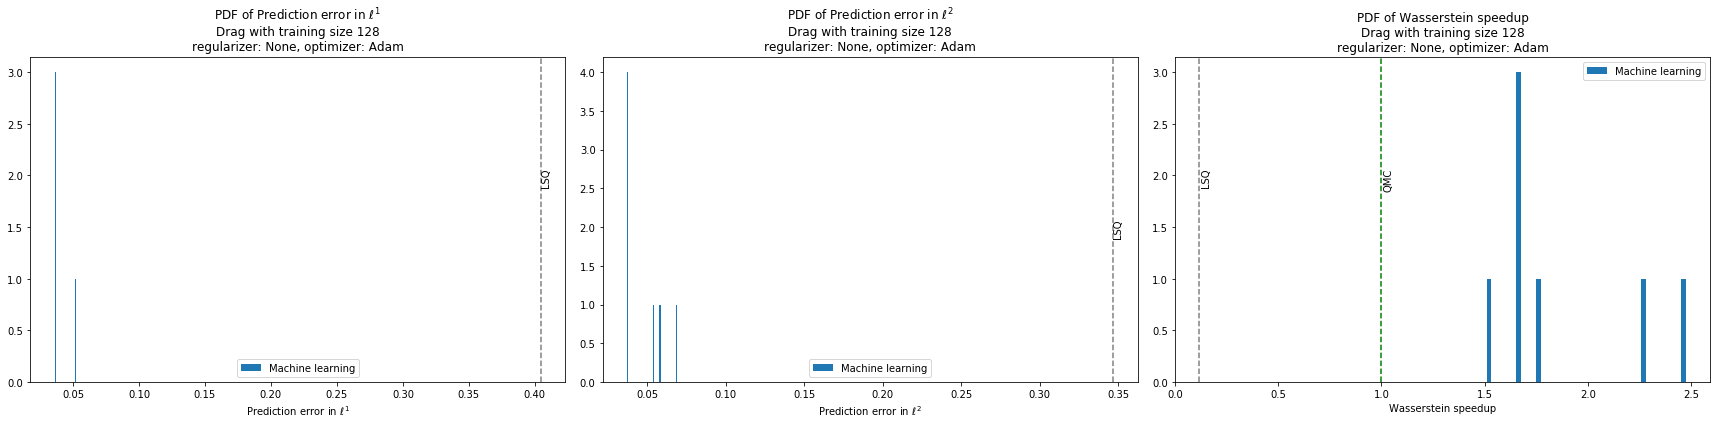

regularizer: l1, optimizer: SGD


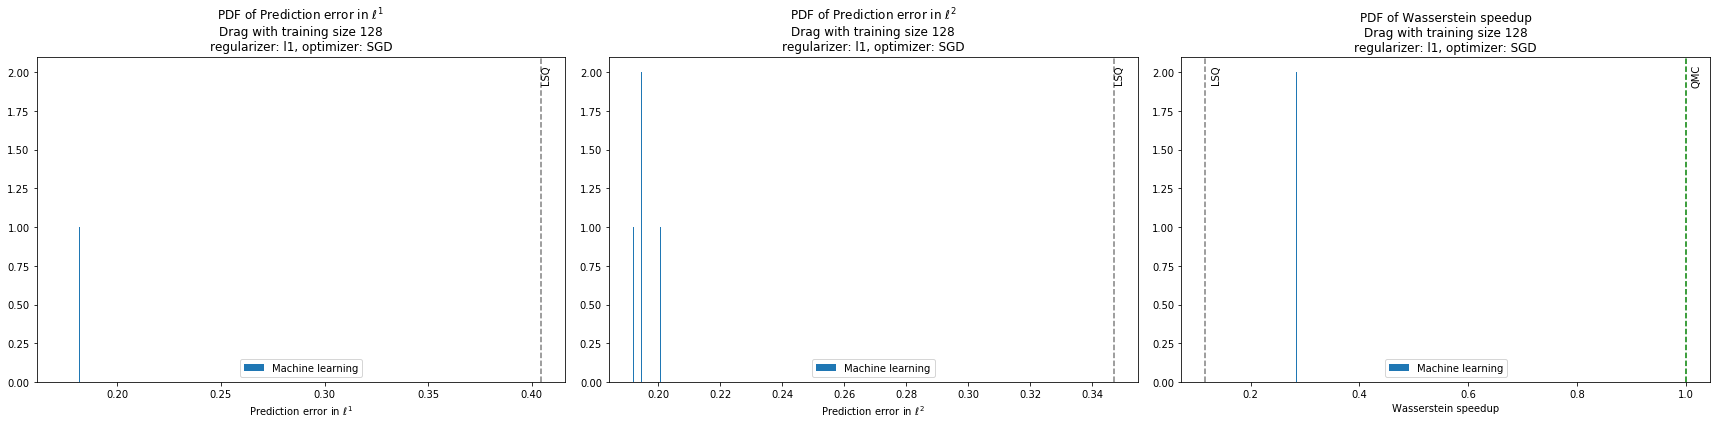

regularizer: l1, optimizer: Adam


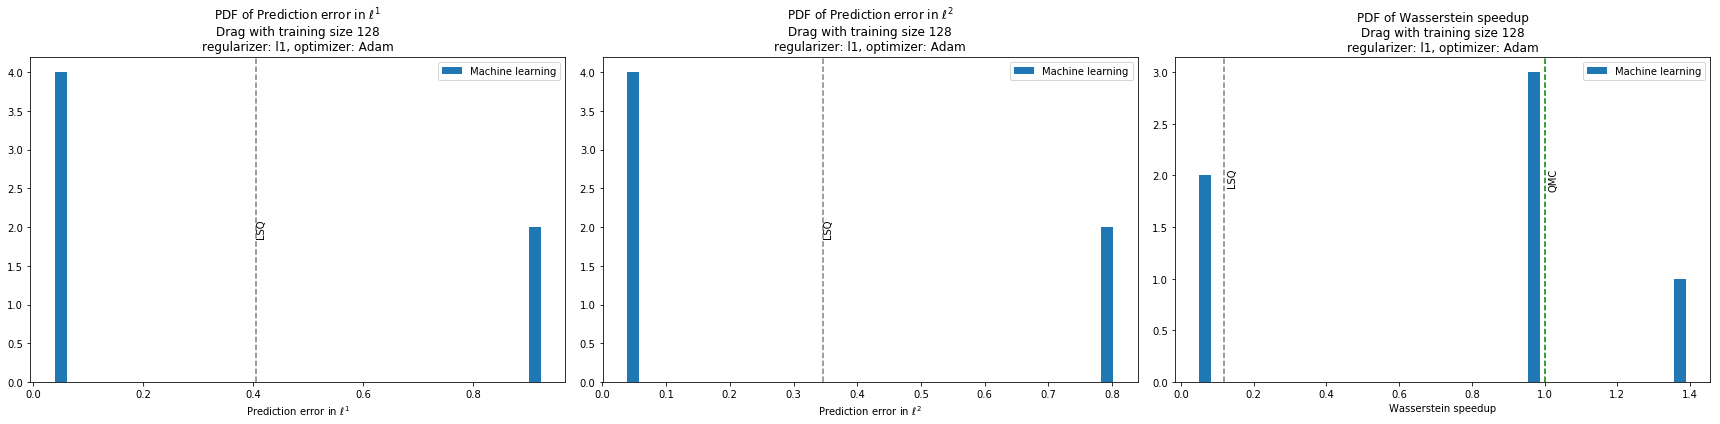

regularizer: l2, loss: mean_squared_error


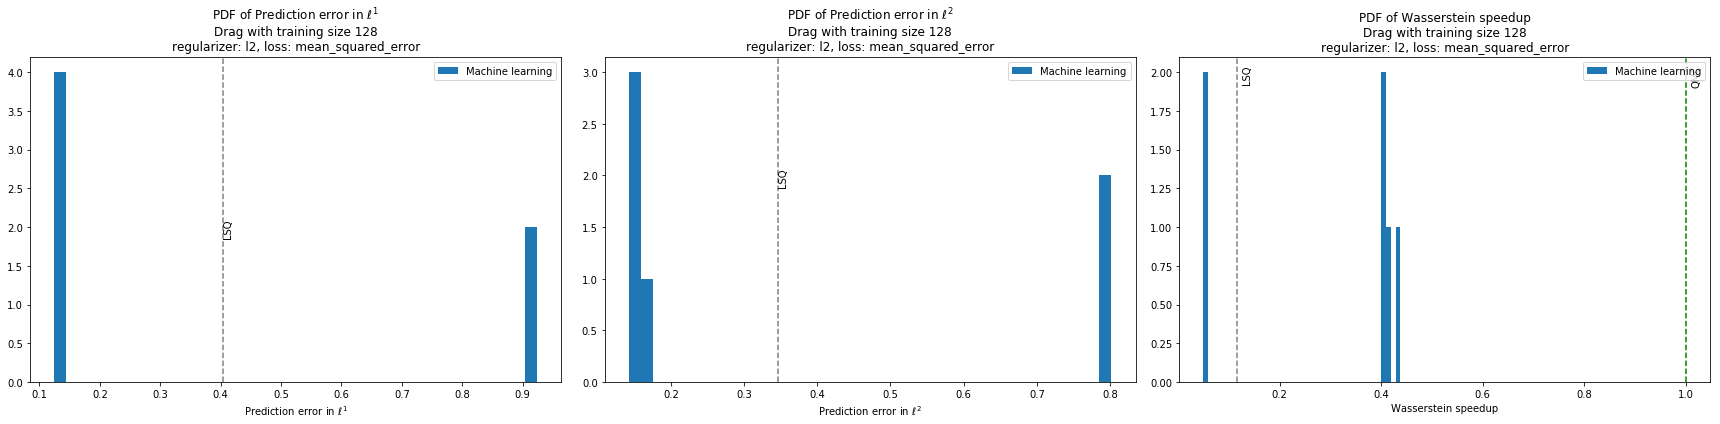

regularizer: l2, loss: mean_absolute_error


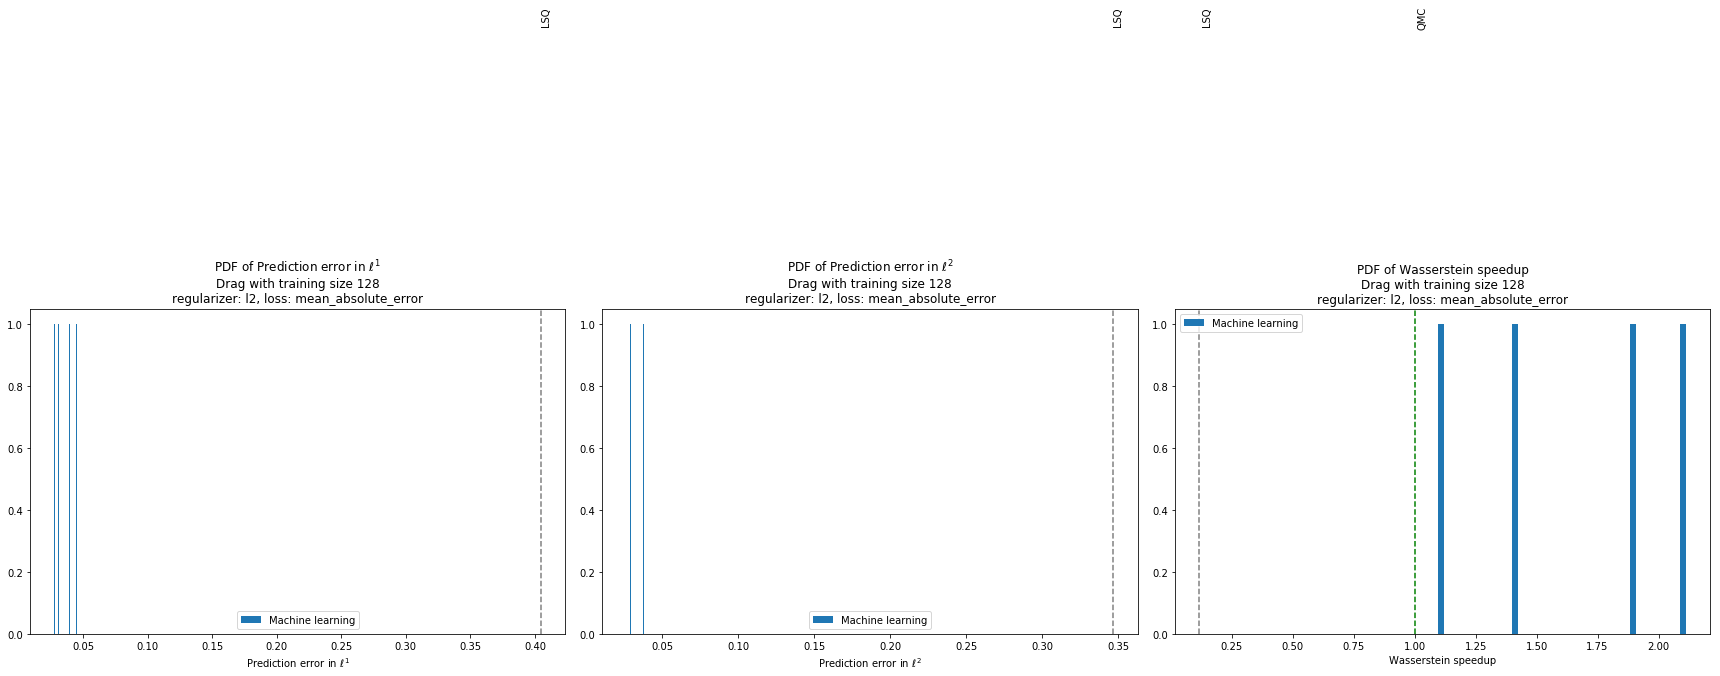

regularizer: None, loss: mean_squared_error


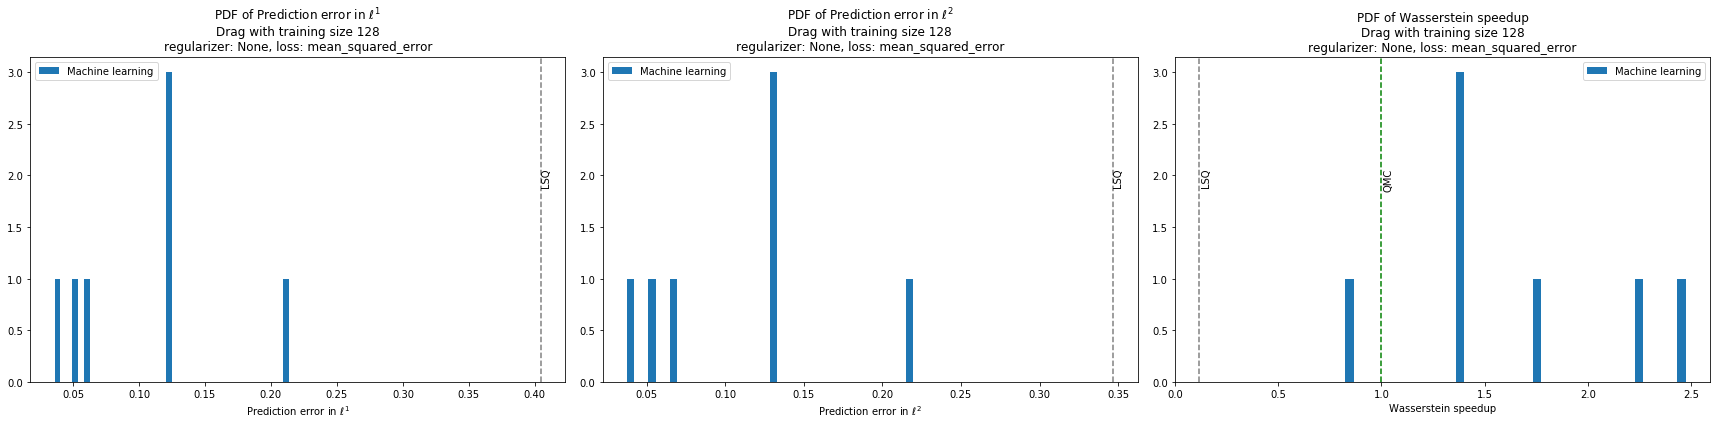

regularizer: None, loss: mean_absolute_error


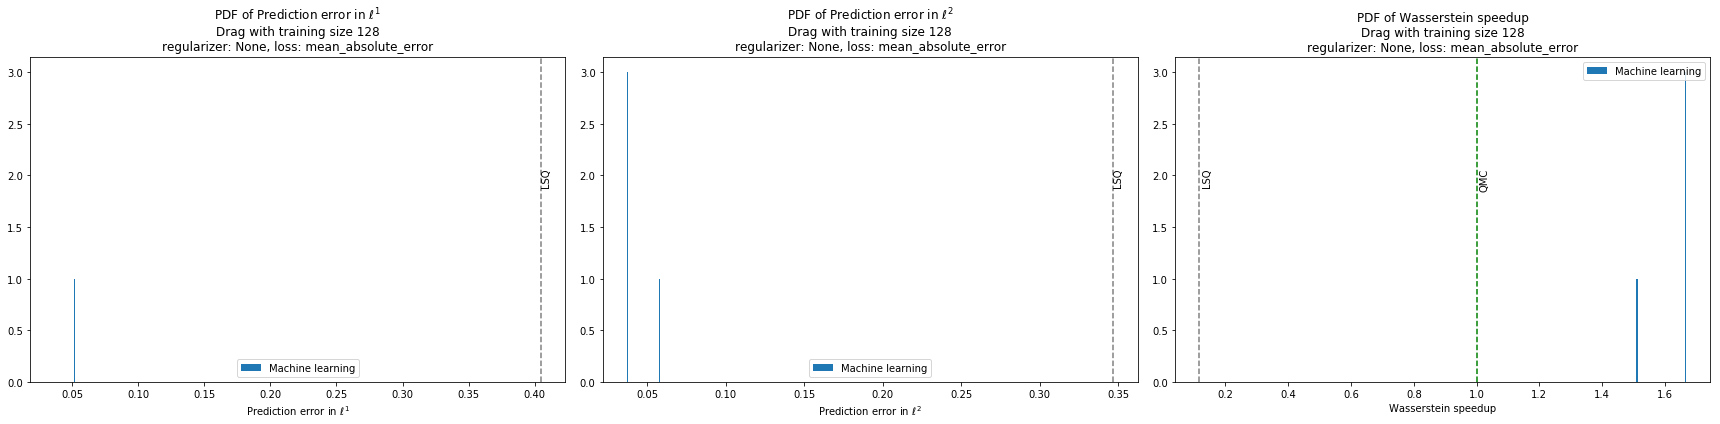

regularizer: l1, loss: mean_squared_error


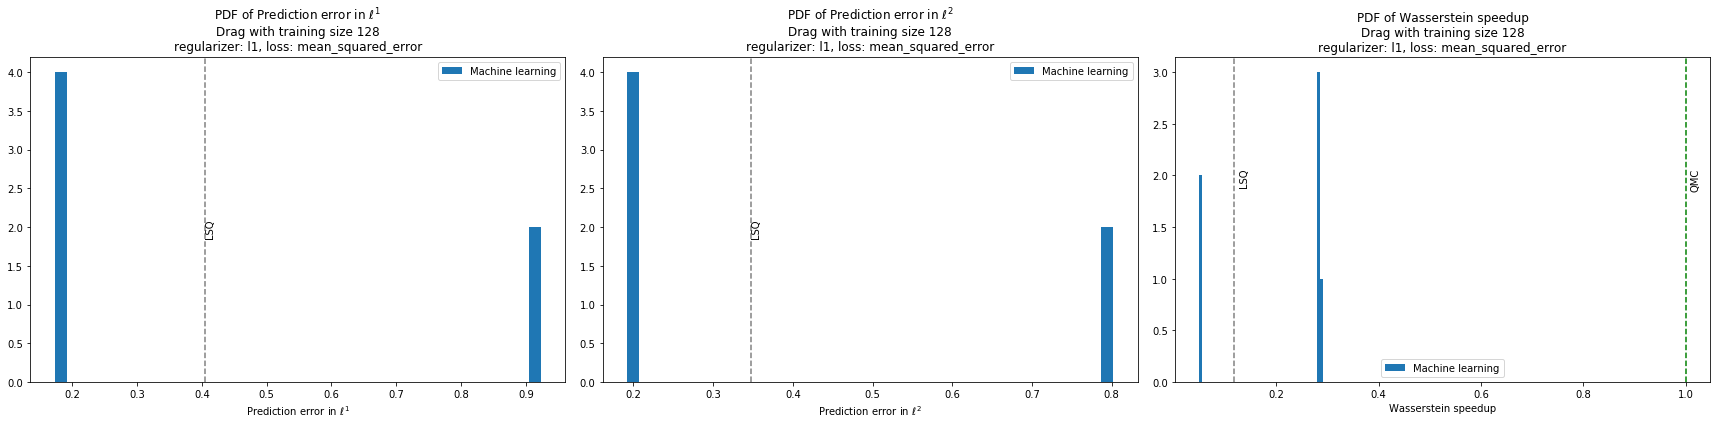

regularizer: l1, loss: mean_absolute_error


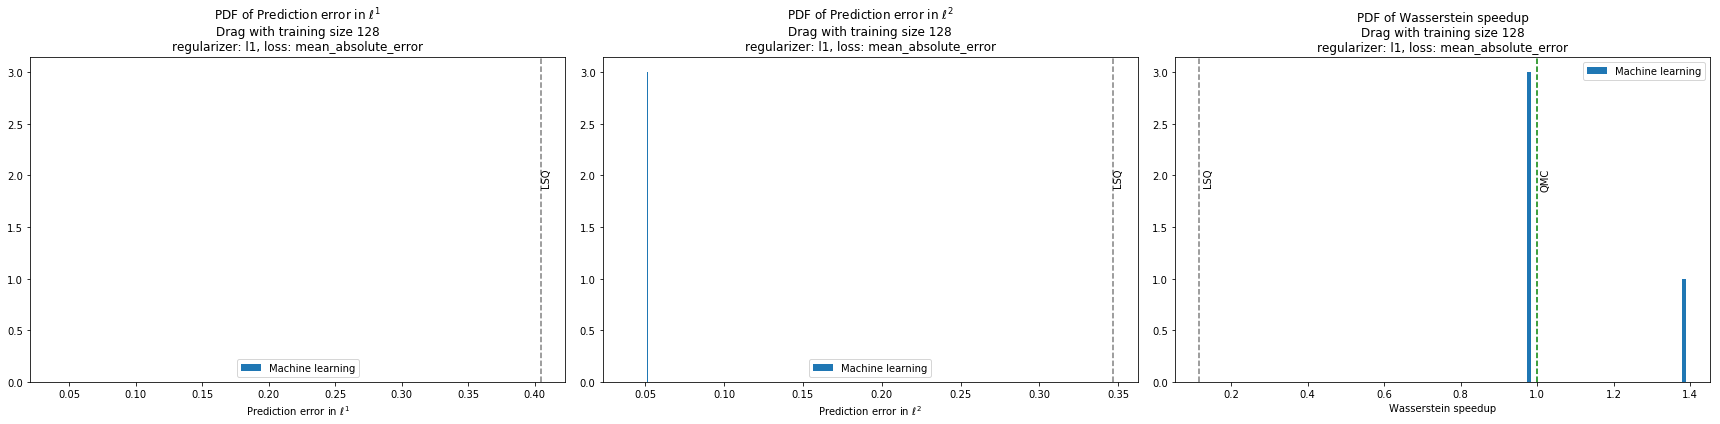

loss: mean_squared_error, optimizer: SGD


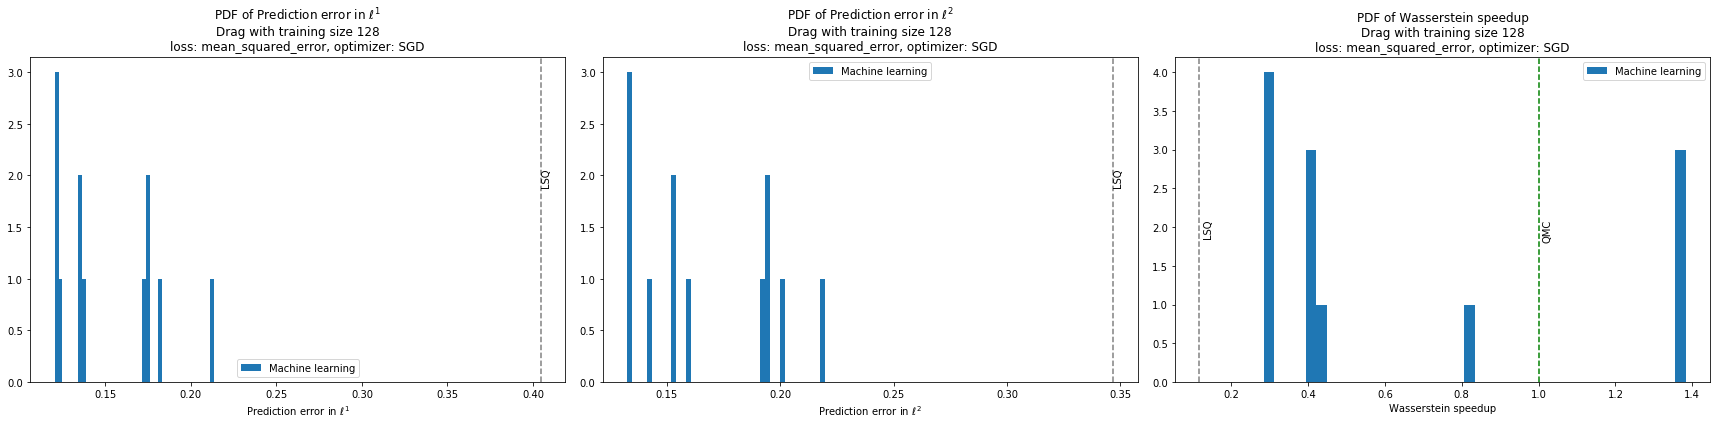

loss: mean_squared_error, optimizer: Adam


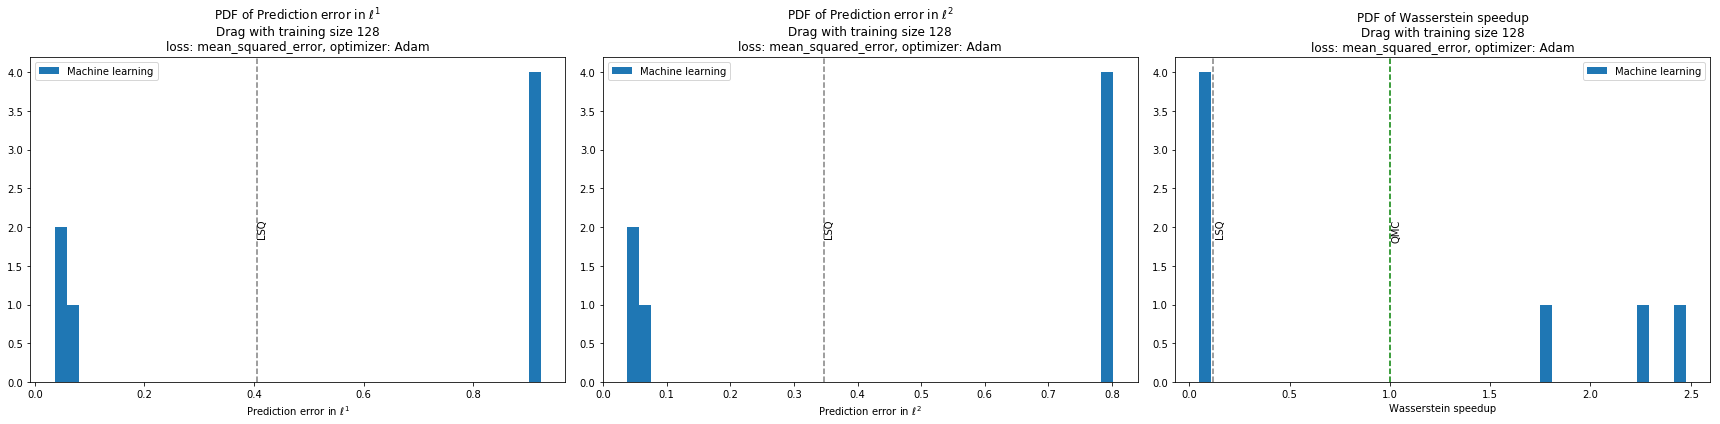

mean_absolute_error
loss: mean_absolute_error, optimizer: Adam


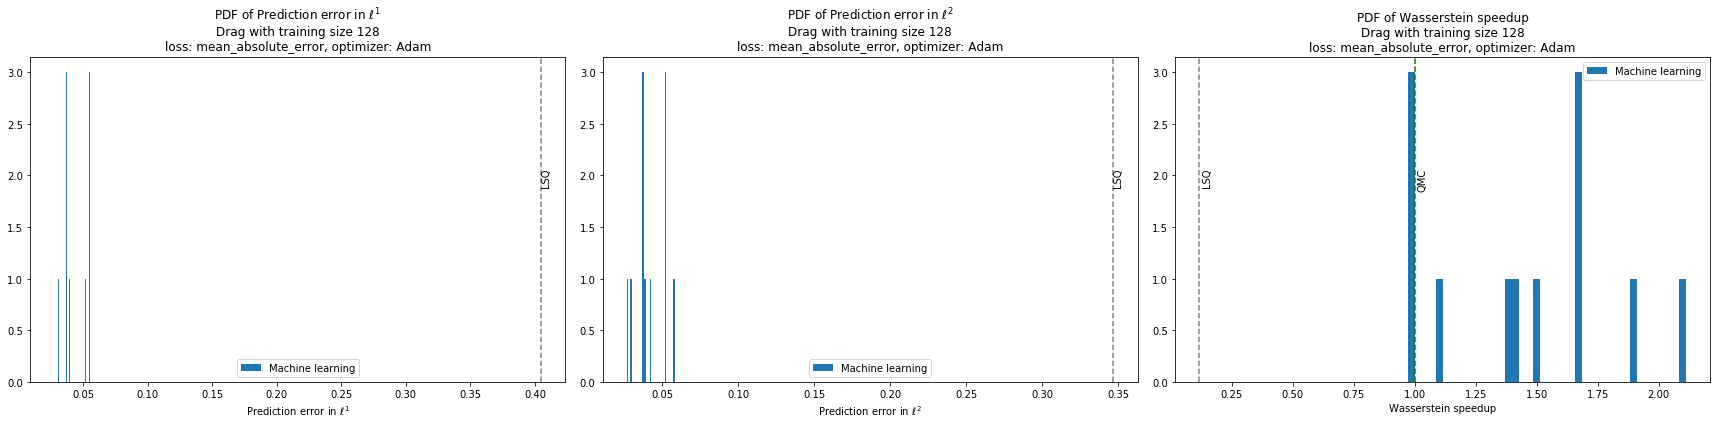

loss: mean_squared_error, regularizer: l2


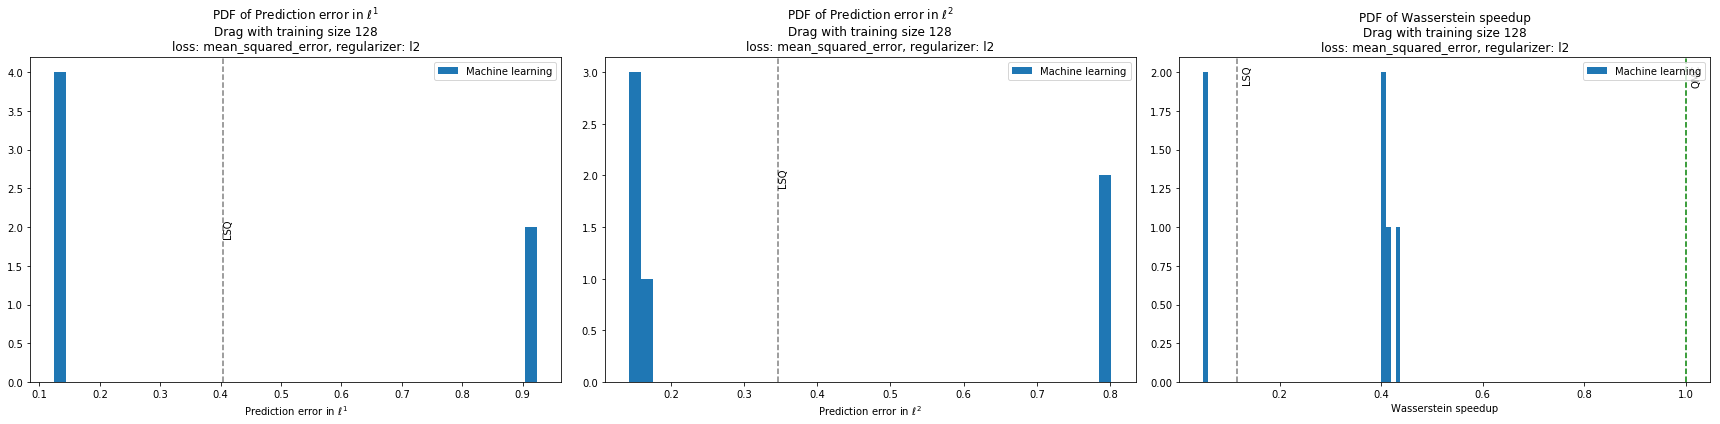

loss: mean_squared_error, regularizer: None


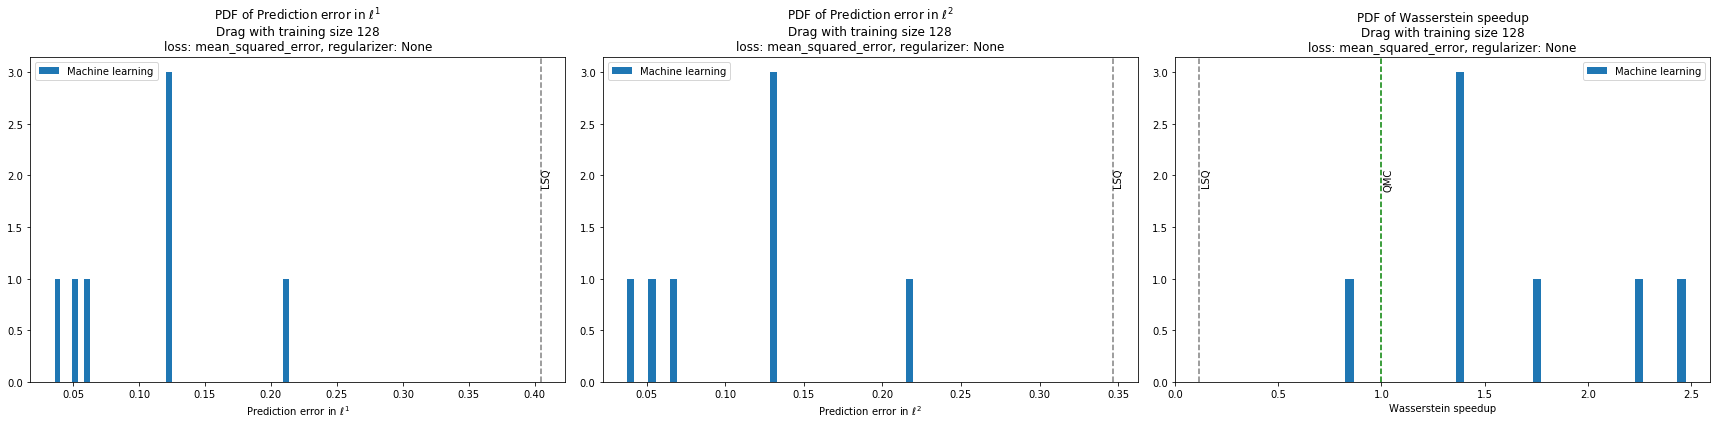

loss: mean_squared_error, regularizer: l1


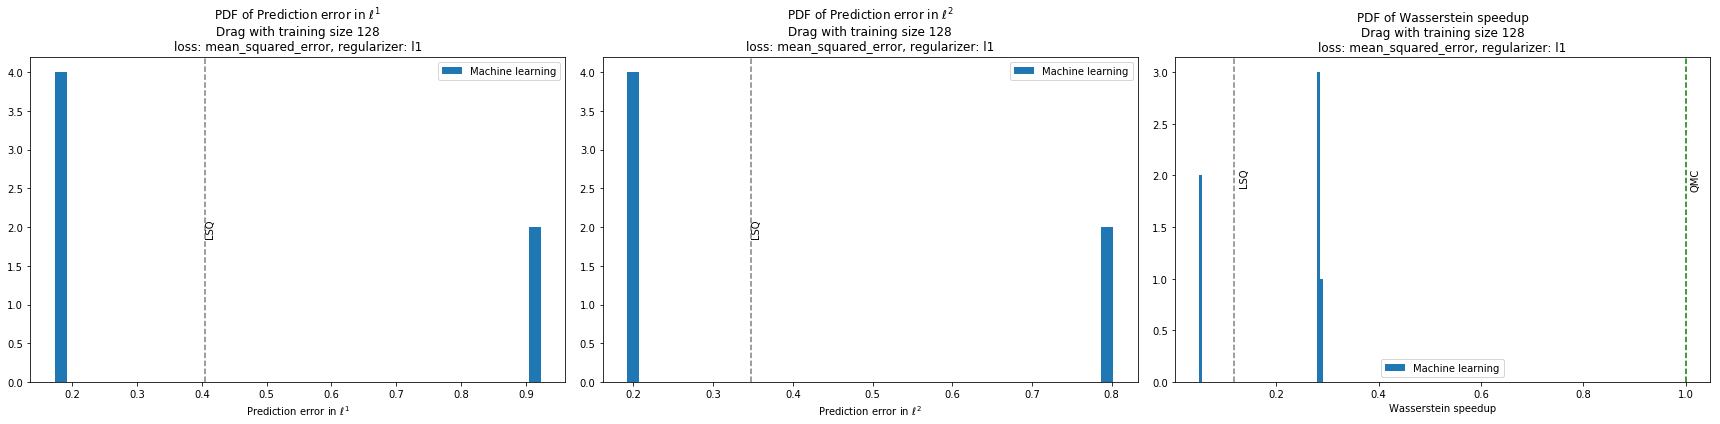

loss: mean_absolute_error, regularizer: l2


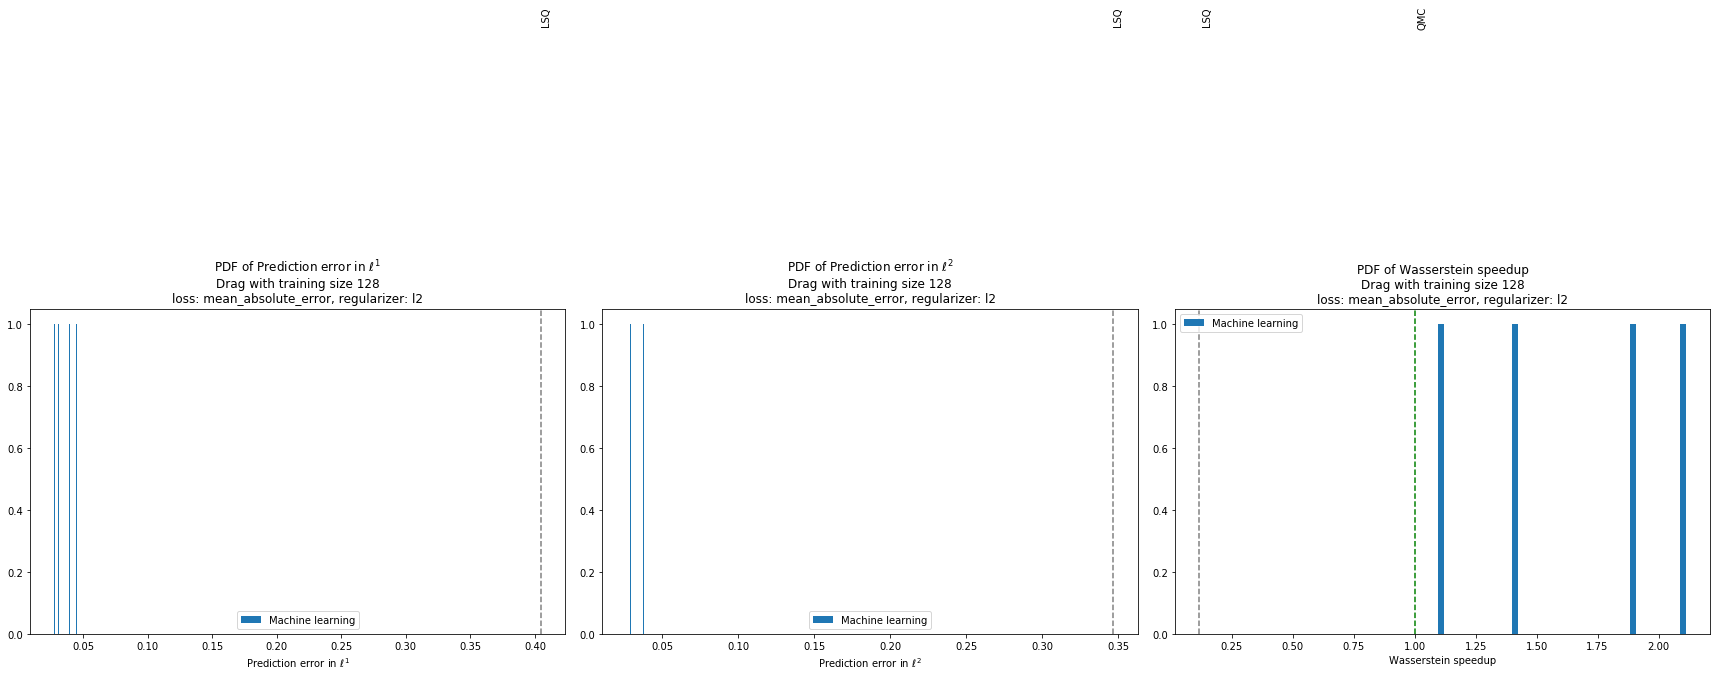

loss: mean_absolute_error, regularizer: None


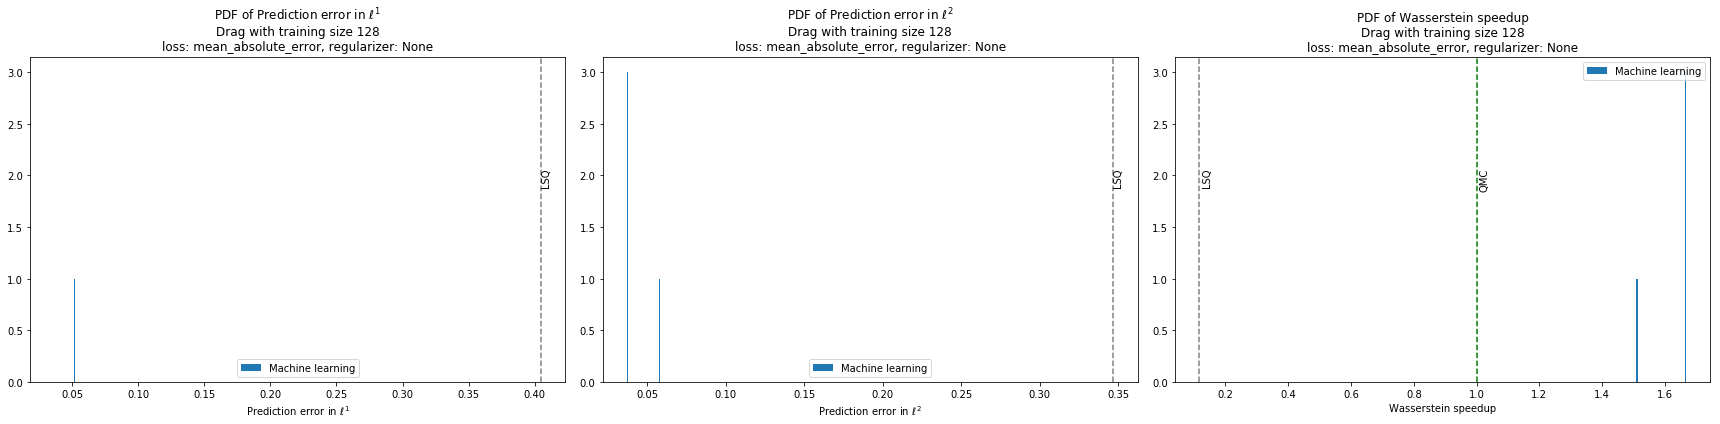

loss: mean_absolute_error, regularizer: l1


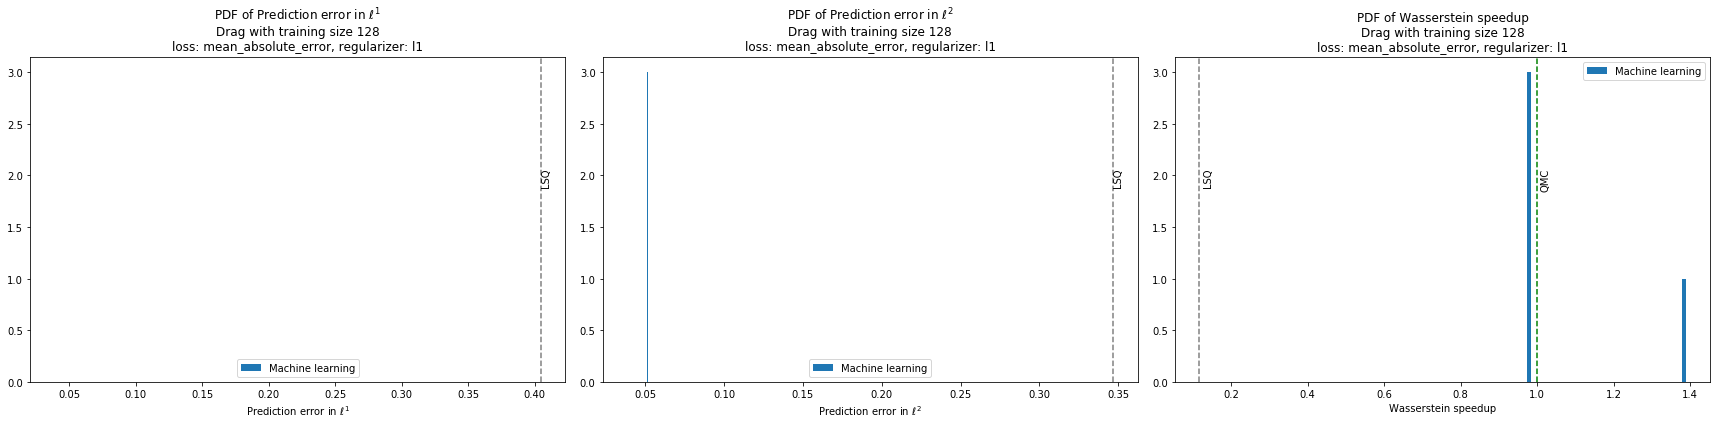

optimizer: SGD, regularizer: l2


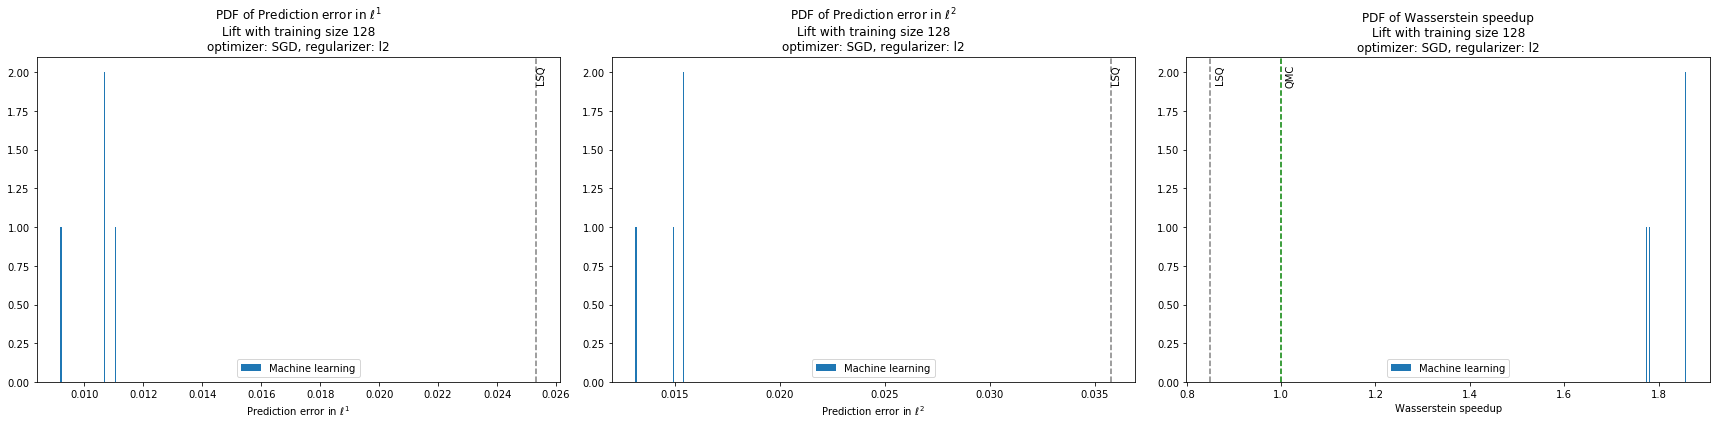

optimizer: SGD, regularizer: None


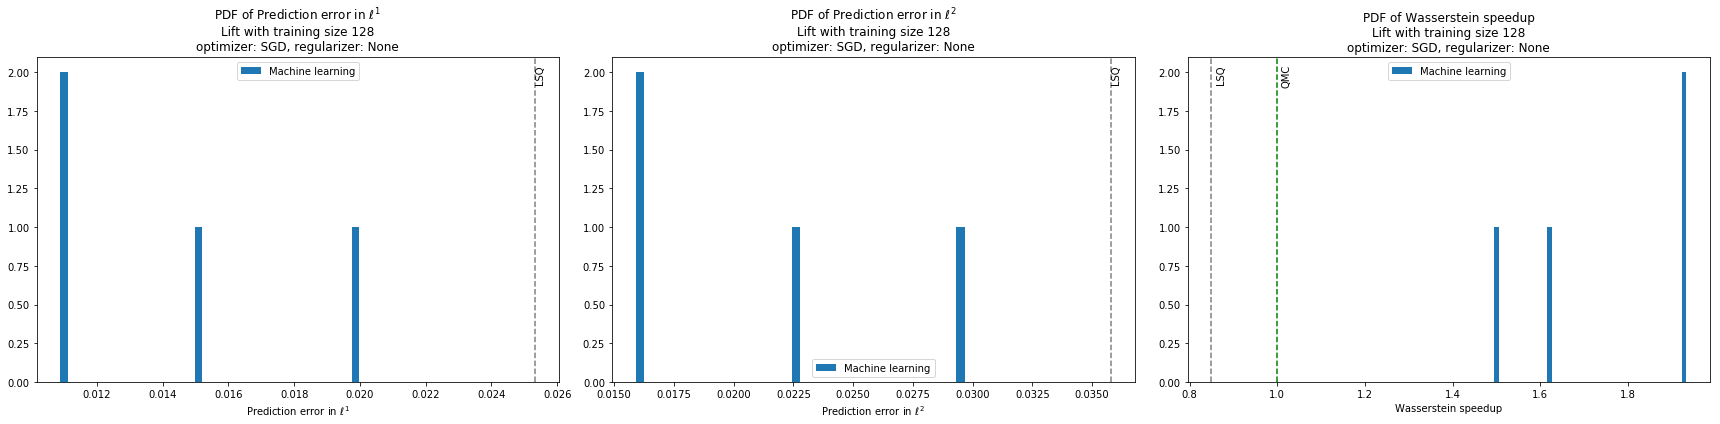

optimizer: SGD, regularizer: l1


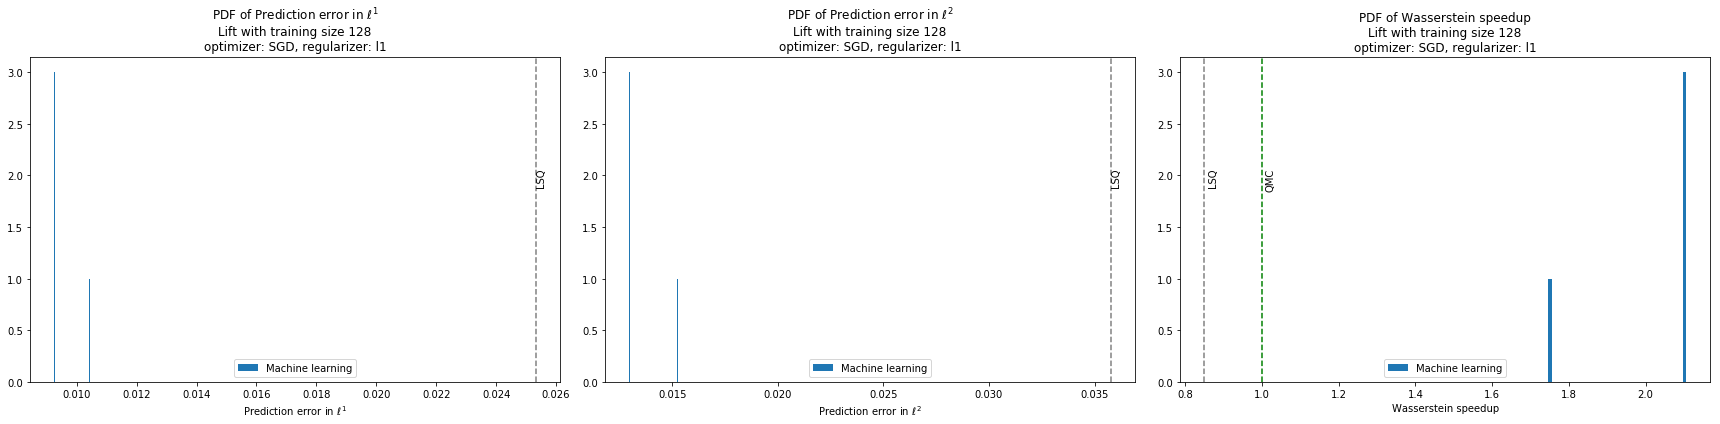

optimizer: Adam, regularizer: l2


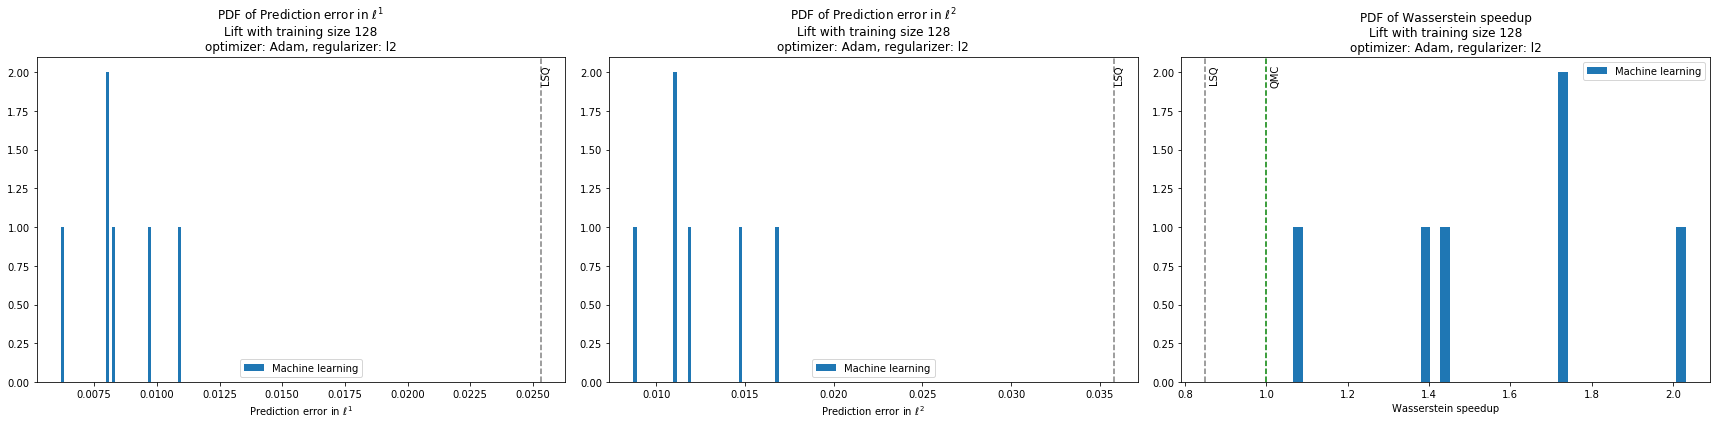

optimizer: Adam, regularizer: None


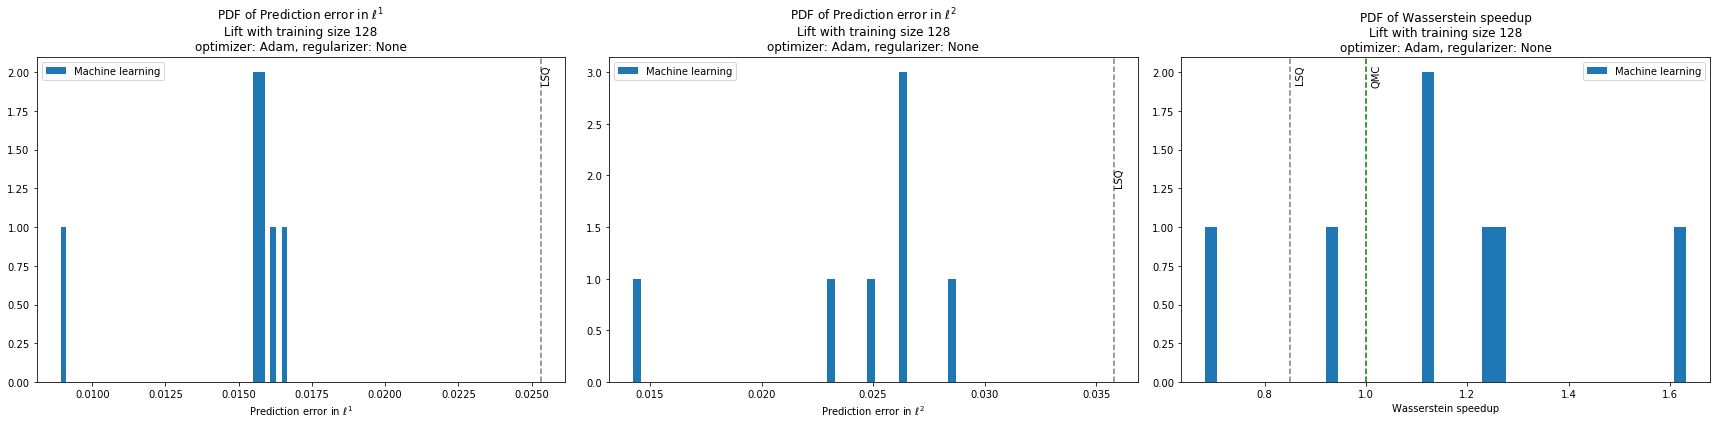

optimizer: Adam, regularizer: l1


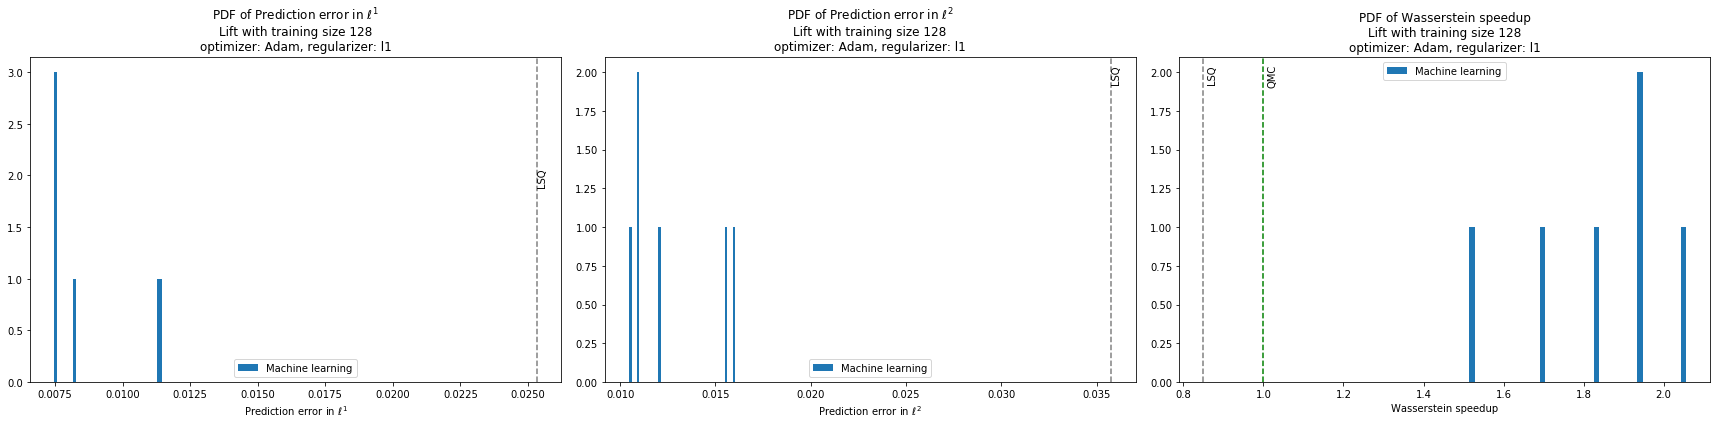

optimizer: SGD, loss: mean_squared_error


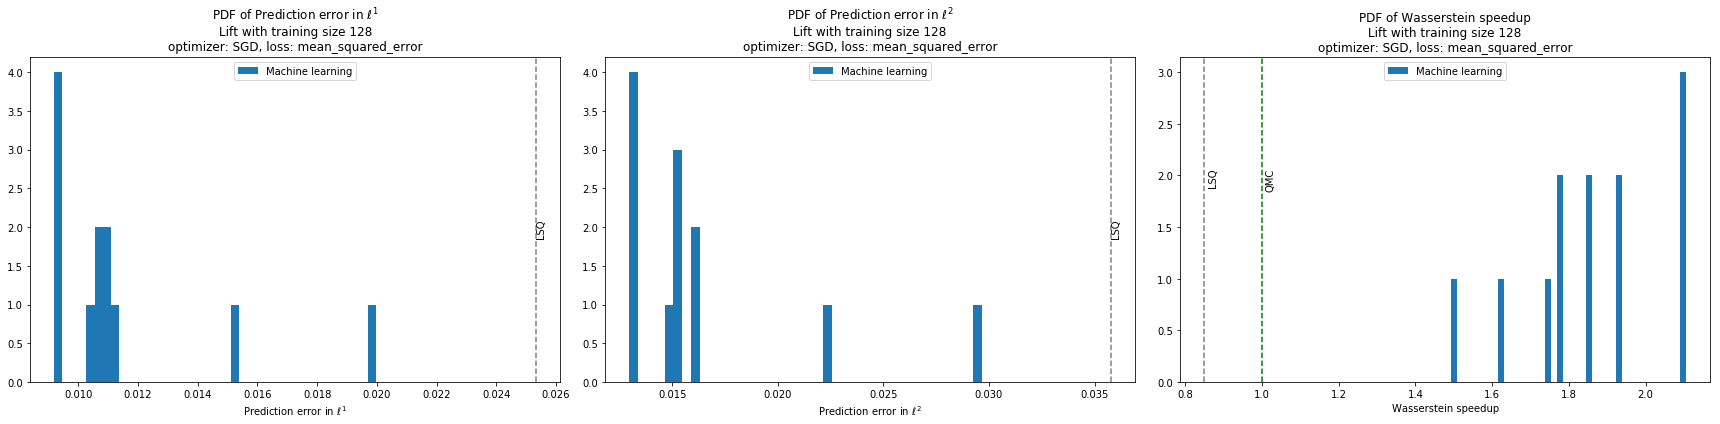

mean_absolute_error
optimizer: Adam, loss: mean_squared_error


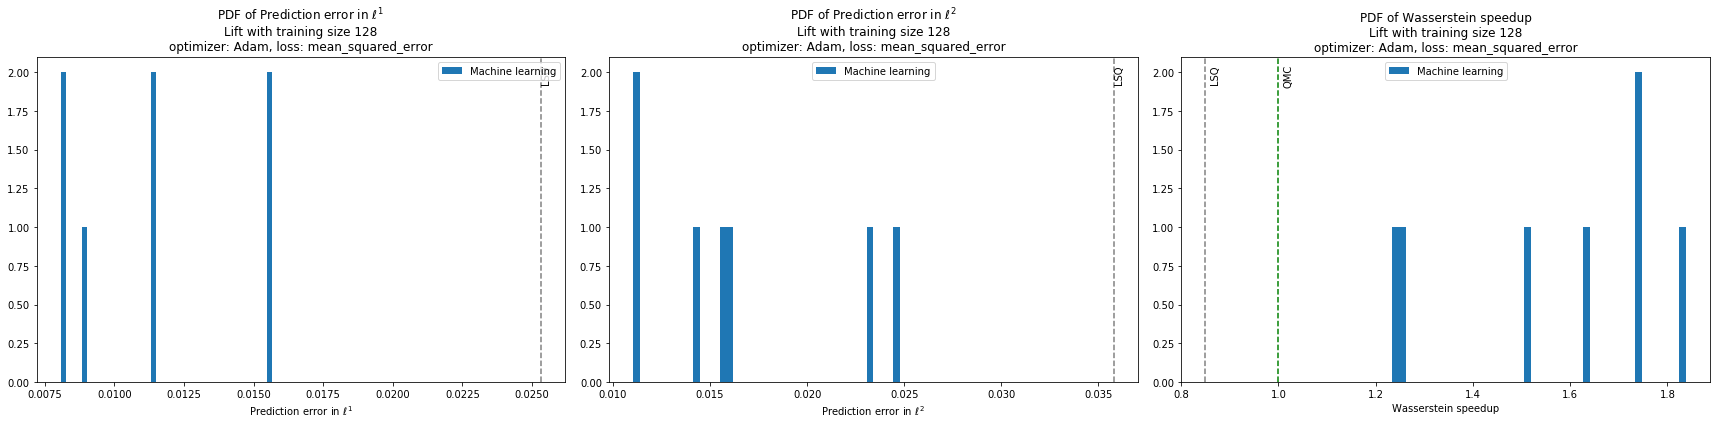

optimizer: Adam, loss: mean_absolute_error


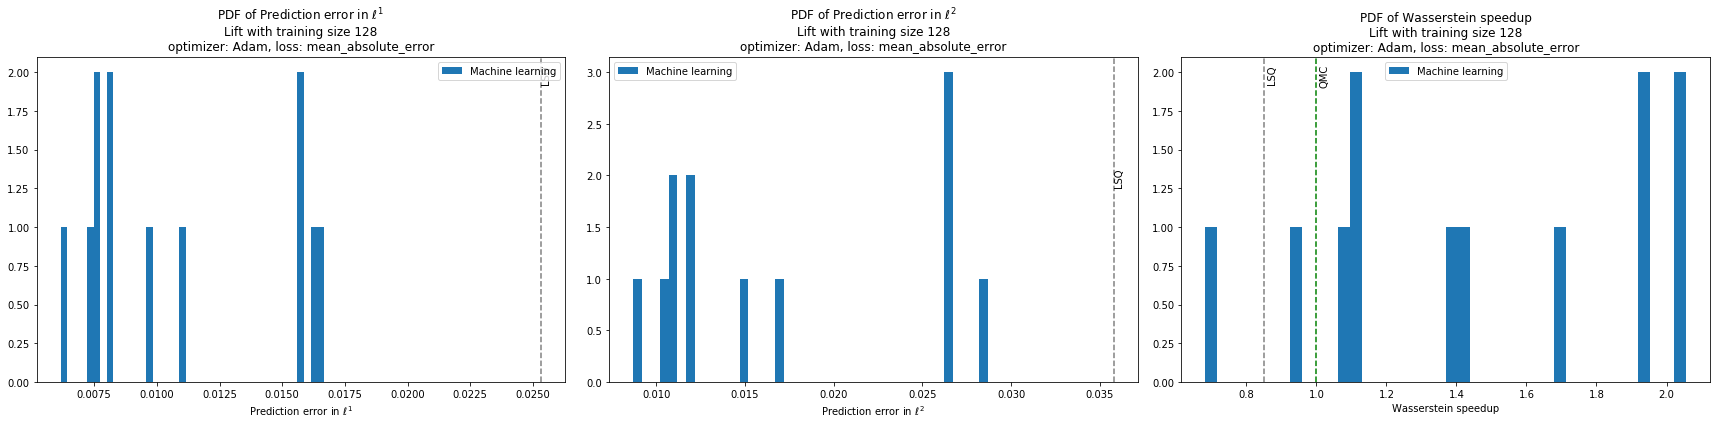

regularizer: l2, optimizer: SGD


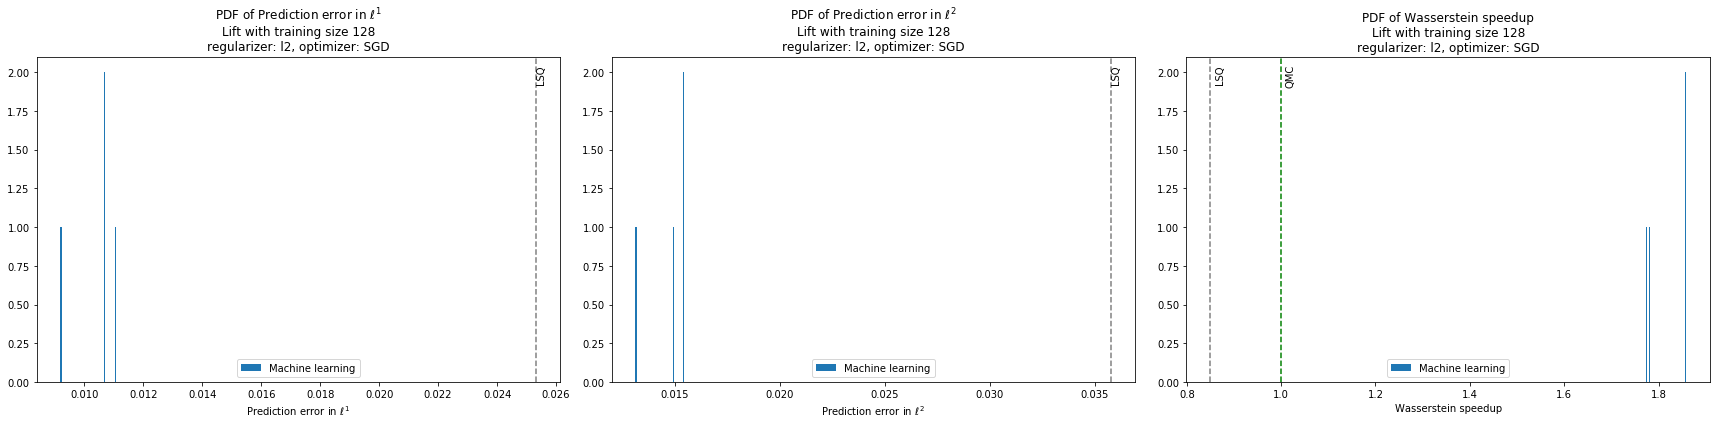

regularizer: l2, optimizer: Adam


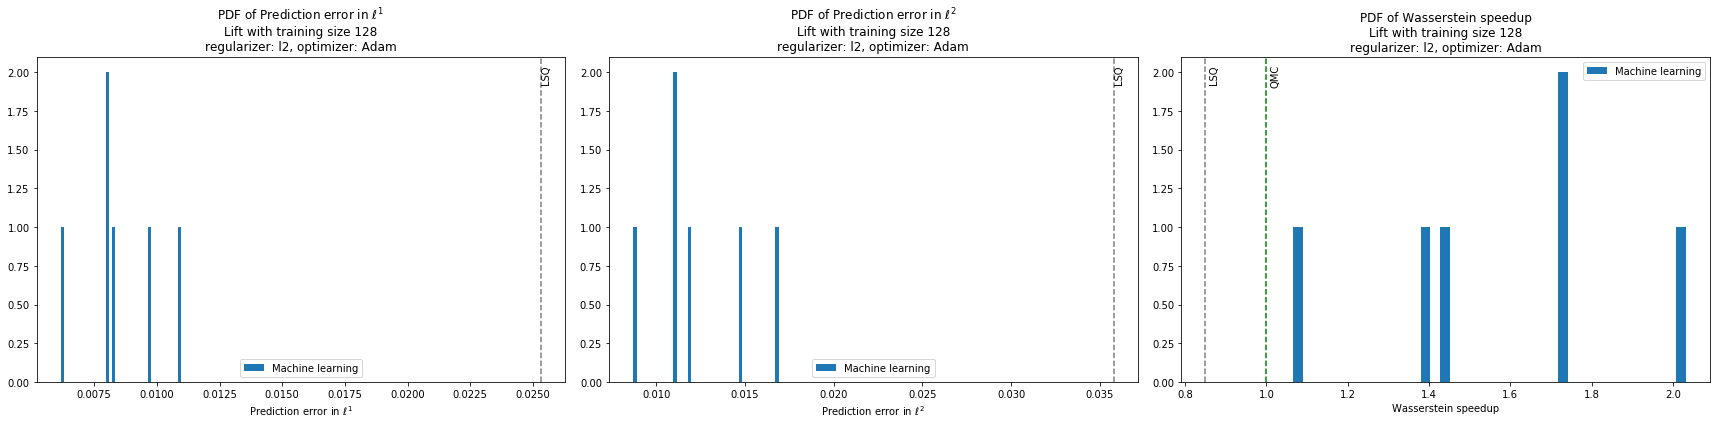

regularizer: None, optimizer: SGD


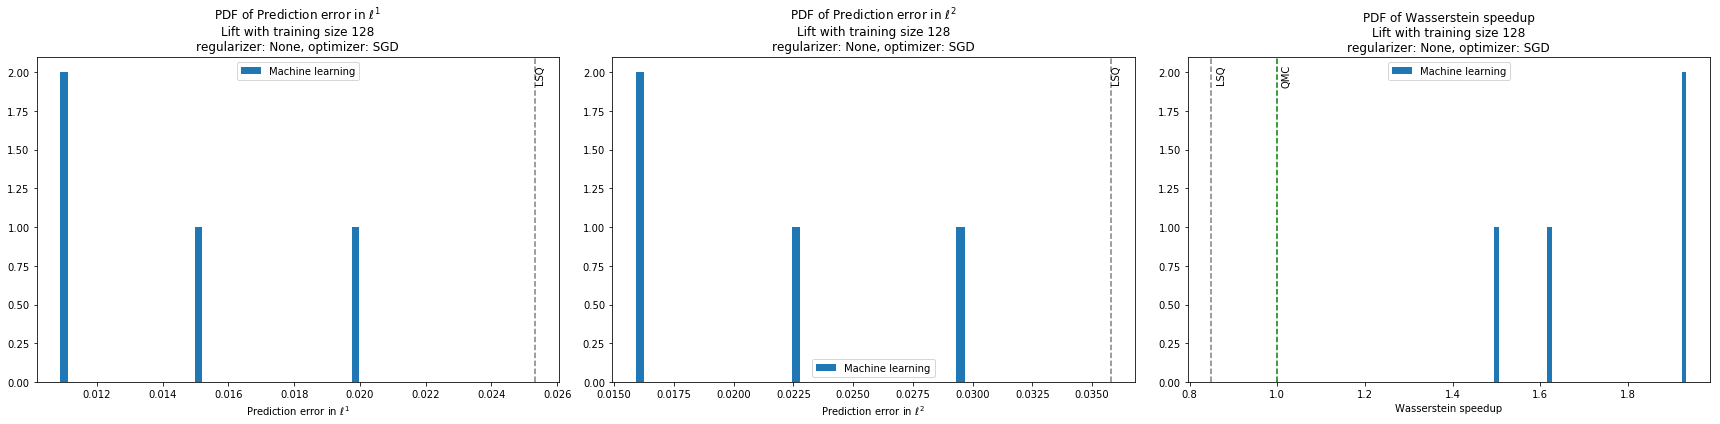

regularizer: None, optimizer: Adam


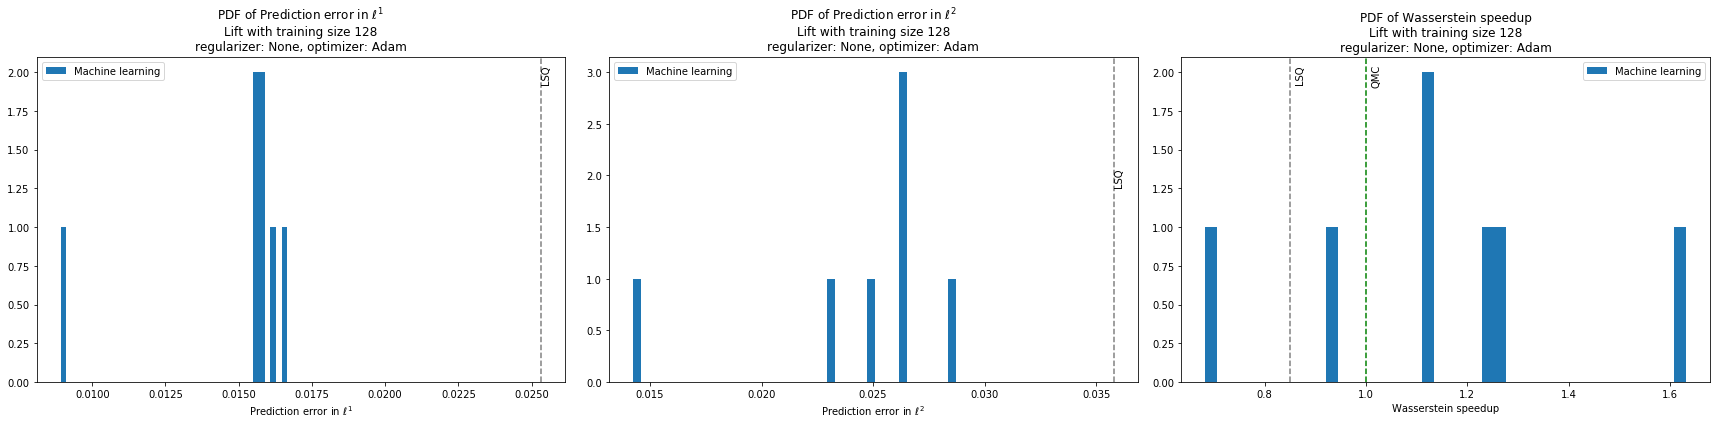

regularizer: l1, optimizer: SGD


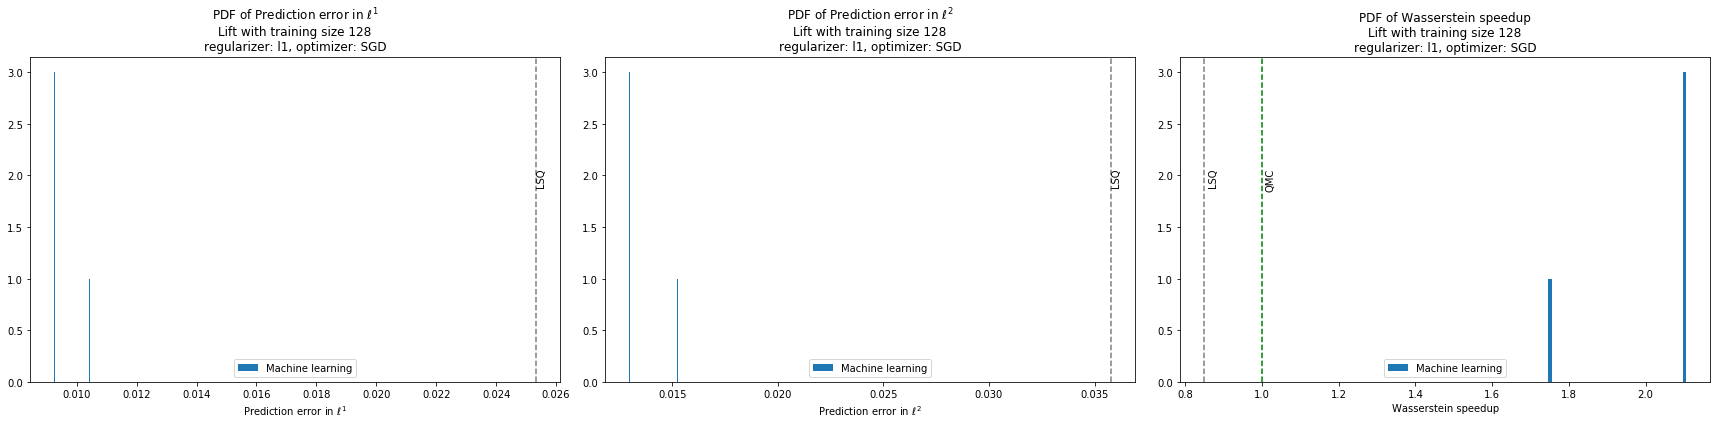

regularizer: l1, optimizer: Adam


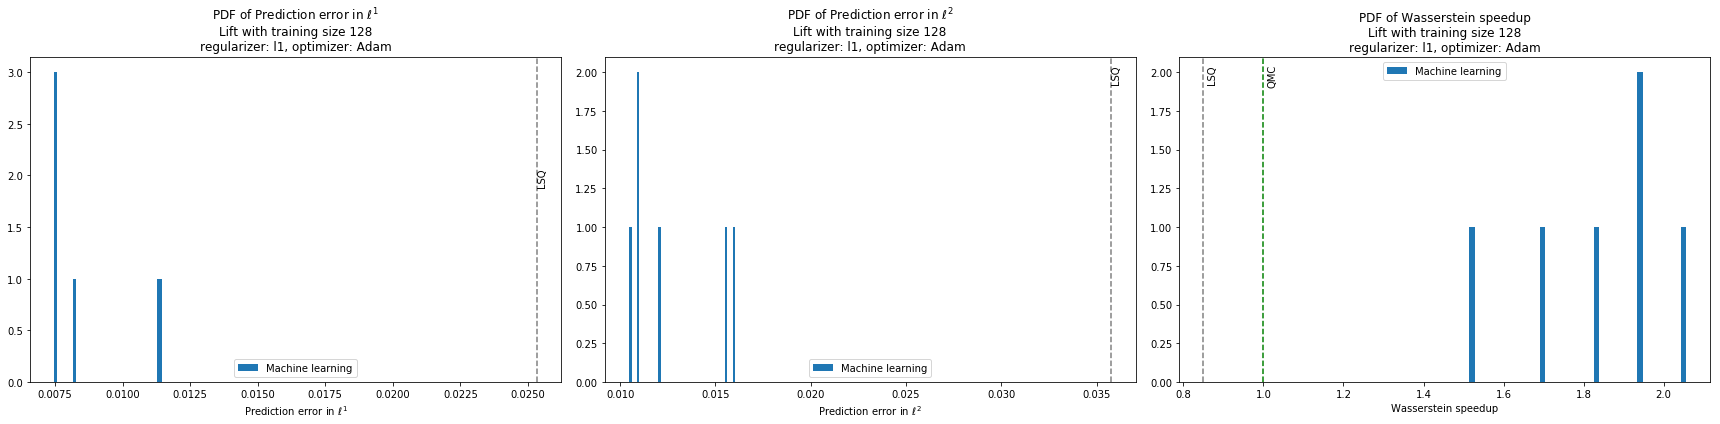

regularizer: l2, loss: mean_squared_error


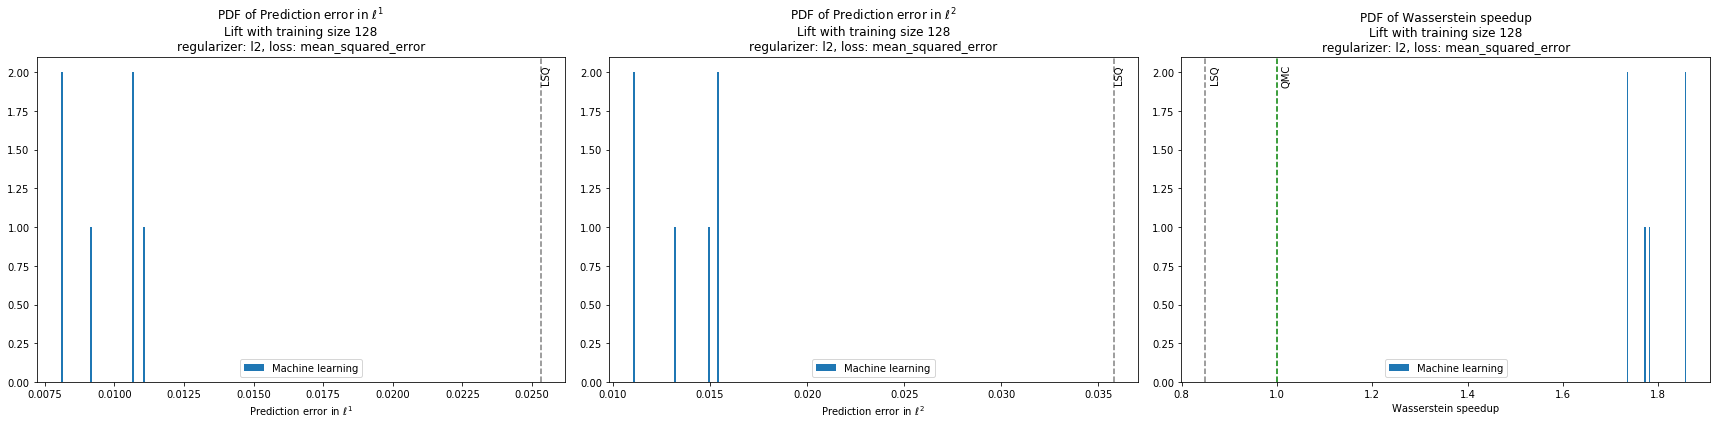

regularizer: l2, loss: mean_absolute_error


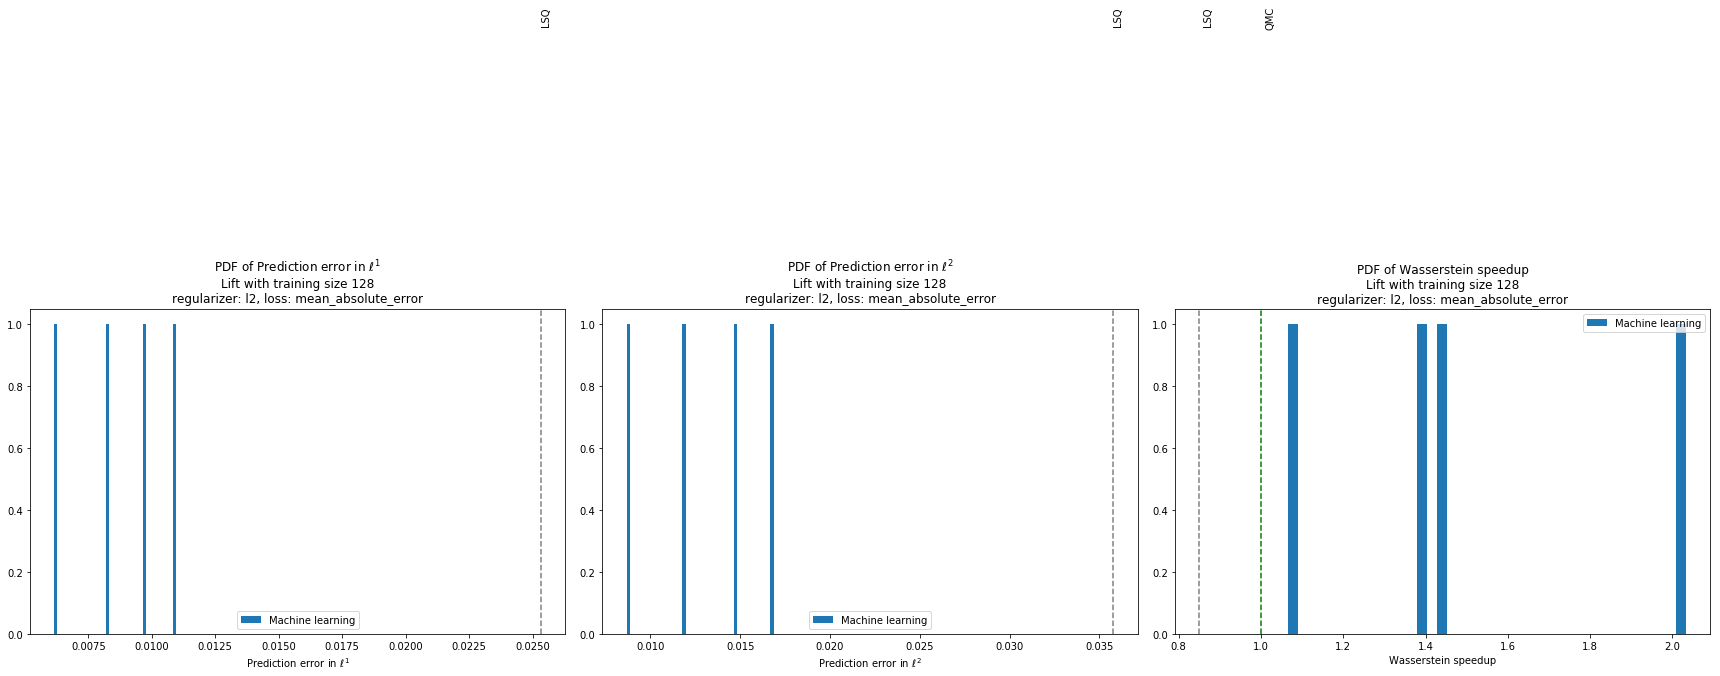

regularizer: None, loss: mean_squared_error


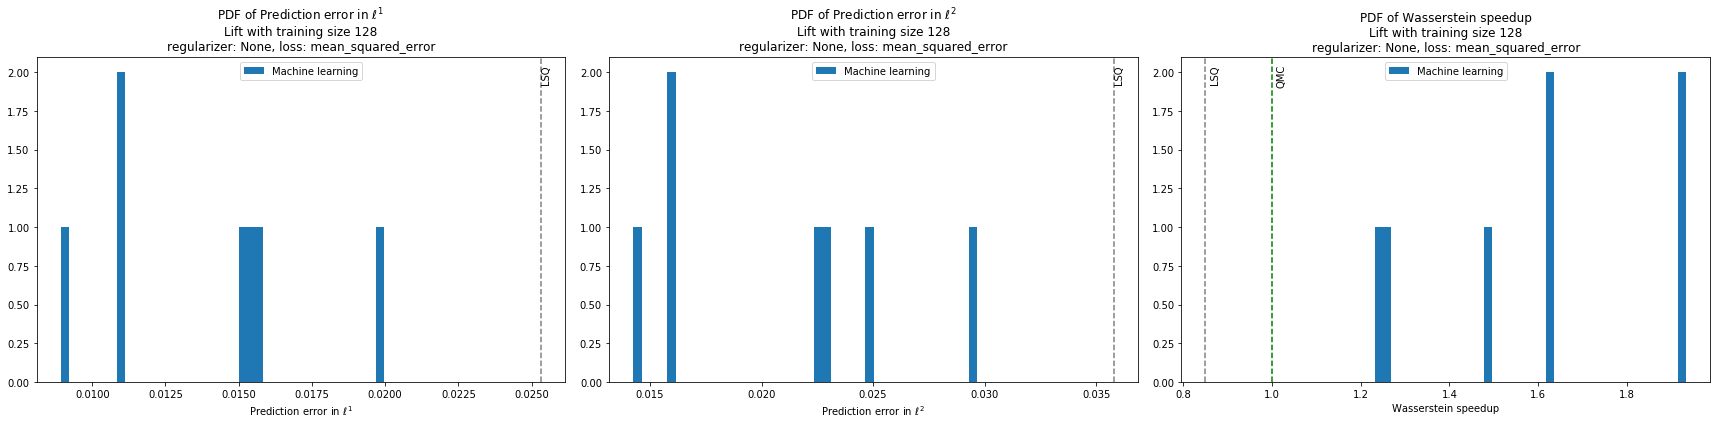

regularizer: None, loss: mean_absolute_error


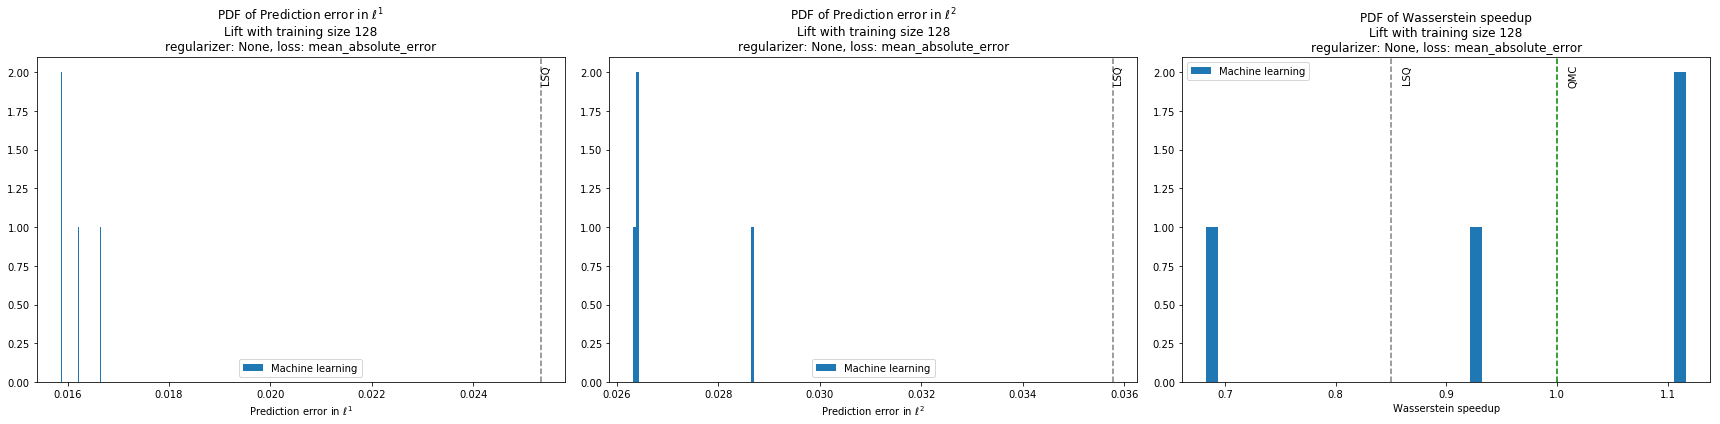

regularizer: l1, loss: mean_squared_error


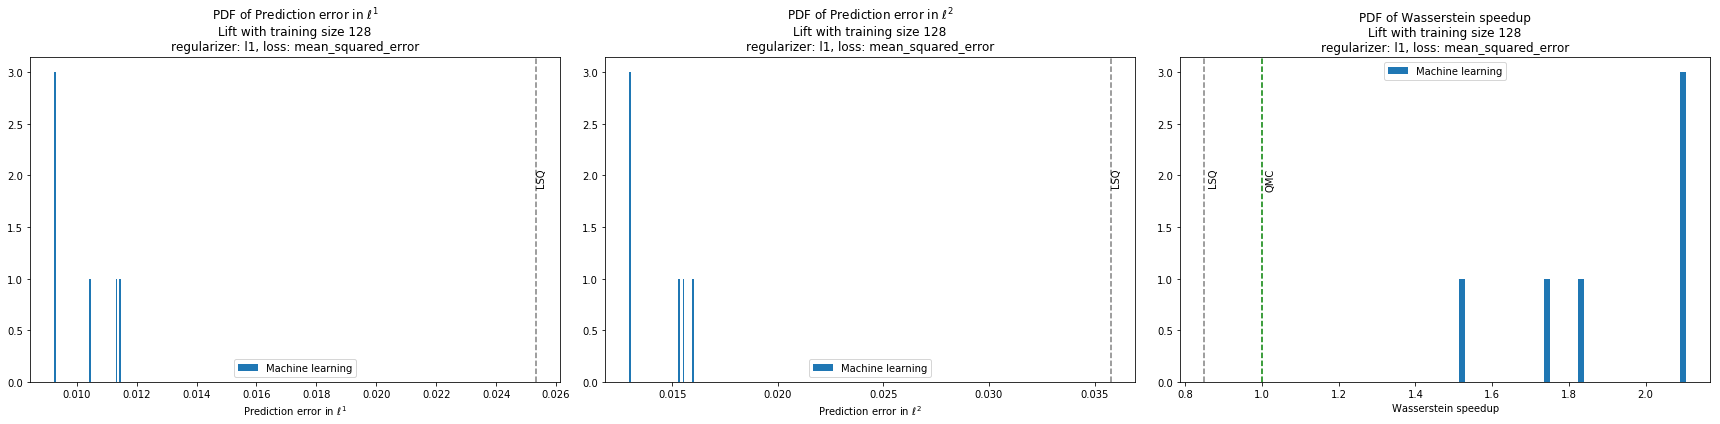

regularizer: l1, loss: mean_absolute_error


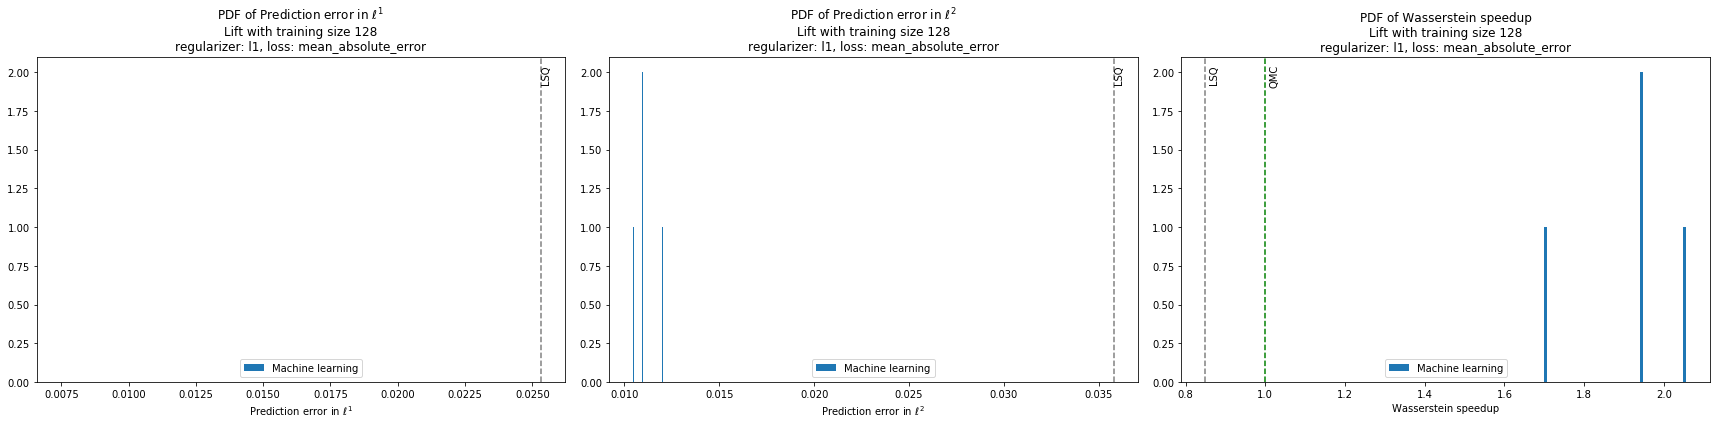

loss: mean_squared_error, optimizer: SGD


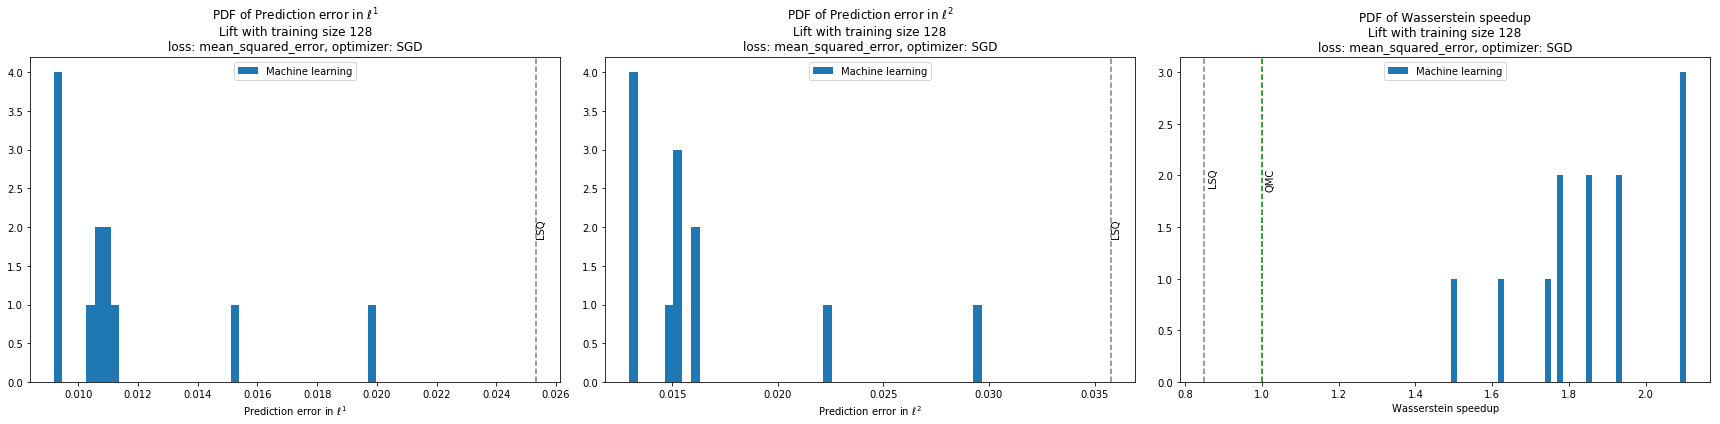

loss: mean_squared_error, optimizer: Adam


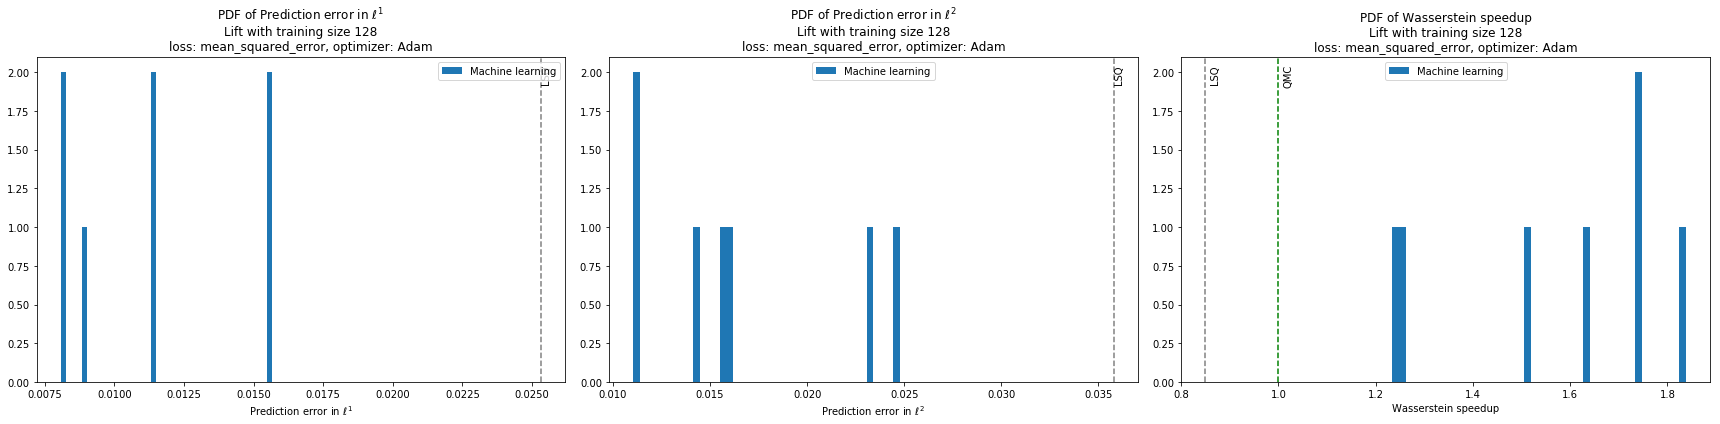

mean_absolute_error
loss: mean_absolute_error, optimizer: Adam


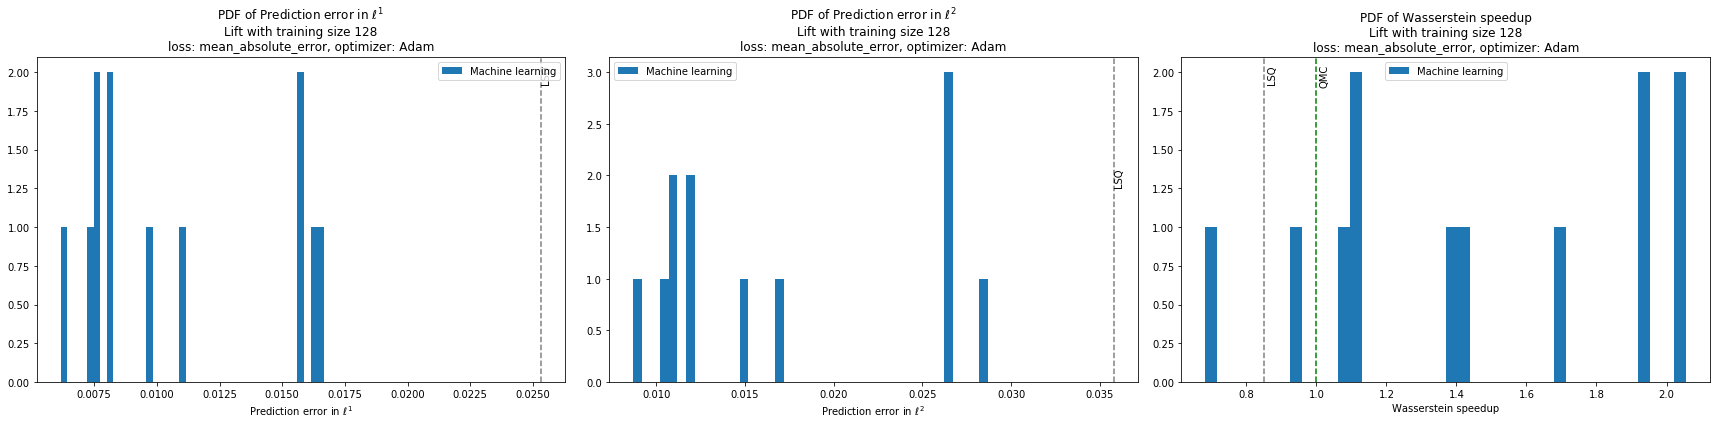

loss: mean_squared_error, regularizer: l2


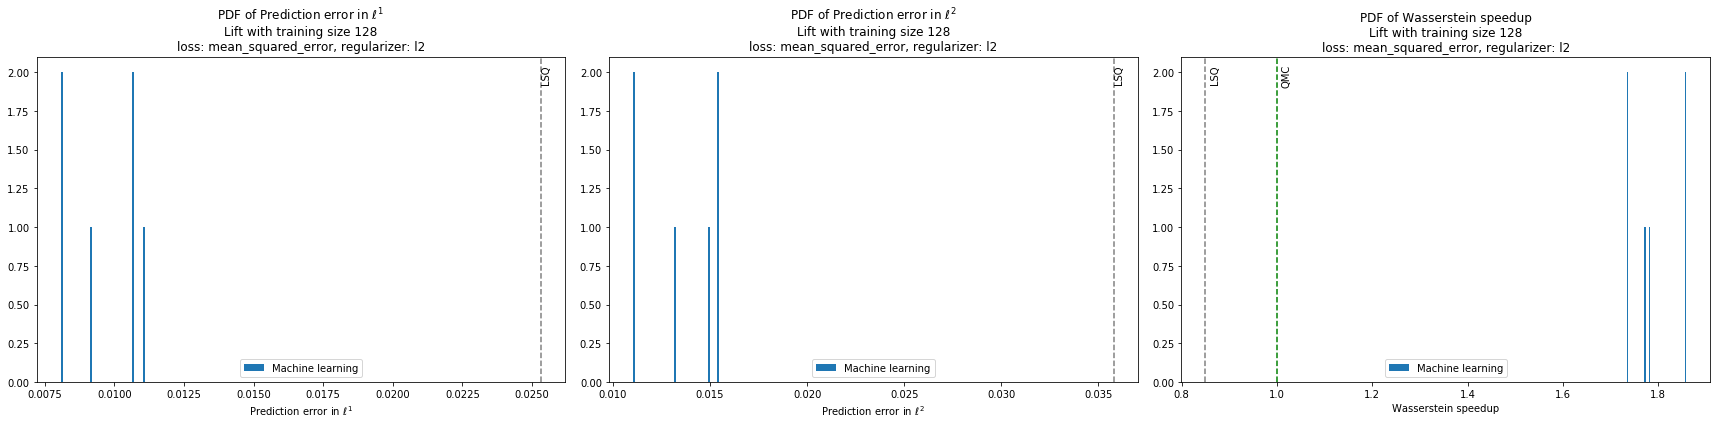

loss: mean_squared_error, regularizer: None


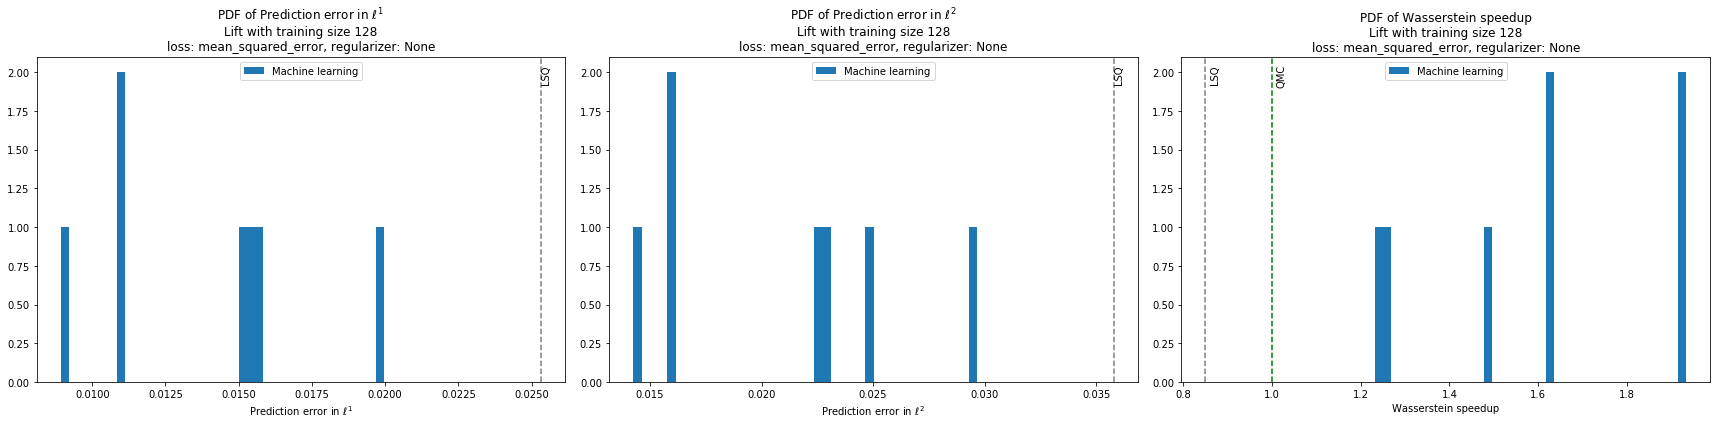

loss: mean_squared_error, regularizer: l1


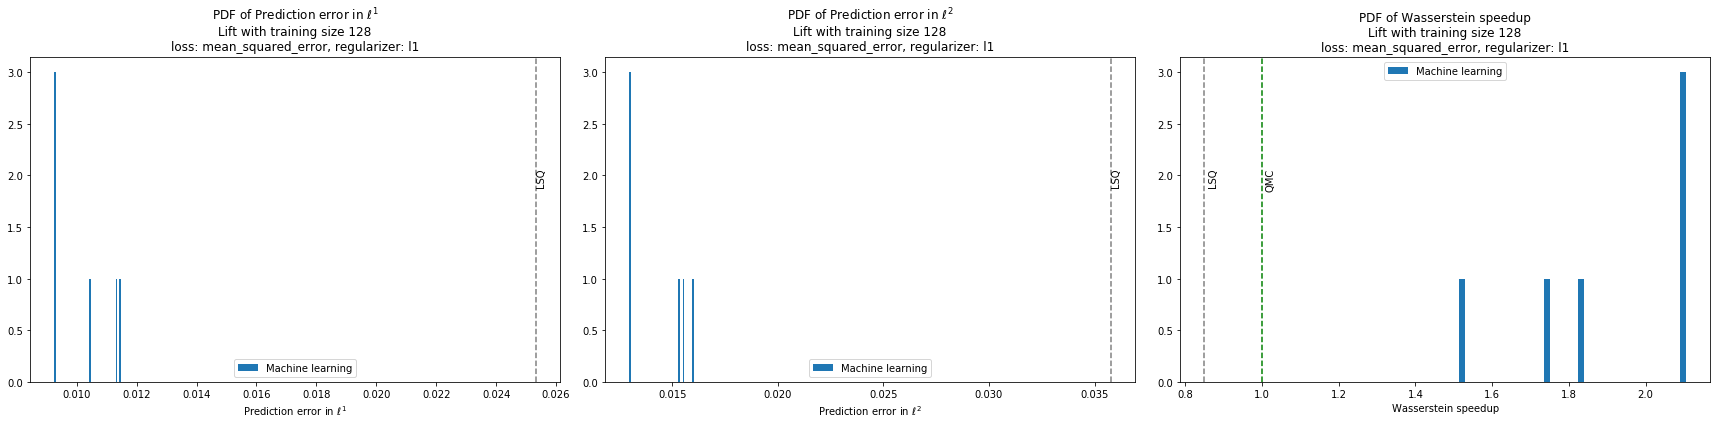

loss: mean_absolute_error, regularizer: l2


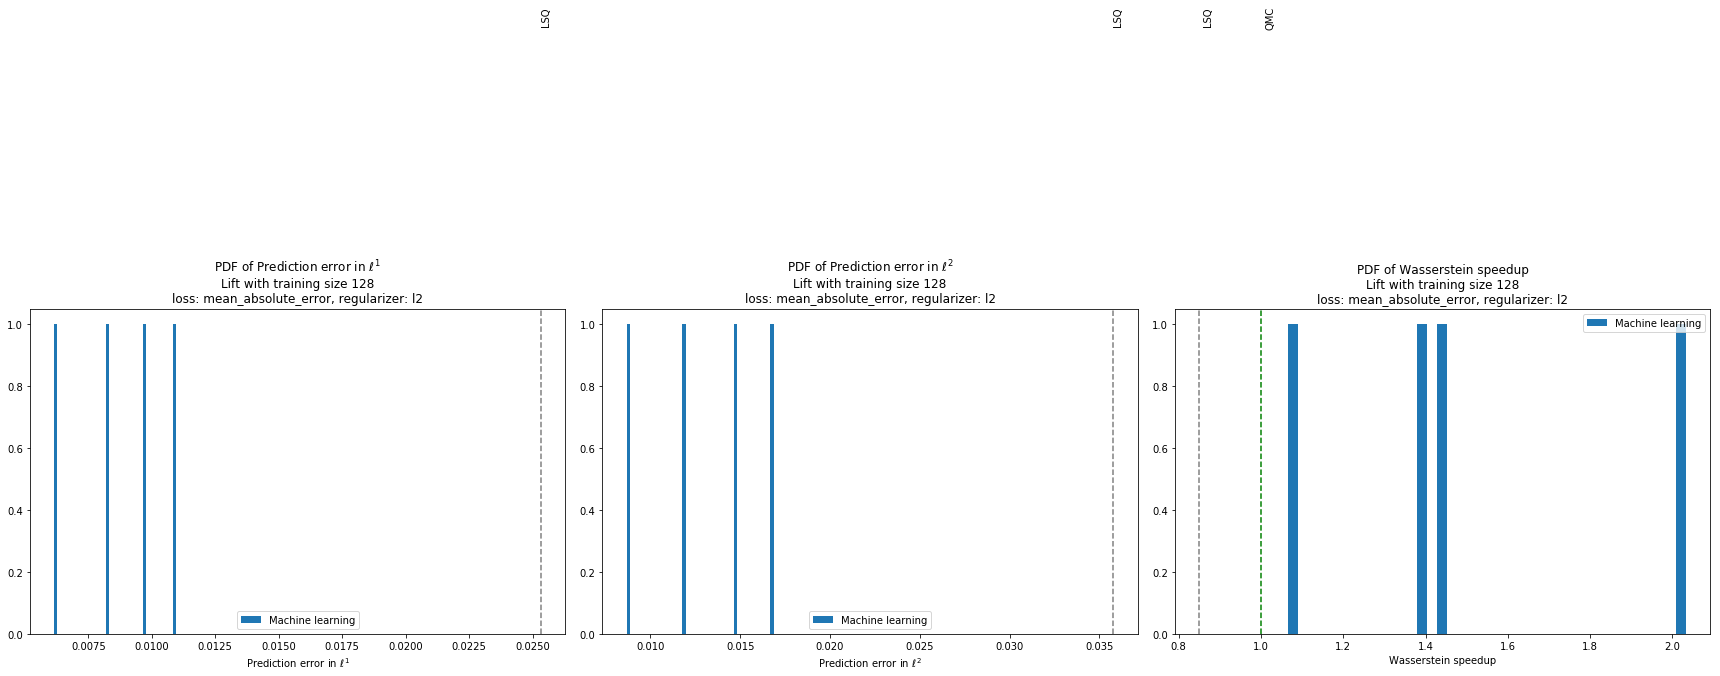

loss: mean_absolute_error, regularizer: None


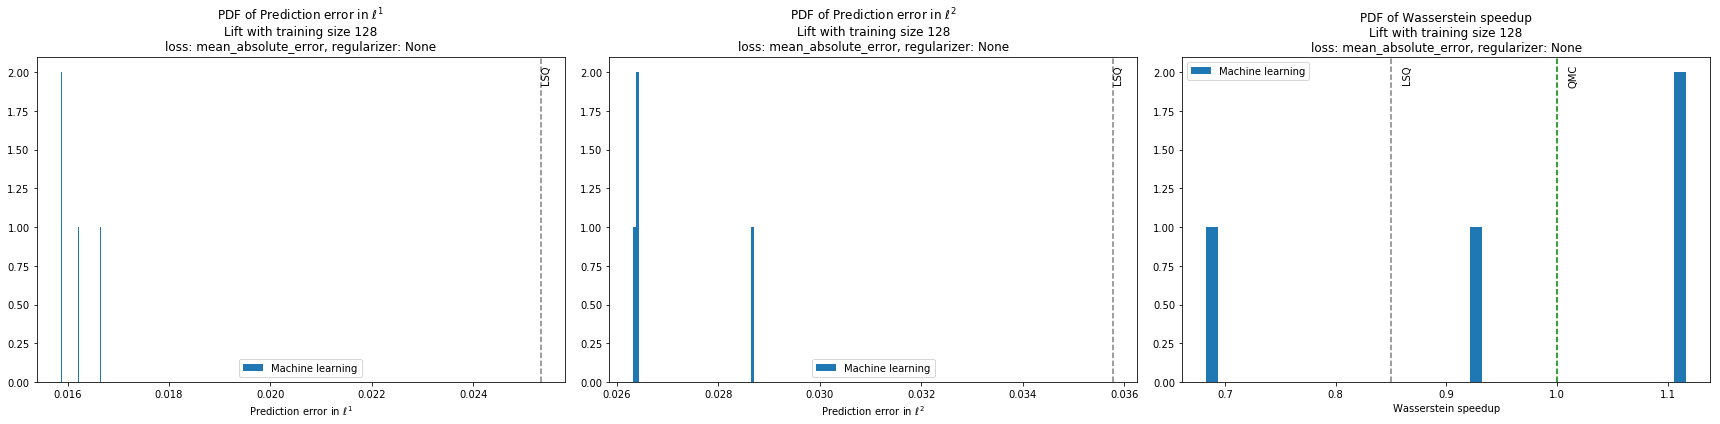

loss: mean_absolute_error, regularizer: l1


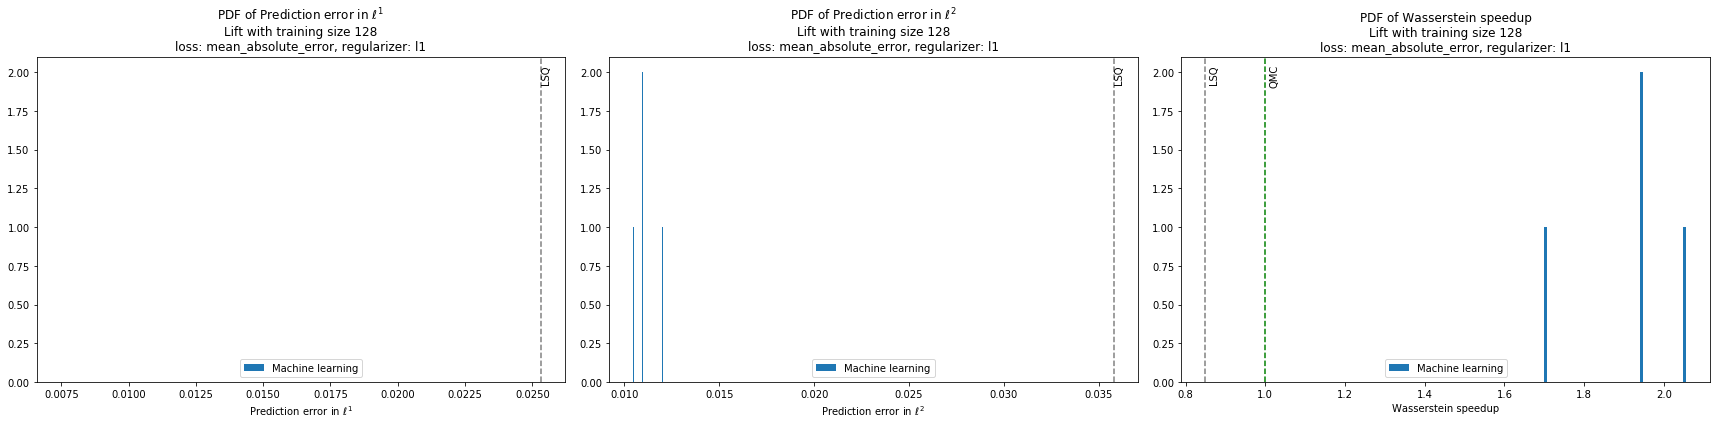

In [26]:
fixed_parameters = ['optimizer', 'regularizer', 'loss']
for selection_type in all_configs['selection_type']:
    plot_info.display(plot_info.HTML("<h1>{}</h1>".format(selection_type)))
    for training_size in all_prediction_l1_errors_training_size.keys():
        if training_size > 128:
            continue
        plot_info.display(plot_info.HTML("<h2>Train size: {}</h2>".format(training_size)))
        for func in functional_names:
            plot_info.display(plot_info.HTML("<h3>{}</h3>".format(func)))
            for fixed_parameter1 in fixed_parameters:
                
                
                

                for fixed_parameter2 in fixed_parameters:
                    if fixed_parameter1 == fixed_parameter2:
                        continue
                    plot_info.display(plot_info.HTML("<h4>Fixing {} and {}</h4>".format(fixed_parameter1, fixed_parameter2)))
                    
                    for parameter1 in all_configs[fixed_parameter1]:
                        for parameter2 in all_configs[fixed_parameter2]:
                            measurements_local = []
                            predictions_l1 = []
                            predictions_l2 = []
                            wasserstein_speedup = []
                            wasserstein_errors = []
                            
                            lsq_predictions_l1 = lsq_prediction_errors_l1[training_size][func]
                            lsq_predictions_l2 = lsq_prediction_errors_l2[training_size][func]
                            lsq_wasserstein_speedup = lsq_wasserstein_speedups_training_size[training_size][func]
                            
                            for m in measurements[func]:
                                if to_str(m.properties[fixed_parameter1]) == to_str(parameter1) and to_str(m.properties[fixed_parameter2]) == to_str(parameter2):
                                    if m.properties['selection_type'] == selection_type:
                                        if m.properties['train_size'] == training_size:
                                            measurements_local.append(m)
                            if len(measurements_local) == 0:
                                print(parameter)
                                continue
                            for m in measurements_local:
                                predictions_l1.append(m.prediction_error_l1)
                                predictions_l2.append(m.prediction_error_l2)
                                wasserstein_speedup.append(m.wasserstein_speedup)
                                wasserstein_errors.append(m.wasserstein_error)
                            
                            extra_title = "{}: {}, {}: {}".format(fixed_parameter1, parameter1, fixed_parameter2, parameter2)
                            print(extra_title)
                            plot_histograms(predictions_l1, lsq_predictions_l1, predictions_l2,lsq_predictions_l2,
                               wasserstein_speedup, lsq_wasserstein_speedup, wasserstein_errors,
                               func, training_size, 
                                           extra_title)
                        